In [1]:
!pip install pytorch-tabnet
!git clone https://github.com/alezakuskin/Stark_ML
!cd /usr/local/lib/python3.7/dist-packages/pytorch_tabnet && patch </content/Stark_ML/float64.patch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'Stark_ML'...
remote: Enumerating objects: 808, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 808 (delta 52), reused 59 (delta 43), pack-reused 737
Receiving objects: 100% (808/808), 32.16 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (476/476), done.
patching file abstract_model.py
patching file multitask.py
patching file pretraining.py
patching file tab_model.py
patching file tab_network.py
patching file utils.py


In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json
import torch
#torch.autograd.set_detect_anomaly(False)
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)

output.clear()

In [33]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML

!git clone https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting
import Stark_ML.models.tabnet


importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)
importlib.reload(Stark_ML.models.tabnet)


from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from Stark_ML.utils.plotting import *
from Stark_ML.models.tabnet import *
from Stark_ML.utils import *
output.clear()

# Data preprocessing

In [4]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [5]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])

#Creating data, target and labels for shift prediction
data_shift = data[np.isnan(data['d (A)']) == False]
data_shift_elements = data_shift.loc[data_shift['Element'].isin(elements_to_exclude)]
data_shift = data_shift.drop(data_shift_elements.index)
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])
target_shift_elements = data_shift_elements['w (A)']
label_shift_elements = data_shift_elements.loc[:, ['Element', 'Wavelength']]


#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 331
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [6]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [7]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


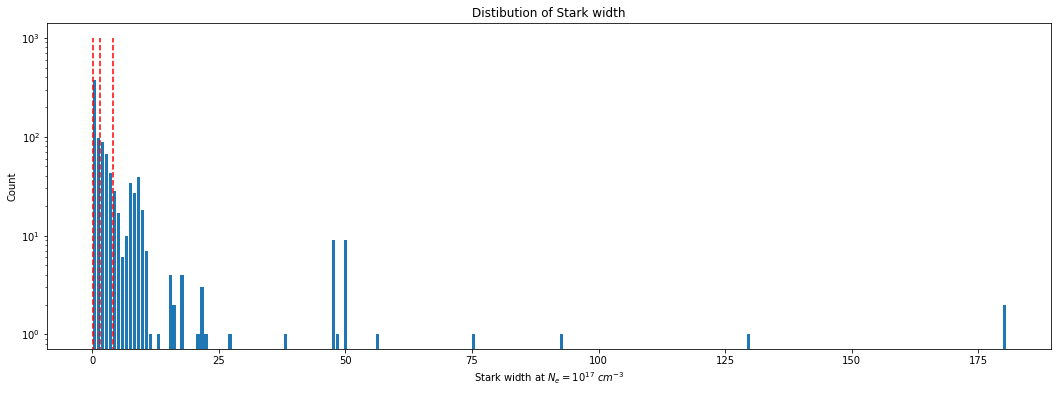

In [8]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [9]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


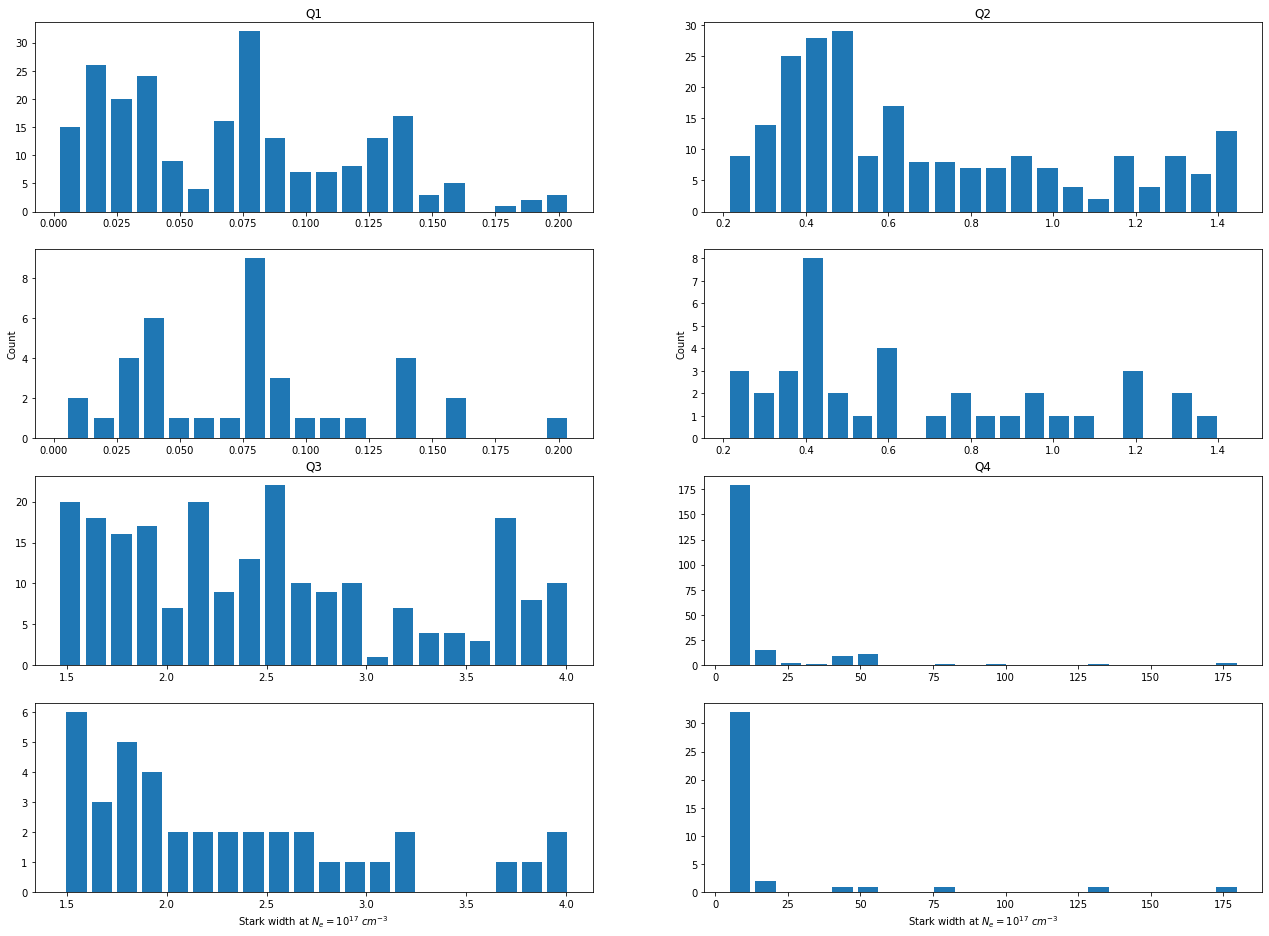

In [10]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [11]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

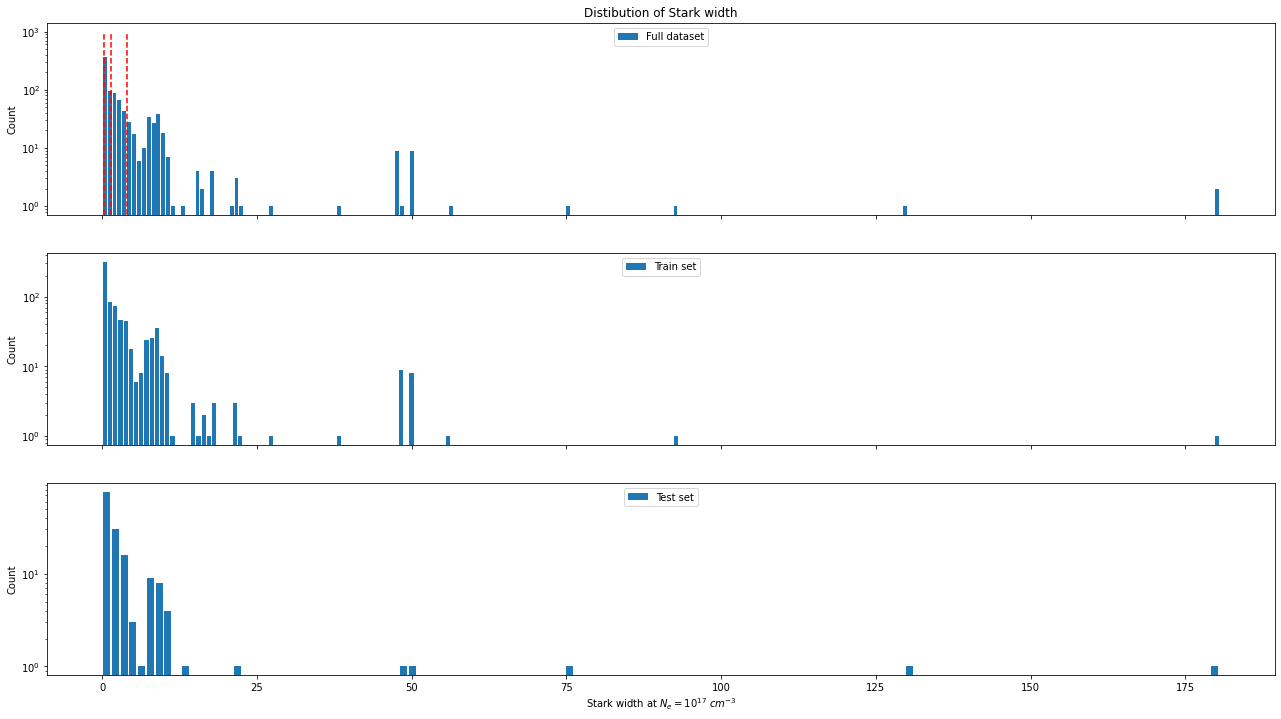

In [12]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

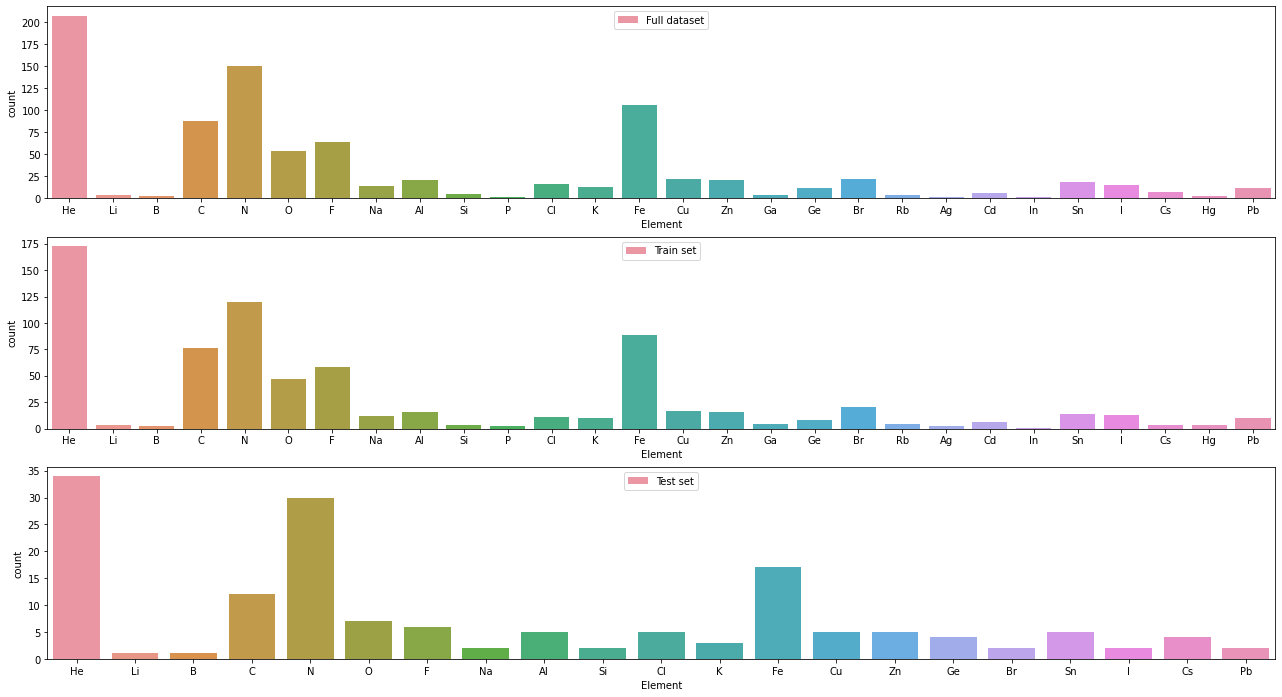

In [13]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [14]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

(743, 50) (743,)
(154, 50) (154,)

 (743, 50) (743,)
(154, 50) (154,)


In [15]:
XW_elem = data_width_elements.drop(columns=['Element', 'Wavelength', 'Z number'])
YW_elem = target_width_elements
LW_elem = label_width_elements

## Shift data preprocessing

In [16]:
data_shift.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.0,331.0,331.0,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000
mean,479.888947,14.045317,1.740181,1.531722,3.308157,0.737160,1.435045,1.797583,0.314199,0.749245,...,0.003021,0.0,0.0,0.0,2.764350,1.187311,0.555891,1.480363,4.027146e+05,17826.404834
std,192.056662,17.933067,0.439199,0.802301,2.162047,0.853039,2.371135,3.775294,0.694837,1.845705,...,0.054965,0.0,0.0,0.0,1.114123,0.864075,0.497619,0.999428,5.473695e+06,9920.444183
min,119.955000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,1.173231e+04,3800.000000
25%,391.633000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,2.000000,1.000000,0.000000,1.000000,5.375643e+04,11000.000000
50%,501.568000,8.000000,2.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,1.000000,1.000000,1.500000,9.966391e+04,15000.000000
75%,589.200750,13.000000,2.000000,2.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,3.000000,2.000000,1.000000,2.000000,1.832368e+05,22700.000000
max,852.112000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,0.0,0.0,0.0,7.000000,5.000000,1.000000,7.000000,9.968131e+07,49000.000000


count    331.000000
mean       2.034925
std        3.704571
min       -7.485437
25%        0.037200
50%        0.290000
75%        2.881356
max       20.000000
Name: d (A), dtype: float64


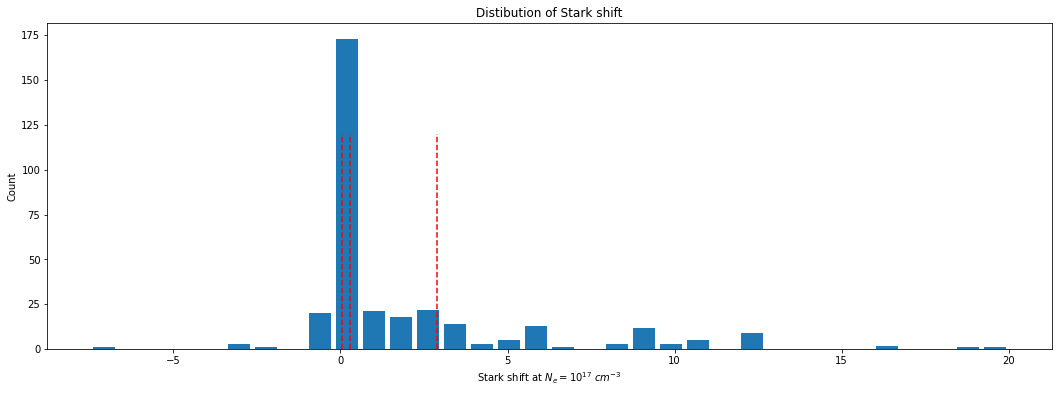

In [17]:
data_shift_stats = target_shift.describe()
print(data_shift_stats)

fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_shift, bins='auto', log=False, rwidth = 0.8)
ax.vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
ax.vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')

ax.set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('Shift distribution.png', dpi = 300)

In [18]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_shift,
                                              target_shift,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 17.5]) < 1 or len(target_test_q4[(target_test_q4 > 11.5) & (target_test_q4 < 17.5)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_shift,
                                                target_shift,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


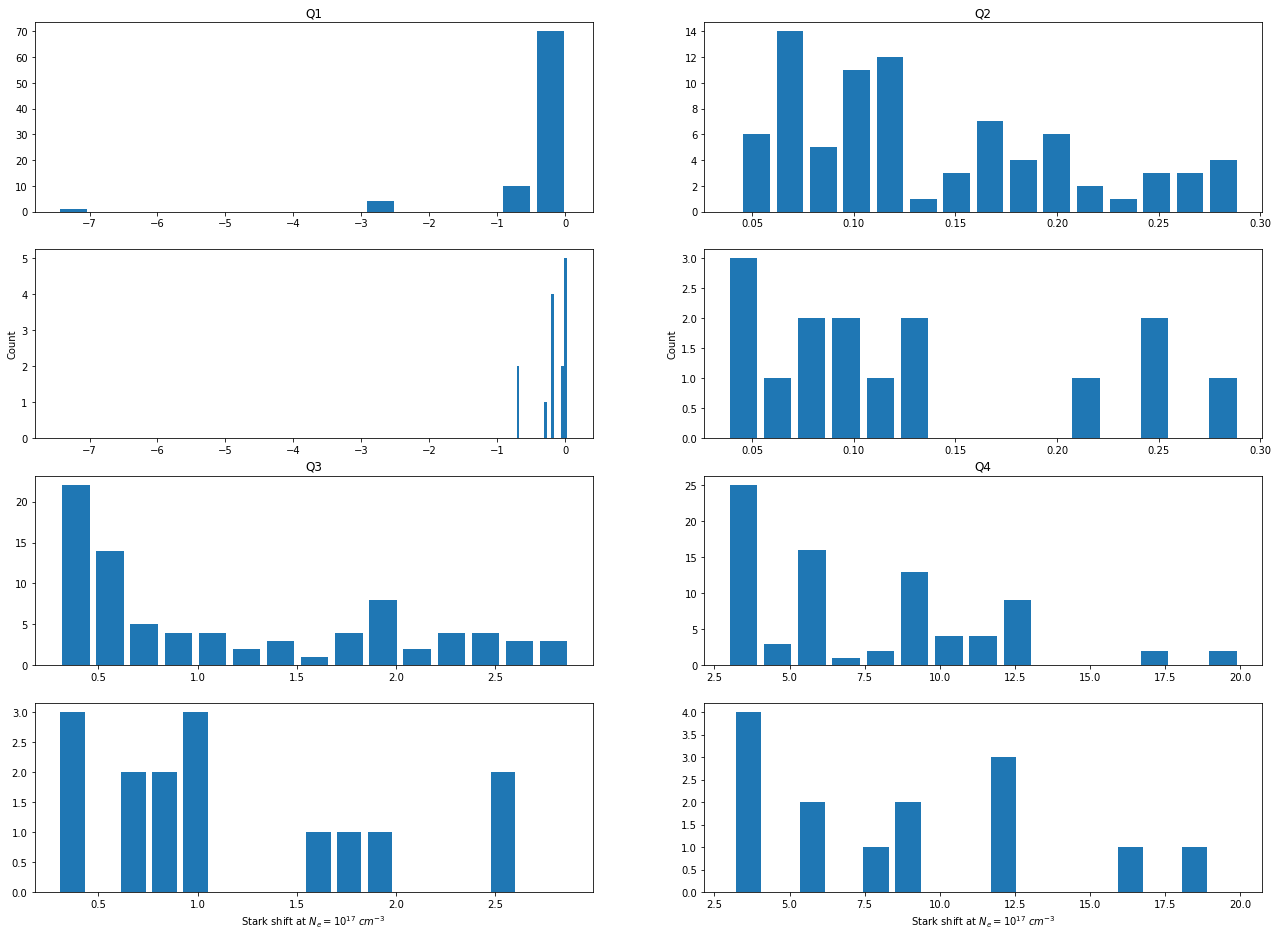

In [19]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_shift[target_shift <= data_shift_stats['25%']], bins=15, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 15, rwidth = 0.8)

axs[0, 1].hist(target_shift[(target_shift > data_shift_stats['25%']) & (target_shift <= data_shift_stats['50%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 15, rwidth = 0.8)

axs[2, 0].hist(target_shift[(target_shift > data_shift_stats['50%']) & (target_shift <= data_shift_stats['75%'])],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 15, rwidth = 0.8)

axs[2, 1].hist(target_shift[target_shift > data_shift_stats['75%']],
                            bins=15, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 15, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [20]:
#Creating full train and test datasets
data_shift_test, target_shift_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q3), target_shift_test.append(target_test_q3)
data_shift_test, target_shift_test = data_shift_test.append(data_test_q4), target_shift_test.append(target_test_q4)

data_shift_train, target_shift_train = data_shift.drop(data_shift_test.index), target_shift.drop(target_shift_test.index)

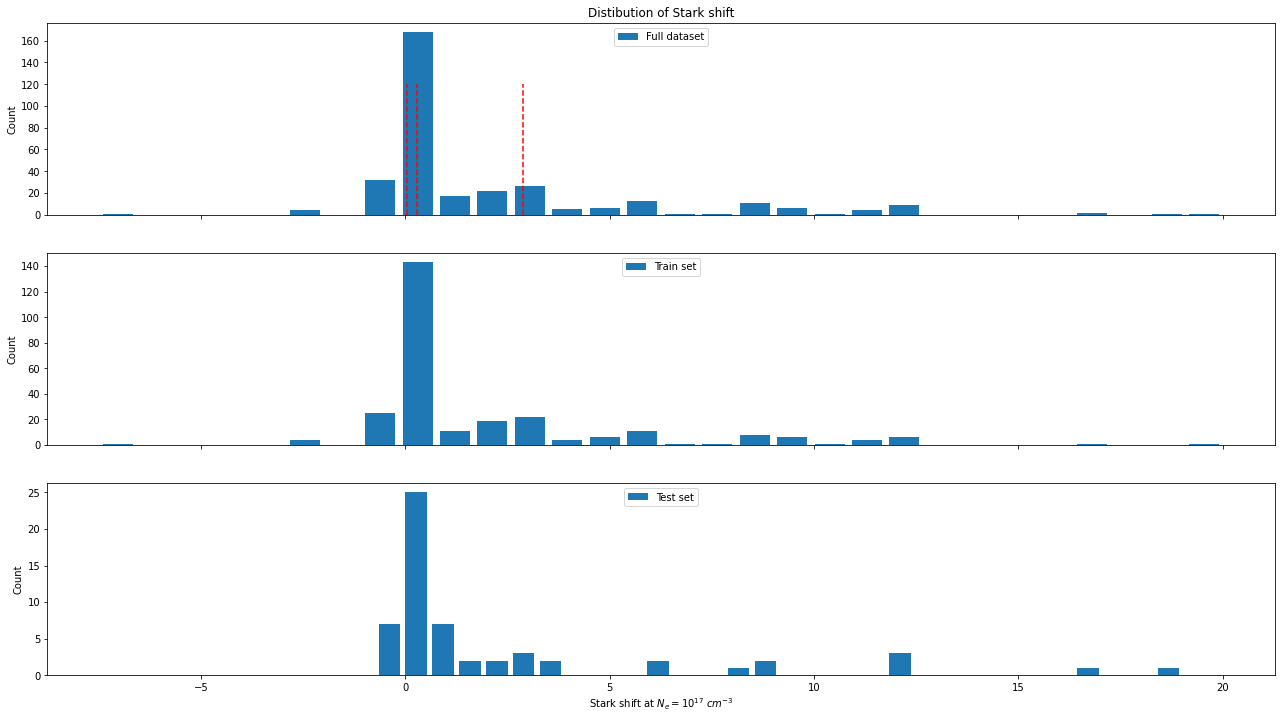

In [21]:
test_shift_stats = target_shift_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_shift, bins=30, log=False, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_shift_train, bins = 30, log = False, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_shift_test, bins = 30, log = False, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_shift_stats['25%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['50%'], ymin = 0, ymax = 120, ls='--', colors='r')
axs[0].vlines(x = data_shift_stats['75%'], ymin = 0, ymax = 120, ls='--', colors='r')
'''axs[1].vlines(x = test_shift_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_shift_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark shift at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark shift')

plt.show()

#plt.savefig('shift distribution.png', dpi = 300)

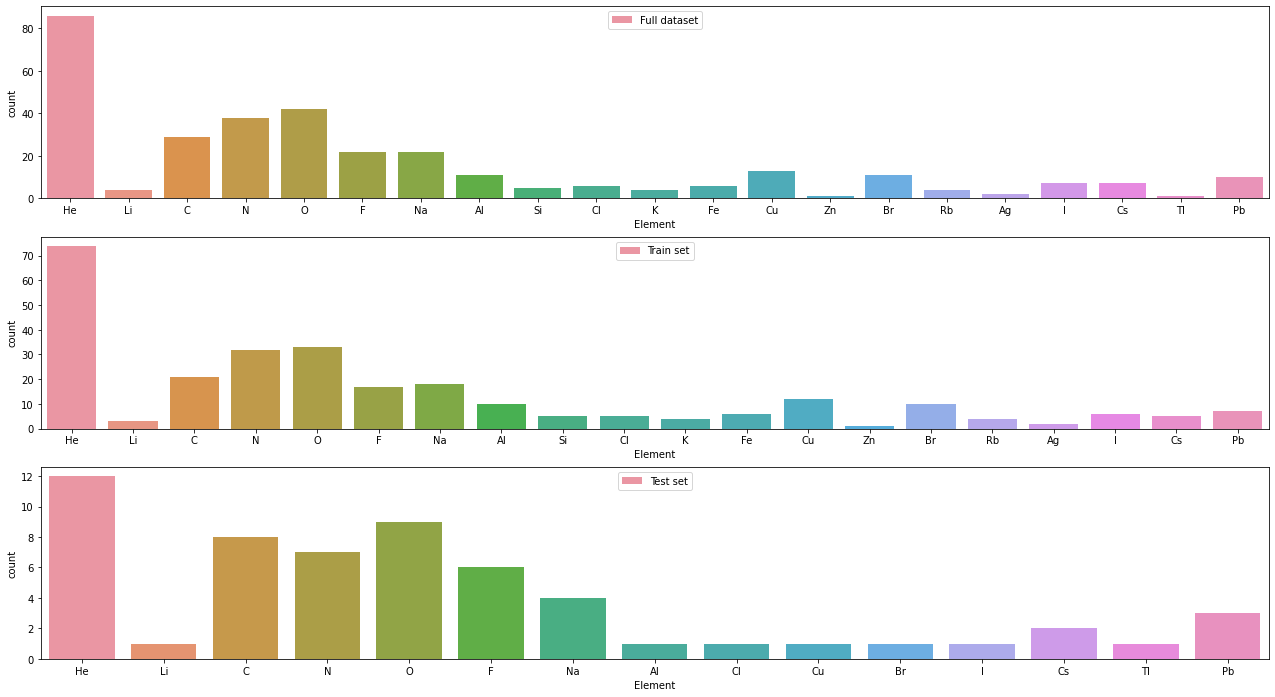

In [22]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_shift, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_shift_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_shift_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [23]:
#Assigning proper variables
XS_train, YS_train = data_shift_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_train
XS_test, YS_test = data_shift_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_shift_test

print(XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

XS_train = XS_train.sample(frac = 1, random_state = 777)
YS_train = YS_train.sample(frac = 1, random_state = 777)

print('\n', XS_train.shape, YS_train.shape)
print(XS_test.shape, YS_test.shape)

(275, 50) (275,)
(58, 50) (58,)

 (275, 50) (275,)
(58, 50) (58,)


In [24]:
XS_elem = data_shift_elements.drop(columns=['Element', 'Wavelength', 'Z number', 'd (A)', 'w (A)'])
YS_elem = target_shift_elements
LS_elem = label_shift_elements

#Models optimization

In [86]:
#@title Max width value
#@markdown You can enter any reasonable value less than 180 Angstrom.
width_threshold =  200#@param {type:"number"}

#@markdown Scale target values by the formula: $y_{scaled} = ln(1 + \frac{y_{raw}}{\epsilon})$
scaled_target = True#@param {type:"boolean"}
epsilon = 1e-3#@param {type: "number"}

In [ ]:
XW_train = XW_train.loc[YW_train.loc[YW_train < width_threshold].index]
YW_train = YW_train.loc[YW_train < width_threshold]
XW_test = XW_test.loc[YW_test.loc[YW_test < width_threshold].index]
YW_test = YW_test.loc[YW_test < width_threshold]
XW_elem = XW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]
YW_elem = YW_elem.loc[YW_elem < width_threshold]
LW_elem = LW_elem.loc[YW_elem.loc[YW_elem < width_threshold].index]

if scaled_target:
    YW_train = np.log(1 + YW_train / epsilon)
    YW_test = np.log(1 + YW_test / epsilon)
    YW_elem = np.log(1 + YW_elem / epsilon)

## KNN

In [ ]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = KNN

KNN_res = main(X = XS_train, y = YS_train, model_name = model_name, params = KNN_params, n_trials = 500)

'''with open(f'KNN_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)
'''
with open(f'KNN_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2022-05-13 11:00:42,942] A new study created in memory with name: no-name-880c2a57-165e-42d5-8c54-0800417cf705


Start hyperparameter optimization
{'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.4757060357420744}{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 86, 'p': 1.275673133334954}



/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-05-13 11:00:43,599] Trial 0 finished with value: 3.4950664254000423 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.4757060357420744}. Best is trial 0 with value: 3.4950664254000423.
[I 2022-05-13 11:00:43,644] Trial 1 finished with value: 1.2550758219148195 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 86, 'p': 1.275673133334954}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5893058651654886}
{'n_neighbors': 72, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.281599752372552}


[I 2022-05-13 11:00:44,208] Trial 2 finished with value: 3.1779068169727154 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5893058651654886}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:44,286] Trial 3 finished with value: 3.519009943408739 and parameters: {'n_neighbors': 72, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.281599752372552}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 20, 'p': 1.4094815577486899}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0206447210478906}


[I 2022-05-13 11:00:44,817] Trial 4 finished with value: 1.3931995712811098 and parameters: {'n_neighbors': 127, 'weights': 'distance', 'leaf_size': 20, 'p': 1.4094815577486899}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:44,893] Trial 5 finished with value: 1.3294527366699378 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0206447210478906}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 76, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0003407558550883}
{'n_neighbors': 89, 'weights': 'distance', 'leaf_size': 75, 'p': 1.5051308945592798}


[I 2022-05-13 11:00:45,420] Trial 6 finished with value: 1.306520171981843 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'leaf_size': 57, 'p': 1.0003407558550883}. Best is trial 1 with value: 1.2550758219148195.
[I 2022-05-13 11:00:45,471] Trial 7 finished with value: 1.3790130234791578 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'leaf_size': 75, 'p': 1.5051308945592798}. Best is trial 1 with value: 1.2550758219148195.


{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1295445202596917}
{'n_neighbors': 144, 'weights': 'distance', 'leaf_size': 92, 'p': 1.2566001441456451}


[I 2022-05-13 11:00:45,997] Trial 8 finished with value: 1.2409920133455052 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 99, 'p': 1.1295445202596917}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:46,052] Trial 9 finished with value: 1.3937865151141926 and parameters: {'n_neighbors': 144, 'weights': 'distance', 'leaf_size': 92, 'p': 1.2566001441456451}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 50, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0959151915333067}
{'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 5, 'p': 1.9087597600524282}


[I 2022-05-13 11:00:46,598] Trial 10 finished with value: 1.3032898206118524 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0959151915333067}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:46,656] Trial 11 finished with value: 3.501365444841981 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'leaf_size': 5, 'p': 1.9087597600524282}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 39, 'p': 1.9838367165886888}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 44, 'p': 1.2215005322731125}


[I 2022-05-13 11:00:47,149] Trial 12 finished with value: 1.345999715189467 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 39, 'p': 1.9838367165886888}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:47,215] Trial 13 finished with value: 1.2692183891244333 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 44, 'p': 1.2215005322731125}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2378938585631214}
{'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7327658797099987}


[I 2022-05-13 11:00:47,708] Trial 14 finished with value: 1.2581216439417373 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2378938585631214}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:47,769] Trial 15 finished with value: 1.3047932335095997 and parameters: {'n_neighbors': 25, 'weights': 'distance', 'leaf_size': 98, 'p': 1.7327658797099987}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 106, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7126891833724647}
{'n_neighbors': 109, 'weights': 'distance', 'leaf_size': 69, 'p': 1.146667845840241}


[I 2022-05-13 11:00:48,273] Trial 16 finished with value: 1.407555181721948 and parameters: {'n_neighbors': 106, 'weights': 'distance', 'leaf_size': 67, 'p': 1.7126891833724647}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:48,329] Trial 17 finished with value: 1.34270790483564 and parameters: {'n_neighbors': 109, 'weights': 'distance', 'leaf_size': 69, 'p': 1.146667845840241}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 30, 'p': 1.139789388066935}
{'n_neighbors': 61, 'weights': 'uniform', 'leaf_size': 32, 'p': 1.3707722982789938}


[I 2022-05-13 11:00:48,828] Trial 18 finished with value: 1.311773342539706 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 30, 'p': 1.139789388066935}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:48,886] Trial 19 finished with value: 3.544084581949619 and parameters: {'n_neighbors': 61, 'weights': 'uniform', 'leaf_size': 32, 'p': 1.3707722982789938}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.3480638958375375}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.3179692174228799}


[I 2022-05-13 11:00:49,384] Trial 20 finished with value: 1.8026939724298015 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.3480638958375375}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:49,440] Trial 21 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.3179692174228799}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 32, 'weights': 'distance', 'leaf_size': 99, 'p': 1.224308648213889}
{'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2120149968155232}


[I 2022-05-13 11:00:49,941] Trial 22 finished with value: 1.2992234420008009 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'leaf_size': 99, 'p': 1.224308648213889}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:49,997] Trial 23 finished with value: 1.3016827099893038 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'leaf_size': 97, 'p': 1.2120149968155232}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 18, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1343873108269449}
{'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1205375844028556}


[I 2022-05-13 11:00:50,492] Trial 24 finished with value: 1.243564108509729 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1343873108269449}. Best is trial 8 with value: 1.2409920133455052.
[I 2022-05-13 11:00:50,559] Trial 25 finished with value: 1.2454498906564768 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1205375844028556}. Best is trial 8 with value: 1.2409920133455052.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1030314057260748}
{'n_neighbors': 40, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0741142304719655}


[I 2022-05-13 11:00:51,042] Trial 26 finished with value: 1.2341907099039073 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1030314057260748}. Best is trial 26 with value: 1.2341907099039073.
[I 2022-05-13 11:00:51,110] Trial 27 finished with value: 1.2973179261064796 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0741142304719655}. Best is trial 26 with value: 1.2341907099039073.


{'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0694775381812869}
{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0460880987305945}


[I 2022-05-13 11:00:51,595] Trial 28 finished with value: 1.2974345708999935 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0694775381812869}. Best is trial 26 with value: 1.2341907099039073.
[I 2022-05-13 11:00:51,671] Trial 29 finished with value: 1.2289730365543103 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0460880987305945}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.457949347300198}
{'n_neighbors': 55, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.436513279131227}


[I 2022-05-13 11:00:52,146] Trial 30 finished with value: 2.053695285153274 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.457949347300198}. Best is trial 29 with value: 1.2289730365543103.
[I 2022-05-13 11:00:52,223] Trial 31 finished with value: 3.5459831558908457 and parameters: {'n_neighbors': 55, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.436513279131227}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1589751201413274}
{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 89, 'p': 1.165295442672689}


[I 2022-05-13 11:00:52,698] Trial 32 finished with value: 1.241843374264008 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1589751201413274}. Best is trial 29 with value: 1.2289730365543103.
[I 2022-05-13 11:00:52,780] Trial 33 finished with value: 1.2422598241406924 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 89, 'p': 1.165295442672689}. Best is trial 29 with value: 1.2289730365543103.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0375872809004796}
{'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0053312936971062}


[I 2022-05-13 11:00:53,252] Trial 34 finished with value: 1.2192438032739634 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 90, 'p': 1.0375872809004796}. Best is trial 34 with value: 1.2192438032739634.
[I 2022-05-13 11:00:53,334] Trial 35 finished with value: 1.2861195538412653 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0053312936971062}. Best is trial 34 with value: 1.2192438032739634.


{'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 82, 'p': 1.0520171438749102}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 71, 'p': 1.059064464445527}


[I 2022-05-13 11:00:53,809] Trial 36 finished with value: 1.2909658274855287 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'leaf_size': 82, 'p': 1.0520171438749102}. Best is trial 34 with value: 1.2192438032739634.
[I 2022-05-13 11:00:53,886] Trial 37 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 71, 'p': 1.059064464445527}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 71, 'p': 1.5425231680696905}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0479150818725025}


[I 2022-05-13 11:00:54,365] Trial 38 finished with value: 1.2808145292880648 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 71, 'p': 1.5425231680696905}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:54,441] Trial 39 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 52, 'p': 1.0479150818725025}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0400094042500188}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.036371454049353}


[I 2022-05-13 11:00:54,918] Trial 40 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0400094042500188}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:54,997] Trial 41 finished with value: 1.5631766442098254 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.036371454049353}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0406659593175887}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0109993376935962}


[I 2022-05-13 11:00:55,473] Trial 42 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0406659593175887}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:55,549] Trial 43 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0109993376935962}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.003137107772517}
{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0130226039642154}


[I 2022-05-13 11:00:56,025] Trial 44 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.003137107772517}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:56,100] Trial 45 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0130226039642154}. Best is trial 37 with value: 0.9661027438815045.


{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.181269777809788}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1774428222396276}


[I 2022-05-13 11:00:56,578] Trial 46 finished with value: 1.2033283196753626 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.181269777809788}. Best is trial 37 with value: 0.9661027438815045.
[I 2022-05-13 11:00:56,650] Trial 47 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1774428222396276}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 77, 'weights': 'uniform', 'leaf_size': 40, 'p': 1.2914861532120254}
{'n_neighbors': 21, 'weights': 'uniform', 'leaf_size': 37, 'p': 1.3033004354180535}


[I 2022-05-13 11:00:57,132] Trial 48 finished with value: 3.530314234761364 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'leaf_size': 40, 'p': 1.2914861532120254}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:57,207] Trial 49 finished with value: 2.824212149030244 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'leaf_size': 37, 'p': 1.3033004354180535}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0920774635968864}
{'n_neighbors': 143, 'weights': 'uniform', 'leaf_size': 59, 'p': 1.091941969195768}


[I 2022-05-13 11:00:57,701] Trial 50 finished with value: 3.1598119491905323 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0920774635968864}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:57,779] Trial 51 finished with value: 3.6390936057467074 and parameters: {'n_neighbors': 143, 'weights': 'uniform', 'leaf_size': 59, 'p': 1.091941969195768}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 56, 'p': 1.0973279437712176}
{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.0012567010472222}


[I 2022-05-13 11:00:58,253] Trial 52 finished with value: 1.7574365017358402 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 56, 'p': 1.0973279437712176}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:58,335] Trial 53 finished with value: 1.7220098503515953 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.0012567010472222}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.000635634214034}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.192091246129672}


[I 2022-05-13 11:00:58,821] Trial 54 finished with value: 1.7223247125154955 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.000635634214034}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:58,905] Trial 55 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 22, 'p': 1.192091246129672}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.1900284415592577}
{'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 31, 'p': 1.2647465047858129}


[I 2022-05-13 11:00:59,376] Trial 56 finished with value: 2.612867754413684 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 21, 'p': 1.1900284415592577}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:00:59,457] Trial 57 finished with value: 2.6210459471446503 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'leaf_size': 31, 'p': 1.2647465047858129}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.6304487082895953}
{'n_neighbors': 27, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.626328809413225}


[I 2022-05-13 11:00:59,939] Trial 58 finished with value: 3.6178492699853706 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.6304487082895953}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:00,008] Trial 59 finished with value: 3.224262001013012 and parameters: {'n_neighbors': 27, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.626328809413225}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 28, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1235283904950237}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1237645115807955}


[I 2022-05-13 11:01:00,499] Trial 60 finished with value: 3.256271213060411 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1235283904950237}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:00,565] Trial 61 finished with value: 1.6779714687492622 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.1237645115807955}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 13, 'p': 1.0680546405944467}
{'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.0668644245254695}


[I 2022-05-13 11:01:01,052] Trial 62 finished with value: 1.7721475358978935 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 13, 'p': 1.0680546405944467}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:01,115] Trial 63 finished with value: 1.2033270864408572 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.0668644245254695}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 26, 'p': 1.1971589181343536}
{'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.2033740565838231}


[I 2022-05-13 11:01:01,604] Trial 64 finished with value: 2.2643289165823077 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 26, 'p': 1.1971589181343536}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:01,670] Trial 65 finished with value: 2.264328954566724 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'leaf_size': 23, 'p': 1.2033740565838231}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.7999776392807785}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.2475815322285742}


[I 2022-05-13 11:01:02,164] Trial 66 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.7999776392807785}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:02,225] Trial 67 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.2475815322285742}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 126, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.1520016048911967}
{'n_neighbors': 125, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3858781600179653}


[I 2022-05-13 11:01:02,726] Trial 68 finished with value: 3.6201304364992595 and parameters: {'n_neighbors': 126, 'weights': 'uniform', 'leaf_size': 36, 'p': 1.1520016048911967}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:02,783] Trial 69 finished with value: 3.625789255768084 and parameters: {'n_neighbors': 125, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3858781600179653}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 23, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3599352144286274}
{'n_neighbors': 22, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.031275441085553}


[I 2022-05-13 11:01:03,282] Trial 70 finished with value: 3.000795191016082 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.3599352144286274}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:03,337] Trial 71 finished with value: 2.885584654806773 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.031275441085553}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.01519003829378}
{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.0240252973909634}


[I 2022-05-13 11:01:03,839] Trial 72 finished with value: 1.6739740067360334 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.01519003829378}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:03,892] Trial 73 finished with value: 1.8443737626723447 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.0240252973909634}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.0447215206816585}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.073498049784656}


[I 2022-05-13 11:01:04,391] Trial 74 finished with value: 1.918532260923704 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.0447215206816585}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:04,453] Trial 75 finished with value: 1.6082376865827162 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 6, 'p': 1.073498049784656}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 10, 'p': 1.0612389428317295}
{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 16, 'p': 1.1088155038087746}


[I 2022-05-13 11:01:04,942] Trial 76 finished with value: 1.5941894464815245 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 10, 'p': 1.0612389428317295}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:05,007] Trial 77 finished with value: 1.239046113777236 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 16, 'p': 1.1088155038087746}. Best is trial 47 with value: 0.9661023059176174.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 2, 'p': 1.1327012882293432}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1634943059210665}


[I 2022-05-13 11:01:05,498] Trial 78 finished with value: 1.2402851551649197 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 2, 'p': 1.1327012882293432}. Best is trial 47 with value: 0.9661023059176174.
[I 2022-05-13 11:01:05,564] Trial 79 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1634943059210665}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0830978962608593}
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 71, 'p': 1.1816916641552444}


[I 2022-05-13 11:01:06,063] Trial 80 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0830978962608593}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:06,122] Trial 81 finished with value: 1.2446952345892632 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 71, 'p': 1.1816916641552444}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 71, 'p': 1.171507313003774}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.157283310236145}


[I 2022-05-13 11:01:06,617] Trial 82 finished with value: 1.2498731999712196 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 71, 'p': 1.171507313003774}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:06,679] Trial 83 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 69, 'p': 1.157283310236145}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 67, 'p': 1.2319173413719553}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 68, 'p': 1.0923282303031983}


[I 2022-05-13 11:01:07,178] Trial 84 finished with value: 1.3906486232175785 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 67, 'p': 1.2319173413719553}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:07,237] Trial 85 finished with value: 1.3479139053114688 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 68, 'p': 1.0923282303031983}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 73, 'p': 1.0911645132800012}
{'n_neighbors': 70, 'weights': 'distance', 'leaf_size': 59, 'p': 1.1430428215243305}


[I 2022-05-13 11:01:07,728] Trial 86 finished with value: 1.2501772860889342 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 73, 'p': 1.0911645132800012}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:07,796] Trial 87 finished with value: 1.3120886334832567 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'leaf_size': 59, 'p': 1.1430428215243305}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 71, 'weights': 'distance', 'leaf_size': 78, 'p': 1.1380407179390226}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0512473992454752}


[I 2022-05-13 11:01:08,284] Trial 88 finished with value: 1.3118711618505943 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'leaf_size': 78, 'p': 1.1380407179390226}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:08,351] Trial 89 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.0512473992454752}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0471549384537595}
{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 46, 'p': 1.1132895117948745}


[I 2022-05-13 11:01:08,838] Trial 90 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0471549384537595}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:08,904] Trial 91 finished with value: 1.2362555336303565 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 46, 'p': 1.1132895117948745}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0258490859784541}
{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0553087889853823}


[I 2022-05-13 11:01:09,390] Trial 92 finished with value: 1.2598365644362866 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0258490859784541}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:09,455] Trial 93 finished with value: 1.2615301315982144 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0553087889853823}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 77, 'p': 1.0528198107116935}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 60, 'p': 1.050694293755827}


[I 2022-05-13 11:01:09,945] Trial 94 finished with value: 1.3304698927949157 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 77, 'p': 1.0528198107116935}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:10,016] Trial 95 finished with value: 1.3234524426952012 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 60, 'p': 1.050694293755827}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0037710714181165}
{'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0213031582085605}


[I 2022-05-13 11:01:10,498] Trial 96 finished with value: 1.2040347888561038 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 80, 'p': 1.0037710714181165}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:10,574] Trial 97 finished with value: 1.230660600552744 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0213031582085605}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0826985365543729}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.1171860363248247}


[I 2022-05-13 11:01:11,055] Trial 98 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 74, 'p': 1.0826985365543729}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:11,126] Trial 99 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 60, 'p': 1.1171860363248247}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0930809385343951}
{'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 43, 'p': 1.3237733612653453}


[I 2022-05-13 11:01:11,614] Trial 100 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0930809385343951}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:11,690] Trial 101 finished with value: 1.3595792443254437 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'leaf_size': 43, 'p': 1.3237733612653453}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1094095537077882}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0791678647305405}


[I 2022-05-13 11:01:12,181] Trial 102 finished with value: 1.3255497000168281 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1094095537077882}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:12,248] Trial 103 finished with value: 1.324547408019503 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 94, 'p': 1.0791678647305405}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0818827113873866}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.169194996180924}


[I 2022-05-13 11:01:12,741] Trial 104 finished with value: 1.251562978992625 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.0818827113873866}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:12,808] Trial 105 finished with value: 1.2737847264704603 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 69, 'p': 1.169194996180924}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1600478326012291}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1546832739123896}


[I 2022-05-13 11:01:13,299] Trial 106 finished with value: 1.2903723699787277 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1600478326012291}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:13,363] Trial 107 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1546832739123896}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1175045665369905}
{'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.035617926932334}


[I 2022-05-13 11:01:13,857] Trial 108 finished with value: 1.239547762452911 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1175045665369905}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:13,921] Trial 109 finished with value: 2.5340296903117916 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.035617926932334}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 79, 'p': 1.2092043576889668}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 87, 'p': 1.2106783639765581}


[I 2022-05-13 11:01:14,417] Trial 110 finished with value: 1.3411232008106033 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 79, 'p': 1.2092043576889668}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:14,476] Trial 111 finished with value: 1.3411639902388506 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 87, 'p': 1.2106783639765581}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0787454719107388}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4979929461446193}


[I 2022-05-13 11:01:14,967] Trial 112 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0787454719107388}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:15,027] Trial 113 finished with value: 1.294722194229934 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.4979929461446193}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.9871008544991486}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1406026673951661}


[I 2022-05-13 11:01:15,524] Trial 114 finished with value: 1.786326017826756 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 48, 'p': 1.9871008544991486}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:15,579] Trial 115 finished with value: 1.3413461372289845 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1406026673951661}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1523049402237941}
{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.1045307403910511}


[I 2022-05-13 11:01:16,077] Trial 116 finished with value: 1.9465427570265306 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1523049402237941}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:16,138] Trial 117 finished with value: 2.0262177373163412 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 52, 'p': 1.1045307403910511}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1120917611927383}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 39, 'p': 1.021583392338034}


[I 2022-05-13 11:01:16,630] Trial 118 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1120917611927383}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:16,696] Trial 119 finished with value: 1.3119880055349564 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 39, 'p': 1.021583392338034}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.0242217489928338}
{'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0881445400954783}


[I 2022-05-13 11:01:17,408] Trial 120 finished with value: 1.7690934503456552 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 39, 'p': 1.0242217489928338}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:17,439] Trial 121 finished with value: 1.2398608767787305 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'leaf_size': 75, 'p': 1.0881445400954783}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0777558642692207}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0690714774402335}


[I 2022-05-13 11:01:17,989] Trial 122 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0777558642692207}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:18,018] Trial 123 finished with value: 1.2777544848186544 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0690714774402335}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0645924202112311}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.1281445156184808}


[I 2022-05-13 11:01:18,580] Trial 124 finished with value: 1.3239287783130496 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0645924202112311}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:18,617] Trial 125 finished with value: 1.3264119766638847 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 62, 'p': 1.1281445156184808}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.1221917440639955}
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 77, 'p': 1.8767318221825318}


[I 2022-05-13 11:01:19,136] Trial 126 finished with value: 1.8727667103114651 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 55, 'p': 1.1221917440639955}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:19,187] Trial 127 finished with value: 1.2785077525574664 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 77, 'p': 1.8767318221825318}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 89, 'p': 1.18228529983213}
{'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1801302232628212}


[I 2022-05-13 11:01:19,693] Trial 128 finished with value: 1.2433011141060117 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 89, 'p': 1.18228529983213}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:19,742] Trial 129 finished with value: 1.2432001954690794 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1801302232628212}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.2700054328555919}
{'n_neighbors': 53, 'weights': 'distance', 'leaf_size': 46, 'p': 1.0389778763408866}


[I 2022-05-13 11:01:20,245] Trial 130 finished with value: 1.8022687854001638 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 45, 'p': 1.2700054328555919}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:20,305] Trial 131 finished with value: 1.297149287908568 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'leaf_size': 46, 'p': 1.0389778763408866}. Best is trial 79 with value: 0.9661017849340912.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.100720053278585}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}


[I 2022-05-13 11:01:20,801] Trial 132 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.100720053278585}. Best is trial 79 with value: 0.9661017849340912.
[I 2022-05-13 11:01:20,862] Trial 133 finished with value: 0.9431848684566967 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1005653388637981}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0572490277957638}


[I 2022-05-13 11:01:21,357] Trial 134 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1005653388637981}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:21,424] Trial 135 finished with value: 1.3364213744826507 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0572490277957638}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0040796538161243}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0801141015357532}


[I 2022-05-13 11:01:21,921] Trial 136 finished with value: 1.326735061086891 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0040796538161243}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:21,989] Trial 137 finished with value: 1.3245780523814923 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 95, 'p': 1.0801141015357532}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 45, 'weights': 'distance', 'leaf_size': 80, 'p': 1.1544321721730169}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 58, 'p': 1.1421867979641709}


[I 2022-05-13 11:01:22,487] Trial 138 finished with value: 1.3068723818064751 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'leaf_size': 80, 'p': 1.1544321721730169}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:22,543] Trial 139 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 58, 'p': 1.1421867979641709}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0972848764267742}
{'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 54, 'p': 1.003739210195469}


[I 2022-05-13 11:01:23,049] Trial 140 finished with value: 1.2279605234082112 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 54, 'p': 1.0972848764267742}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:23,104] Trial 141 finished with value: 3.6546590043933174 and parameters: {'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 54, 'p': 1.003739210195469}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1149063446468443}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0444759856867196}


[I 2022-05-13 11:01:23,612] Trial 142 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1149063446468443}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:23,661] Trial 143 finished with value: 1.2768237374154137 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 66, 'p': 1.0444759856867196}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 73, 'p': 1.2383093630058328}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 74, 'p': 1.134530667706826}


[I 2022-05-13 11:01:24,176] Trial 144 finished with value: 1.3726206809372379 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 73, 'p': 1.2383093630058328}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:24,217] Trial 145 finished with value: 1.3195931233135465 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 74, 'p': 1.134530667706826}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0440013554426086}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0352595314355983}


[I 2022-05-13 11:01:24,739] Trial 146 finished with value: 1.260926691156309 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0440013554426086}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:24,777] Trial 147 finished with value: 1.7851495430734219 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0352595314355983}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0616218024714588}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.0601223293850062}


[I 2022-05-13 11:01:25,487] Trial 148 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0616218024714588}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:25,567] Trial 149 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.0601223293850062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1574402498514273}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 58, 'p': 1.0000038969103866}


[I 2022-05-13 11:01:26,047] Trial 150 finished with value: 1.610993711531868 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1574402498514273}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:26,179] Trial 151 finished with value: 1.5803318301817266 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 58, 'p': 1.0000038969103866}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1044796360087143}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 49, 'p': 1.1058458148768109}


[I 2022-05-13 11:01:26,827] Trial 152 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1044796360087143}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:26,941] Trial 153 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 49, 'p': 1.1058458148768109}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0228113353555326}
{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 48, 'p': 1.134443440196539}


[I 2022-05-13 11:01:27,512] Trial 154 finished with value: 1.2178096605914115 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 50, 'p': 1.0228113353555326}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:27,731] Trial 155 finished with value: 1.2402954873020964 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 48, 'p': 1.134443440196539}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0384506224741694}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0205489187706447}


[I 2022-05-13 11:01:28,196] Trial 156 finished with value: 1.3300045562469296 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 53, 'p': 1.0384506224741694}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:28,349] Trial 157 finished with value: 1.3222158461710252 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.0205489187706447}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1157692776562087}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.1476671799981113}


[I 2022-05-13 11:01:28,754] Trial 158 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.1157692776562087}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:28,909] Trial 159 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.1476671799981113}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 147, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1966967501185817}
{'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 56, 'p': 1.192545691280351}


[I 2022-05-13 11:01:29,317] Trial 160 finished with value: 3.640867691732393 and parameters: {'n_neighbors': 147, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1966967501185817}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:29,469] Trial 161 finished with value: 1.3196629140025207 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'leaf_size': 56, 'p': 1.192545691280351}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1696864952045714}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1502429460046302}


[I 2022-05-13 11:01:29,880] Trial 162 finished with value: 1.3201473197228044 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 61, 'p': 1.1696864952045714}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:30,031] Trial 163 finished with value: 1.3201359279732283 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1502429460046302}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 64, 'p': 1.1458722747947347}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0706886455067701}


[I 2022-05-13 11:01:30,442] Trial 164 finished with value: 1.326903856462195 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 64, 'p': 1.1458722747947347}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:30,596] Trial 165 finished with value: 1.3242694334634186 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 58, 'p': 1.0706886455067701}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1265951696226577}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.5725010367131673}


[I 2022-05-13 11:01:31,004] Trial 166 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1265951696226577}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:31,157] Trial 167 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 1.5725010367131673}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0830435149845623}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 67, 'p': 1.0937550182022189}


[I 2022-05-13 11:01:31,561] Trial 168 finished with value: 1.7820493871026328 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0830435149845623}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:31,718] Trial 169 finished with value: 1.275057523519358 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 67, 'p': 1.0937550182022189}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.0530008020404207}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0539385817512137}


[I 2022-05-13 11:01:32,121] Trial 170 finished with value: 1.7721475358978935 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 49, 'p': 1.0530008020404207}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:32,276] Trial 171 finished with value: 1.674029577324245 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 50, 'p': 1.0539385817512137}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0556472169940447}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1065685696096734}


[I 2022-05-13 11:01:32,686] Trial 172 finished with value: 1.563556844952787 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 51, 'p': 1.0556472169940447}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:32,833] Trial 173 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 57, 'p': 1.1065685696096734}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 72, 'p': 1.0176905341348945}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'p': 1.020517826825543}


[I 2022-05-13 11:01:33,246] Trial 174 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 72, 'p': 1.0176905341348945}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:33,405] Trial 175 finished with value: 1.322214671126296 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'p': 1.020517826825543}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0183033485098065}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1629157765341347}


[I 2022-05-13 11:01:33,814] Trial 176 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.0183033485098065}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:33,969] Trial 177 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 43, 'p': 1.1629157765341347}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.6836699425854948}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.707188029416678}


[I 2022-05-13 11:01:34,378] Trial 178 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.6836699425854948}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:34,530] Trial 179 finished with value: 1.59189647099336 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 41, 'p': 1.707188029416678}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1678444418466076}
{'n_neighbors': 139, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1606219414500267}


[I 2022-05-13 11:01:34,942] Trial 180 finished with value: 1.2497888318441057 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1678444418466076}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:35,098] Trial 181 finished with value: 1.3727336490241602 and parameters: {'n_neighbors': 139, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1606219414500267}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 60, 'p': 1.2133172839836148}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2205023998619486}


[I 2022-05-13 11:01:35,507] Trial 182 finished with value: 1.3908324777093253 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 60, 'p': 1.2133172839836148}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:35,663] Trial 183 finished with value: 1.3414332214887605 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 100, 'p': 1.2205023998619486}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.1317489720715208}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1124903647357012}


[I 2022-05-13 11:01:36,071] Trial 184 finished with value: 3.5640899649781552 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.1317489720715208}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:36,231] Trial 185 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1124903647357012}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0919782426803168}
{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0808403779969407}


[I 2022-05-13 11:01:36,635] Trial 186 finished with value: 1.7574365017358402 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0919782426803168}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:36,792] Trial 187 finished with value: 1.2480324792727535 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 88, 'p': 1.0808403779969407}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4279191403337093}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 34, 'p': 1.41855664173296}


[I 2022-05-13 11:01:37,198] Trial 188 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 89, 'p': 1.4279191403337093}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:37,353] Trial 189 finished with value: 1.37687560772429 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 34, 'p': 1.41855664173296}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.112498104151226}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.0610360028976251}


[I 2022-05-13 11:01:37,758] Trial 190 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 47, 'p': 1.112498104151226}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:37,920] Trial 191 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 63, 'p': 1.0610360028976251}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.014864403778618}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 84, 'p': 1.1768356512526947}


[I 2022-05-13 11:01:38,326] Trial 192 finished with value: 1.27562810961542 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 97, 'p': 1.014864403778618}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:38,484] Trial 193 finished with value: 1.3456710070421996 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 84, 'p': 1.1768356512526947}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1803294803099078}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.127817013722141}


[I 2022-05-13 11:01:38,893] Trial 194 finished with value: 1.3462895891080908 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 93, 'p': 1.1803294803099078}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:39,050] Trial 195 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.127817013722141}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 55, 'p': 1.134817428974221}
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.0377330713437487}


[I 2022-05-13 11:01:39,453] Trial 196 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 55, 'p': 1.134817428974221}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:39,625] Trial 197 finished with value: 1.5940245370367037 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.0377330713437487}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0843285796192668}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0034745082606862}


[I 2022-05-13 11:01:40,022] Trial 198 finished with value: 1.6082793650535145 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0843285796192668}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:40,188] Trial 199 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0034745082606862}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0597273036387318}
{'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 67, 'p': 1.150379985341261}


[I 2022-05-13 11:01:40,586] Trial 200 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 62, 'p': 1.0597273036387318}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:40,758] Trial 201 finished with value: 1.2669401770457145 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 67, 'p': 1.150379985341261}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 81, 'p': 1.077838335554629}
{'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.0897749394840839}


[I 2022-05-13 11:01:41,151] Trial 202 finished with value: 1.3245042245106187 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 81, 'p': 1.077838335554629}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:41,321] Trial 203 finished with value: 1.3478449933745769 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 60, 'p': 1.0897749394840839}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0190864517134208}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0184906391632957}


[I 2022-05-13 11:01:41,712] Trial 204 finished with value: 1.5631834953601254 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 44, 'p': 1.0190864517134208}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:41,878] Trial 205 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 53, 'p': 1.0184906391632957}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.024041446887315}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.0021758690869862}


[I 2022-05-13 11:01:42,275] Trial 206 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.024041446887315}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:42,447] Trial 207 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 57, 'p': 1.0021758690869862}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1101445793427671}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 55, 'p': 1.1126015232698083}


[I 2022-05-13 11:01:42,834] Trial 208 finished with value: 1.288710784025056 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 90, 'p': 1.1101445793427671}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:43,011] Trial 209 finished with value: 1.3188396937888036 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 55, 'p': 1.1126015232698083}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0597274631116849}
{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 84, 'p': 1.11179522035399}


[I 2022-05-13 11:01:43,399] Trial 210 finished with value: 1.3169139680746327 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 65, 'p': 1.0597274631116849}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:43,574] Trial 211 finished with value: 1.279254971151526 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 84, 'p': 1.11179522035399}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1164066939506085}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.072503605306874}


[I 2022-05-13 11:01:43,959] Trial 212 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 91, 'p': 1.1164066939506085}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:44,134] Trial 213 finished with value: 1.3243294482765742 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.072503605306874}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1383181429277525}
{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1524285474809401}


[I 2022-05-13 11:01:44,520] Trial 214 finished with value: 1.326691156049901 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1383181429277525}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:44,698] Trial 215 finished with value: 1.3270855817127123 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1524285474809401}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1586951115960389}
{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1325585550815835}


[I 2022-05-13 11:01:45,081] Trial 216 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1586951115960389}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:45,259] Trial 217 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 94, 'p': 1.1325585550815835}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 58, 'p': 1.191928028671287}
{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 52, 'p': 1.167516813085967}


[I 2022-05-13 11:01:45,645] Trial 218 finished with value: 1.3466249236867647 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 58, 'p': 1.191928028671287}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:45,828] Trial 219 finished with value: 1.3421728058218088 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 52, 'p': 1.167516813085967}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0397070129863595}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 62, 'p': 1.0368604757496134}


[I 2022-05-13 11:01:46,209] Trial 220 finished with value: 1.785174751401113 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.0397070129863595}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:46,401] Trial 221 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 62, 'p': 1.0368604757496134}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0340212911401667}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.134321756372293}


[I 2022-05-13 11:01:46,785] Trial 222 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 63, 'p': 1.0340212911401667}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:46,970] Trial 223 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.134321756372293}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.145836948805231}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1385263944502277}


[I 2022-05-13 11:01:47,345] Trial 224 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.145836948805231}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:47,530] Trial 225 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1385263944502277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1639540207844306}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.151618196016647}


[I 2022-05-13 11:01:47,911] Trial 226 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1639540207844306}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:48,088] Trial 227 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.151618196016647}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1552370197785529}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1285271055386177}


[I 2022-05-13 11:01:48,477] Trial 228 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1552370197785529}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:48,652] Trial 229 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1285271055386177}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.130673220020359}
{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 73, 'p': 1.1955339240870657}


[I 2022-05-13 11:01:49,038] Trial 230 finished with value: 1.7724008700008498 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.130673220020359}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:49,210] Trial 231 finished with value: 1.3467276041197025 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 73, 'p': 1.1955339240870657}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.041378152828663}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.0023772361585945}


[I 2022-05-13 11:01:49,598] Trial 232 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.041378152828663}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:49,769] Trial 233 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.0023772361585945}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1439148773113637}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1411987620745083}


[I 2022-05-13 11:01:50,162] Trial 234 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1439148773113637}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:50,329] Trial 235 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1411987620745083}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1429780206034799}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1772221829098113}


[I 2022-05-13 11:01:50,724] Trial 236 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1429780206034799}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:50,902] Trial 237 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1772221829098113}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1698475952329324}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1391548638800986}


[I 2022-05-13 11:01:51,288] Trial 238 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1698475952329324}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:51,466] Trial 239 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1391548638800986}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1502931054583287}
{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.178214100706865}


[I 2022-05-13 11:01:51,847] Trial 240 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1502931054583287}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:52,032] Trial 241 finished with value: 1.4943989675817648 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.178214100706865}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1672079785232228}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1615812099239946}


[I 2022-05-13 11:01:52,410] Trial 242 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1672079785232228}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:52,603] Trial 243 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1615812099239946}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1495383704784845}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.144326470814447}


[I 2022-05-13 11:01:52,982] Trial 244 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1495383704784845}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:53,165] Trial 245 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.144326470814447}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 67, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1942798521382}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.141734251298916}


[I 2022-05-13 11:01:53,545] Trial 246 finished with value: 3.5326568706699732 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1942798521382}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:53,730] Trial 247 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.141734251298916}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1450167990146822}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1477945941983854}


[I 2022-05-13 11:01:54,110] Trial 248 finished with value: 1.7502441043930645 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1450167990146822}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:54,299] Trial 249 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1477945941983854}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1663687611069042}
{'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.180158989973725}


[I 2022-05-13 11:01:54,679] Trial 250 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1663687611069042}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:54,864] Trial 251 finished with value: 3.6394594877813615 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.180158989973725}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1734258243170534}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2069763025736078}


[I 2022-05-13 11:01:55,238] Trial 252 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1734258243170534}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:55,425] Trial 253 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2069763025736078}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.2019893783844136}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.223050841353817}


[I 2022-05-13 11:01:55,808] Trial 254 finished with value: 1.875528435697089 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.2019893783844136}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:56,002] Trial 255 finished with value: 1.8323561741894074 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.223050841353817}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1666873465710763}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1733733122578838}


[I 2022-05-13 11:01:56,376] Trial 256 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1666873465710763}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:56,567] Trial 257 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1733733122578838}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.174469355052224}
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1497352265455683}


[I 2022-05-13 11:01:56,947] Trial 258 finished with value: 1.7485741610969434 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.174469355052224}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:57,132] Trial 259 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1497352265455683}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1487782239081588}
{'n_neighbors': 37, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1540578443083125}


[I 2022-05-13 11:01:57,522] Trial 260 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1487782239081588}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:57,694] Trial 261 finished with value: 3.3803183570211446 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1540578443083125}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.135324940516763}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.189786702659513}


[I 2022-05-13 11:01:58,086] Trial 262 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.135324940516763}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:58,255] Trial 263 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.189786702659513}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.184248196108026}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1348682588916648}


[I 2022-05-13 11:01:58,646] Trial 264 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.184248196108026}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:58,814] Trial 265 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1348682588916648}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2458782154957253}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1873746073617077}


[I 2022-05-13 11:01:59,217] Trial 266 finished with value: 1.5799465583321106 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2458782154957253}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:59,395] Trial 267 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1873746073617077}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1841755121321706}
{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.2158520391068837}


[I 2022-05-13 11:01:59,788] Trial 268 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1841755121321706}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:01:59,968] Trial 269 finished with value: 1.936095152277407 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.2158520391068837}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2128465865831124}
{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1616094459281079}


[I 2022-05-13 11:02:00,353] Trial 270 finished with value: 1.8754583798965023 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.2128465865831124}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:00,530] Trial 271 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1616094459281079}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1619471176573148}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1250511393964944}


[I 2022-05-13 11:02:00,914] Trial 272 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1619471176573148}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:01,097] Trial 273 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1250511393964944}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.125690769129877}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.143778453347058}


[I 2022-05-13 11:02:01,478] Trial 274 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.125690769129877}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:01,668] Trial 275 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.143778453347058}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.1461042173502127}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1457676394313379}


[I 2022-05-13 11:02:02,045] Trial 276 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 42, 'p': 1.1461042173502127}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:02,238] Trial 277 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1457676394313379}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.174010648712501}
{'n_neighbors': 83, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.1720738335649767}


[I 2022-05-13 11:02:02,614] Trial 278 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.174010648712501}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:02,809] Trial 279 finished with value: 3.5797455205460174 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.1720738335649767}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 47, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.16333902449609}
{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1969365706764885}


[I 2022-05-13 11:02:03,186] Trial 280 finished with value: 3.4851225887721133 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.16333902449609}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:03,370] Trial 281 finished with value: 1.7600536591608216 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1969365706764885}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1291726887809312}
{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1261983796398085}


[I 2022-05-13 11:02:03,753] Trial 282 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1291726887809312}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:03,935] Trial 283 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1261983796398085}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1898471321225603}
{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.9444944484332636}


[I 2022-05-13 11:02:04,314] Trial 284 finished with value: 1.832649528174241 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1898471321225603}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:02:04,500] Trial 285 finished with value: 1.8341051775961001 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.9444944484332636}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1482506101759524}
{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1506403981774305}


[I 2022-05-13 11:02:04,950] Trial 286 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1482506101759524}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 38, 'p': 1.1611892324042512}


[I 2022-05-13 11:02:05,661] Trial 288 finished with value: 2.1075972001506234 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 38, 'p': 1.1611892324042512}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.462963042684188}


[I 2022-05-13 11:02:06,005] Trial 287 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1506403981774305}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.180458192459383}


[I 2022-05-13 11:02:06,294] Trial 289 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.462963042684188}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1824123088265641}


[I 2022-05-13 11:02:06,570] Trial 290 finished with value: 1.7485686137353234 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.180458192459383}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.2374616696026455}


[I 2022-05-13 11:02:06,855] Trial 291 finished with value: 1.7485501724180466 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1824123088265641}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1219636764288041}


[I 2022-05-13 11:02:07,135] Trial 292 finished with value: 3.32251347468071 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.2374616696026455}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1218018029248424}


[I 2022-05-13 11:02:07,421] Trial 293 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.1219636764288041}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1364434782333908}


[I 2022-05-13 11:02:07,703] Trial 294 finished with value: 3.6574447809296826 and parameters: {'n_neighbors': 116, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1218018029248424}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1378399397689758}


[I 2022-05-13 11:02:07,991] Trial 295 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1364434782333908}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1085388984067404}


[I 2022-05-13 11:02:08,280] Trial 296 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1378399397689758}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 56, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1650206312936247}


[I 2022-05-13 11:02:08,557] Trial 297 finished with value: 1.7722172450745735 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1085388984067404}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.163818067834788}


[I 2022-05-13 11:02:08,848] Trial 298 finished with value: 3.5365204872905145 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1650206312936247}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1981031534907352}


[I 2022-05-13 11:02:09,116] Trial 299 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.163818067834788}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2076720780959573}


[I 2022-05-13 11:02:09,410] Trial 300 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1981031534907352}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2063564070979114}


[I 2022-05-13 11:02:09,678] Trial 301 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2076720780959573}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1638473226453778}


[I 2022-05-13 11:02:09,978] Trial 302 finished with value: 1.7600536591608216 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2063564070979114}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1608994215479942}


[I 2022-05-13 11:02:10,251] Trial 303 finished with value: 1.7680282328007209 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.1638473226453778}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.228659774225886}


[I 2022-05-13 11:02:10,556] Trial 304 finished with value: 1.830127985860211 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1608994215479942}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1536625346796254}


[I 2022-05-13 11:02:10,827] Trial 305 finished with value: 1.5791069771212318 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.228659774225886}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.3756537293597495}


[I 2022-05-13 11:02:11,125] Trial 306 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1536625346796254}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1866681481336225}


[I 2022-05-13 11:02:11,389] Trial 307 finished with value: 1.5324057727392932 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.3756537293597495}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.3009447084923547}


[I 2022-05-13 11:02:11,689] Trial 308 finished with value: 2.0309323436487774 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1866681481336225}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1755545776937362}


[I 2022-05-13 11:02:11,950] Trial 309 finished with value: 2.03358797871307 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.3009447084923547}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.142355766737716}


[I 2022-05-13 11:02:12,251] Trial 310 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1755545776937362}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.173973269526833}


[I 2022-05-13 11:02:12,525] Trial 311 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.142355766737716}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1411559980598254}


[I 2022-05-13 11:02:12,815] Trial 312 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.173973269526833}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1441496970162048}


[I 2022-05-13 11:02:13,085] Trial 313 finished with value: 1.7169214979142873 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1411559980598254}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1507567426089407}


[I 2022-05-13 11:02:13,379] Trial 314 finished with value: 1.7502441043930645 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1441496970162048}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5230882437751765}


[I 2022-05-13 11:02:13,649] Trial 315 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1507567426089407}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.3262556102302931}


[I 2022-05-13 11:02:13,947] Trial 316 finished with value: 1.5893672178597538 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.5230882437751765}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.3516856334450285}


[I 2022-05-13 11:02:14,219] Trial 317 finished with value: 1.5937860865684381 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 95, 'p': 1.3262556102302931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1086634787544052}


[I 2022-05-13 11:02:14,512] Trial 318 finished with value: 1.832222352020756 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.3516856334450285}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1765119059431728}


[I 2022-05-13 11:02:14,789] Trial 319 finished with value: 1.8043005311374969 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1086634787544052}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1925828783000745}


[I 2022-05-13 11:02:15,074] Trial 320 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1765119059431728}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1327114793182302}


[I 2022-05-13 11:02:15,364] Trial 321 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1925828783000745}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.8246911781165875}


[I 2022-05-13 11:02:15,635] Trial 322 finished with value: 1.4945699025706118 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1327114793182302}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659957274218102}


[I 2022-05-13 11:02:15,927] Trial 323 finished with value: 1.7769376196941267 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.8246911781165875}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1624707096734117}


[I 2022-05-13 11:02:16,203] Trial 324 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659957274218102}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2572450525060286}


[I 2022-05-13 11:02:16,494] Trial 325 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1624707096734117}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1507358634442941}


[I 2022-05-13 11:02:16,772] Trial 326 finished with value: 1.577502717229478 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.2572450525060286}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1226212452127329}


[I 2022-05-13 11:02:17,061] Trial 327 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1507358634442941}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1201341476246598}


[I 2022-05-13 11:02:17,349] Trial 328 finished with value: 1.7723568394557436 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1226212452127329}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1622560100268464}


[I 2022-05-13 11:02:17,626] Trial 329 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1201341476246598}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.155888480140212}


[I 2022-05-13 11:02:17,916] Trial 330 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1622560100268464}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1416068970234459}


[I 2022-05-13 11:02:18,187] Trial 331 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.155888480140212}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.102462939055507}


[I 2022-05-13 11:02:18,481] Trial 332 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1416068970234459}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1380961113643528}


[I 2022-05-13 11:02:18,756] Trial 333 finished with value: 1.8095392506121601 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.102462939055507}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1391325159369823}


[I 2022-05-13 11:02:19,049] Trial 334 finished with value: 1.8245823337227978 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1380961113643528}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1451740173179235}


[I 2022-05-13 11:02:19,332] Trial 335 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1391325159369823}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 134, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.2788386739841155}


[I 2022-05-13 11:02:19,629] Trial 336 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1451740173179235}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1618504263757015}


[I 2022-05-13 11:02:19,911] Trial 337 finished with value: 3.61364423351245 and parameters: {'n_neighbors': 134, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.2788386739841155}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1034328238191304}


[I 2022-05-13 11:02:20,211] Trial 338 finished with value: 1.7502393909244738 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1618504263757015}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0984736644895794}


[I 2022-05-13 11:02:20,488] Trial 339 finished with value: 1.6748605639495804 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1034328238191304}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.163282905283639}


[I 2022-05-13 11:02:20,777] Trial 340 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.0984736644895794}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.1213811664826931}


[I 2022-05-13 11:02:21,053] Trial 341 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.163282905283639}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2051932664167395}


[I 2022-05-13 11:02:21,346] Trial 342 finished with value: 1.4945699025706118 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 28, 'p': 1.1213811664826931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1550816932524366}


[I 2022-05-13 11:02:21,627] Trial 343 finished with value: 2.18029922329782 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.2051932664167395}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1514191299887144}


[I 2022-05-13 11:02:21,916] Trial 344 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1550816932524366}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.16570137431409}


[I 2022-05-13 11:02:22,196] Trial 345 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1514191299887144}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1914330263166024}


[I 2022-05-13 11:02:22,484] Trial 346 finished with value: 1.7676987436554454 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.16570137431409}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1892353313428436}


[I 2022-05-13 11:02:22,763] Trial 347 finished with value: 1.7968737787294349 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1914330263166024}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.2221197316947223}


[I 2022-05-13 11:02:23,046] Trial 348 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1892353313428436}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.122069225892709}


[I 2022-05-13 11:02:23,327] Trial 349 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.2221197316947223}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1263144157358012}


[I 2022-05-13 11:02:23,609] Trial 350 finished with value: 1.9387947704825685 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.122069225892709}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 67, 'p': 1.1318413087321995}


[I 2022-05-13 11:02:23,900] Trial 351 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1263144157358012}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1691084463870343}


[I 2022-05-13 11:02:24,175] Trial 352 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 67, 'p': 1.1318413087321995}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659073067066834}


[I 2022-05-13 11:02:24,463] Trial 353 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1691084463870343}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1643800396138033}


[I 2022-05-13 11:02:24,751] Trial 354 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1659073067066834}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1495574309982652}


[I 2022-05-13 11:02:25,035] Trial 355 finished with value: 3.6235569105651804 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1643800396138033}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1416770178258293}


[I 2022-05-13 11:02:25,323] Trial 356 finished with value: 1.7726914508527223 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1495574309982652}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1087038919177465}


[I 2022-05-13 11:02:25,602] Trial 357 finished with value: 1.7725270784175862 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 70, 'p': 1.1416770178258293}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1854099861856338}


[I 2022-05-13 11:02:25,889] Trial 358 finished with value: 1.6748607745105442 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1087038919177465}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2148424078768034}


[I 2022-05-13 11:02:26,174] Trial 359 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1854099861856338}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.205323565278555}


[I 2022-05-13 11:02:26,453] Trial 360 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.2148424078768034}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1375167118043117}


[I 2022-05-13 11:02:26,740] Trial 361 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.205323565278555}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.124784596785897}


[I 2022-05-13 11:02:27,023] Trial 362 finished with value: 1.872825989592768 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1375167118043117}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 41, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1228321594393889}


[I 2022-05-13 11:02:27,309] Trial 363 finished with value: 1.9387590473095593 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.124784596785897}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.103503997805227}


[I 2022-05-13 11:02:27,585] Trial 364 finished with value: 3.409107694035768 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1228321594393889}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1718097210970742}


[I 2022-05-13 11:02:27,881] Trial 365 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.103503997805227}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1626797680303915}


[I 2022-05-13 11:02:28,154] Trial 366 finished with value: 1.4942859860979394 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1718097210970742}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 35, 'p': 1.5967103838210268}


[I 2022-05-13 11:02:28,451] Trial 367 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1626797680303915}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.6190085452302716}


[I 2022-05-13 11:02:28,722] Trial 368 finished with value: 1.7775447270890823 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 35, 'p': 1.5967103838210268}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.189017818512432}


[I 2022-05-13 11:02:29,022] Trial 369 finished with value: 1.2947220896249896 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.6190085452302716}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1883778855165992}


[I 2022-05-13 11:02:29,294] Trial 370 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 93, 'p': 1.189017818512432}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 96, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.140054645452006}


[I 2022-05-13 11:02:29,591] Trial 371 finished with value: 1.7968737787294349 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1883778855165992}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 75, 'p': 1.1573767923966432}


[I 2022-05-13 11:02:29,861] Trial 372 finished with value: 3.6338164368603514 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'leaf_size': 68, 'p': 1.140054645452006}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.1614640584017029}


[I 2022-05-13 11:02:30,167] Trial 373 finished with value: 1.3418650533850278 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 75, 'p': 1.1573767923966432}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1673693164416876}


[I 2022-05-13 11:02:30,434] Trial 374 finished with value: 1.3273317848827886 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 76, 'p': 1.1614640584017029}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.1450616700139007}


[I 2022-05-13 11:02:30,735] Trial 375 finished with value: 1.5560509375960143 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1673693164416876}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 65, 'p': 1.2011130362451732}


[I 2022-05-13 11:02:31,009] Trial 376 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 66, 'p': 1.1450616700139007}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0981517606711746}


[I 2022-05-13 11:02:31,308] Trial 377 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 65, 'p': 1.2011130362451732}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.0952616662311296}


[I 2022-05-13 11:02:31,589] Trial 378 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.0981517606711746}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1795959226995023}


[I 2022-05-13 11:02:31,878] Trial 379 finished with value: 1.8095391695042924 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.0952616662311296}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.232316953867377}


[I 2022-05-13 11:02:32,158] Trial 380 finished with value: 1.7968288707801867 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1795959226995023}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1189271287813183}


[I 2022-05-13 11:02:32,445] Trial 381 finished with value: 1.7781676052991457 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.232316953867377}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.1601869006477972}


[I 2022-05-13 11:02:32,733] Trial 382 finished with value: 1.3261412372943222 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1189271287813183}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1428057480202136}


[I 2022-05-13 11:02:33,023] Trial 383 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 69, 'p': 1.1601869006477972}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1462004588598729}


[I 2022-05-13 11:02:33,303] Trial 384 finished with value: 1.2400039823671818 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1428057480202136}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1352149510181202}


[I 2022-05-13 11:02:33,596] Trial 385 finished with value: 1.3269130158855744 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1462004588598729}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1218910103223259}


[I 2022-05-13 11:02:33,877] Trial 386 finished with value: 1.3266027255449904 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 68, 'p': 1.1352149510181202}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.173838100828985}


[I 2022-05-13 11:02:34,162] Trial 387 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.1218910103223259}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.7561743156966854}


[I 2022-05-13 11:02:34,447] Trial 388 finished with value: 0.9661023059176174 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.173838100828985}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.206329874547287}


[I 2022-05-13 11:02:34,743] Trial 389 finished with value: 1.9719074345237293 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.7561743156966854}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.2001692903679366}


[I 2022-05-13 11:02:35,017] Trial 390 finished with value: 1.9402032175673973 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.206329874547287}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1615786982653304}


[I 2022-05-13 11:02:35,309] Trial 391 finished with value: 1.7746474590359669 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.2001692903679366}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1764028542191967}


[I 2022-05-13 11:02:35,581] Trial 392 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1615786982653304}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1119691921448984}


[I 2022-05-13 11:02:35,877] Trial 393 finished with value: 1.7485741610969434 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1764028542191967}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1130914399223004}


[I 2022-05-13 11:02:36,158] Trial 394 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.1119691921448984}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1627640980371992}


[I 2022-05-13 11:02:36,468] Trial 395 finished with value: 1.27929840665777 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 70, 'p': 1.1130914399223004}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1503459077706346}


[I 2022-05-13 11:02:36,733] Trial 396 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1627640980371992}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.2258011890577303}


[I 2022-05-13 11:02:37,035] Trial 397 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1503459077706346}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1355117686779694}


[I 2022-05-13 11:02:37,312] Trial 398 finished with value: 1.2980642483482785 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 78, 'p': 1.2258011890577303}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1357408353082417}


[I 2022-05-13 11:02:37,604] Trial 399 finished with value: 1.341148414357344 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1355117686779694}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.18254758321534}


[I 2022-05-13 11:02:37,883] Trial 400 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1357408353082417}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1841602683408061}


[I 2022-05-13 11:02:38,184] Trial 401 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.18254758321534}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1712752441637597}


[I 2022-05-13 11:02:38,451] Trial 402 finished with value: 1.8326495294472742 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1841602683408061}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1600904160712993}


[I 2022-05-13 11:02:38,750] Trial 403 finished with value: 1.8264289235613518 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1712752441637597}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1480166410408277}


[I 2022-05-13 11:02:39,026] Trial 404 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1600904160712993}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.0881371532832451}


[I 2022-05-13 11:02:39,326] Trial 405 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1480166410408277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4006412430900779}


[I 2022-05-13 11:02:39,602] Trial 406 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.0881371532832451}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 74, 'p': 1.1940368578436131}


[I 2022-05-13 11:02:39,898] Trial 407 finished with value: 1.5939445103999916 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4006412430900779}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1605809508430878}


[I 2022-05-13 11:02:40,172] Trial 408 finished with value: 1.3230715119307326 and parameters: {'n_neighbors': 75, 'weights': 'distance', 'leaf_size': 74, 'p': 1.1940368578436131}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1140820068864277}


[I 2022-05-13 11:02:40,476] Trial 409 finished with value: 1.772689573976799 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1605809508430878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1214349675380062}


[I 2022-05-13 11:02:40,748] Trial 410 finished with value: 1.3188876166490007 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 66, 'p': 1.1140820068864277}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.2131767884949831}


[I 2022-05-13 11:02:41,045] Trial 411 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1214349675380062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.155329730105055}


[I 2022-05-13 11:02:41,324] Trial 412 finished with value: 1.5799647161023773 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.2131767884949831}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1517131859682133}


[I 2022-05-13 11:02:41,622] Trial 413 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.155329730105055}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1322360910258218}


[I 2022-05-13 11:02:41,908] Trial 414 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1517131859682133}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1340641486106806}


[I 2022-05-13 11:02:42,189] Trial 415 finished with value: 1.6779714866510573 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 92, 'p': 1.1322360910258218}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1029083167981386}


[I 2022-05-13 11:02:42,480] Trial 416 finished with value: 1.3411024584128135 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 92, 'p': 1.1340641486106806}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1756487264841422}


[I 2022-05-13 11:02:42,772] Trial 417 finished with value: 3.6406201418439643 and parameters: {'n_neighbors': 121, 'weights': 'uniform', 'leaf_size': 71, 'p': 1.1029083167981386}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1863738290976928}


[I 2022-05-13 11:02:43,051] Trial 418 finished with value: 2.1092732276362876 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1756487264841422}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1525313916187203}


[I 2022-05-13 11:02:43,347] Trial 419 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 98, 'p': 1.1863738290976928}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1506797654619383}


[I 2022-05-13 11:02:43,630] Trial 420 finished with value: 1.494509667173761 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1525313916187203}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 59, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2052462334978757}


[I 2022-05-13 11:02:43,930] Trial 421 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1506797654619383}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1278665072106904}


[I 2022-05-13 11:02:44,207] Trial 422 finished with value: 1.3217848917568962 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2052462334978757}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1500130598923148}


[I 2022-05-13 11:02:44,510] Trial 423 finished with value: 1.8031614240148834 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 96, 'p': 1.1278665072106904}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0931664609518774}


[I 2022-05-13 11:02:44,782] Trial 424 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1500130598923148}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173940778041336}


[I 2022-05-13 11:02:45,079] Trial 425 finished with value: 1.3249933494019799 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 87, 'p': 1.0931664609518774}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.122710427520661}


[I 2022-05-13 11:02:45,354] Trial 426 finished with value: 1.3260956386113432 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 98, 'p': 1.1173940778041336}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2476996962744031}


[I 2022-05-13 11:02:45,648] Trial 427 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.122710427520661}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.3314198814474647}


[I 2022-05-13 11:02:45,932] Trial 428 finished with value: 1.83258946800261 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2476996962744031}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.166160040525352}


[I 2022-05-13 11:02:46,217] Trial 429 finished with value: 1.8319710038004338 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.3314198814474647}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4877106967561438}


[I 2022-05-13 11:02:46,509] Trial 430 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.166160040525352}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1793944036015929}


[I 2022-05-13 11:02:46,795] Trial 431 finished with value: 1.2947185370986005 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.4877106967561438}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1824083876711775}


[I 2022-05-13 11:02:47,080] Trial 432 finished with value: 1.7485686137353234 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1793944036015929}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1935913547144756}


[I 2022-05-13 11:02:47,381] Trial 433 finished with value: 1.7485501724180466 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1824083876711775}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1600167273591284}


[I 2022-05-13 11:02:47,659] Trial 434 finished with value: 1.7598425001500217 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 73, 'p': 1.1935913547144756}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.143039648061422}


[I 2022-05-13 11:02:47,953] Trial 435 finished with value: 1.5640161154031937 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1600167273591284}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1546465004362865}


[I 2022-05-13 11:02:48,231] Trial 436 finished with value: 2.3690287766326703 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.143039648061422}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1584808069156998}


[I 2022-05-13 11:02:48,532] Trial 437 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1546465004362865}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 32, 'p': 1.2012112539863}


[I 2022-05-13 11:02:48,821] Trial 438 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1584808069156998}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1711126421290292}


[I 2022-05-13 11:02:49,107] Trial 439 finished with value: 1.2481724833964474 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'leaf_size': 32, 'p': 1.2012112539863}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 75, 'p': 1.6749505619037888}


[I 2022-05-13 11:02:49,394] Trial 440 finished with value: 1.244351571192409 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'leaf_size': 72, 'p': 1.1711126421290292}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.142728564241499}


[I 2022-05-13 11:02:49,680] Trial 441 finished with value: 1.3424837346328249 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 75, 'p': 1.6749505619037888}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2277523178410572}


[I 2022-05-13 11:02:49,969] Trial 442 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.142728564241499}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.0954926597085273}


[I 2022-05-13 11:02:50,247] Trial 443 finished with value: 1.372264257744872 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2277523178410572}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 68, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1530375121051588}


[I 2022-05-13 11:02:50,544] Trial 444 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.0954926597085273}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1158718966860062}


[I 2022-05-13 11:02:50,830] Trial 445 finished with value: 3.5291679823807227 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.1530375121051588}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1312054808314878}


[I 2022-05-13 11:02:51,123] Trial 446 finished with value: 1.3060535308879202 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1158718966860062}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1331381294499878}


[I 2022-05-13 11:02:51,405] Trial 447 finished with value: 1.7724008700008498 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 89, 'p': 1.1312054808314878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1360669739891727}


[I 2022-05-13 11:02:51,694] Trial 448 finished with value: 1.7627687957303464 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'leaf_size': 74, 'p': 1.1331381294499878}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1878693507731537}


[I 2022-05-13 11:02:51,989] Trial 449 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1360669739891727}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.106477364396918}


[I 2022-05-13 11:02:52,271] Trial 450 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1878693507731537}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.0861680384154342}


[I 2022-05-13 11:02:52,563] Trial 451 finished with value: 1.5637502605653943 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 99, 'p': 1.106477364396918}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1543829155031036}


[I 2022-05-13 11:02:52,838] Trial 452 finished with value: 1.5636981753353223 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 100, 'p': 1.0861680384154342}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1472709240437937}


[I 2022-05-13 11:02:53,132] Trial 453 finished with value: 1.2651339803785338 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'leaf_size': 83, 'p': 1.1543829155031036}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1658658152963164}


[I 2022-05-13 11:02:53,407] Trial 454 finished with value: 1.7502387306177287 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 82, 'p': 1.1472709240437937}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.1477248804301636}


[I 2022-05-13 11:02:53,706] Trial 455 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 81, 'p': 1.1658658152963164}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 81, 'p': 1.2169249116581013}


[I 2022-05-13 11:02:53,978] Trial 456 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.1477248804301636}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1803825458659412}


[I 2022-05-13 11:02:54,278] Trial 457 finished with value: 1.2901242914059505 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 81, 'p': 1.2169249116581013}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1734682695329832}


[I 2022-05-13 11:02:54,559] Trial 458 finished with value: 1.2888904661299823 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'leaf_size': 86, 'p': 1.1803825458659412}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1736872984632931}


[I 2022-05-13 11:02:54,854] Trial 459 finished with value: 1.4943989675817648 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1734682695329832}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2031105005720986}


[I 2022-05-13 11:02:55,141] Trial 460 finished with value: 1.5560621768278915 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1736872984632931}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 103, 'weights': 'distance', 'leaf_size': 79, 'p': 1.1910056497614807}


[I 2022-05-13 11:02:55,425] Trial 461 finished with value: 1.374406678897228 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 80, 'p': 1.2031105005720986}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.44316703932344}


[I 2022-05-13 11:02:55,720] Trial 462 finished with value: 1.3455546866057149 and parameters: {'n_neighbors': 103, 'weights': 'distance', 'leaf_size': 79, 'p': 1.1910056497614807}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.164471031866019}


[I 2022-05-13 11:02:55,999] Trial 463 finished with value: 1.2980702280254968 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.44316703932344}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 85, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1502317464243026}


[I 2022-05-13 11:02:56,289] Trial 464 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.164471031866019}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 50, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.1146694999979891}


[I 2022-05-13 11:02:56,574] Trial 465 finished with value: 3.5971932304424525 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.1502317464243026}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2721792074394827}


[I 2022-05-13 11:02:56,863] Trial 466 finished with value: 3.504378819646302 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'leaf_size': 64, 'p': 1.1146694999979891}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2696075774345736}


[I 2022-05-13 11:02:57,147] Trial 467 finished with value: 1.780565628563383 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2721792074394827}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1478764631575284}


[I 2022-05-13 11:02:57,433] Trial 468 finished with value: 1.7805713656670796 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2696075774345736}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1729605470675546}


[I 2022-05-13 11:02:57,723] Trial 469 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 86, 'p': 1.1478764631575284}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 82, 'p': 1.5517262783820964}


[I 2022-05-13 11:02:58,014] Trial 470 finished with value: 1.327638857002251 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1729605470675546}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1281170058804844}


[I 2022-05-13 11:02:58,296] Trial 471 finished with value: 1.2767641342596663 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 82, 'p': 1.5517262783820964}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 110, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.125990251288807}


[I 2022-05-13 11:02:58,593] Trial 472 finished with value: 1.5641500716021088 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 78, 'p': 1.1281170058804844}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1277985650334503}


[I 2022-05-13 11:02:58,885] Trial 473 finished with value: 3.6583298769419104 and parameters: {'n_neighbors': 110, 'weights': 'uniform', 'leaf_size': 72, 'p': 1.125990251288807}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.0838505892006922}


[I 2022-05-13 11:02:59,168] Trial 474 finished with value: 0.9661027438815045 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1277985650334503}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1569908201496475}


[I 2022-05-13 11:02:59,456] Trial 475 finished with value: 1.9254462204857454 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'leaf_size': 87, 'p': 1.0838505892006922}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1089681674219134}


[I 2022-05-13 11:02:59,735] Trial 476 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.1569908201496475}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1059521699118853}


[I 2022-05-13 11:03:00,036] Trial 477 finished with value: 1.6748607745105442 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 75, 'p': 1.1089681674219134}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2155146896404851}


[I 2022-05-13 11:03:00,313] Trial 478 finished with value: 1.3382374219904605 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'leaf_size': 95, 'p': 1.1059521699118853}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 81, 'p': 1.148818532046853}


[I 2022-05-13 11:03:00,610] Trial 479 finished with value: 1.347286890499295 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'leaf_size': 85, 'p': 1.2155146896404851}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1949656459845135}


[I 2022-05-13 11:03:00,892] Trial 480 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 81, 'p': 1.148818532046853}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1313798751702981}


[I 2022-05-13 11:03:01,185] Trial 481 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 80, 'p': 1.1949656459845135}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.8901626268281801}


[I 2022-05-13 11:03:01,461] Trial 482 finished with value: 1.5640880797355567 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 90, 'p': 1.1313798751702981}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.139250335834682}


[I 2022-05-13 11:03:01,760] Trial 483 finished with value: 1.8949977785655574 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.8901626268281801}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.0741980910032451}


[I 2022-05-13 11:03:02,043] Trial 484 finished with value: 1.8245823337227978 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'leaf_size': 85, 'p': 1.139250335834682}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1677513471917285}


[I 2022-05-13 11:03:02,332] Trial 485 finished with value: 1.5636968883747806 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 88, 'p': 1.0741980910032451}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1672929093438948}


[I 2022-05-13 11:03:02,618] Trial 486 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 76, 'p': 1.1677513471917285}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1793630341342114}


[I 2022-05-13 11:03:02,909] Trial 487 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 83, 'p': 1.1672929093438948}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 32, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.18030917633875}


[I 2022-05-13 11:03:03,195] Trial 488 finished with value: 1.242942609047697 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'leaf_size': 82, 'p': 1.1793630341342114}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 132, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2276602235481109}


[I 2022-05-13 11:03:03,485] Trial 489 finished with value: 3.3465614189123323 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'leaf_size': 84, 'p': 1.18030917633875}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.099171332663216}


[I 2022-05-13 11:03:03,769] Trial 490 finished with value: 3.614591708791385 and parameters: {'n_neighbors': 132, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.2276602235481109}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 9, 'p': 1.1519862801648912}


[I 2022-05-13 11:03:04,054] Trial 491 finished with value: 1.6748667718930403 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'leaf_size': 60, 'p': 1.099171332663216}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1235044710179487}


[I 2022-05-13 11:03:04,349] Trial 492 finished with value: 1.3270734055806304 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 9, 'p': 1.1519862801648912}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2080498549878542}


[I 2022-05-13 11:03:04,633] Trial 493 finished with value: 1.326276412646426 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 85, 'p': 1.1235044710179487}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1965181348317424}


[I 2022-05-13 11:03:04,920] Trial 494 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 77, 'p': 1.2080498549878542}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1933079311872454}


[I 2022-05-13 11:03:05,215] Trial 495 finished with value: 1.0898295488468652 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 79, 'p': 1.1965181348317424}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1333773713450197}


[I 2022-05-13 11:03:05,502] Trial 496 finished with value: 1.7746474590359669 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 97, 'p': 1.1933079311872454}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 19, 'p': 1.1656340393155937}


[I 2022-05-13 11:03:05,796] Trial 497 finished with value: 1.7725240683554557 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'leaf_size': 94, 'p': 1.1333773713450197}. Best is trial 133 with value: 0.9431848684566967.


{'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1675800183169307}


[I 2022-05-13 11:03:06,077] Trial 498 finished with value: 0.9661017849340912 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 19, 'p': 1.1656340393155937}. Best is trial 133 with value: 0.9431848684566967.
[I 2022-05-13 11:03:06,367] Trial 499 finished with value: 1.2810210746602646 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 69, 'p': 1.1675800183169307}. Best is trial 133 with value: 0.9431848684566967.


Best parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 85, 'p': 1.0006787593500859}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


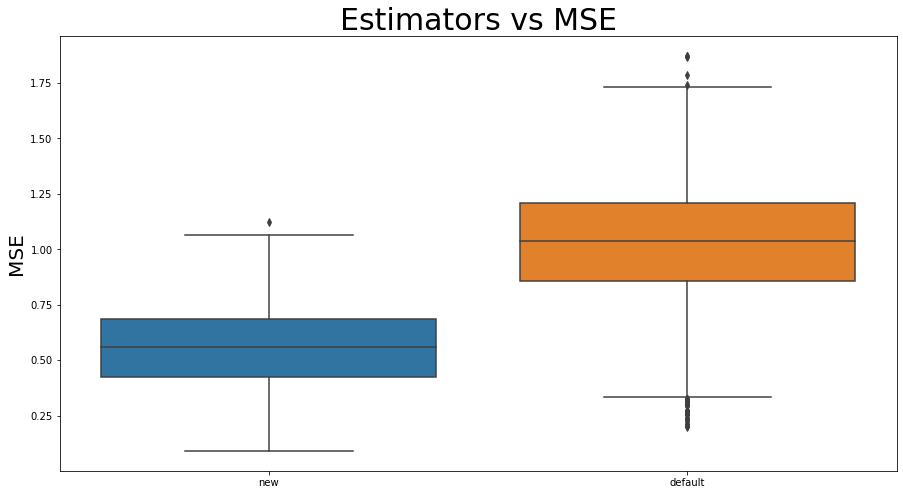

In [ ]:
KNN_params = KNN_res.best_params

models = {}
'''models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
'''
models['new'] = KNeighborsRegressor(**KNN_params)

models['default'] = KNeighborsRegressor(weights = 'uniform', n_neighbors = 3)

results = train_and_test_regressor(models, XS_train, YS_train, XS_test, YS_test)

plot_model_comparison(results)

In [ ]:
optuna.visualization.plot_param_importances(KNN_res)

In [ ]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [ ]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error'],      #add 'poisson' for width tuning
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = RandomForest

RF_res = main(X = XS_train, y = YS_train, model_name = model_name, params = RF_params, n_trials = 500)

'''with open(f'RF_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)'''

with open(f'RF_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2022-05-13 16:57:37,731] A new study created in memory with name: no-name-1187411e-6798-4377-b255-37738333fc28


Start hyperparameter optimization
{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}
{'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-05-13 16:57:40,494] Trial 0 finished with value: 1.978368546587291 and parameters: {'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 5, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:42,567] Trial 1 finished with value: 2.524633726460023 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:45,186] Trial 3 finished with value: 2.301731583914008 and parameters: {'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:47,957] Trial 4 finished with value: 2.246228911059661 and parameters: {'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:48,231] Trial 2 finished with value: 2.0666749722056936 and parameters: {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:50,709] Trial 5 finished with value: 2.2860011439159464 and parameters: {'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:57:54,220] Trial 6 finished with value: 2.4688858841147985 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.
[I 2022-05-13 16:57:54,291] Trial 7 finished with value: 3.1138323487392845 and parameters: {'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:56,878] Trial 9 finished with value: 2.3006183013510686 and parameters: {'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}


[I 2022-05-13 16:57:59,383] Trial 10 finished with value: 2.268754983537945 and parameters: {'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:00,126] Trial 8 finished with value: 2.4426706282633384 and parameters: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 0 with value: 1.978368546587291.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:02,250] Trial 11 finished with value: 1.8009006781658592 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 11 with value: 1.8009006781658592.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:05,076] Trial 13 finished with value: 1.788820836005253 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'squared_error'}. Best is trial 13 with value: 1.788820836005253.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:07,944] Trial 14 finished with value: 1.628814589541451 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:08,581] Trial 12 finished with value: 1.9218493335667333 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 14 with value: 1.628814589541451.


{'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,275] Trial 15 finished with value: 1.181194342480087 and parameters: {'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:11,964] Trial 16 finished with value: 1.2794064482403935 and parameters: {'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:14,555] Trial 17 finished with value: 1.2025569154064824 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:15,129] Trial 18 finished with value: 1.2476423811030917 and parameters: {'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:17,589] Trial 19 finished with value: 1.2705580872771405 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:18,005] Trial 20 finished with value: 1.5476339200450908 and parameters: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:20,437] Trial 21 finished with value: 1.552288622445643 and parameters: {'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:21,051] Trial 22 finished with value: 1.4013725408868936 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:23,727] Trial 23 finished with value: 1.254722941177184 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:24,399] Trial 24 finished with value: 1.2580971536256444 and parameters: {'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:26,734] Trial 25 finished with value: 1.6796934049645613 and parameters: {'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:27,303] Trial 26 finished with value: 1.6564703172252646 and parameters: {'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:29,654] Trial 27 finished with value: 1.6690930182447068 and parameters: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:30,127] Trial 28 finished with value: 2.042782132315242 and parameters: {'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:32,338] Trial 29 finished with value: 2.052274794259465 and parameters: {'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:33,127] Trial 30 finished with value: 1.2733403337798295 and parameters: {'max_depth': 49, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,285] Trial 31 finished with value: 1.465713994539609 and parameters: {'max_depth': 49, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:35,959] Trial 32 finished with value: 1.1989978132865782 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:38,430] Trial 33 finished with value: 1.4185927609951159 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:39,106] Trial 34 finished with value: 1.4021863827726155 and parameters: {'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:49,065] Trial 35 finished with value: 1.5065327054715585 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 16:58:50,440] Trial 36 finished with value: 1.1824558161707857 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:51,998] Trial 37 finished with value: 1.33482855715851 and parameters: {'max_depth': 46, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 16:58:58,554] Trial 38 finished with value: 2.0633831660938275 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:00,227] Trial 39 finished with value: 2.044466039165648 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:05,935] Trial 40 finished with value: 2.2731113348034055 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:09,972] Trial 41 finished with value: 1.7631593952074887 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 15 with value: 1.181194342480087.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:17,276] Trial 42 finished with value: 1.143880852213801 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:21,422] Trial 43 finished with value: 1.2006291837729077 and parameters: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:27,885] Trial 44 finished with value: 1.472589411505871 and parameters: {'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:31,942] Trial 45 finished with value: 1.453064232337693 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:38,596] Trial 46 finished with value: 1.511440962407839 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:43,323] Trial 47 finished with value: 1.4971755278198198 and parameters: {'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:50,507] Trial 48 finished with value: 1.2321637004235289 and parameters: {'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 16:59:55,239] Trial 49 finished with value: 1.1675067606166185 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:00,142] Trial 50 finished with value: 1.758361536648616 and parameters: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:03,678] Trial 51 finished with value: 1.9651289174718571 and parameters: {'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:11,981] Trial 52 finished with value: 1.1691314496734755 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:15,220] Trial 53 finished with value: 1.1888254362424457 and parameters: {'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:23,151] Trial 54 finished with value: 1.184641858552451 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:25,710] Trial 55 finished with value: 1.474479783571649 and parameters: {'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:31,186] Trial 56 finished with value: 1.572009376359254 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:35,761] Trial 57 finished with value: 1.4438284367543375 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:42,354] Trial 58 finished with value: 1.1585017385849004 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:47,563] Trial 59 finished with value: 1.1725085331581224 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:53,719] Trial 60 finished with value: 1.1710740664380104 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:00:56,662] Trial 61 finished with value: 1.7971376190934862 and parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:05,329] Trial 62 finished with value: 1.1583668655943993 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:08,050] Trial 63 finished with value: 1.1716227291138157 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:17,376] Trial 64 finished with value: 1.214113792018897 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:18,841] Trial 65 finished with value: 1.4717943078353313 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:27,960] Trial 66 finished with value: 1.4841146427781857 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:30,365] Trial 67 finished with value: 1.2578273409600906 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:39,611] Trial 68 finished with value: 1.294100005405967 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:41,910] Trial 69 finished with value: 1.1847217257015188 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:51,154] Trial 70 finished with value: 1.1828220082111236 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:01:52,401] Trial 71 finished with value: 1.442860853259066 and parameters: {'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:02,432] Trial 72 finished with value: 1.1703309788788012 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:03,726] Trial 73 finished with value: 1.2014480827648308 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:10,545] Trial 75 finished with value: 2.3689401380023383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:12,904] Trial 74 finished with value: 1.2339150318197385 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:22,429] Trial 76 finished with value: 1.1936657943633364 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:23,412] Trial 77 finished with value: 1.4891132829790776 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:31,947] Trial 78 finished with value: 1.657966966316288 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:34,967] Trial 79 finished with value: 1.2866260177704334 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:38,254] Trial 80 finished with value: 2.463310157133228 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:46,130] Trial 81 finished with value: 1.2368813920934305 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:49,728] Trial 82 finished with value: 1.166750064638716 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:02:52,942] Trial 83 finished with value: 2.4366908301414396 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:00,663] Trial 84 finished with value: 1.2049248172156946 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:04,632] Trial 85 finished with value: 1.1912467187261413 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 42 with value: 1.143880852213801.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:12,590] Trial 86 finished with value: 1.1329921764216486 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:14,797] Trial 87 finished with value: 1.467898442422873 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:22,483] Trial 89 finished with value: 2.1712666280783672 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:23,300] Trial 88 finished with value: 1.5274052514110992 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,149] Trial 90 finished with value: 1.1970777696157018 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:34,783] Trial 91 finished with value: 1.244115442895618 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:44,915] Trial 92 finished with value: 1.207081450285638 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:45,913] Trial 93 finished with value: 1.1489946840696157 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:03:56,575] Trial 95 finished with value: 1.505738548510688 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.
[I 2022-05-13 17:03:56,646] Trial 94 finished with value: 1.150032573166909 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:07,701] Trial 97 finished with value: 1.599711295443516 and parameters: {'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:08,104] Trial 96 finished with value: 1.1567977154133593 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:14,907] Trial 98 finished with value: 2.261164967751801 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:18,202] Trial 99 finished with value: 1.4916602203973295 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:23,462] Trial 100 finished with value: 1.5222855304770309 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:26,282] Trial 101 finished with value: 1.3178743345611637 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 86 with value: 1.1329921764216486.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:35,164] Trial 102 finished with value: 1.12694489934444 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:37,620] Trial 103 finished with value: 1.221694970742751 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:46,650] Trial 104 finished with value: 1.1711071240981952 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:49,187] Trial 105 finished with value: 1.179083296267562 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:04:57,524] Trial 106 finished with value: 1.5216183839476982 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:00,547] Trial 107 finished with value: 1.255542309209972 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:09,008] Trial 108 finished with value: 1.2372806889763683 and parameters: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:11,935] Trial 109 finished with value: 1.231602387929209 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:19,635] Trial 110 finished with value: 1.4607157696552124 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:22,178] Trial 111 finished with value: 1.5302294525467393 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:31,054] Trial 112 finished with value: 1.2230523665762285 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 102 with value: 1.12694489934444.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:33,702] Trial 113 finished with value: 1.1241521310320777 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:42,026] Trial 114 finished with value: 1.1879829803391044 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:44,614] Trial 115 finished with value: 1.1740747970436012 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:54,204] Trial 116 finished with value: 1.223940982418635 and parameters: {'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:05:56,683] Trial 117 finished with value: 1.273936773188964 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:06,212] Trial 118 finished with value: 1.1838913226212546 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:08,369] Trial 119 finished with value: 1.2626673792155443 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:17,196] Trial 120 finished with value: 1.474109743896052 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:18,907] Trial 121 finished with value: 1.514221131440808 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:28,647] Trial 122 finished with value: 1.1905583254421834 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:30,467] Trial 123 finished with value: 1.177967549656236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:37,368] Trial 124 finished with value: 1.981414715545292 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:41,640] Trial 125 finished with value: 1.171316092211143 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:48,668] Trial 126 finished with value: 1.1473131919493347 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:53,419] Trial 127 finished with value: 1.1994887798828657 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:06:59,525] Trial 128 finished with value: 1.4618446332250343 and parameters: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:04,192] Trial 129 finished with value: 1.1953180616411176 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:10,547] Trial 130 finished with value: 1.483323273335404 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:15,253] Trial 131 finished with value: 1.4894986892150013 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:22,558] Trial 132 finished with value: 1.2161180110189531 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:27,454] Trial 133 finished with value: 1.2083308368315826 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:34,568] Trial 134 finished with value: 1.1659597667291153 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:39,555] Trial 135 finished with value: 1.160984088875773 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:46,670] Trial 136 finished with value: 1.132621252492637 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:51,596] Trial 137 finished with value: 1.1854621659340958 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:07:58,787] Trial 138 finished with value: 1.1822109816173385 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:03,574] Trial 139 finished with value: 1.1589917029045154 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:10,800] Trial 140 finished with value: 1.177554904436646 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:15,547] Trial 141 finished with value: 1.1705989486736699 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:22,393] Trial 142 finished with value: 1.1853498541294623 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:27,422] Trial 143 finished with value: 1.2048907346857778 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:34,489] Trial 144 finished with value: 1.169978870314926 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:38,485] Trial 145 finished with value: 1.1811761164748593 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:45,396] Trial 146 finished with value: 1.1289490861423797 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:50,190] Trial 147 finished with value: 1.200054663600225 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:08:56,388] Trial 148 finished with value: 1.213337165110906 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}


[I 2022-05-13 17:08:59,342] Trial 150 finished with value: 1.529317758723462 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'squared_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:08:59,474] Trial 149 finished with value: 1.2390927119846897 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:11,010] Trial 151 finished with value: 1.1929792221865618 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 113 with value: 1.1241521310320777.
[I 2022-05-13 17:09:11,135] Trial 152 finished with value: 1.1134873161920606 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:22,645] Trial 154 finished with value: 1.2050186939383605 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:22,719] Trial 153 finished with value: 1.1593228998987188 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,120] Trial 155 finished with value: 1.180093831423966 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:34,493] Trial 156 finished with value: 1.1604569847833832 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:44,828] Trial 157 finished with value: 1.2372772348707801 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:45,541] Trial 158 finished with value: 1.1721230157243248 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:09:56,088] Trial 160 finished with value: 1.477285953151706 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.
[I 2022-05-13 17:09:56,113] Trial 159 finished with value: 1.2140522034408263 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:07,816] Trial 161 finished with value: 1.1923569198838977 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:08,276] Trial 162 finished with value: 1.119077707096365 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:18,626] Trial 163 finished with value: 1.1879712059630267 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:19,495] Trial 164 finished with value: 1.2452058300434277 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:30,212] Trial 165 finished with value: 1.1710318016174226 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:31,008] Trial 166 finished with value: 1.1787299888497051 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:35,886] Trial 168 finished with value: 2.5213627758250476 and parameters: {'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:41,721] Trial 167 finished with value: 1.15703327232514 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:46,997] Trial 169 finished with value: 1.3752175153074844 and parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:53,515] Trial 170 finished with value: 1.1720691673363643 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:10:57,449] Trial 171 finished with value: 1.4610939907332772 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:05,114] Trial 172 finished with value: 1.1682730543969568 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:08,940] Trial 173 finished with value: 1.1905605235753418 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:16,439] Trial 174 finished with value: 1.1779271712008301 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:19,478] Trial 175 finished with value: 1.2460556684185957 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:24,723] Trial 176 finished with value: 2.068274649184595 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:11:27,834] Trial 178 finished with value: 1.2456163478350564 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 152 with value: 1.1134873161920606.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:31,148] Trial 177 finished with value: 1.1078248602789196 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:39,797] Trial 179 finished with value: 1.1506497539919505 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:42,890] Trial 180 finished with value: 1.202041345426748 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:51,578] Trial 181 finished with value: 1.198713739352784 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:11:54,732] Trial 182 finished with value: 1.1706423644036852 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:03,552] Trial 183 finished with value: 1.172951296215865 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:06,783] Trial 184 finished with value: 1.180412389515366 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:15,422] Trial 185 finished with value: 1.1382857937030884 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:18,637] Trial 186 finished with value: 1.2602397472243891 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:27,484] Trial 187 finished with value: 1.1729345435974994 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:30,885] Trial 188 finished with value: 1.185168783225151 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:39,452] Trial 189 finished with value: 1.1424013145140555 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:42,427] Trial 190 finished with value: 1.143376658799505 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:51,203] Trial 191 finished with value: 1.2108399219702757 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:12:54,498] Trial 192 finished with value: 1.1598494334885772 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:02,776] Trial 193 finished with value: 1.187442798246762 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:06,385] Trial 194 finished with value: 1.169000991900986 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:14,602] Trial 195 finished with value: 1.2491958408027894 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:17,940] Trial 196 finished with value: 1.199159414392242 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:26,148] Trial 197 finished with value: 1.2163372209524854 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:29,796] Trial 198 finished with value: 1.1307165790834675 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:37,781] Trial 199 finished with value: 1.1212676049759296 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:40,288] Trial 200 finished with value: 1.461979400284331 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:48,068] Trial 201 finished with value: 1.5839103935521048 and parameters: {'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:52,257] Trial 202 finished with value: 1.1446064595631036 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:13:59,620] Trial 203 finished with value: 1.2094328073347698 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:04,089] Trial 204 finished with value: 1.2110570069814368 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:11,389] Trial 205 finished with value: 1.1950799522127125 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:15,723] Trial 206 finished with value: 1.158329355161334 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:22,981] Trial 207 finished with value: 1.203581502448318 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:14:26,128] Trial 209 finished with value: 1.2435943935824805 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:27,142] Trial 208 finished with value: 1.1670328244712724 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:33,478] Trial 210 finished with value: 2.2574032892943214 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:38,152] Trial 211 finished with value: 1.4910141580765452 and parameters: {'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:41,992] Trial 212 finished with value: 1.954703504141803 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:49,571] Trial 213 finished with value: 1.1709041809353546 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:14:53,379] Trial 214 finished with value: 1.2101602446139204 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:01,108] Trial 215 finished with value: 1.1806348970538973 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:04,714] Trial 216 finished with value: 1.2380918080974765 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:12,401] Trial 217 finished with value: 1.1612065443754616 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:16,204] Trial 218 finished with value: 1.1191463727887314 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:23,732] Trial 219 finished with value: 1.1882805865566344 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:27,770] Trial 220 finished with value: 1.1511736922576348 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:34,710] Trial 221 finished with value: 1.5467764993641906 and parameters: {'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:39,381] Trial 222 finished with value: 1.2062206097189831 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:45,778] Trial 223 finished with value: 1.637053844952634 and parameters: {'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:50,910] Trial 224 finished with value: 1.1968802009072559 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 177 with value: 1.1078248602789196.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:15:57,315] Trial 225 finished with value: 1.103028131397619 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:02,344] Trial 226 finished with value: 1.191127418457795 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:09,165] Trial 227 finished with value: 1.234530299319156 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:13,683] Trial 228 finished with value: 1.1777063682329987 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:20,833] Trial 229 finished with value: 1.210866009683394 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:25,427] Trial 230 finished with value: 1.1786881383700163 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:32,451] Trial 231 finished with value: 1.1959956482434682 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:36,957] Trial 232 finished with value: 1.1825549063663754 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:44,155] Trial 233 finished with value: 1.1852211041163991 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:48,148] Trial 234 finished with value: 1.1669335400195973 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:55,491] Trial 235 finished with value: 1.170925475264075 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:16:59,395] Trial 236 finished with value: 1.1594221013077501 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:06,585] Trial 237 finished with value: 1.2719641491514309 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:10,480] Trial 238 finished with value: 1.1153461238901545 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:17,772] Trial 239 finished with value: 1.1780116738544302 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:20,926] Trial 240 finished with value: 1.2243732231770044 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:28,501] Trial 241 finished with value: 1.1625119932483032 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:32,335] Trial 242 finished with value: 1.1753791942520566 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:39,388] Trial 243 finished with value: 1.2199728936097585 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:43,505] Trial 244 finished with value: 1.1380879797136763 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:50,646] Trial 245 finished with value: 1.1862385155935091 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:17:54,226] Trial 246 finished with value: 1.1609363594551931 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:17:57,026] Trial 248 finished with value: 1.240319171593791 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:01,492] Trial 247 finished with value: 1.1711331845358361 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:07,307] Trial 249 finished with value: 1.1738899565032397 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:13,083] Trial 250 finished with value: 1.157137783617969 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:18,417] Trial 251 finished with value: 1.2105293728557704 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:24,130] Trial 252 finished with value: 1.1660638022057075 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:29,757] Trial 253 finished with value: 1.2065985598873112 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:35,424] Trial 254 finished with value: 1.2039262337947254 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:41,024] Trial 255 finished with value: 1.1999996866843965 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:46,788] Trial 256 finished with value: 1.2618069736537696 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:52,479] Trial 257 finished with value: 1.1452974463366967 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:18:58,126] Trial 258 finished with value: 1.154375104830974 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:03,761] Trial 259 finished with value: 1.2545413076107557 and parameters: {'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:09,669] Trial 260 finished with value: 1.3093219604069677 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:15,155] Trial 261 finished with value: 1.241167865618889 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:20,057] Trial 262 finished with value: 1.4551474216213707 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:27,114] Trial 263 finished with value: 1.251518289187708 and parameters: {'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:31,995] Trial 264 finished with value: 1.2194066336305058 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:38,953] Trial 265 finished with value: 1.180474529402742 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:19:41,907] Trial 267 finished with value: 1.3702006887493554 and parameters: {'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:43,429] Trial 266 finished with value: 1.1517440904595984 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:50,972] Trial 269 finished with value: 2.2012820126378 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:53,427] Trial 268 finished with value: 1.1562991071724902 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:19:57,913] Trial 270 finished with value: 2.377475810684611 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:04,914] Trial 271 finished with value: 1.1191135051959908 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:09,644] Trial 272 finished with value: 1.156326199119772 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:16,180] Trial 273 finished with value: 1.1959121531616494 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:21,099] Trial 274 finished with value: 1.2473890333606206 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:27,480] Trial 275 finished with value: 1.1892808424030772 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:32,346] Trial 276 finished with value: 1.2040089255012696 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:38,619] Trial 277 finished with value: 1.1831039102308387 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:43,303] Trial 278 finished with value: 1.180991073043804 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:45,010] Trial 279 finished with value: 2.4208097908382955 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:53,662] Trial 280 finished with value: 1.435164114685236 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:20:54,912] Trial 281 finished with value: 1.4343023595604794 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:03,440] Trial 282 finished with value: 1.7627807071663337 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:06,206] Trial 283 finished with value: 1.1545629778530053 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:14,882] Trial 284 finished with value: 1.177440867283294 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:16,756] Trial 285 finished with value: 1.1760638777508539 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:21,368] Trial 286 finished with value: 2.4635000088705383 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:21:24,361] Trial 288 finished with value: 1.1821697392176513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:27,867] Trial 287 finished with value: 1.2229414330704178 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:35,773] Trial 289 finished with value: 1.226905951114108 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:39,225] Trial 290 finished with value: 1.18662267937147 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:46,523] Trial 292 finished with value: 2.30458249379243 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:21:46,601] Trial 291 finished with value: 1.2509245323328293 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:57,171] Trial 294 finished with value: 1.4737638978914676 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:21:58,052] Trial 293 finished with value: 1.209528600266012 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:08,261] Trial 295 finished with value: 1.4469951481086052 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:09,596] Trial 296 finished with value: 1.2473258775016354 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:19,544] Trial 297 finished with value: 1.1934273953963217 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:21,005] Trial 298 finished with value: 1.1989316635814296 and parameters: {'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:30,949] Trial 299 finished with value: 1.2935930565035911 and parameters: {'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:32,190] Trial 300 finished with value: 1.1925784663671652 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:41,881] Trial 301 finished with value: 1.21261758634139 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:43,616] Trial 302 finished with value: 1.1756821978609489 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,457] Trial 303 finished with value: 1.2597574178935889 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:22:53,885] Trial 304 finished with value: 1.4462936719286887 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:22:56,795] Trial 306 finished with value: 1.490769162550888 and parameters: {'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:01,968] Trial 305 finished with value: 1.9505538688259019 and parameters: {'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:08,483] Trial 307 finished with value: 1.1880265217704182 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:13,476] Trial 308 finished with value: 1.2083585999616657 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:19,926] Trial 309 finished with value: 1.1876141141735737 and parameters: {'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:24,679] Trial 310 finished with value: 1.1804717668903657 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:30,837] Trial 311 finished with value: 1.1494148279038068 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:36,299] Trial 312 finished with value: 1.1816225758767644 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:40,945] Trial 313 finished with value: 1.218201425730254 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:47,496] Trial 314 finished with value: 1.1979464978988723 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:50,300] Trial 315 finished with value: 1.175097345247784 and parameters: {'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:23:57,536] Trial 316 finished with value: 1.4487880193583647 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:01,362] Trial 317 finished with value: 1.1704202694647399 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:08,670] Trial 318 finished with value: 1.2341147953952099 and parameters: {'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:12,843] Trial 319 finished with value: 1.1305560667713046 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:20,189] Trial 320 finished with value: 1.2005824747880751 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:24,373] Trial 321 finished with value: 1.2229337782696796 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:31,531] Trial 322 finished with value: 1.1915057628547796 and parameters: {'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:35,679] Trial 323 finished with value: 1.1877534032520276 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:41,942] Trial 324 finished with value: 1.49364971271097 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:24:43,436] Trial 325 finished with value: 2.1235687217965626 and parameters: {'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:44,996] Trial 326 finished with value: 1.2793676615358962 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:54,694] Trial 327 finished with value: 1.185641082138615 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:24:56,244] Trial 328 finished with value: 1.1958275978720967 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:05,878] Trial 329 finished with value: 1.204853717161622 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:07,656] Trial 330 finished with value: 1.189296699642409 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:17,230] Trial 331 finished with value: 1.1667751720734707 and parameters: {'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:18,749] Trial 332 finished with value: 1.2037164930204065 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:28,874] Trial 333 finished with value: 1.1875775010981893 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:29,223] Trial 334 finished with value: 1.1779964263095795 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:39,154] Trial 336 finished with value: 1.6480748051778877 and parameters: {'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:40,560] Trial 335 finished with value: 1.201768056414314 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:25:50,539] Trial 337 finished with value: 1.192717683902533 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:25:50,603] Trial 338 finished with value: 1.1740793392891518 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:00,160] Trial 339 finished with value: 1.160265197141854 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:02,001] Trial 340 finished with value: 1.1660728680621133 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:11,415] Trial 341 finished with value: 1.178160406163767 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:13,040] Trial 342 finished with value: 1.193313995303436 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:22,825] Trial 343 finished with value: 1.1827258621360752 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:23,619] Trial 344 finished with value: 1.1865801798010391 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:32,931] Trial 345 finished with value: 1.4625513885296448 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:26:33,774] Trial 346 finished with value: 1.5229790105673047 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:35,921] Trial 347 finished with value: 1.262123583149154 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:45,248] Trial 348 finished with value: 1.1816127328877606 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:47,681] Trial 349 finished with value: 1.1899763323490495 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:56,220] Trial 350 finished with value: 1.1677775492546156 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:26:58,667] Trial 351 finished with value: 1.5138241509388373 and parameters: {'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:07,975] Trial 352 finished with value: 1.1879460802170954 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:10,195] Trial 353 finished with value: 1.253561278006912 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:19,807] Trial 354 finished with value: 1.1356649747817504 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:21,984] Trial 355 finished with value: 1.192239508890991 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:31,359] Trial 356 finished with value: 1.1543520108393819 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:33,844] Trial 357 finished with value: 1.1902407254222473 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:43,271] Trial 358 finished with value: 1.1604399608532543 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:45,645] Trial 359 finished with value: 1.1440975934824715 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:55,019] Trial 360 finished with value: 1.199106760639329 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:27:56,067] Trial 361 finished with value: 1.5144722125577939 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:06,281] Trial 362 finished with value: 1.2301484909431897 and parameters: {'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:07,704] Trial 363 finished with value: 1.1795149878178168 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:28:10,682] Trial 365 finished with value: 1.197897679128975 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:17,672] Trial 364 finished with value: 1.1832851391855077 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:22,489] Trial 366 finished with value: 1.153505781853255 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:29,158] Trial 367 finished with value: 1.251821486763832 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:34,031] Trial 368 finished with value: 1.1316498788726874 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:40,652] Trial 369 finished with value: 1.1951120697470934 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:45,445] Trial 370 finished with value: 1.1973409866352231 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:52,428] Trial 371 finished with value: 1.181638725605285 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:28:55,750] Trial 372 finished with value: 1.4448723209861272 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:03,086] Trial 373 finished with value: 1.5644123413331203 and parameters: {'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:07,359] Trial 374 finished with value: 1.1878812910897525 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:14,462] Trial 375 finished with value: 1.2253928568065342 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:18,532] Trial 376 finished with value: 1.1787432174216443 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:26,034] Trial 377 finished with value: 1.1943939811426376 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:29,985] Trial 378 finished with value: 1.2128230888412068 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:37,177] Trial 379 finished with value: 1.20688908051913 and parameters: {'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:41,455] Trial 380 finished with value: 1.1857217596939233 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:48,653] Trial 381 finished with value: 1.1786787418737295 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:52,885] Trial 382 finished with value: 1.1933356334092629 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:29:59,947] Trial 383 finished with value: 1.2623119198600588 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}


[I 2022-05-13 17:30:02,950] Trial 385 finished with value: 1.6884972168051138 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.
[I 2022-05-13 17:30:03,106] Trial 384 finished with value: 1.5067569810501564 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}
{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:13,490] Trial 386 finished with value: 1.4227724250334997 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:14,499] Trial 387 finished with value: 1.2022624562986557 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:21,218] Trial 388 finished with value: 2.1249480647471026 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 6, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:25,460] Trial 389 finished with value: 1.211777180057242 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:27,964] Trial 390 finished with value: 1.4753530183428265 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:36,558] Trial 391 finished with value: 1.3781186861627313 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:38,996] Trial 392 finished with value: 1.4254001519470418 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:43,411] Trial 393 finished with value: 2.3337252802838515 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:50,366] Trial 394 finished with value: 1.1872276480598727 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:30:55,139] Trial 395 finished with value: 1.1873697720168186 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:01,790] Trial 396 finished with value: 1.275346793746476 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:06,558] Trial 397 finished with value: 1.3067997287184032 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:13,400] Trial 398 finished with value: 1.217292075734614 and parameters: {'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:17,888] Trial 399 finished with value: 1.1371882501352102 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:24,952] Trial 400 finished with value: 1.209095124227062 and parameters: {'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:29,305] Trial 401 finished with value: 1.2136163031007552 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:36,652] Trial 402 finished with value: 1.1854576282324638 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:40,504] Trial 403 finished with value: 1.2441784012831438 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:31:43,381] Trial 405 finished with value: 1.147580699517016 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:47,742] Trial 404 finished with value: 1.2027746156362402 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:49,849] Trial 406 finished with value: 2.420379146743405 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:31:58,216] Trial 407 finished with value: 1.4528913535029244 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:00,603] Trial 408 finished with value: 1.4614378798599719 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:10,155] Trial 409 finished with value: 1.1857880559839535 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:12,184] Trial 410 finished with value: 1.1471472080077212 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:19,092] Trial 411 finished with value: 1.9035781682896886 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 4, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:23,803] Trial 412 finished with value: 1.1139391889584007 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:30,746] Trial 413 finished with value: 1.1806296002772605 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:35,637] Trial 414 finished with value: 1.225032509807484 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:42,155] Trial 415 finished with value: 1.165412739428246 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:43,958] Trial 416 finished with value: 2.077221528085837 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 5, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:53,379] Trial 417 finished with value: 1.181026452350457 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:32:55,394] Trial 418 finished with value: 1.145558170991512 and parameters: {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:05,046] Trial 419 finished with value: 1.1862444716630645 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:06,253] Trial 420 finished with value: 1.4815794122566863 and parameters: {'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:16,573] Trial 421 finished with value: 1.1600518706847947 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:17,274] Trial 422 finished with value: 1.1749555875003121 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:33:20,224] Trial 424 finished with value: 1.169743924670645 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:27,819] Trial 423 finished with value: 1.1804293599129607 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:30,396] Trial 425 finished with value: 1.4872705438153522 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:39,717] Trial 426 finished with value: 1.2078786534517643 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:42,175] Trial 427 finished with value: 1.2026344698126525 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:51,436] Trial 428 finished with value: 1.1904188502025195 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:33:53,500] Trial 429 finished with value: 1.1897804591743533 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:03,181] Trial 430 finished with value: 1.2381507354788037 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:04,727] Trial 431 finished with value: 1.19458169764021 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:15,108] Trial 432 finished with value: 1.23092544247288 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:16,512] Trial 433 finished with value: 1.1662947900070284 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:26,379] Trial 434 finished with value: 1.1668415112178412 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:28,203] Trial 435 finished with value: 1.1852930350578823 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:37,963] Trial 436 finished with value: 1.207410161363788 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:38,374] Trial 437 finished with value: 1.487823975770247 and parameters: {'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:48,224] Trial 438 finished with value: 1.4673422336453563 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:49,650] Trial 439 finished with value: 1.1806692814712174 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:34:59,810] Trial 440 finished with value: 1.1477544731736748 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:01,480] Trial 441 finished with value: 1.1940987798100002 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:10,683] Trial 442 finished with value: 1.6563940775265784 and parameters: {'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:12,974] Trial 443 finished with value: 1.1898507884921545 and parameters: {'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}


[I 2022-05-13 17:35:13,703] Trial 444 finished with value: 1.4934648694047448 and parameters: {'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:16,060] Trial 445 finished with value: 1.1683822463640088 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:25,517] Trial 446 finished with value: 1.1518980010334032 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:27,903] Trial 447 finished with value: 1.186047891962542 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:37,132] Trial 448 finished with value: 1.185435895609084 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:39,501] Trial 449 finished with value: 1.1784975495350005 and parameters: {'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:48,702] Trial 450 finished with value: 1.2093423127024916 and parameters: {'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:35:51,091] Trial 451 finished with value: 1.1330160084821714 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:00,213] Trial 452 finished with value: 1.1470035991278995 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:02,664] Trial 453 finished with value: 1.1553234183145775 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:10,926] Trial 454 finished with value: 1.4813238367948962 and parameters: {'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:13,191] Trial 455 finished with value: 1.4927124578836937 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:22,731] Trial 456 finished with value: 1.16414949184507 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:24,845] Trial 457 finished with value: 1.1879271389881954 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:34,297] Trial 458 finished with value: 1.213735292735305 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:36,267] Trial 459 finished with value: 1.1949092442379416 and parameters: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:45,212] Trial 460 finished with value: 1.178124282075343 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:48,027] Trial 461 finished with value: 1.1962681497291203 and parameters: {'max_depth': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:56,659] Trial 462 finished with value: 1.1537243726462836 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:36:59,491] Trial 463 finished with value: 1.2114487068438264 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:07,897] Trial 464 finished with value: 1.1425876109217523 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:10,807] Trial 465 finished with value: 1.1609051504966195 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:19,346] Trial 466 finished with value: 1.1468823432131638 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 225 with value: 1.103028131397619.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:21,901] Trial 467 finished with value: 1.0956920694031769 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:30,479] Trial 468 finished with value: 1.1285914605688783 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:33,109] Trial 469 finished with value: 1.143212701499776 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:41,641] Trial 470 finished with value: 1.178571468434348 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:44,307] Trial 471 finished with value: 1.2729830156125765 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:52,964] Trial 472 finished with value: 1.2160798014448368 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:37:55,450] Trial 473 finished with value: 1.1884895214268503 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:04,240] Trial 474 finished with value: 1.1678661692161447 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:06,954] Trial 475 finished with value: 1.117026009054512 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:15,029] Trial 476 finished with value: 1.168480708284078 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:16,323] Trial 477 finished with value: 1.7634891172771923 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:25,067] Trial 478 finished with value: 1.4007115804155674 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:26,764] Trial 479 finished with value: 1.5275694772246204 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:36,263] Trial 480 finished with value: 1.1521136718252518 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:37,673] Trial 481 finished with value: 1.1525895143415514 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}


[I 2022-05-13 17:38:40,331] Trial 483 finished with value: 2.156694987848099 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'squared_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:43,274] Trial 482 finished with value: 2.24714338344459 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:50,838] Trial 484 finished with value: 1.1998012293248401 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:53,603] Trial 485 finished with value: 1.22926720505713 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}


[I 2022-05-13 17:38:59,840] Trial 487 finished with value: 2.401576064957743 and parameters: {'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:02,072] Trial 486 finished with value: 1.1870324042094513 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:11,006] Trial 488 finished with value: 1.1858557629550408 and parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:13,621] Trial 489 finished with value: 1.176554591641216 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:22,324] Trial 490 finished with value: 1.174666242842349 and parameters: {'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:24,454] Trial 491 finished with value: 1.134145750064165 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:33,519] Trial 492 finished with value: 1.2112604664444344 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:35,802] Trial 493 finished with value: 1.183947300960877 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:44,583] Trial 494 finished with value: 1.2145292020023537 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:46,581] Trial 495 finished with value: 1.545490531003715 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:55,125] Trial 496 finished with value: 1.160897307986683 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:39:57,339] Trial 497 finished with value: 1.2014905875137585 and parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


{'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}


[I 2022-05-13 17:40:05,426] Trial 498 finished with value: 1.6500821926088503 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.
[I 2022-05-13 17:40:06,517] Trial 499 finished with value: 1.4986086273998311 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 467 with value: 1.0956920694031769.


Best parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


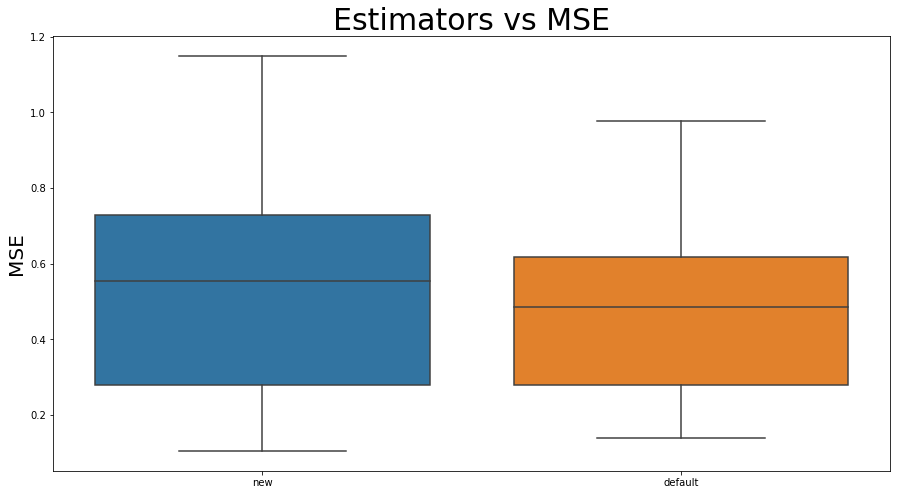

In [ ]:
RF_params = RF_res.best_params

models_RF = {}
'''models_RF['old'] = RandomForestRegressor(n_estimators = 500,
                                      max_depth = 25,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_jobs = -1)
'''
models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)

models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_RF)

In [ ]:
model = {}
for i in range(10, 201):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(path)

In [ ]:
%matplotlib inline
plot_model_comparison(path)

In [ ]:
optuna.visualization.plot_param_importances(RF_res)

## Gradient Boosting

In [ ]:
GB_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'loss' : ['squared_error', 'absolute_error', 'quantile', 'huber'],
    'learning_rate' : [0.01, 0.1],
    'min_samples_leaf' : [1, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = Gradient_Boosting

GB_res = main(X = XW_train, y = YW_train, model_name = model_name, params = GB_params, n_trials = 500)

'''with open(f'GB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)
'''
'''with open(f'GB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(GB_res.best_params, fp)'''

with open(f'GB_Scaled_optimal_parameters', 'w') as fp:
    json.dump(GB_res.best_params, fp)

[I 2022-08-17 09:01:45,218] A new study created in memory with name: no-name-aa42611f-548b-43bf-9d42-2fef58cd724f


Start hyperparameter optimization
{'n_estimators': 100, 'learning_rate': 0.014115898801217563, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 2}
{'n_estimators': 100, 'learning_rate': 0.024067435870611324, 'loss': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 5}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-08-17 09:01:45,748] Trial 1 finished with value: 1.2996137238795085 and parameters: {'learning_rate': 0.024067435870611324, 'loss': 'squared_error', 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.2996137238795085.


{'n_estimators': 100, 'learning_rate': 0.013849571083859398, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}


[I 2022-08-17 09:01:54,413] Trial 0 finished with value: 0.6317067369849496 and parameters: {'learning_rate': 0.014115898801217563, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.07931283997962023, 'loss': 'absolute_error', 'max_depth': 1, 'min_samples_leaf': 2}


[I 2022-08-17 09:02:00,145] Trial 3 finished with value: 1.1575951589868512 and parameters: {'learning_rate': 0.07931283997962023, 'loss': 'absolute_error', 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.022171926903176355, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 2}


[I 2022-08-17 09:02:36,702] Trial 4 finished with value: 2.181761184266022 and parameters: {'learning_rate': 0.022171926903176355, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.6317067369849496.


{'n_estimators': 100, 'learning_rate': 0.08657206808240872, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 7}


[I 2022-08-17 09:02:45,671] Trial 5 finished with value: 0.39167535964229483 and parameters: {'learning_rate': 0.08657206808240872, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.028097800162044856, 'loss': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 3}


[I 2022-08-17 09:03:07,624] Trial 2 finished with value: 0.6483222863714195 and parameters: {'learning_rate': 0.013849571083859398, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.07486993244226145, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 6}


[I 2022-08-17 09:03:40,513] Trial 7 finished with value: 0.4075015728036425 and parameters: {'learning_rate': 0.07486993244226145, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.017004688408452484, 'loss': 'huber', 'max_depth': 40, 'min_samples_leaf': 10}


[I 2022-08-17 09:03:47,846] Trial 6 finished with value: 0.49060797523156763 and parameters: {'learning_rate': 0.028097800162044856, 'loss': 'absolute_error', 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.045277405941393095, 'loss': 'absolute_error', 'max_depth': 39, 'min_samples_leaf': 9}


[I 2022-08-17 09:04:01,741] Trial 8 finished with value: 0.615745610751784 and parameters: {'learning_rate': 0.017004688408452484, 'loss': 'huber', 'max_depth': 40, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.04376520485319037, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 3}


[I 2022-08-17 09:04:21,669] Trial 9 finished with value: 0.47588334349323524 and parameters: {'learning_rate': 0.045277405941393095, 'loss': 'absolute_error', 'max_depth': 39, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.09971425045170469, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}


[I 2022-08-17 09:04:29,646] Trial 11 finished with value: 0.39572302996887376 and parameters: {'learning_rate': 0.09971425045170469, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.09037411271617063, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}


[I 2022-08-17 09:04:37,690] Trial 12 finished with value: 0.39657413456723545 and parameters: {'learning_rate': 0.09037411271617063, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.0984425903960507, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 8}


[I 2022-08-17 09:04:44,794] Trial 13 finished with value: 0.4032838259000588 and parameters: {'learning_rate': 0.0984425903960507, 'loss': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 5 with value: 0.39167535964229483.


{'n_estimators': 100, 'learning_rate': 0.06348952051973564, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 5}


[I 2022-08-17 09:04:51,726] Trial 10 finished with value: 0.38950779977251293 and parameters: {'learning_rate': 0.04376520485319037, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.38950779977251293.


{'n_estimators': 100, 'learning_rate': 0.052275379246869515, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:04:52,361] Trial 14 finished with value: 0.37212699874781263 and parameters: {'learning_rate': 0.06348952051973564, 'loss': 'squared_error', 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.058808748114369654, 'loss': 'quantile', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:05:11,479] Trial 15 finished with value: 1.2192420813976081 and parameters: {'learning_rate': 0.052275379246869515, 'loss': 'quantile', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.06635531890533346, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:05:15,044] Trial 16 finished with value: 1.0641726832398208 and parameters: {'learning_rate': 0.058808748114369654, 'loss': 'quantile', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.03782114383857137, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:06:08,551] Trial 18 finished with value: 0.39962826636347365 and parameters: {'learning_rate': 0.03782114383857137, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.37212699874781263.


{'n_estimators': 100, 'learning_rate': 0.06462308062005707, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}


[I 2022-08-17 09:06:12,091] Trial 17 finished with value: 0.3661189300647801 and parameters: {'learning_rate': 0.06635531890533346, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06507204940513377, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 1}


[I 2022-08-17 09:07:27,721] Trial 19 finished with value: 0.3975658084451391 and parameters: {'learning_rate': 0.06462308062005707, 'loss': 'huber', 'max_depth': 8, 'min_samples_leaf': 1}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06929056650920458, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}


[I 2022-08-17 09:07:35,627] Trial 21 finished with value: 0.3949241834199285 and parameters: {'learning_rate': 0.06929056650920458, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.049668928308511114, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:08:51,727] Trial 22 finished with value: 0.37462249865176545 and parameters: {'learning_rate': 0.049668928308511114, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.056689914696404164, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 4}


[I 2022-08-17 09:09:26,400] Trial 20 finished with value: 0.41568617530434776 and parameters: {'learning_rate': 0.06507204940513377, 'loss': 'huber', 'max_depth': 50, 'min_samples_leaf': 1}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.054658611961583, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}


[I 2022-08-17 09:10:01,786] Trial 23 finished with value: 0.3722964123052332 and parameters: {'learning_rate': 0.056689914696404164, 'loss': 'huber', 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.05739352712701232, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 5}


[I 2022-08-17 09:10:29,050] Trial 24 finished with value: 0.3702353205408076 and parameters: {'learning_rate': 0.054658611961583, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.07430312942995754, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 5}


[I 2022-08-17 09:10:54,318] Trial 25 finished with value: 0.38699645691770185 and parameters: {'learning_rate': 0.05739352712701232, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.03487995700156798, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 3}


[I 2022-08-17 09:11:14,400] Trial 26 finished with value: 0.38584106441774757 and parameters: {'learning_rate': 0.07430312942995754, 'loss': 'huber', 'max_depth': 37, 'min_samples_leaf': 5}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.03907126332417082, 'loss': 'quantile', 'max_depth': 36, 'min_samples_leaf': 3}


[I 2022-08-17 09:11:37,404] Trial 28 finished with value: 1.5739529489192041 and parameters: {'learning_rate': 0.03907126332417082, 'loss': 'quantile', 'max_depth': 36, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06416410472745902, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:11:43,696] Trial 27 finished with value: 0.431202477043778 and parameters: {'learning_rate': 0.03487995700156798, 'loss': 'absolute_error', 'max_depth': 38, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.06374912559070561, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}


[I 2022-08-17 09:11:48,400] Trial 30 finished with value: 0.3936508186767835 and parameters: {'learning_rate': 0.06374912559070561, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 6}. Best is trial 17 with value: 0.3661189300647801.


{'n_estimators': 100, 'learning_rate': 0.08173168806633004, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:53,677] Trial 31 finished with value: 0.3609546720399299 and parameters: {'learning_rate': 0.08173168806633004, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08445950457675272, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:57,911] Trial 29 finished with value: 0.40503199769681036 and parameters: {'learning_rate': 0.06416410472745902, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08286699276875062, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:58,453] Trial 32 finished with value: 0.36712028658526696 and parameters: {'learning_rate': 0.08445950457675272, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08500761907431056, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:11:59,530] Trial 33 finished with value: 0.3658193577338505 and parameters: {'learning_rate': 0.08286699276875062, 'loss': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08723885922767256, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:00,528] Trial 35 finished with value: 0.42946209415167774 and parameters: {'learning_rate': 0.08723885922767256, 'loss': 'squared_error', 'max_depth': 3, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0810966164125214, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:01,322] Trial 34 finished with value: 0.36238691394780104 and parameters: {'learning_rate': 0.08500761907431056, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08167573236356823, 'loss': 'squared_error', 'max_depth': 17, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:04,132] Trial 36 finished with value: 0.40450475537474107 and parameters: {'learning_rate': 0.0810966164125214, 'loss': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09229612085838265, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}


[I 2022-08-17 09:12:05,232] Trial 37 finished with value: 0.40953501008592097 and parameters: {'learning_rate': 0.08167573236356823, 'loss': 'squared_error', 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09284633751743576, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:05,824] Trial 38 finished with value: 0.393648075383991 and parameters: {'learning_rate': 0.09229612085838265, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07383634976607037, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:08,152] Trial 39 finished with value: 0.37453519463925883 and parameters: {'learning_rate': 0.09284633751743576, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.
[I 2022-08-17 09:12:08,245] Trial 40 finished with value: 0.36816483135064304 and parameters: {'learning_rate': 0.07383634976607037, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07425751603304565, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08453507366178813, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:10,694] Trial 41 finished with value: 0.3673514965955613 and parameters: {'learning_rate': 0.07425751603304565, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08442183390369057, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:11,022] Trial 42 finished with value: 0.36836889757200086 and parameters: {'learning_rate': 0.08453507366178813, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07866149857720398, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:13,422] Trial 43 finished with value: 0.36465312272727246 and parameters: {'learning_rate': 0.08442183390369057, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.
[I 2022-08-17 09:12:13,504] Trial 44 finished with value: 0.36749275208301163 and parameters: {'learning_rate': 0.07866149857720398, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07686360033010688, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}
{'n_estimators': 100, 'learning_rate': 0.09473576624562663, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:16,052] Trial 45 finished with value: 0.37799527052926596 and parameters: {'learning_rate': 0.07686360033010688, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0960625134104451, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:12:16,414] Trial 46 finished with value: 0.3730559117561824 and parameters: {'learning_rate': 0.09473576624562663, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0705951768447366, 'loss': 'absolute_error', 'max_depth': 17, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:21,254] Trial 47 finished with value: 0.3740062311105604 and parameters: {'learning_rate': 0.0960625134104451, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.07066678539464409, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 5}


[I 2022-08-17 09:12:42,372] Trial 49 finished with value: 0.9614604724034285 and parameters: {'learning_rate': 0.07066678539464409, 'loss': 'quantile', 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08766101167629195, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:48,787] Trial 48 finished with value: 0.40689916852629704 and parameters: {'learning_rate': 0.0705951768447366, 'loss': 'absolute_error', 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08877747306484089, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:54,369] Trial 51 finished with value: 0.36286506025375653 and parameters: {'learning_rate': 0.08877747306484089, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08832441355830187, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:12:59,804] Trial 52 finished with value: 0.36788500868974894 and parameters: {'learning_rate': 0.08832441355830187, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08360121541499735, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:13:05,267] Trial 53 finished with value: 0.3676657255073316 and parameters: {'learning_rate': 0.08360121541499735, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08972349424698156, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:13:10,773] Trial 54 finished with value: 0.36790568948353014 and parameters: {'learning_rate': 0.08972349424698156, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08042381174033277, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 6}


[I 2022-08-17 09:13:11,270] Trial 50 finished with value: 0.3828150857916716 and parameters: {'learning_rate': 0.08766101167629195, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08029927764220442, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}


[I 2022-08-17 09:13:12,993] Trial 56 finished with value: 0.40194861339601234 and parameters: {'learning_rate': 0.08029927764220442, 'loss': 'squared_error', 'max_depth': 7, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09877572476333614, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 3}


[I 2022-08-17 09:13:13,609] Trial 55 finished with value: 0.3912796051900782 and parameters: {'learning_rate': 0.08042381174033277, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 6}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09651582488114094, 'loss': 'quantile', 'max_depth': 1, 'min_samples_leaf': 10}


[I 2022-08-17 09:13:14,696] Trial 58 finished with value: 2.132510655580464 and parameters: {'learning_rate': 0.09651582488114094, 'loss': 'quantile', 'max_depth': 1, 'min_samples_leaf': 10}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.09073120060098398, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 5}


[I 2022-08-17 09:13:15,924] Trial 57 finished with value: 0.37397416755764357 and parameters: {'learning_rate': 0.09877572476333614, 'loss': 'squared_error', 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0673678711918393, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 5}


[I 2022-08-17 09:13:19,329] Trial 59 finished with value: 0.3678998185360804 and parameters: {'learning_rate': 0.09073120060098398, 'loss': 'squared_error', 'max_depth': 13, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.06799210962173474, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 7}


[I 2022-08-17 09:13:58,445] Trial 61 finished with value: 0.41602338111688414 and parameters: {'learning_rate': 0.06799210962173474, 'loss': 'huber', 'max_depth': 34, 'min_samples_leaf': 7}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08517870650523583, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:00,207] Trial 60 finished with value: 0.3789840089480817 and parameters: {'learning_rate': 0.0673678711918393, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.0850647531428992, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:02,317] Trial 62 finished with value: 0.3651817111869814 and parameters: {'learning_rate': 0.08517870650523583, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 31 with value: 0.3609546720399299.


{'n_estimators': 100, 'learning_rate': 0.08508090196810947, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:02,924] Trial 63 finished with value: 0.3594967422330223 and parameters: {'learning_rate': 0.0850647531428992, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 63 with value: 0.3594967422330223.


{'n_estimators': 100, 'learning_rate': 0.08543313405922258, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:05,033] Trial 64 finished with value: 0.35794048657716104 and parameters: {'learning_rate': 0.08508090196810947, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08593014779598339, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:05,703] Trial 65 finished with value: 0.3701384572968186 and parameters: {'learning_rate': 0.08543313405922258, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0784554284834358, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:07,814] Trial 66 finished with value: 0.36994772767156764 and parameters: {'learning_rate': 0.08593014779598339, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07631325182822193, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:08,407] Trial 67 finished with value: 0.37938232753981616 and parameters: {'learning_rate': 0.0784554284834358, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09262622580847472, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:10,460] Trial 68 finished with value: 0.3727581033667167 and parameters: {'learning_rate': 0.07631325182822193, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.011564749754260154, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:11,365] Trial 69 finished with value: 0.3754863683575777 and parameters: {'learning_rate': 0.09262622580847472, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09011471185144328, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:12,361] Trial 70 finished with value: 0.7573588053384814 and parameters: {'learning_rate': 0.011564749754260154, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08392356743588628, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:14,055] Trial 71 finished with value: 0.3707189792865976 and parameters: {'learning_rate': 0.09011471185144328, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0825963683016245, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:15,009] Trial 72 finished with value: 0.37371923729243467 and parameters: {'learning_rate': 0.08392356743588628, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08270208131428099, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:16,735] Trial 73 finished with value: 0.3643750432635482 and parameters: {'learning_rate': 0.0825963683016245, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08778391772686689, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:17,693] Trial 74 finished with value: 0.36694890912998357 and parameters: {'learning_rate': 0.08270208131428099, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0873941375224294, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:19,464] Trial 75 finished with value: 0.36690812577214016 and parameters: {'learning_rate': 0.08778391772686689, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.020178262510097564, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:20,464] Trial 76 finished with value: 0.36478598398552875 and parameters: {'learning_rate': 0.0873941375224294, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09392872751668284, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:22,583] Trial 77 finished with value: 0.4677425863542751 and parameters: {'learning_rate': 0.020178262510097564, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09367387051151568, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 5}


[I 2022-08-17 09:14:40,493] Trial 78 finished with value: 0.8442575009975689 and parameters: {'learning_rate': 0.09392872751668284, 'loss': 'quantile', 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07881737262422368, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 2}


[I 2022-08-17 09:14:42,602] Trial 79 finished with value: 0.8475567520074032 and parameters: {'learning_rate': 0.09367387051151568, 'loss': 'quantile', 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.06123615436614093, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:46,193] Trial 80 finished with value: 0.4061188492135571 and parameters: {'learning_rate': 0.07881737262422368, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08947206242383615, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:14:51,986] Trial 82 finished with value: 0.37344132016616216 and parameters: {'learning_rate': 0.08947206242383615, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08537879492736748, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:14:57,404] Trial 83 finished with value: 0.368872515347057 and parameters: {'learning_rate': 0.08537879492736748, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07652423499549653, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:02,780] Trial 84 finished with value: 0.36826707640615264 and parameters: {'learning_rate': 0.07652423499549653, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07239455517081371, 'loss': 'absolute_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:20,580] Trial 81 finished with value: 0.37607901703545343 and parameters: {'learning_rate': 0.06123615436614093, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07276710812776518, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:25,838] Trial 86 finished with value: 0.36692375227681895 and parameters: {'learning_rate': 0.07276710812776518, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08196060913454335, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:31,303] Trial 87 finished with value: 0.36676528829609184 and parameters: {'learning_rate': 0.08196060913454335, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.02824655291132565, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:36,443] Trial 88 finished with value: 0.3991791501956214 and parameters: {'learning_rate': 0.02824655291132565, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09692312387094389, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:41,598] Trial 89 finished with value: 0.3703980099137659 and parameters: {'learning_rate': 0.09692312387094389, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08680449431003287, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:41,864] Trial 85 finished with value: 0.3676224346420878 and parameters: {'learning_rate': 0.07239455517081371, 'loss': 'absolute_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09131933367891033, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:44,493] Trial 90 finished with value: 0.36575267768183767 and parameters: {'learning_rate': 0.08680449431003287, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:44,629] Trial 91 finished with value: 0.36526673791778946 and parameters: {'learning_rate': 0.09131933367891033, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08695425669124425, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.09150039357149951, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:47,252] Trial 92 finished with value: 0.36571862943001804 and parameters: {'learning_rate': 0.08695425669124425, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:47,390] Trial 93 finished with value: 0.36426436898276426 and parameters: {'learning_rate': 0.09150039357149951, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09184269924575283, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08914769127939251, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:49,927] Trial 95 finished with value: 0.3694423698917877 and parameters: {'learning_rate': 0.08914769127939251, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:15:50,088] Trial 94 finished with value: 0.36424802737369366 and parameters: {'learning_rate': 0.09184269924575283, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08172859341240366, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.09122564642526147, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:52,522] Trial 96 finished with value: 0.36593924437570413 and parameters: {'learning_rate': 0.08172859341240366, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09543042955192663, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 9}


[I 2022-08-17 09:15:52,884] Trial 97 finished with value: 0.3678216543302323 and parameters: {'learning_rate': 0.09122564642526147, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09582975040660748, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:54,864] Trial 98 finished with value: 0.3902441522953909 and parameters: {'learning_rate': 0.09543042955192663, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 9}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09922561528377083, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:15:55,591] Trial 99 finished with value: 0.3703587182167117 and parameters: {'learning_rate': 0.09582975040660748, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09827919845108272, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}


[I 2022-08-17 09:15:57,609] Trial 100 finished with value: 0.3610449257174405 and parameters: {'learning_rate': 0.09922561528377083, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09985379967397283, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:15:58,636] Trial 101 finished with value: 0.3754911397104906 and parameters: {'learning_rate': 0.09827919845108272, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09952758320515807, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:00,533] Trial 102 finished with value: 0.3636613808898369 and parameters: {'learning_rate': 0.09985379967397283, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09988829115722572, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:01,589] Trial 103 finished with value: 0.36601360332215055 and parameters: {'learning_rate': 0.09952758320515807, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09987780960207275, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:03,339] Trial 104 finished with value: 0.3695821202088537 and parameters: {'learning_rate': 0.09988829115722572, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0970587533132194, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:04,349] Trial 105 finished with value: 0.37165563944744767 and parameters: {'learning_rate': 0.09987780960207275, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09725608552145, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:06,077] Trial 106 finished with value: 0.3669384919477867 and parameters: {'learning_rate': 0.0970587533132194, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09256467781976357, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:07,229] Trial 107 finished with value: 0.3611411037680194 and parameters: {'learning_rate': 0.09725608552145, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09237852326165637, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}


[I 2022-08-17 09:16:08,901] Trial 108 finished with value: 0.36662821460114153 and parameters: {'learning_rate': 0.09256467781976357, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09792050277216299, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 6}


[I 2022-08-17 09:16:10,214] Trial 109 finished with value: 0.37617398105495825 and parameters: {'learning_rate': 0.09237852326165637, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09376388182688271, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 6}


[I 2022-08-17 09:16:11,511] Trial 110 finished with value: 0.38701836143155177 and parameters: {'learning_rate': 0.09792050277216299, 'loss': 'squared_error', 'max_depth': 36, 'min_samples_leaf': 6}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0945849964769225, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:12,832] Trial 111 finished with value: 0.3796648652586507 and parameters: {'learning_rate': 0.09376388182688271, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 6}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09509276712398464, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:14,346] Trial 112 finished with value: 0.3674959087170513 and parameters: {'learning_rate': 0.0945849964769225, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08880425848950353, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:15,694] Trial 113 finished with value: 0.3669922079101276 and parameters: {'learning_rate': 0.09509276712398464, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08868186270274821, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:17,108] Trial 114 finished with value: 0.36551262838344734 and parameters: {'learning_rate': 0.08880425848950353, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08362867574278225, 'loss': 'quantile', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:19,608] Trial 115 finished with value: 0.36079701255239066 and parameters: {'learning_rate': 0.08868186270274821, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09108632262196323, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:38,935] Trial 116 finished with value: 0.8928399966837273 and parameters: {'learning_rate': 0.08362867574278225, 'loss': 'quantile', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0908129027466919, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:16:41,824] Trial 117 finished with value: 0.8263577718378308 and parameters: {'learning_rate': 0.09108632262196323, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09715124813559871, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:16:44,538] Trial 118 finished with value: 0.3735746520005237 and parameters: {'learning_rate': 0.0908129027466919, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.047144809200999664, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:16:49,247] Trial 120 finished with value: 0.3728839557714094 and parameters: {'learning_rate': 0.047144809200999664, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08851187226025548, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 09:17:15,468] Trial 119 finished with value: 0.4078870712308727 and parameters: {'learning_rate': 0.09715124813559871, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08534226788235469, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:20,755] Trial 122 finished with value: 0.36760358584869585 and parameters: {'learning_rate': 0.08534226788235469, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08011230298932767, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:22,790] Trial 121 finished with value: 0.3920043743513892 and parameters: {'learning_rate': 0.08851187226025548, 'loss': 'absolute_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08368489036819239, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:24,435] Trial 123 finished with value: 0.36568298328622867 and parameters: {'learning_rate': 0.08011230298932767, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08365550319750942, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:25,493] Trial 124 finished with value: 0.370996254776233 and parameters: {'learning_rate': 0.08368489036819239, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07791988714716926, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:17:27,163] Trial 125 finished with value: 0.3644573277453183 and parameters: {'learning_rate': 0.08365550319750942, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07755229958038902, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:17:28,168] Trial 126 finished with value: 0.3787241101185062 and parameters: {'learning_rate': 0.07791988714716926, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08666047726857742, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:17:33,320] Trial 127 finished with value: 0.37819054920447837 and parameters: {'learning_rate': 0.07755229958038902, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08150423644446868, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:18:27,190] Trial 128 finished with value: 0.36035794401394894 and parameters: {'learning_rate': 0.08666047726857742, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08923896910510747, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:18:36,014] Trial 129 finished with value: 0.3659534710319753 and parameters: {'learning_rate': 0.08150423644446868, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08629687816797046, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:19:29,755] Trial 130 finished with value: 0.3629314073136932 and parameters: {'learning_rate': 0.08923896910510747, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08738634536262348, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:19:36,118] Trial 131 finished with value: 0.3664425275105748 and parameters: {'learning_rate': 0.08629687816797046, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08985959870785788, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:20:32,211] Trial 132 finished with value: 0.3662671316989224 and parameters: {'learning_rate': 0.08738634536262348, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08960355099443654, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:20:39,764] Trial 133 finished with value: 0.36754662058044285 and parameters: {'learning_rate': 0.08985959870785788, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0937991751655827, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:21:34,801] Trial 134 finished with value: 0.37027291987826116 and parameters: {'learning_rate': 0.08960355099443654, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09297713051334075, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:21:41,739] Trial 135 finished with value: 0.36640404470791793 and parameters: {'learning_rate': 0.0937991751655827, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09157919955063985, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:22:32,366] Trial 136 finished with value: 0.3708435107785161 and parameters: {'learning_rate': 0.09297713051334075, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09589155579543873, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:22:34,438] Trial 137 finished with value: 0.37956837550259304 and parameters: {'learning_rate': 0.09157919955063985, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09537111854480457, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:23:26,677] Trial 138 finished with value: 0.3877775178047985 and parameters: {'learning_rate': 0.09589155579543873, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08553447038205991, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 09:23:34,779] Trial 140 finished with value: 0.37874286942103286 and parameters: {'learning_rate': 0.08553447038205991, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07992875830680604, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:37,627] Trial 139 finished with value: 0.3704765637956722 and parameters: {'learning_rate': 0.09537111854480457, 'loss': 'huber', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07975727575809008, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:39,207] Trial 141 finished with value: 0.36314951793219347 and parameters: {'learning_rate': 0.07992875830680604, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08024208777896145, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:40,263] Trial 142 finished with value: 0.36625332926221005 and parameters: {'learning_rate': 0.07975727575809008, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08235032818133464, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:41,853] Trial 143 finished with value: 0.3676705602823637 and parameters: {'learning_rate': 0.08024208777896145, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08722638047674242, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:42,962] Trial 144 finished with value: 0.3650526164440338 and parameters: {'learning_rate': 0.08235032818133464, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08791372382799616, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:44,599] Trial 145 finished with value: 0.3649798540497341 and parameters: {'learning_rate': 0.08722638047674242, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07540471718490875, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:45,712] Trial 146 finished with value: 0.3677079735909755 and parameters: {'learning_rate': 0.08791372382799616, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0847768544157126, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 7}


[I 2022-08-17 09:23:47,225] Trial 147 finished with value: 0.3627123700101045 and parameters: {'learning_rate': 0.07540471718490875, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09823085638646177, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 7}


[I 2022-08-17 09:23:48,133] Trial 148 finished with value: 0.3933806733784974 and parameters: {'learning_rate': 0.0847768544157126, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 7}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09735471094792728, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:23:49,790] Trial 149 finished with value: 0.3933188660468504 and parameters: {'learning_rate': 0.09823085638646177, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08980586687829012, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:23:50,862] Trial 150 finished with value: 0.3696420315680289 and parameters: {'learning_rate': 0.09735471094792728, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0814536777521081, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:52,395] Trial 151 finished with value: 0.36630044429124214 and parameters: {'learning_rate': 0.08980586687829012, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07482233579258031, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:53,523] Trial 152 finished with value: 0.36096560553019247 and parameters: {'learning_rate': 0.0814536777521081, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07622722720415162, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:54,951] Trial 153 finished with value: 0.3660544335832154 and parameters: {'learning_rate': 0.07482233579258031, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07630267321609382, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:56,174] Trial 154 finished with value: 0.3647200094854301 and parameters: {'learning_rate': 0.07622722720415162, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08556403632809612, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:57,557] Trial 155 finished with value: 0.36543747460833614 and parameters: {'learning_rate': 0.07630267321609382, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08596102626245401, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:23:58,916] Trial 156 finished with value: 0.36818747623012016 and parameters: {'learning_rate': 0.08556403632809612, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08115251874119304, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:01,380] Trial 157 finished with value: 0.3648158047365594 and parameters: {'learning_rate': 0.08596102626245401, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08191647279178076, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:02,745] Trial 158 finished with value: 0.3721933530841936 and parameters: {'learning_rate': 0.08115251874119304, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09197491616280087, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:04,192] Trial 159 finished with value: 0.36218869904691775 and parameters: {'learning_rate': 0.08191647279178076, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08272464789738164, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 1}


[I 2022-08-17 09:24:05,565] Trial 160 finished with value: 0.36102071449228224 and parameters: {'learning_rate': 0.09197491616280087, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07875828511784673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:06,920] Trial 161 finished with value: 0.43356248155305244 and parameters: {'learning_rate': 0.08272464789738164, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07971000856341975, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:08,213] Trial 162 finished with value: 0.363958088559242 and parameters: {'learning_rate': 0.07875828511784673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07890120969152978, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:09,566] Trial 163 finished with value: 0.36826968915654523 and parameters: {'learning_rate': 0.07971000856341975, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07804347334799812, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:10,866] Trial 164 finished with value: 0.3671778983281294 and parameters: {'learning_rate': 0.07890120969152978, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08427153581258676, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:12,199] Trial 165 finished with value: 0.36441993069449374 and parameters: {'learning_rate': 0.07804347334799812, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08325529640184028, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:24:13,630] Trial 166 finished with value: 0.3657388116657577 and parameters: {'learning_rate': 0.08427153581258676, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08255798180381999, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:24:16,217] Trial 167 finished with value: 0.37463194897548413 and parameters: {'learning_rate': 0.08325529640184028, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08076285164365596, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:24:52,604] Trial 168 finished with value: 0.8662931438265076 and parameters: {'learning_rate': 0.08255798180381999, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08835995957925906, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:07,484] Trial 169 finished with value: 0.3666168316582984 and parameters: {'learning_rate': 0.08076285164365596, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07130293218251467, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:14,516] Trial 171 finished with value: 0.3659391573523911 and parameters: {'learning_rate': 0.07130293218251467, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08791293841586471, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:21,778] Trial 172 finished with value: 0.3656264248503753 and parameters: {'learning_rate': 0.08791293841586471, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.05266094339329806, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:28,542] Trial 173 finished with value: 0.3720852144059947 and parameters: {'learning_rate': 0.05266094339329806, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08861594292824332, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:33,269] Trial 170 finished with value: 0.3664605320057754 and parameters: {'learning_rate': 0.08835995957925906, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.041757771121196746, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:34,371] Trial 174 finished with value: 0.36379092570764715 and parameters: {'learning_rate': 0.08861594292824332, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08646470603249318, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:35,335] Trial 175 finished with value: 0.37412985814257677 and parameters: {'learning_rate': 0.041757771121196746, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0861202990729882, 'loss': 'absolute_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:25:38,834] Trial 176 finished with value: 0.360004172041594 and parameters: {'learning_rate': 0.08646470603249318, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08678856396014109, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:26:19,329] Trial 177 finished with value: 0.3825361123848488 and parameters: {'learning_rate': 0.0861202990729882, 'loss': 'absolute_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.
[I 2022-08-17 09:26:19,434] Trial 178 finished with value: 0.39915648689503325 and parameters: {'learning_rate': 0.08678856396014109, 'loss': 'absolute_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08943684422822035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}
{'n_estimators': 100, 'learning_rate': 0.08967144319425455, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 8}


[I 2022-08-17 09:26:21,807] Trial 180 finished with value: 0.3993014211078215 and parameters: {'learning_rate': 0.08967144319425455, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 8}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08407240205234874, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:22,072] Trial 179 finished with value: 0.3698604105714567 and parameters: {'learning_rate': 0.08943684422822035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0998975389311368, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:25,654] Trial 181 finished with value: 0.3696931359172659 and parameters: {'learning_rate': 0.08407240205234874, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08133047717220879, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:26,157] Trial 182 finished with value: 0.36319327032526616 and parameters: {'learning_rate': 0.0998975389311368, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0970178236084296, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:28,330] Trial 183 finished with value: 0.35986007491311406 and parameters: {'learning_rate': 0.08133047717220879, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09890536946745858, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:29,058] Trial 184 finished with value: 0.36560684352608275 and parameters: {'learning_rate': 0.0970178236084296, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09894302069205808, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:31,217] Trial 185 finished with value: 0.36327993866713004 and parameters: {'learning_rate': 0.09890536946745858, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08157368781333692, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:31,957] Trial 186 finished with value: 0.36372449384084293 and parameters: {'learning_rate': 0.09894302069205808, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09449297611805982, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:33,898] Trial 187 finished with value: 0.3646931176180672 and parameters: {'learning_rate': 0.08157368781333692, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09416178790585153, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:34,805] Trial 188 finished with value: 0.3654848166722835 and parameters: {'learning_rate': 0.09449297611805982, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08397018377988666, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:26:36,721] Trial 189 finished with value: 0.365628090297498 and parameters: {'learning_rate': 0.09416178790585153, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08507189261020055, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:37,567] Trial 190 finished with value: 0.3746293822331914 and parameters: {'learning_rate': 0.08397018377988666, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09941113493325549, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:39,436] Trial 191 finished with value: 0.3632004738643838 and parameters: {'learning_rate': 0.08507189261020055, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08542250815587807, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:40,499] Trial 192 finished with value: 0.36347251594889507 and parameters: {'learning_rate': 0.09941113493325549, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08542321384196994, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:42,194] Trial 193 finished with value: 0.3706717705417968 and parameters: {'learning_rate': 0.08542250815587807, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08164332154681911, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:43,190] Trial 194 finished with value: 0.37138727210244826 and parameters: {'learning_rate': 0.08542321384196994, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08181251460567786, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:44,822] Trial 195 finished with value: 0.3646564538915366 and parameters: {'learning_rate': 0.08164332154681911, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08698700575280847, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:45,897] Trial 196 finished with value: 0.3632499959694892 and parameters: {'learning_rate': 0.08181251460567786, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08291620102226238, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:26:50,426] Trial 197 finished with value: 0.3607011875406656 and parameters: {'learning_rate': 0.08698700575280847, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08632406683798191, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:45,066] Trial 198 finished with value: 0.3697817466749335 and parameters: {'learning_rate': 0.08291620102226238, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08704136718667962, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:48,936] Trial 199 finished with value: 0.36359974284824365 and parameters: {'learning_rate': 0.08632406683798191, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08739668426849707, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:50,259] Trial 200 finished with value: 0.3627215759020895 and parameters: {'learning_rate': 0.08704136718667962, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0871873985388197, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:51,698] Trial 201 finished with value: 0.3667861334002904 and parameters: {'learning_rate': 0.08739668426849707, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0843727543135678, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:52,991] Trial 202 finished with value: 0.36673993034763774 and parameters: {'learning_rate': 0.0871873985388197, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09118138882153252, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:54,395] Trial 203 finished with value: 0.36335033132745614 and parameters: {'learning_rate': 0.0843727543135678, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08969332276935166, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:55,756] Trial 204 finished with value: 0.3671078469462723 and parameters: {'learning_rate': 0.09118138882153252, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08903044552226175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:57,158] Trial 205 finished with value: 0.3650198595565052 and parameters: {'learning_rate': 0.08969332276935166, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08447905053349276, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:58,551] Trial 206 finished with value: 0.3648372656464587 and parameters: {'learning_rate': 0.08903044552226175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08397888828904537, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:27:59,842] Trial 207 finished with value: 0.368463743955748 and parameters: {'learning_rate': 0.08447905053349276, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08015719385042776, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:28:01,224] Trial 208 finished with value: 0.36641530340135586 and parameters: {'learning_rate': 0.08397888828904537, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08004105801976456, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:28:03,456] Trial 209 finished with value: 0.36642040815418037 and parameters: {'learning_rate': 0.08015719385042776, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.09201752353134106, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:20,512] Trial 210 finished with value: 0.9089553087014289 and parameters: {'learning_rate': 0.08004105801976456, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0818272988878737, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:24,668] Trial 211 finished with value: 0.8426936716666468 and parameters: {'learning_rate': 0.09201752353134106, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08285163618908704, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:25,168] Trial 212 finished with value: 0.363229129175613 and parameters: {'learning_rate': 0.0818272988878737, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08621898263852842, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:27,400] Trial 213 finished with value: 0.3675042123202325 and parameters: {'learning_rate': 0.08285163618908704, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08628966362423034, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:27,895] Trial 214 finished with value: 0.3669493252887213 and parameters: {'learning_rate': 0.08621898263852842, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08747724810035375, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:30,173] Trial 215 finished with value: 0.364968878836084 and parameters: {'learning_rate': 0.08628966362423034, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08827196775746404, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 3}


[I 2022-08-17 09:28:30,682] Trial 216 finished with value: 0.3649908640814453 and parameters: {'learning_rate': 0.08747724810035375, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08313976828696541, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:33,067] Trial 217 finished with value: 0.37573285882935803 and parameters: {'learning_rate': 0.08827196775746404, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0816269361058914, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:33,450] Trial 218 finished with value: 0.3664484898943139 and parameters: {'learning_rate': 0.08313976828696541, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0810127793095757, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:35,747] Trial 219 finished with value: 0.36795578186932193 and parameters: {'learning_rate': 0.0816269361058914, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07883569690147348, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:36,125] Trial 220 finished with value: 0.3678170045680062 and parameters: {'learning_rate': 0.0810127793095757, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.0781320501413688, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:38,398] Trial 221 finished with value: 0.3632821669490601 and parameters: {'learning_rate': 0.07883569690147348, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.03382244370955571, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:38,776] Trial 222 finished with value: 0.3660235605439744 and parameters: {'learning_rate': 0.0781320501413688, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08461970240706257, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:40,477] Trial 223 finished with value: 0.38433447345212085 and parameters: {'learning_rate': 0.03382244370955571, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08456530580902939, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:41,508] Trial 224 finished with value: 0.3662797487312935 and parameters: {'learning_rate': 0.08461970240706257, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08080882065875683, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:43,206] Trial 225 finished with value: 0.37134064433980307 and parameters: {'learning_rate': 0.08456530580902939, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08199770925729231, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:44,166] Trial 226 finished with value: 0.3693994225865706 and parameters: {'learning_rate': 0.08080882065875683, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08228498995491888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:46,072] Trial 227 finished with value: 0.35861302846368803 and parameters: {'learning_rate': 0.08199770925729231, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08298061097255771, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:28:47,770] Trial 228 finished with value: 0.36486408107648566 and parameters: {'learning_rate': 0.08228498995491888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08615526509637698, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:49,118] Trial 229 finished with value: 0.36717478494330447 and parameters: {'learning_rate': 0.08298061097255771, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.07608835072904402, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:50,787] Trial 230 finished with value: 0.36999819005645035 and parameters: {'learning_rate': 0.08615526509637698, 'loss': 'huber', 'max_depth': 33, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08173608307098021, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:52,766] Trial 231 finished with value: 0.3675055283609406 and parameters: {'learning_rate': 0.07608835072904402, 'loss': 'squared_error', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08140382161368254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:53,501] Trial 232 finished with value: 0.36313291435460954 and parameters: {'learning_rate': 0.08173608307098021, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08522506837143366, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:55,432] Trial 233 finished with value: 0.36406951304683716 and parameters: {'learning_rate': 0.08140382161368254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:56,252] Trial 234 finished with value: 0.3641946297719726 and parameters: {'learning_rate': 0.08522506837143366, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 64 with value: 0.35794048657716104.


{'n_estimators': 100, 'learning_rate': 0.08819279117900644, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:58,150] Trial 235 finished with value: 0.35731874137253483 and parameters: {'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08891446390328725, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 4}


[I 2022-08-17 09:29:59,020] Trial 236 finished with value: 0.36894029090252906 and parameters: {'learning_rate': 0.08819279117900644, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08666266019989755, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:00,967] Trial 237 finished with value: 0.3664889709609459 and parameters: {'learning_rate': 0.08891446390328725, 'loss': 'squared_error', 'max_depth': 50, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06179821592136879, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:01,829] Trial 238 finished with value: 0.3635555498348143 and parameters: {'learning_rate': 0.08666266019989755, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09045387552616357, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:03,293] Trial 239 finished with value: 0.3720526052237787 and parameters: {'learning_rate': 0.06179821592136879, 'loss': 'squared_error', 'max_depth': 39, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09097258503202955, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:04,657] Trial 240 finished with value: 0.36688480726894557 and parameters: {'learning_rate': 0.09045387552616357, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08373828421009206, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:06,065] Trial 241 finished with value: 0.36454730849882416 and parameters: {'learning_rate': 0.09097258503202955, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08370103124723713, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:07,420] Trial 242 finished with value: 0.36809541594794404 and parameters: {'learning_rate': 0.08373828421009206, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07994190338887784, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:08,747] Trial 243 finished with value: 0.3699365533097183 and parameters: {'learning_rate': 0.08370103124723713, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07975470709740749, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:10,075] Trial 244 finished with value: 0.3714156919517629 and parameters: {'learning_rate': 0.07994190338887784, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08549434447163144, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:11,422] Trial 245 finished with value: 0.36646844188762373 and parameters: {'learning_rate': 0.07975470709740749, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08555314150026441, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:12,832] Trial 246 finished with value: 0.37001733108238266 and parameters: {'learning_rate': 0.08549434447163144, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08735172582636572, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:14,147] Trial 247 finished with value: 0.3706329918501895 and parameters: {'learning_rate': 0.08555314150026441, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08237231534945602, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:15,568] Trial 248 finished with value: 0.3644712717314357 and parameters: {'learning_rate': 0.08735172582636572, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08193874114993825, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:16,873] Trial 249 finished with value: 0.3667763192629231 and parameters: {'learning_rate': 0.08237231534945602, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09638787645716203, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:30:19,540] Trial 250 finished with value: 0.36322020953134987 and parameters: {'learning_rate': 0.08193874114993825, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08425943959642712, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:03,552] Trial 251 finished with value: 0.3761821772825183 and parameters: {'learning_rate': 0.09638787645716203, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0849440090533955, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:31:05,662] Trial 252 finished with value: 0.36791593304151526 and parameters: {'learning_rate': 0.08425943959642712, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07790638577738278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:31:07,422] Trial 253 finished with value: 0.37859079265990053 and parameters: {'learning_rate': 0.0849440090533955, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08785615376422734, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:08,360] Trial 254 finished with value: 0.37668979350613957 and parameters: {'learning_rate': 0.07790638577738278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08764166554130226, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:10,753] Trial 255 finished with value: 0.36784531944147403 and parameters: {'learning_rate': 0.08785615376422734, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09299652741427177, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:13,392] Trial 256 finished with value: 0.3623663717022957 and parameters: {'learning_rate': 0.08764166554130226, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08884828388663611, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:45,863] Trial 258 finished with value: 0.3733319129155145 and parameters: {'learning_rate': 0.08884828388663611, 'loss': 'huber', 'max_depth': 9, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08661386249785905, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:48,500] Trial 257 finished with value: 0.3699127454425418 and parameters: {'learning_rate': 0.09299652741427177, 'loss': 'huber', 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08691680255195469, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:50,210] Trial 259 finished with value: 0.3638371130890723 and parameters: {'learning_rate': 0.08661386249785905, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0999432146445343, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:51,241] Trial 260 finished with value: 0.36751922191265274 and parameters: {'learning_rate': 0.08691680255195469, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08826645072725417, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:53,117] Trial 261 finished with value: 0.36475810125887065 and parameters: {'learning_rate': 0.0999432146445343, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0901759597292185, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:53,984] Trial 262 finished with value: 0.36864431065745107 and parameters: {'learning_rate': 0.08826645072725417, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09000478090682998, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}


[I 2022-08-17 09:31:55,757] Trial 263 finished with value: 0.3702402810998088 and parameters: {'learning_rate': 0.0901759597292185, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08404072857902029, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:56,598] Trial 264 finished with value: 0.3695132401962192 and parameters: {'learning_rate': 0.09000478090682998, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08369062685099235, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:58,438] Trial 265 finished with value: 0.3665821893124739 and parameters: {'learning_rate': 0.08404072857902029, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09779086471658197, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:31:59,314] Trial 266 finished with value: 0.36817497966201784 and parameters: {'learning_rate': 0.08369062685099235, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09744203432796217, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:01,384] Trial 267 finished with value: 0.3676908198934816 and parameters: {'learning_rate': 0.09779086471658197, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08614254198570209, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:02,196] Trial 268 finished with value: 0.36703650525255027 and parameters: {'learning_rate': 0.09744203432796217, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0861077500360045, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:32:04,174] Trial 269 finished with value: 0.36350820369354525 and parameters: {'learning_rate': 0.08614254198570209, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08782340552704758, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:04,779] Trial 270 finished with value: 0.3859996760256541 and parameters: {'learning_rate': 0.0861077500360045, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0916013600688746, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:32:06,941] Trial 271 finished with value: 0.3674352454544293 and parameters: {'learning_rate': 0.08782340552704758, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09126360041676698, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 3}


[I 2022-08-17 09:32:08,833] Trial 272 finished with value: 0.37410126663769405 and parameters: {'learning_rate': 0.0916013600688746, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08306636242047738, 'loss': 'quantile', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:32:48,224] Trial 274 finished with value: 0.8659503750540315 and parameters: {'learning_rate': 0.08306636242047738, 'loss': 'quantile', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0801174724209547, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:09,092] Trial 273 finished with value: 0.3776789969773753 and parameters: {'learning_rate': 0.09126360041676698, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0799427040184254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:16,423] Trial 276 finished with value: 0.3686972349489265 and parameters: {'learning_rate': 0.0799427040184254, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09530689686090535, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:24,465] Trial 277 finished with value: 0.3655572552375821 and parameters: {'learning_rate': 0.09530689686090535, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08509787008799365, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:30,876] Trial 275 finished with value: 0.36378645956347333 and parameters: {'learning_rate': 0.0801174724209547, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0848493402197982, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:31,342] Trial 278 finished with value: 0.3624314780122728 and parameters: {'learning_rate': 0.08509787008799365, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.076847733532002, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:34,795] Trial 279 finished with value: 0.36511884663555644 and parameters: {'learning_rate': 0.0848493402197982, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07377823526780622, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 10}


[I 2022-08-17 09:33:35,097] Trial 280 finished with value: 0.3683984768448762 and parameters: {'learning_rate': 0.076847733532002, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.05635709815223471, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 5}


[I 2022-08-17 09:33:36,932] Trial 281 finished with value: 0.40176035620330397 and parameters: {'learning_rate': 0.07377823526780622, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08860211501839704, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 09:33:37,279] Trial 282 finished with value: 0.3705911285423558 and parameters: {'learning_rate': 0.05635709815223471, 'loss': 'squared_error', 'max_depth': 35, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09307573200750902, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:39,567] Trial 283 finished with value: 0.3679987870831757 and parameters: {'learning_rate': 0.08860211501839704, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08301678315228132, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:40,156] Trial 284 finished with value: 0.36550103333947703 and parameters: {'learning_rate': 0.09307573200750902, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08232712332608677, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:42,318] Trial 285 finished with value: 0.36390762037300933 and parameters: {'learning_rate': 0.08301678315228132, 'loss': 'squared_error', 'max_depth': 42, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08148775461208477, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:42,888] Trial 286 finished with value: 0.36764598056106246 and parameters: {'learning_rate': 0.08232712332608677, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:33:43,110] Trial 287 finished with value: 0.548774045484641 and parameters: {'learning_rate': 0.08148775461208477, 'loss': 'squared_error', 'max_depth': 2, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08712208054993104, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08728478647124017, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:45,635] Trial 288 finished with value: 0.3655913924264248 and parameters: {'learning_rate': 0.08712208054993104, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:33:45,864] Trial 289 finished with value: 0.36436676111628236 and parameters: {'learning_rate': 0.08728478647124017, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0891356782631983, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}
{'n_estimators': 100, 'learning_rate': 0.08960797670419886, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:33:52,360] Trial 290 finished with value: 0.36586646171507387 and parameters: {'learning_rate': 0.0891356782631983, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08498881734381825, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 09:34:43,660] Trial 291 finished with value: 0.36225285464143187 and parameters: {'learning_rate': 0.08960797670419886, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08998342844843696, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}


[I 2022-08-17 09:34:52,441] Trial 292 finished with value: 0.3668978942715543 and parameters: {'learning_rate': 0.08498881734381825, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09076924383464052, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 3}


[I 2022-08-17 09:36:18,300] Trial 294 finished with value: 0.3895944054426644 and parameters: {'learning_rate': 0.09076924383464052, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08928799527226026, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:36:30,832] Trial 293 finished with value: 0.41779977100318905 and parameters: {'learning_rate': 0.08998342844843696, 'loss': 'huber', 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07876313676623407, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:37:22,687] Trial 295 finished with value: 0.36286889273125167 and parameters: {'learning_rate': 0.08928799527226026, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08924258144704891, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:37:34,927] Trial 296 finished with value: 0.37155041438393216 and parameters: {'learning_rate': 0.07876313676623407, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09212072654506405, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 09:38:26,048] Trial 297 finished with value: 0.3641872801367498 and parameters: {'learning_rate': 0.08924258144704891, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09274641083386755, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:38:38,809] Trial 298 finished with value: 0.36723447038460677 and parameters: {'learning_rate': 0.09212072654506405, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08751681380640128, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 3}


[I 2022-08-17 09:39:31,839] Trial 299 finished with value: 0.3731199119496922 and parameters: {'learning_rate': 0.09274641083386755, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08762731078679864, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:40:00,619] Trial 300 finished with value: 0.3819080134736166 and parameters: {'learning_rate': 0.08751681380640128, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0859259766027459, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 4}


[I 2022-08-17 09:40:34,802] Trial 301 finished with value: 0.36300419489541885 and parameters: {'learning_rate': 0.08762731078679864, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08929027366934214, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:41:03,295] Trial 302 finished with value: 0.36771379596672515 and parameters: {'learning_rate': 0.0859259766027459, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08971712837004239, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 5}


[I 2022-08-17 09:41:36,116] Trial 303 finished with value: 0.36622455666174514 and parameters: {'learning_rate': 0.08929027366934214, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09032038424312884, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 5}


[I 2022-08-17 09:41:49,846] Trial 304 finished with value: 0.3778044819188956 and parameters: {'learning_rate': 0.08971712837004239, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08775222344269697, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:41:52,177] Trial 305 finished with value: 0.4187494563277282 and parameters: {'learning_rate': 0.09032038424312884, 'loss': 'huber', 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06656763985545575, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:42:51,737] Trial 306 finished with value: 0.3638907299149331 and parameters: {'learning_rate': 0.08775222344269697, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.01742704955039473, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:42:54,544] Trial 307 finished with value: 0.3700814693529733 and parameters: {'learning_rate': 0.06656763985545575, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08581227208871753, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:43:53,663] Trial 308 finished with value: 0.5321834988091394 and parameters: {'learning_rate': 0.01742704955039473, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08555777820384695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:43:58,271] Trial 309 finished with value: 0.3672311465204218 and parameters: {'learning_rate': 0.08581227208871753, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08757003405220033, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 9}


[I 2022-08-17 09:44:33,620] Trial 311 finished with value: 0.4332992441904332 and parameters: {'learning_rate': 0.08757003405220033, 'loss': 'absolute_error', 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09227750762121036, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:44:42,926] Trial 310 finished with value: 0.3606938709991539 and parameters: {'learning_rate': 0.08555777820384695, 'loss': 'huber', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09398190900308465, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:45:20,776] Trial 313 finished with value: 0.8093355076179929 and parameters: {'learning_rate': 0.09398190900308465, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08483995361493116, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:45:23,598] Trial 312 finished with value: 0.367024400546037 and parameters: {'learning_rate': 0.09227750762121036, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08454325094830298, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:20,814] Trial 314 finished with value: 0.367463510710483 and parameters: {'learning_rate': 0.08483995361493116, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08575221128705886, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:22,446] Trial 315 finished with value: 0.36820974470330015 and parameters: {'learning_rate': 0.08454325094830298, 'loss': 'huber', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08656243102157844, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 09:46:24,518] Trial 316 finished with value: 0.3679736677460473 and parameters: {'learning_rate': 0.08575221128705886, 'loss': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08858851461150652, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}


[I 2022-08-17 09:46:25,315] Trial 317 finished with value: 0.3744941399667705 and parameters: {'learning_rate': 0.08656243102157844, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08892992847394844, 'loss': 'squared_error', 'max_depth': 48, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:27,287] Trial 318 finished with value: 0.3719912022776605 and parameters: {'learning_rate': 0.08858851461150652, 'loss': 'squared_error', 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09125691653120271, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}


[I 2022-08-17 09:46:28,088] Trial 319 finished with value: 0.36665270999278665 and parameters: {'learning_rate': 0.08892992847394844, 'loss': 'squared_error', 'max_depth': 48, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08314053105421731, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:30,989] Trial 320 finished with value: 0.39824584298474647 and parameters: {'learning_rate': 0.09125691653120271, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08403186536887869, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}


[I 2022-08-17 09:46:50,109] Trial 321 finished with value: 0.8542438092572585 and parameters: {'learning_rate': 0.08314053105421731, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08396854990509905, 'loss': 'absolute_error', 'max_depth': 22, 'min_samples_leaf': 5}


[I 2022-08-17 09:46:55,249] Trial 322 finished with value: 0.8742820326602297 and parameters: {'learning_rate': 0.08403186536887869, 'loss': 'quantile', 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.047922973888426076, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:47:29,292] Trial 323 finished with value: 0.4079985101214317 and parameters: {'learning_rate': 0.08396854990509905, 'loss': 'absolute_error', 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08634746452358584, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:30,002] Trial 324 finished with value: 0.42368801810104983 and parameters: {'learning_rate': 0.047922973888426076, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0858258218631438, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:32,408] Trial 325 finished with value: 0.36333929630803563 and parameters: {'learning_rate': 0.08634746452358584, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06929394390050966, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:32,755] Trial 326 finished with value: 0.3687106160117917 and parameters: {'learning_rate': 0.0858258218631438, 'loss': 'squared_error', 'max_depth': 33, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09054291713052846, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:47:38,913] Trial 327 finished with value: 0.3671561318582001 and parameters: {'learning_rate': 0.06929394390050966, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09010278334697465, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:29,162] Trial 328 finished with value: 0.35965366464896575 and parameters: {'learning_rate': 0.09054291713052846, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09481564278067979, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:35,349] Trial 329 finished with value: 0.36859159668402286 and parameters: {'learning_rate': 0.09010278334697465, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09105311013832607, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:35,940] Trial 330 finished with value: 0.3628549908382917 and parameters: {'learning_rate': 0.09481564278067979, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09405471583636152, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:38,169] Trial 331 finished with value: 0.3666788119646146 and parameters: {'learning_rate': 0.09105311013832607, 'loss': 'squared_error', 'max_depth': 45, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09570138620755757, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:38,814] Trial 332 finished with value: 0.3637546604442319 and parameters: {'learning_rate': 0.09405471583636152, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09512255263004828, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:41,042] Trial 333 finished with value: 0.36688569693618867 and parameters: {'learning_rate': 0.09570138620755757, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09732710862273315, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:41,705] Trial 334 finished with value: 0.36844772672738485 and parameters: {'learning_rate': 0.09512255263004828, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09633514038930292, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:43,944] Trial 335 finished with value: 0.36444771609065807 and parameters: {'learning_rate': 0.09732710862273315, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09579609864219832, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:44,542] Trial 336 finished with value: 0.3622570386554835 and parameters: {'learning_rate': 0.09633514038930292, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09730330481724174, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:46,808] Trial 337 finished with value: 0.36555158640995566 and parameters: {'learning_rate': 0.09579609864219832, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09787884576607139, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:48:47,472] Trial 338 finished with value: 0.3615263629073568 and parameters: {'learning_rate': 0.09730330481724174, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09808191947793003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 09:48:49,850] Trial 339 finished with value: 0.37473277493935403 and parameters: {'learning_rate': 0.09787884576607139, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09830104483832477, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:50,536] Trial 340 finished with value: 0.37093380944141885 and parameters: {'learning_rate': 0.09808191947793003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0960038188324345, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:52,754] Trial 341 finished with value: 0.36575267961852803 and parameters: {'learning_rate': 0.09830104483832477, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09596316466764175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}


[I 2022-08-17 09:48:53,455] Trial 342 finished with value: 0.3623617562717293 and parameters: {'learning_rate': 0.0960038188324345, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09663282791518926, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:55,409] Trial 343 finished with value: 0.3873039925576471 and parameters: {'learning_rate': 0.09596316466764175, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09659833512109212, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:48:56,338] Trial 344 finished with value: 0.365682312122659 and parameters: {'learning_rate': 0.09663282791518926, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09352898036708202, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}


[I 2022-08-17 09:48:58,297] Trial 345 finished with value: 0.36558884326610785 and parameters: {'learning_rate': 0.09659833512109212, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09302613003220392, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 5}


[I 2022-08-17 09:48:59,049] Trial 346 finished with value: 0.36498142348710627 and parameters: {'learning_rate': 0.09352898036708202, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09488931325178802, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:01,031] Trial 347 finished with value: 0.3674876784090729 and parameters: {'learning_rate': 0.09302613003220392, 'loss': 'squared_error', 'max_depth': 40, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09936140532838035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:01,957] Trial 348 finished with value: 0.36538063879487537 and parameters: {'learning_rate': 0.09488931325178802, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09785517530730044, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:03,982] Trial 349 finished with value: 0.36479097993594334 and parameters: {'learning_rate': 0.09936140532838035, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08183626893624003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:04,861] Trial 350 finished with value: 0.367088250301681 and parameters: {'learning_rate': 0.09785517530730044, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09998791353919269, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:06,658] Trial 351 finished with value: 0.36147260688496696 and parameters: {'learning_rate': 0.08183626893624003, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.025656190651725145, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:07,834] Trial 352 finished with value: 0.3637400428090919 and parameters: {'learning_rate': 0.09998791353919269, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0824921838472679, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:08,714] Trial 353 finished with value: 0.4113803150073766 and parameters: {'learning_rate': 0.025656190651725145, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08132896798251064, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:10,556] Trial 354 finished with value: 0.3652415998947633 and parameters: {'learning_rate': 0.0824921838472679, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08090219114374536, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:49:11,397] Trial 355 finished with value: 0.36496514400944335 and parameters: {'learning_rate': 0.08132896798251064, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08294250953343864, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:13,299] Trial 356 finished with value: 0.37898537573750063 and parameters: {'learning_rate': 0.08090219114374536, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.010048823608376896, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 7}


[I 2022-08-17 09:49:14,145] Trial 357 finished with value: 0.364592868738255 and parameters: {'learning_rate': 0.08294250953343864, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09345739338539708, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:15,050] Trial 358 finished with value: 0.8814929056150328 and parameters: {'learning_rate': 0.010048823608376896, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0932864425583523, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:17,013] Trial 359 finished with value: 0.3669774248557439 and parameters: {'learning_rate': 0.09345739338539708, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08428738464481102, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:17,878] Trial 360 finished with value: 0.36423669668817843 and parameters: {'learning_rate': 0.0932864425583523, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08429848052317186, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:19,772] Trial 361 finished with value: 0.36453123537451315 and parameters: {'learning_rate': 0.08428738464481102, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07974225203776766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:20,669] Trial 362 finished with value: 0.3659239320833427 and parameters: {'learning_rate': 0.08429848052317186, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07979231334176036, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:22,450] Trial 363 finished with value: 0.3664799983148475 and parameters: {'learning_rate': 0.07974225203776766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09591218348451684, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 1}


[I 2022-08-17 09:49:23,309] Trial 364 finished with value: 0.3697576043311646 and parameters: {'learning_rate': 0.07979231334176036, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09580917048678092, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:49:25,153] Trial 365 finished with value: 0.4358001430492505 and parameters: {'learning_rate': 0.09591218348451684, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 1}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09176345626848278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:49:26,052] Trial 366 finished with value: 0.372316872126113 and parameters: {'learning_rate': 0.09580917048678092, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03347654275806246, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:27,856] Trial 367 finished with value: 0.3661982436039089 and parameters: {'learning_rate': 0.09176345626848278, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08319046839051182, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 4}


[I 2022-08-17 09:49:28,623] Trial 368 finished with value: 0.38748400757471174 and parameters: {'learning_rate': 0.03347654275806246, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08239397209968924, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:24,295] Trial 369 finished with value: 0.3639359500649668 and parameters: {'learning_rate': 0.08319046839051182, 'loss': 'huber', 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08588638180860968, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:29,131] Trial 370 finished with value: 0.3654802773286569 and parameters: {'learning_rate': 0.08239397209968924, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08589001702854572, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:34,161] Trial 372 finished with value: 0.36620016107304393 and parameters: {'learning_rate': 0.08589001702854572, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09826176248776836, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:50:46,958] Trial 371 finished with value: 0.8508743279850985 and parameters: {'learning_rate': 0.08588638180860968, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09807418172705094, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:22,749] Trial 373 finished with value: 0.3795435917822533 and parameters: {'learning_rate': 0.09826176248776836, 'loss': 'absolute_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08748192085190626, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:51:28,352] Trial 375 finished with value: 0.37465153053071815 and parameters: {'learning_rate': 0.08748192085190626, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08167745721602461, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:30,044] Trial 374 finished with value: 0.37937444906450923 and parameters: {'learning_rate': 0.09807418172705094, 'loss': 'absolute_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07737191257817293, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:31,952] Trial 376 finished with value: 0.36795417427163346 and parameters: {'learning_rate': 0.08167745721602461, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07779901314732483, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:32,624] Trial 377 finished with value: 0.36279606626327304 and parameters: {'learning_rate': 0.07737191257817293, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08503344680543806, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:34,579] Trial 378 finished with value: 0.3692942138382206 and parameters: {'learning_rate': 0.07779901314732483, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08444341910565589, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}


[I 2022-08-17 09:51:35,362] Trial 379 finished with value: 0.36111412985777797 and parameters: {'learning_rate': 0.08503344680543806, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.051657390465293766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:37,218] Trial 380 finished with value: 0.36775234530235484 and parameters: {'learning_rate': 0.08444341910565589, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09126310839253686, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:51:38,065] Trial 381 finished with value: 0.3693968855880878 and parameters: {'learning_rate': 0.051657390465293766, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09164128783831951, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:39,205] Trial 382 finished with value: 0.3647775460098151 and parameters: {'learning_rate': 0.09126310839253686, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09429570065748112, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:40,176] Trial 383 finished with value: 0.3674545749344853 and parameters: {'learning_rate': 0.09164128783831951, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09458634582727013, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}


[I 2022-08-17 09:52:42,646] Trial 384 finished with value: 0.3710534556941595 and parameters: {'learning_rate': 0.09429570065748112, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08783170948125277, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}


[I 2022-08-17 09:52:43,136] Trial 385 finished with value: 0.37232320989959733 and parameters: {'learning_rate': 0.09458634582727013, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08710642792802734, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:45,492] Trial 386 finished with value: 0.37218631802442953 and parameters: {'learning_rate': 0.08783170948125277, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08300607085159835, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:45,894] Trial 387 finished with value: 0.36768911543888044 and parameters: {'learning_rate': 0.08710642792802734, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08101632987108397, 'loss': 'squared_error', 'max_depth': 38, 'min_samples_leaf': 5}


[I 2022-08-17 09:52:48,226] Trial 388 finished with value: 0.3648577960314166 and parameters: {'learning_rate': 0.08300607085159835, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 09:52:48,467] Trial 389 finished with value: 0.3703085477393394 and parameters: {'learning_rate': 0.08101632987108397, 'loss': 'squared_error', 'max_depth': 38, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08073171584826273, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}
{'n_estimators': 100, 'learning_rate': 0.08865365316846315, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:50,689] Trial 390 finished with value: 0.389717644326302 and parameters: {'learning_rate': 0.08073171584826273, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08915253744679198, 'loss': 'squared_error', 'max_depth': 49, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:51,267] Trial 391 finished with value: 0.36487693505634267 and parameters: {'learning_rate': 0.08865365316846315, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08508274763937192, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:52:57,301] Trial 392 finished with value: 0.3668719047824799 and parameters: {'learning_rate': 0.08915253744679198, 'loss': 'squared_error', 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.04209981122981328, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:53:49,742] Trial 393 finished with value: 0.36039458677062297 and parameters: {'learning_rate': 0.08508274763937192, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08503066410176306, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:54:00,316] Trial 394 finished with value: 0.3748170910003762 and parameters: {'learning_rate': 0.04209981122981328, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08492666233810761, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 09:54:53,950] Trial 395 finished with value: 0.3640570307032519 and parameters: {'learning_rate': 0.08503066410176306, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09677377012709999, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:55:03,128] Trial 396 finished with value: 0.36395750095653645 and parameters: {'learning_rate': 0.08492666233810761, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09725807984921289, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:55:57,524] Trial 397 finished with value: 0.3641847852400475 and parameters: {'learning_rate': 0.09677377012709999, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08350160572426764, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 09:56:05,621] Trial 398 finished with value: 0.3620228117986346 and parameters: {'learning_rate': 0.09725807984921289, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09636541667061617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:57:01,165] Trial 399 finished with value: 0.3655609436723182 and parameters: {'learning_rate': 0.08350160572426764, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09723544018317426, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}


[I 2022-08-17 09:57:07,736] Trial 400 finished with value: 0.3607985232410527 and parameters: {'learning_rate': 0.09636541667061617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0976171289769762, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:57:53,596] Trial 401 finished with value: 0.3840008445059964 and parameters: {'learning_rate': 0.09723544018317426, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09882122266773834, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:58:08,622] Trial 402 finished with value: 0.36309178847378265 and parameters: {'learning_rate': 0.0976171289769762, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09911583235012875, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 09:58:57,352] Trial 403 finished with value: 0.3676597988316545 and parameters: {'learning_rate': 0.09882122266773834, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09389563416819821, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 09:59:11,960] Trial 404 finished with value: 0.36343282749636197 and parameters: {'learning_rate': 0.09911583235012875, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0999640060331434, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 3}


[I 2022-08-17 10:00:03,081] Trial 405 finished with value: 0.3693238943833389 and parameters: {'learning_rate': 0.09389563416819821, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09598582828205104, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}


[I 2022-08-17 10:00:32,450] Trial 406 finished with value: 0.3809184684482325 and parameters: {'learning_rate': 0.0999640060331434, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09655097615329963, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:01:06,653] Trial 407 finished with value: 0.3733635862479202 and parameters: {'learning_rate': 0.09598582828205104, 'loss': 'huber', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09329771365573954, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:01:34,832] Trial 408 finished with value: 0.3637342885201026 and parameters: {'learning_rate': 0.09655097615329963, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0825395183595025, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:02:09,536] Trial 409 finished with value: 0.3665287801332975 and parameters: {'learning_rate': 0.09329771365573954, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08229837841593715, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:02:36,941] Trial 410 finished with value: 0.36231608038859775 and parameters: {'learning_rate': 0.0825395183595025, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07872515092297327, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:03:01,566] Trial 411 finished with value: 0.3796501175197417 and parameters: {'learning_rate': 0.08229837841593715, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08625099990174594, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:03:28,511] Trial 412 finished with value: 0.37981719191580954 and parameters: {'learning_rate': 0.07872515092297327, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09237128768547745, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:04:03,578] Trial 413 finished with value: 0.36091864791543676 and parameters: {'learning_rate': 0.08625099990174594, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08638895878354887, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 8}


[I 2022-08-17 10:04:28,818] Trial 414 finished with value: 0.3647858528739246 and parameters: {'learning_rate': 0.09237128768547745, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08641370400302785, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}


[I 2022-08-17 10:04:38,761] Trial 415 finished with value: 0.42187969561766714 and parameters: {'learning_rate': 0.08638895878354887, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08548691564736913, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:05:31,811] Trial 416 finished with value: 0.3633229419770327 and parameters: {'learning_rate': 0.08641370400302785, 'loss': 'huber', 'max_depth': 44, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08425731258182223, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:05:41,726] Trial 417 finished with value: 0.36174347146799074 and parameters: {'learning_rate': 0.08548691564736913, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08374360488644253, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:06:35,283] Trial 418 finished with value: 0.3647773173530136 and parameters: {'learning_rate': 0.08425731258182223, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08374782033038301, 'loss': 'huber', 'max_depth': 35, 'min_samples_leaf': 4}


[I 2022-08-17 10:06:44,549] Trial 419 finished with value: 0.3646580844773495 and parameters: {'learning_rate': 0.08374360488644253, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08569278584254354, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:07:38,801] Trial 420 finished with value: 0.36642032391572277 and parameters: {'learning_rate': 0.08374782033038301, 'loss': 'huber', 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08061020876889269, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:07:47,000] Trial 421 finished with value: 0.36569269773869445 and parameters: {'learning_rate': 0.08569278584254354, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08089217152068626, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 4}


[I 2022-08-17 10:08:41,827] Trial 422 finished with value: 0.36834009403767215 and parameters: {'learning_rate': 0.08061020876889269, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08185797548583224, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:08:50,167] Trial 423 finished with value: 0.3658336905699989 and parameters: {'learning_rate': 0.08089217152068626, 'loss': 'huber', 'max_depth': 41, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08584969968690975, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 3}


[I 2022-08-17 10:09:31,650] Trial 424 finished with value: 0.3667825588106936 and parameters: {'learning_rate': 0.08185797548583224, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08657108552655111, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}


[I 2022-08-17 10:09:32,414] Trial 425 finished with value: 0.8377253677824559 and parameters: {'learning_rate': 0.08584969968690975, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08755996813147818, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:10:15,079] Trial 426 finished with value: 0.8338672207066349 and parameters: {'learning_rate': 0.08657108552655111, 'loss': 'quantile', 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.079384178827533, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:10:21,425] Trial 427 finished with value: 0.3643510549887029 and parameters: {'learning_rate': 0.08755996813147818, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07915378764296617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:11:18,582] Trial 428 finished with value: 0.3705171496103624 and parameters: {'learning_rate': 0.079384178827533, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08294505376763935, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:11:24,799] Trial 429 finished with value: 0.3638776878732465 and parameters: {'learning_rate': 0.07915378764296617, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08337801512218157, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:12:21,639] Trial 430 finished with value: 0.3664584297315264 and parameters: {'learning_rate': 0.08294505376763935, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08484089906465195, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:12:28,126] Trial 431 finished with value: 0.36944676999729664 and parameters: {'learning_rate': 0.08337801512218157, 'loss': 'huber', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08528687635002778, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:13:11,893] Trial 432 finished with value: 0.3652981157974068 and parameters: {'learning_rate': 0.08484089906465195, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08836518944246319, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:13:20,876] Trial 433 finished with value: 0.40151759188793845 and parameters: {'learning_rate': 0.08528687635002778, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08747689018798266, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:14:04,478] Trial 434 finished with value: 0.3919568653593092 and parameters: {'learning_rate': 0.08836518944246319, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09043703490703085, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:14:10,818] Trial 435 finished with value: 0.3626101538596585 and parameters: {'learning_rate': 0.08747689018798266, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08996609619964978, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:15:08,113] Trial 436 finished with value: 0.36625086292516207 and parameters: {'learning_rate': 0.09043703490703085, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08229969835353505, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:15:13,455] Trial 437 finished with value: 0.3712757777130604 and parameters: {'learning_rate': 0.08996609619964978, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.081371417969913, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:16:11,933] Trial 438 finished with value: 0.3616780708101629 and parameters: {'learning_rate': 0.08229969835353505, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0848660435802571, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:16:15,715] Trial 439 finished with value: 0.36672671974461496 and parameters: {'learning_rate': 0.081371417969913, 'loss': 'huber', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08470434509343204, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:17:15,458] Trial 440 finished with value: 0.3634351674891363 and parameters: {'learning_rate': 0.0848660435802571, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08631858954631795, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 6}


[I 2022-08-17 10:17:17,032] Trial 441 finished with value: 0.3652344217193003 and parameters: {'learning_rate': 0.08470434509343204, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07522387602277596, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:01,755] Trial 442 finished with value: 0.40232331499242796 and parameters: {'learning_rate': 0.08631858954631795, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08313125856629013, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:16,545] Trial 443 finished with value: 0.3669847849140566 and parameters: {'learning_rate': 0.07522387602277596, 'loss': 'huber', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08256759182412193, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 4}


[I 2022-08-17 10:18:44,372] Trial 445 finished with value: 0.36734414913418295 and parameters: {'learning_rate': 0.08256759182412193, 'loss': 'huber', 'max_depth': 7, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0874185741564655, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 10:19:00,673] Trial 444 finished with value: 0.36627190799283377 and parameters: {'learning_rate': 0.08313125856629013, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08624208613896879, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:19:44,303] Trial 446 finished with value: 0.36705450974516163 and parameters: {'learning_rate': 0.0874185741564655, 'loss': 'huber', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.06435971962411516, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:20:04,585] Trial 447 finished with value: 0.3641661466793084 and parameters: {'learning_rate': 0.08624208613896879, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.061520741133644474, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:21:06,336] Trial 448 finished with value: 0.3782088819691694 and parameters: {'learning_rate': 0.06435971962411516, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09824156277094187, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}


[I 2022-08-17 10:21:10,337] Trial 449 finished with value: 0.369371113044601 and parameters: {'learning_rate': 0.061520741133644474, 'loss': 'huber', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08810714627818292, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:21:41,627] Trial 451 finished with value: 0.8543572958227055 and parameters: {'learning_rate': 0.08810714627818292, 'loss': 'quantile', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09886841371975513, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:21:47,696] Trial 450 finished with value: 0.377937224427987 and parameters: {'learning_rate': 0.09824156277094187, 'loss': 'huber', 'max_depth': 32, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09975617059338027, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:44,277] Trial 452 finished with value: 0.3704141920698 and parameters: {'learning_rate': 0.09886841371975513, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0778245230420086, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:50,204] Trial 453 finished with value: 0.36582713478876955 and parameters: {'learning_rate': 0.09975617059338027, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0843798430102915, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:50,780] Trial 454 finished with value: 0.36635690256151726 and parameters: {'learning_rate': 0.0778245230420086, 'loss': 'squared_error', 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08451640164792647, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:55,251] Trial 455 finished with value: 0.366490218060292 and parameters: {'learning_rate': 0.0843798430102915, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08104348795432965, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:56,228] Trial 456 finished with value: 0.36487565775453545 and parameters: {'learning_rate': 0.08451640164792647, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08114631847952626, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:22:59,989] Trial 457 finished with value: 0.3695893023349138 and parameters: {'learning_rate': 0.08104348795432965, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08920339167260155, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:23:01,230] Trial 458 finished with value: 0.3670833288418275 and parameters: {'learning_rate': 0.08114631847952626, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09005133733099954, 'loss': 'huber', 'max_depth': 46, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:05,692] Trial 459 finished with value: 0.3632315749532893 and parameters: {'learning_rate': 0.08920339167260155, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0949714841946308, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:24:14,071] Trial 461 finished with value: 0.36925189224223265 and parameters: {'learning_rate': 0.0949714841946308, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09109437206143314, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:15,988] Trial 460 finished with value: 0.3782666308282402 and parameters: {'learning_rate': 0.09005133733099954, 'loss': 'huber', 'max_depth': 46, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08278608670136163, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}


[I 2022-08-17 10:24:24,427] Trial 463 finished with value: 0.37425438854798965 and parameters: {'learning_rate': 0.08278608670136163, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09190802210125862, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}


[I 2022-08-17 10:24:32,379] Trial 464 finished with value: 0.3628065209975291 and parameters: {'learning_rate': 0.09190802210125862, 'loss': 'squared_error', 'max_depth': 37, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08647404053128238, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:19,025] Trial 462 finished with value: 0.38338749857172905 and parameters: {'learning_rate': 0.09109437206143314, 'loss': 'huber', 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03582820324694386, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:25,546] Trial 466 finished with value: 0.3802785059930281 and parameters: {'learning_rate': 0.03582820324694386, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08666496518009753, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 9}


[I 2022-08-17 10:25:30,253] Trial 465 finished with value: 0.35921958010037536 and parameters: {'learning_rate': 0.08647404053128238, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08714974407520923, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}


[I 2022-08-17 10:25:36,424] Trial 468 finished with value: 0.36564200376180017 and parameters: {'learning_rate': 0.08714974407520923, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08595734595326672, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:42,746] Trial 469 finished with value: 0.36206879411049375 and parameters: {'learning_rate': 0.08595734595326672, 'loss': 'squared_error', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08814052445459941, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:44,744] Trial 467 finished with value: 0.43566218843388915 and parameters: {'learning_rate': 0.08666496518009753, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08812035749920803, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 10:25:52,266] Trial 471 finished with value: 0.3674457554496004 and parameters: {'learning_rate': 0.08812035749920803, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08384679201651338, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:27,759] Trial 470 finished with value: 0.3737387220208722 and parameters: {'learning_rate': 0.08814052445459941, 'loss': 'huber', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08362468105186013, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:49,651] Trial 472 finished with value: 0.38597288402524127 and parameters: {'learning_rate': 0.08384679201651338, 'loss': 'absolute_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08573566404220422, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:54,688] Trial 474 finished with value: 0.369180017460413 and parameters: {'learning_rate': 0.08573566404220422, 'loss': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.05941327211187913, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:26:55,581] Trial 473 finished with value: 0.3859867496974864 and parameters: {'learning_rate': 0.08362468105186013, 'loss': 'absolute_error', 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0802599734456075, 'loss': 'quantile', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:15,946] Trial 475 finished with value: 1.0836645506322182 and parameters: {'learning_rate': 0.05941327211187913, 'loss': 'quantile', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08614745775522076, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:17,623] Trial 476 finished with value: 0.8799283717884216 and parameters: {'learning_rate': 0.0802599734456075, 'loss': 'quantile', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08527348356798173, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}


[I 2022-08-17 10:27:19,521] Trial 477 finished with value: 0.3650427953585767 and parameters: {'learning_rate': 0.08614745775522076, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08906558041067456, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 5}


[I 2022-08-17 10:27:20,240] Trial 478 finished with value: 0.36981716165555534 and parameters: {'learning_rate': 0.08527348356798173, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08898194870758683, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:27:25,634] Trial 479 finished with value: 0.3670183715015464 and parameters: {'learning_rate': 0.08906558041067456, 'loss': 'squared_error', 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08199863231315546, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:18,441] Trial 480 finished with value: 0.36280977085604305 and parameters: {'learning_rate': 0.08898194870758683, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.03101969243112329, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:28,202] Trial 481 finished with value: 0.36308044360862185 and parameters: {'learning_rate': 0.08199863231315546, 'loss': 'huber', 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.078457805837394, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:35,989] Trial 483 finished with value: 0.3666565231634301 and parameters: {'learning_rate': 0.078457805837394, 'loss': 'squared_error', 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08320945603481673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}


[I 2022-08-17 10:28:43,658] Trial 484 finished with value: 0.3697777234438024 and parameters: {'learning_rate': 0.08320945603481673, 'loss': 'squared_error', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08423170795234954, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}


[I 2022-08-17 10:29:08,958] Trial 482 finished with value: 0.3922157253605376 and parameters: {'learning_rate': 0.03101969243112329, 'loss': 'huber', 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0871872367079893, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}


[I 2022-08-17 10:29:17,266] Trial 486 finished with value: 0.36382563058413775 and parameters: {'learning_rate': 0.0871872367079893, 'loss': 'squared_error', 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08426674238916952, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}


[I 2022-08-17 10:29:25,831] Trial 487 finished with value: 0.36751977825217963 and parameters: {'learning_rate': 0.08426674238916952, 'loss': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07966114130140237, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:30,638] Trial 485 finished with value: 0.4147890388800324 and parameters: {'learning_rate': 0.08423170795234954, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07964500175440041, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:33,012] Trial 488 finished with value: 0.3709968464580511 and parameters: {'learning_rate': 0.07966114130140237, 'loss': 'huber', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08197520434098092, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:34,886] Trial 489 finished with value: 0.37068464906446563 and parameters: {'learning_rate': 0.07964500175440041, 'loss': 'squared_error', 'max_depth': 34, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.09070736844686048, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:35,764] Trial 490 finished with value: 0.3602387400246881 and parameters: {'learning_rate': 0.08197520434098092, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08221621517322888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 3}


[I 2022-08-17 10:30:37,697] Trial 491 finished with value: 0.37095151781595964 and parameters: {'learning_rate': 0.09070736844686048, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.014442455202947478, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:38,577] Trial 492 finished with value: 0.37646732860577253 and parameters: {'learning_rate': 0.08221621517322888, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08138992944898885, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:39,694] Trial 493 finished with value: 0.6129582434001155 and parameters: {'learning_rate': 0.014442455202947478, 'loss': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08115165655546684, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 6}


[I 2022-08-17 10:30:41,324] Trial 494 finished with value: 0.36406329060779463 and parameters: {'learning_rate': 0.08138992944898885, 'loss': 'squared_error', 'max_depth': 43, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.08124739838284664, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}


[I 2022-08-17 10:30:42,254] Trial 495 finished with value: 0.39017029276355875 and parameters: {'learning_rate': 0.08115165655546684, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07640577308764582, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:43,929] Trial 496 finished with value: 0.37120778699148393 and parameters: {'learning_rate': 0.08124739838284664, 'loss': 'squared_error', 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.07783849512455794, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:44,898] Trial 497 finished with value: 0.36625547665992025 and parameters: {'learning_rate': 0.07640577308764582, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


{'n_estimators': 100, 'learning_rate': 0.0787423627087679, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}


[I 2022-08-17 10:30:46,615] Trial 498 finished with value: 0.3685764731999377 and parameters: {'learning_rate': 0.07783849512455794, 'loss': 'squared_error', 'max_depth': 31, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.
[I 2022-08-17 10:30:47,225] Trial 499 finished with value: 0.36172760872704635 and parameters: {'learning_rate': 0.0787423627087679, 'loss': 'squared_error', 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 235 with value: 0.35731874137253483.


Best parameters: {'learning_rate': 0.08505859317447914, 'loss': 'squared_error', 'max_depth': 47, 'min_samples_leaf': 4}


In [ ]:
YW_train.describe()

count    743.000000
mean       6.827546
std        2.064939
min        0.916291
25%        5.293254
50%        7.280867
75%        8.298389
max       12.103492
Name: w (A), dtype: float64

Fitting new
Fitting default
Calculating bootstrap score for new
Calculating bootstrap score for default


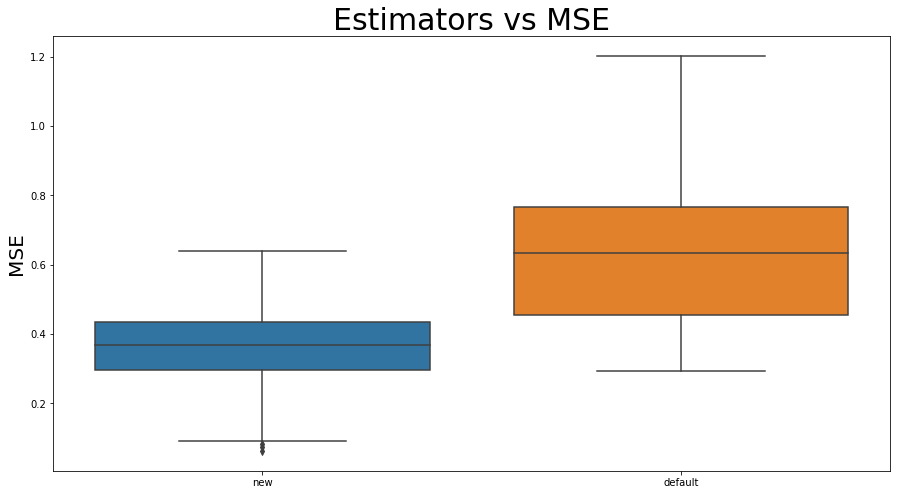

In [ ]:
GB_params = GB_res.best_params

models_GB = {}
'''models_GB['old'] = GradientBoostingRegressor(n_estimators = 200,
                                      learning_rate = 0.5,
                                      max_depth = 15,
                                      min_samples_leaf = 1,
                                      min_samples_split = 3)
'''
models_GB['new'] = GradientBoostingRegressor(**GB_params, n_estimators = 500)

models_GB['default'] = GradientBoostingRegressor()

results_GB = train_and_test_regressor(models_GB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_GB)

In [ ]:
optuna.visualization.plot_param_importances(GB_res)

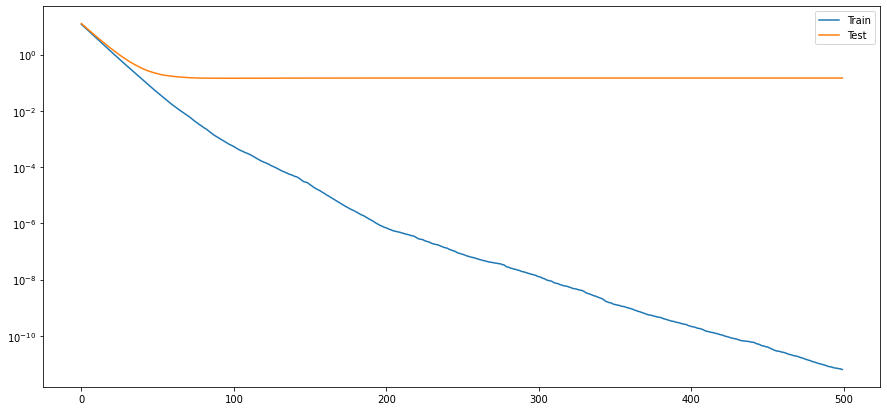

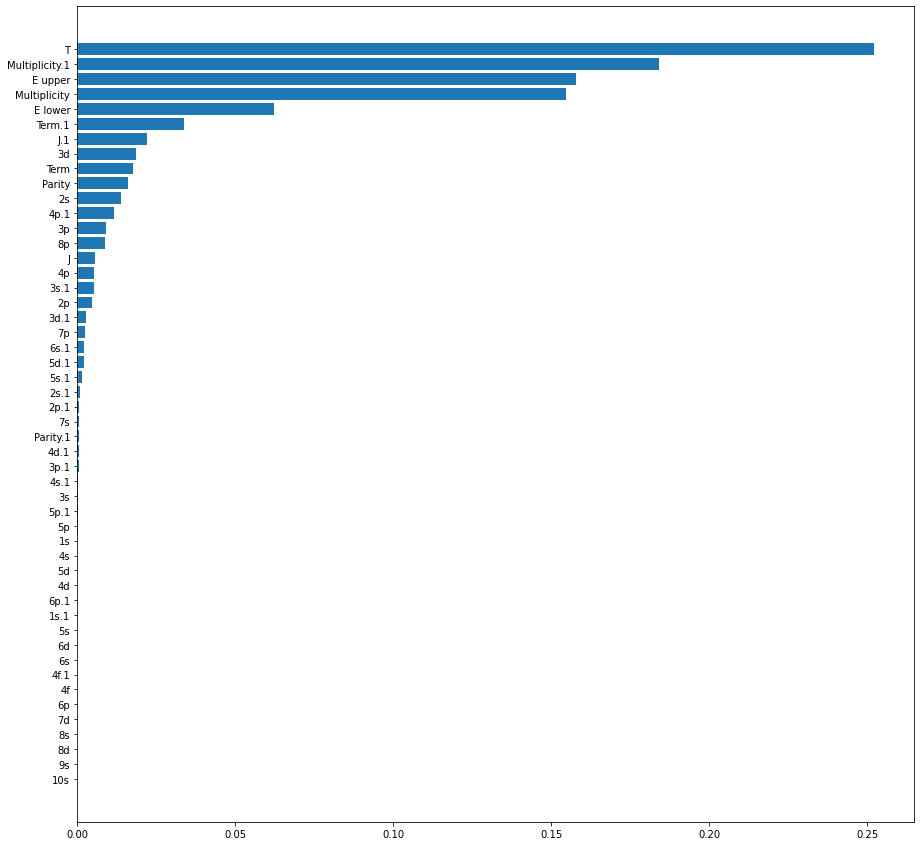

In [ ]:
test_score = np.zeros((500))
for i, y_pred in enumerate(models_GB['new'].staged_predict(XS_test)):
    test_score[i] = models_GB['new'].loss_(YS_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_GB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()

feature_importance = models_GB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.show()

## XGBoost

In [ ]:
XGB_params = {
    'n_estimators' : 500,
    'learning_rate' : [0.01, 0.5],
    'max_depth' : [1, 15],
    'min_child_weight' : [1, 15],
    'reg_alpha' : [1e-8, 10],
    'reg_lambda' : [1e-8, 10],
    'nfold' : 5,
    'squared_metrics' : False,
    'n_jobs' : -1
    }

model_name = XGBoost

XGB_res = main(X = XS_train, y = YS_train, model_name = model_name, params = XGB_params, n_trials = 500)

'''with open(f'XGB_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(XGB_res.best_params, fp)
'''
with open(f'XGB_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(XGB_res.best_params, fp)

[I 2022-08-16 22:33:19,376] A new study created in memory with name: no-name-81f1883d-5e7c-40fa-bcc8-06e5bd6a93bf
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).



Start hyperparameter optimization
{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.43451216509702334, 'min_child_weight': 13, 'reg_alpha': 4.662063153401617e-05, 'reg_lambda': 0.06481583599926398}
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.21591833077977995, 'min_child_weight': 10, 'reg_alpha': 2.494489608379825e-06, 'reg_lambda': 3.958995786483773e-08}


[I 2022-08-16 22:33:33,054] Trial 1 finished with value: 0.3762018470193075 and parameters: {'max_depth': 12, 'learning_rate': 0.21591833077977995, 'min_child_weight': 10, 'reg_alpha': 2.494489608379825e-06, 'reg_lambda': 3.958995786483773e-08}. Best is trial 1 with value: 0.3762018470193075.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.2138939534825948, 'min_child_weight': 14, 'reg_alpha': 0.00041553332381350503, 'reg_lambda': 3.0513258282108815}


[I 2022-08-16 22:33:33,767] Trial 0 finished with value: 0.38249797292943954 and parameters: {'max_depth': 13, 'learning_rate': 0.43451216509702334, 'min_child_weight': 13, 'reg_alpha': 4.662063153401617e-05, 'reg_lambda': 0.06481583599926398}. Best is trial 1 with value: 0.3762018470193075.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.32145595650645725, 'min_child_weight': 4, 'reg_alpha': 9.434893077594375e-06, 'reg_lambda': 0.0013722136251563056}


[I 2022-08-16 22:33:40,083] Trial 3 finished with value: 0.3537344924169386 and parameters: {'max_depth': 9, 'learning_rate': 0.32145595650645725, 'min_child_weight': 4, 'reg_alpha': 9.434893077594375e-06, 'reg_lambda': 0.0013722136251563056}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.37888722992426527, 'min_child_weight': 12, 'reg_alpha': 3.7540024487000056e-08, 'reg_lambda': 0.12036413228096332}


[I 2022-08-16 22:33:46,291] Trial 2 finished with value: 0.36989964802894604 and parameters: {'max_depth': 12, 'learning_rate': 0.2138939534825948, 'min_child_weight': 14, 'reg_alpha': 0.00041553332381350503, 'reg_lambda': 3.0513258282108815}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.19863996013867183, 'min_child_weight': 7, 'reg_alpha': 0.6309570648287055, 'reg_lambda': 1.6902800581741813}


[I 2022-08-16 22:33:49,687] Trial 5 finished with value: 0.37620243312664814 and parameters: {'max_depth': 7, 'learning_rate': 0.19863996013867183, 'min_child_weight': 7, 'reg_alpha': 0.6309570648287055, 'reg_lambda': 1.6902800581741813}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.4125906513211186, 'min_child_weight': 5, 'reg_alpha': 2.0058338724724084e-07, 'reg_lambda': 0.015078819733045748}


[I 2022-08-16 22:33:51,521] Trial 6 finished with value: 0.49086536615112414 and parameters: {'max_depth': 1, 'learning_rate': 0.4125906513211186, 'min_child_weight': 5, 'reg_alpha': 2.0058338724724084e-07, 'reg_lambda': 0.015078819733045748}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.21603233395206942, 'min_child_weight': 1, 'reg_alpha': 0.27337639793224344, 'reg_lambda': 1.5596717298281781}


[I 2022-08-16 22:33:55,410] Trial 4 finished with value: 0.37862888838723613 and parameters: {'max_depth': 14, 'learning_rate': 0.37888722992426527, 'min_child_weight': 12, 'reg_alpha': 3.7540024487000056e-08, 'reg_lambda': 0.12036413228096332}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.30573940661782806, 'min_child_weight': 5, 'reg_alpha': 6.093656613660288e-08, 'reg_lambda': 0.022384325420108105}


[I 2022-08-16 22:33:55,760] Trial 7 finished with value: 0.36017237931760965 and parameters: {'max_depth': 15, 'learning_rate': 0.21603233395206942, 'min_child_weight': 1, 'reg_alpha': 0.27337639793224344, 'reg_lambda': 1.5596717298281781}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.48690821882598245, 'min_child_weight': 4, 'reg_alpha': 0.2843473625370447, 'reg_lambda': 0.0022033966588254792}


[I 2022-08-16 22:33:58,377] Trial 9 finished with value: 0.3670993257736176 and parameters: {'max_depth': 14, 'learning_rate': 0.48690821882598245, 'min_child_weight': 4, 'reg_alpha': 0.2843473625370447, 'reg_lambda': 0.0022033966588254792}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.419583325744143, 'min_child_weight': 8, 'reg_alpha': 1.1037631073096125e-08, 'reg_lambda': 1.3570434910149364e-07}


[I 2022-08-16 22:34:03,109] Trial 8 finished with value: 0.37646822752104026 and parameters: {'max_depth': 10, 'learning_rate': 0.30573940661782806, 'min_child_weight': 5, 'reg_alpha': 6.093656613660288e-08, 'reg_lambda': 0.022384325420108105}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.0332932029008583, 'min_child_weight': 1, 'reg_alpha': 0.0017681642053541762, 'reg_lambda': 1.3519918658826968e-05}


[I 2022-08-16 22:34:06,558] Trial 10 finished with value: 0.3813395294200589 and parameters: {'max_depth': 7, 'learning_rate': 0.419583325744143, 'min_child_weight': 8, 'reg_alpha': 1.1037631073096125e-08, 'reg_lambda': 1.3570434910149364e-07}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.06863016012807918, 'min_child_weight': 1, 'reg_alpha': 0.002889259732271011, 'reg_lambda': 9.361686758172728e-05}


[I 2022-08-16 22:34:10,853] Trial 11 finished with value: 0.3881900423383298 and parameters: {'max_depth': 6, 'learning_rate': 0.0332932029008583, 'min_child_weight': 1, 'reg_alpha': 0.0017681642053541762, 'reg_lambda': 1.3519918658826968e-05}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.30323656741947547, 'min_child_weight': 2, 'reg_alpha': 0.014235954316973576, 'reg_lambda': 4.5532908857713295e-05}


[I 2022-08-16 22:34:11,533] Trial 12 finished with value: 0.37172380273484584 and parameters: {'max_depth': 4, 'learning_rate': 0.06863016012807918, 'min_child_weight': 1, 'reg_alpha': 0.002889259732271011, 'reg_lambda': 9.361686758172728e-05}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.3061537354934513, 'min_child_weight': 3, 'reg_alpha': 7.307051227690911, 'reg_lambda': 1.974827861537219e-05}


[I 2022-08-16 22:34:13,754] Trial 14 finished with value: 0.47101688046288703 and parameters: {'max_depth': 10, 'learning_rate': 0.3061537354934513, 'min_child_weight': 3, 'reg_alpha': 7.307051227690911, 'reg_lambda': 1.974827861537219e-05}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.12096374602806087, 'min_child_weight': 2, 'reg_alpha': 1.2886897134290232e-05, 'reg_lambda': 0.0006369595611127257}


[I 2022-08-16 22:34:14,774] Trial 13 finished with value: 0.3761785254382769 and parameters: {'max_depth': 3, 'learning_rate': 0.30323656741947547, 'min_child_weight': 2, 'reg_alpha': 0.014235954316973576, 'reg_lambda': 4.5532908857713295e-05}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.12457317919373528, 'min_child_weight': 6, 'reg_alpha': 1.7753204704992087e-05, 'reg_lambda': 9.66386597171463e-07}


[I 2022-08-16 22:34:21,986] Trial 15 finished with value: 0.4093460691192674 and parameters: {'max_depth': 10, 'learning_rate': 0.12096374602806087, 'min_child_weight': 2, 'reg_alpha': 1.2886897134290232e-05, 'reg_lambda': 0.0006369595611127257}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.14095874458908658, 'min_child_weight': 6, 'reg_alpha': 0.03816969969758041, 'reg_lambda': 6.55092766088268e-07}


[I 2022-08-16 22:34:27,260] Trial 16 finished with value: 0.3800353161693253 and parameters: {'max_depth': 10, 'learning_rate': 0.12457317919373528, 'min_child_weight': 6, 'reg_alpha': 1.7753204704992087e-05, 'reg_lambda': 9.66386597171463e-07}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35722712058421213, 'min_child_weight': 10, 'reg_alpha': 0.02762376694454632, 'reg_lambda': 9.194266494903195}


[I 2022-08-16 22:34:36,102] Trial 17 finished with value: 0.38722178115600336 and parameters: {'max_depth': 15, 'learning_rate': 0.14095874458908658, 'min_child_weight': 6, 'reg_alpha': 0.03816969969758041, 'reg_lambda': 6.55092766088268e-07}. Best is trial 3 with value: 0.3537344924169386.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.26185545577453223, 'min_child_weight': 9, 'reg_alpha': 6.82405404077449e-07, 'reg_lambda': 9.649566070361814}


[I 2022-08-16 22:34:41,039] Trial 18 finished with value: 0.34375704612234026 and parameters: {'max_depth': 15, 'learning_rate': 0.35722712058421213, 'min_child_weight': 10, 'reg_alpha': 0.02762376694454632, 'reg_lambda': 9.194266494903195}. Best is trial 18 with value: 0.34375704612234026.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3574380632656764, 'min_child_weight': 9, 'reg_alpha': 1.6460855232940747e-06, 'reg_lambda': 7.495396331156652}


[I 2022-08-16 22:34:42,120] Trial 19 finished with value: 0.35124810792435 and parameters: {'max_depth': 5, 'learning_rate': 0.26185545577453223, 'min_child_weight': 9, 'reg_alpha': 6.82405404077449e-07, 'reg_lambda': 9.649566070361814}. Best is trial 18 with value: 0.34375704612234026.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3450633332836917, 'min_child_weight': 10, 'reg_alpha': 7.035086004046616e-07, 'reg_lambda': 8.388390093215751}


[I 2022-08-16 22:34:47,005] Trial 20 finished with value: 0.34013848543084013 and parameters: {'max_depth': 5, 'learning_rate': 0.3574380632656764, 'min_child_weight': 9, 'reg_alpha': 1.6460855232940747e-06, 'reg_lambda': 7.495396331156652}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.36119194671329846, 'min_child_weight': 10, 'reg_alpha': 5.761612667690822e-07, 'reg_lambda': 0.30399678183106527}


[I 2022-08-16 22:34:48,055] Trial 21 finished with value: 0.35289331101217114 and parameters: {'max_depth': 5, 'learning_rate': 0.3450633332836917, 'min_child_weight': 10, 'reg_alpha': 7.035086004046616e-07, 'reg_lambda': 8.388390093215751}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.26853297524436365, 'min_child_weight': 9, 'reg_alpha': 0.00014628534658041518, 'reg_lambda': 0.32114845757225596}


[I 2022-08-16 22:34:50,847] Trial 23 finished with value: 0.38773768769256006 and parameters: {'max_depth': 2, 'learning_rate': 0.26853297524436365, 'min_child_weight': 9, 'reg_alpha': 0.00014628534658041518, 'reg_lambda': 0.32114845757225596}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.350334556468891, 'min_child_weight': 11, 'reg_alpha': 8.016634491964737e-07, 'reg_lambda': 0.4972268807103109}


[I 2022-08-16 22:34:52,974] Trial 22 finished with value: 0.3662757924983361 and parameters: {'max_depth': 5, 'learning_rate': 0.36119194671329846, 'min_child_weight': 10, 'reg_alpha': 5.761612667690822e-07, 'reg_lambda': 0.30399678183106527}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.26629492580166353, 'min_child_weight': 12, 'reg_alpha': 1.4851741137720445e-06, 'reg_lambda': 9.701160758066912}


[I 2022-08-16 22:34:56,713] Trial 24 finished with value: 0.3856588215039395 and parameters: {'max_depth': 5, 'learning_rate': 0.350334556468891, 'min_child_weight': 11, 'reg_alpha': 8.016634491964737e-07, 'reg_lambda': 0.4972268807103109}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.268797772667977, 'min_child_weight': 8, 'reg_alpha': 0.0004984777001928852, 'reg_lambda': 7.525463804594739}


[I 2022-08-16 22:35:02,153] Trial 25 finished with value: 0.3501445329402443 and parameters: {'max_depth': 8, 'learning_rate': 0.26629492580166353, 'min_child_weight': 12, 'reg_alpha': 1.4851741137720445e-06, 'reg_lambda': 9.701160758066912}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.4876467692043607, 'min_child_weight': 12, 'reg_alpha': 0.00019639512522744254, 'reg_lambda': 0.006403605202702148}


[I 2022-08-16 22:35:06,096] Trial 26 finished with value: 0.3497244931907201 and parameters: {'max_depth': 8, 'learning_rate': 0.268797772667977, 'min_child_weight': 8, 'reg_alpha': 0.0004984777001928852, 'reg_lambda': 7.525463804594739}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.49964592157961024, 'min_child_weight': 15, 'reg_alpha': 0.0005811359926054572, 'reg_lambda': 0.008750916213603577}


[I 2022-08-16 22:35:11,419] Trial 27 finished with value: 0.38521733100720773 and parameters: {'max_depth': 8, 'learning_rate': 0.4876467692043607, 'min_child_weight': 12, 'reg_alpha': 0.00019639512522744254, 'reg_lambda': 0.006403605202702148}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.39149826271727617, 'min_child_weight': 8, 'reg_alpha': 0.014133260664791534, 'reg_lambda': 1.0339277365912527}


[I 2022-08-16 22:35:15,259] Trial 28 finished with value: 0.40559398139076946 and parameters: {'max_depth': 8, 'learning_rate': 0.49964592157961024, 'min_child_weight': 15, 'reg_alpha': 0.0005811359926054572, 'reg_lambda': 0.008750916213603577}. Best is trial 20 with value: 0.34013848543084013.
[I 2022-08-16 22:35:15,303] Trial 29 finished with value: 0.3592591380200495 and parameters: {'max_depth': 3, 'learning_rate': 0.39149826271727617, 'min_child_weight': 8, 'reg_alpha': 0.014133260664791534, 'reg_lambda': 1.0339277365912527}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.38320556990243504, 'min_child_weight': 8, 'reg_alpha': 0.017222551152467923, 'reg_lambda': 0.07213613797092978}
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4596224791272667, 'min_child_weight': 7, 'reg_alpha': 9.088928395514937e-05, 'reg_lambda': 0.07064816482229959}


[I 2022-08-16 22:35:23,002] Trial 30 finished with value: 0.3753089216648527 and parameters: {'max_depth': 12, 'learning_rate': 0.38320556990243504, 'min_child_weight': 8, 'reg_alpha': 0.017222551152467923, 'reg_lambda': 0.07213613797092978}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2843831258205971, 'min_child_weight': 13, 'reg_alpha': 5.924272821930506e-05, 'reg_lambda': 8.779644641600262}


[I 2022-08-16 22:35:23,466] Trial 31 finished with value: 0.37595386324107305 and parameters: {'max_depth': 12, 'learning_rate': 0.4596224791272667, 'min_child_weight': 7, 'reg_alpha': 9.088928395514937e-05, 'reg_lambda': 0.07064816482229959}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.24597211016903842, 'min_child_weight': 12, 'reg_alpha': 3.988710096955487e-06, 'reg_lambda': 5.5233411970109145}


[I 2022-08-16 22:35:31,122] Trial 32 finished with value: 0.3506443504553701 and parameters: {'max_depth': 7, 'learning_rate': 0.2843831258205971, 'min_child_weight': 13, 'reg_alpha': 5.924272821930506e-05, 'reg_lambda': 8.779644641600262}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.18176782143016784, 'min_child_weight': 11, 'reg_alpha': 4.425745103326572e-06, 'reg_lambda': 2.924912311895972}


[I 2022-08-16 22:35:31,588] Trial 33 finished with value: 0.3500016209970941 and parameters: {'max_depth': 7, 'learning_rate': 0.24597211016903842, 'min_child_weight': 12, 'reg_alpha': 3.988710096955487e-06, 'reg_lambda': 5.5233411970109145}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.22675405716234762, 'min_child_weight': 11, 'reg_alpha': 0.001696831875184416, 'reg_lambda': 2.7349377719812566}


[I 2022-08-16 22:35:38,578] Trial 35 finished with value: 0.3528020572694443 and parameters: {'max_depth': 6, 'learning_rate': 0.22675405716234762, 'min_child_weight': 11, 'reg_alpha': 0.001696831875184416, 'reg_lambda': 2.7349377719812566}. Best is trial 20 with value: 0.34013848543084013.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.3310211950305352, 'min_child_weight': 9, 'reg_alpha': 8.383980641595223e-06, 'reg_lambda': 0.48967601500997593}


[I 2022-08-16 22:35:41,352] Trial 34 finished with value: 0.3375962021828358 and parameters: {'max_depth': 9, 'learning_rate': 0.18176782143016784, 'min_child_weight': 11, 'reg_alpha': 4.425745103326572e-06, 'reg_lambda': 2.924912311895972}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.18570794027218898, 'min_child_weight': 9, 'reg_alpha': 3.862820773736053e-06, 'reg_lambda': 1.0193633092509087}


[I 2022-08-16 22:35:48,977] Trial 36 finished with value: 0.3849652135246449 and parameters: {'max_depth': 9, 'learning_rate': 0.3310211950305352, 'min_child_weight': 9, 'reg_alpha': 8.383980641595223e-06, 'reg_lambda': 0.48967601500997593}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.17369288753905238, 'min_child_weight': 11, 'reg_alpha': 1.2326282484000652e-07, 'reg_lambda': 1.5051359516649259}


[I 2022-08-16 22:35:53,916] Trial 37 finished with value: 0.37959636605855973 and parameters: {'max_depth': 11, 'learning_rate': 0.18570794027218898, 'min_child_weight': 9, 'reg_alpha': 3.862820773736053e-06, 'reg_lambda': 1.0193633092509087}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.45061855602777806, 'min_child_weight': 11, 'reg_alpha': 3.239165561959927e-05, 'reg_lambda': 0.16650142599010492}


[I 2022-08-16 22:36:02,323] Trial 38 finished with value: 0.3672931520972157 and parameters: {'max_depth': 11, 'learning_rate': 0.17369288753905238, 'min_child_weight': 11, 'reg_alpha': 1.2326282484000652e-07, 'reg_lambda': 1.5051359516649259}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.1571507669843366, 'min_child_weight': 14, 'reg_alpha': 2.9148923630420325e-05, 'reg_lambda': 3.5884140097831962}


[I 2022-08-16 22:36:08,294] Trial 39 finished with value: 0.3693667237023067 and parameters: {'max_depth': 13, 'learning_rate': 0.45061855602777806, 'min_child_weight': 11, 'reg_alpha': 3.239165561959927e-05, 'reg_lambda': 0.16650142599010492}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.15661638637293132, 'min_child_weight': 10, 'reg_alpha': 0.00035360019624813295, 'reg_lambda': 1.9095746989482774}


[I 2022-08-16 22:36:16,387] Trial 40 finished with value: 0.34880319066880183 and parameters: {'max_depth': 13, 'learning_rate': 0.1571507669843366, 'min_child_weight': 14, 'reg_alpha': 2.9148923630420325e-05, 'reg_lambda': 3.5884140097831962}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.17278222008375005, 'min_child_weight': 14, 'reg_alpha': 0.00039026077936919285, 'reg_lambda': 2.6088969702324234}


[I 2022-08-16 22:36:18,705] Trial 41 finished with value: 0.3648393701981575 and parameters: {'max_depth': 9, 'learning_rate': 0.15661638637293132, 'min_child_weight': 10, 'reg_alpha': 0.00035360019624813295, 'reg_lambda': 1.9095746989482774}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.09452922996116214, 'min_child_weight': 14, 'reg_alpha': 3.8213233455433426e-05, 'reg_lambda': 3.3497488255611927}


[I 2022-08-16 22:36:31,408] Trial 42 finished with value: 0.3589856490443865 and parameters: {'max_depth': 14, 'learning_rate': 0.17278222008375005, 'min_child_weight': 14, 'reg_alpha': 0.00039026077936919285, 'reg_lambda': 2.6088969702324234}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.07868758409820144, 'min_child_weight': 15, 'reg_alpha': 3.835175287840462e-05, 'reg_lambda': 0.03475220491113691}


[I 2022-08-16 22:36:33,460] Trial 43 finished with value: 0.3454765733983906 and parameters: {'max_depth': 14, 'learning_rate': 0.09452922996116214, 'min_child_weight': 14, 'reg_alpha': 3.8213233455433426e-05, 'reg_lambda': 3.3497488255611927}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.0885532453798468, 'min_child_weight': 15, 'reg_alpha': 3.31180361278761e-05, 'reg_lambda': 0.038198560638460305}


[I 2022-08-16 22:36:45,431] Trial 44 finished with value: 0.4000931670779432 and parameters: {'max_depth': 13, 'learning_rate': 0.07868758409820144, 'min_child_weight': 15, 'reg_alpha': 3.835175287840462e-05, 'reg_lambda': 0.03475220491113691}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.09501163992213826, 'min_child_weight': 14, 'reg_alpha': 2.3267782563908797e-06, 'reg_lambda': 0.6937706795820142}


[I 2022-08-16 22:36:47,544] Trial 45 finished with value: 0.4012968170342221 and parameters: {'max_depth': 13, 'learning_rate': 0.0885532453798468, 'min_child_weight': 15, 'reg_alpha': 3.31180361278761e-05, 'reg_lambda': 0.038198560638460305}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.037911843273964296, 'min_child_weight': 14, 'reg_alpha': 2.4202852403637936e-06, 'reg_lambda': 0.7446888262966812}


[I 2022-08-16 22:37:01,088] Trial 46 finished with value: 0.3877428148042442 and parameters: {'max_depth': 15, 'learning_rate': 0.09501163992213826, 'min_child_weight': 14, 'reg_alpha': 2.3267782563908797e-06, 'reg_lambda': 0.6937706795820142}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.11246740656814722, 'min_child_weight': 13, 'reg_alpha': 2.5772883067792336e-07, 'reg_lambda': 0.17089833754741676}


[I 2022-08-16 22:37:02,361] Trial 47 finished with value: 0.3971604723451226 and parameters: {'max_depth': 15, 'learning_rate': 0.037911843273964296, 'min_child_weight': 14, 'reg_alpha': 2.4202852403637936e-06, 'reg_lambda': 0.7446888262966812}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.1124837176576157, 'min_child_weight': 13, 'reg_alpha': 1.9684568191368393e-07, 'reg_lambda': 3.1985937952809556}


[I 2022-08-16 22:37:17,046] Trial 48 finished with value: 0.37595475934535955 and parameters: {'max_depth': 15, 'learning_rate': 0.11246740656814722, 'min_child_weight': 13, 'reg_alpha': 2.5772883067792336e-07, 'reg_lambda': 0.17089833754741676}. Best is trial 34 with value: 0.3375962021828358.
[I 2022-08-16 22:37:17,274] Trial 49 finished with value: 0.34779163598329893 and parameters: {'max_depth': 14, 'learning_rate': 0.1124837176576157, 'min_child_weight': 13, 'reg_alpha': 1.9684568191368393e-07, 'reg_lambda': 3.1985937952809556}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.05480764889105971, 'min_child_weight': 13, 'reg_alpha': 1.6923577711412796, 'reg_lambda': 2.9926937688356268}
{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.05452232745709333, 'min_child_weight': 13, 'reg_alpha': 3.264875594554839e-08, 'reg_lambda': 3.2757505455505624}


[I 2022-08-16 22:37:24,316] Trial 50 finished with value: 0.4043705304195272 and parameters: {'max_depth': 14, 'learning_rate': 0.05480764889105971, 'min_child_weight': 13, 'reg_alpha': 1.6923577711412796, 'reg_lambda': 2.9926937688356268}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.143580312475165, 'min_child_weight': 13, 'reg_alpha': 2.9737759912956834e-08, 'reg_lambda': 3.7721008946627554}


[I 2022-08-16 22:37:31,696] Trial 51 finished with value: 0.3608253787133133 and parameters: {'max_depth': 14, 'learning_rate': 0.05452232745709333, 'min_child_weight': 13, 'reg_alpha': 3.264875594554839e-08, 'reg_lambda': 3.2757505455505624}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.11902794351076021, 'min_child_weight': 12, 'reg_alpha': 8.499287167831043e-06, 'reg_lambda': 1.0220341042415551e-08}


[I 2022-08-16 22:37:40,258] Trial 52 finished with value: 0.3514076965987204 and parameters: {'max_depth': 14, 'learning_rate': 0.143580312475165, 'min_child_weight': 13, 'reg_alpha': 2.9737759912956834e-08, 'reg_lambda': 3.7721008946627554}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1942859553832334, 'min_child_weight': 12, 'reg_alpha': 6.58441638425977e-06, 'reg_lambda': 0.24270845236640357}


[I 2022-08-16 22:37:47,710] Trial 53 finished with value: 0.36941318607974793 and parameters: {'max_depth': 14, 'learning_rate': 0.11902794351076021, 'min_child_weight': 12, 'reg_alpha': 8.499287167831043e-06, 'reg_lambda': 1.0220341042415551e-08}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.20176566907667778, 'min_child_weight': 14, 'reg_alpha': 2.0524843623306483e-07, 'reg_lambda': 0.2433653400107965}


[I 2022-08-16 22:37:53,707] Trial 54 finished with value: 0.3733214540169345 and parameters: {'max_depth': 12, 'learning_rate': 0.1942859553832334, 'min_child_weight': 12, 'reg_alpha': 6.58441638425977e-06, 'reg_lambda': 0.24270845236640357}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.01759559273105514, 'min_child_weight': 11, 'reg_alpha': 3.2211186594565877e-07, 'reg_lambda': 1.2243219379630221}


[I 2022-08-16 22:38:00,980] Trial 55 finished with value: 0.3789333754369649 and parameters: {'max_depth': 12, 'learning_rate': 0.20176566907667778, 'min_child_weight': 14, 'reg_alpha': 2.0524843623306483e-07, 'reg_lambda': 0.2433653400107965}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.141489966066841, 'min_child_weight': 14, 'reg_alpha': 1.6687921457517522e-05, 'reg_lambda': 1.2849793021249964}


[I 2022-08-16 22:38:04,933] Trial 56 finished with value: 0.41015288713665204 and parameters: {'max_depth': 11, 'learning_rate': 0.01759559273105514, 'min_child_weight': 11, 'reg_alpha': 3.2211186594565877e-07, 'reg_lambda': 1.2243219379630221}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.22997698917920556, 'min_child_weight': 14, 'reg_alpha': 1.8381505016357667e-05, 'reg_lambda': 4.014932565787788}


[I 2022-08-16 22:38:06,821] Trial 58 finished with value: 0.5403726558022205 and parameters: {'max_depth': 1, 'learning_rate': 0.22997698917920556, 'min_child_weight': 14, 'reg_alpha': 1.8381505016357667e-05, 'reg_lambda': 4.014932565787788}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.10005386515325614, 'min_child_weight': 10, 'reg_alpha': 0.06589413657250194, 'reg_lambda': 2.8022613931179704e-06}


[I 2022-08-16 22:38:15,089] Trial 57 finished with value: 0.3708861870330667 and parameters: {'max_depth': 13, 'learning_rate': 0.141489966066841, 'min_child_weight': 14, 'reg_alpha': 1.6687921457517522e-05, 'reg_lambda': 1.2849793021249964}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3997919650297881, 'min_child_weight': 10, 'reg_alpha': 1.330675269324964e-06, 'reg_lambda': 4.834729079619647}


[I 2022-08-16 22:38:21,402] Trial 59 finished with value: 0.37360550929166575 and parameters: {'max_depth': 13, 'learning_rate': 0.10005386515325614, 'min_child_weight': 10, 'reg_alpha': 0.06589413657250194, 'reg_lambda': 2.8022613931179704e-06}. Best is trial 34 with value: 0.3375962021828358.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.16955135103927743, 'min_child_weight': 15, 'reg_alpha': 9.787162719524771e-08, 'reg_lambda': 0.00019649847286315868}


[I 2022-08-16 22:38:31,337] Trial 60 finished with value: 0.3349548302360672 and parameters: {'max_depth': 15, 'learning_rate': 0.3997919650297881, 'min_child_weight': 10, 'reg_alpha': 1.330675269324964e-06, 'reg_lambda': 4.834729079619647}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4106646899623968, 'min_child_weight': 9, 'reg_alpha': 1.1378798128282542e-06, 'reg_lambda': 5.553622204963033}


[I 2022-08-16 22:38:37,161] Trial 61 finished with value: 0.40860096940636764 and parameters: {'max_depth': 15, 'learning_rate': 0.16955135103927743, 'min_child_weight': 15, 'reg_alpha': 9.787162719524771e-08, 'reg_lambda': 0.00019649847286315868}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36172927013589934, 'min_child_weight': 9, 'reg_alpha': 9.211662135755355e-07, 'reg_lambda': 4.986096349487961}


[I 2022-08-16 22:38:47,319] Trial 62 finished with value: 0.34754775782298203 and parameters: {'max_depth': 15, 'learning_rate': 0.4106646899623968, 'min_child_weight': 9, 'reg_alpha': 1.1378798128282542e-06, 'reg_lambda': 5.553622204963033}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40627701270495414, 'min_child_weight': 9, 'reg_alpha': 1.1101178028650768e-06, 'reg_lambda': 0.4660013722187051}


[I 2022-08-16 22:38:53,569] Trial 63 finished with value: 0.35435252657800465 and parameters: {'max_depth': 15, 'learning_rate': 0.36172927013589934, 'min_child_weight': 9, 'reg_alpha': 9.211662135755355e-07, 'reg_lambda': 4.986096349487961}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40441134573278553, 'min_child_weight': 10, 'reg_alpha': 1.1863227528529535e-08, 'reg_lambda': 9.980738627675896}


[I 2022-08-16 22:39:00,619] Trial 64 finished with value: 0.3950385090203905 and parameters: {'max_depth': 15, 'learning_rate': 0.40627701270495414, 'min_child_weight': 9, 'reg_alpha': 1.1101178028650768e-06, 'reg_lambda': 0.4660013722187051}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.43431017523518256, 'min_child_weight': 7, 'reg_alpha': 4.238254585066223e-07, 'reg_lambda': 6.2546313150595285}


[I 2022-08-16 22:39:05,564] Trial 66 finished with value: 0.3461340387086983 and parameters: {'max_depth': 4, 'learning_rate': 0.43431017523518256, 'min_child_weight': 7, 'reg_alpha': 4.238254585066223e-07, 'reg_lambda': 6.2546313150595285}. Best is trial 60 with value: 0.3349548302360672.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.42365313087680007, 'min_child_weight': 6, 'reg_alpha': 4.2444214368414856e-07, 'reg_lambda': 9.487895320929873}


[I 2022-08-16 22:39:10,075] Trial 65 finished with value: 0.3274776199246633 and parameters: {'max_depth': 15, 'learning_rate': 0.40441134573278553, 'min_child_weight': 10, 'reg_alpha': 1.1863227528529535e-08, 'reg_lambda': 9.980738627675896}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.43673517242065474, 'min_child_weight': 7, 'reg_alpha': 2.0251096134613144e-08, 'reg_lambda': 1.6962008904689732}


[I 2022-08-16 22:39:11,196] Trial 67 finished with value: 0.34106272856371156 and parameters: {'max_depth': 4, 'learning_rate': 0.42365313087680007, 'min_child_weight': 6, 'reg_alpha': 4.2444214368414856e-07, 'reg_lambda': 9.487895320929873}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.37031314364232065, 'min_child_weight': 5, 'reg_alpha': 1.3504864141012934e-08, 'reg_lambda': 9.595050697310388}


[I 2022-08-16 22:39:14,473] Trial 68 finished with value: 0.3634918664553582 and parameters: {'max_depth': 3, 'learning_rate': 0.43673517242065474, 'min_child_weight': 7, 'reg_alpha': 2.0251096134613144e-08, 'reg_lambda': 1.6962008904689732}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3919582280550717, 'min_child_weight': 6, 'reg_alpha': 1.4685214418695545e-08, 'reg_lambda': 0.0020412124736324164}


[I 2022-08-16 22:39:15,312] Trial 69 finished with value: 0.33819097619672417 and parameters: {'max_depth': 3, 'learning_rate': 0.37031314364232065, 'min_child_weight': 5, 'reg_alpha': 1.3504864141012934e-08, 'reg_lambda': 9.595050697310388}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.37298221832809386, 'min_child_weight': 5, 'reg_alpha': 7.221059345393948e-08, 'reg_lambda': 8.535324842152907}


[I 2022-08-16 22:39:18,106] Trial 71 finished with value: 0.37134190019621105 and parameters: {'max_depth': 2, 'learning_rate': 0.37298221832809386, 'min_child_weight': 5, 'reg_alpha': 7.221059345393948e-08, 'reg_lambda': 8.535324842152907}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.39523574489520014, 'min_child_weight': 6, 'reg_alpha': 1.1947931619328271e-08, 'reg_lambda': 9.973213436004757}


[I 2022-08-16 22:39:21,605] Trial 70 finished with value: 0.39126448717599716 and parameters: {'max_depth': 6, 'learning_rate': 0.3919582280550717, 'min_child_weight': 6, 'reg_alpha': 1.4685214418695545e-08, 'reg_lambda': 0.0020412124736324164}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3241048590673016, 'min_child_weight': 4, 'reg_alpha': 1.3082959206381155e-08, 'reg_lambda': 8.903618447381273}


[I 2022-08-16 22:39:23,039] Trial 72 finished with value: 0.3472003529052903 and parameters: {'max_depth': 4, 'learning_rate': 0.39523574489520014, 'min_child_weight': 6, 'reg_alpha': 1.1947931619328271e-08, 'reg_lambda': 9.973213436004757}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.325753631394793, 'min_child_weight': 3, 'reg_alpha': 3.261405743080079e-06, 'reg_lambda': 1.7919633687783183}


[I 2022-08-16 22:39:26,517] Trial 73 finished with value: 0.34494465115989675 and parameters: {'max_depth': 4, 'learning_rate': 0.3241048590673016, 'min_child_weight': 4, 'reg_alpha': 1.3082959206381155e-08, 'reg_lambda': 8.903618447381273}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3240362275239554, 'min_child_weight': 4, 'reg_alpha': 3.6213025508630446e-08, 'reg_lambda': 2.092120330965034}


[I 2022-08-16 22:39:26,913] Trial 74 finished with value: 0.35318405043888124 and parameters: {'max_depth': 3, 'learning_rate': 0.325753631394793, 'min_child_weight': 3, 'reg_alpha': 3.261405743080079e-06, 'reg_lambda': 1.7919633687783183}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.34313826407200004, 'min_child_weight': 4, 'reg_alpha': 1.0443806600197804e-08, 'reg_lambda': 9.886500037980912}


[I 2022-08-16 22:39:29,753] Trial 76 finished with value: 0.3491233426739098 and parameters: {'max_depth': 2, 'learning_rate': 0.34313826407200004, 'min_child_weight': 4, 'reg_alpha': 1.0443806600197804e-08, 'reg_lambda': 9.886500037980912}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.30768983941191697, 'min_child_weight': 3, 'reg_alpha': 5.540233514601702e-08, 'reg_lambda': 0.8170601153678094}


[I 2022-08-16 22:39:31,456] Trial 75 finished with value: 0.3760462152157122 and parameters: {'max_depth': 4, 'learning_rate': 0.3240362275239554, 'min_child_weight': 4, 'reg_alpha': 3.6213025508630446e-08, 'reg_lambda': 2.092120330965034}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3728913428267561, 'min_child_weight': 3, 'reg_alpha': 5.087254301599894e-08, 'reg_lambda': 1.018653178085888}


[I 2022-08-16 22:39:34,701] Trial 77 finished with value: 0.3474194294265164 and parameters: {'max_depth': 4, 'learning_rate': 0.30768983941191697, 'min_child_weight': 3, 'reg_alpha': 5.540233514601702e-08, 'reg_lambda': 0.8170601153678094}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3724452898357308, 'min_child_weight': 10, 'reg_alpha': 1.3375057850276172e-07, 'reg_lambda': 5.519165370078383}


[I 2022-08-16 22:39:37,496] Trial 78 finished with value: 0.3641495573882624 and parameters: {'max_depth': 5, 'learning_rate': 0.3728913428267561, 'min_child_weight': 3, 'reg_alpha': 5.087254301599894e-08, 'reg_lambda': 1.018653178085888}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.4232788189585033, 'min_child_weight': 5, 'reg_alpha': 1.2409946304086298e-07, 'reg_lambda': 4.979778261820418}


[I 2022-08-16 22:39:40,346] Trial 80 finished with value: 0.3740012004353996 and parameters: {'max_depth': 2, 'learning_rate': 0.4232788189585033, 'min_child_weight': 5, 'reg_alpha': 1.2409946304086298e-07, 'reg_lambda': 4.979778261820418}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.46490626380938205, 'min_child_weight': 10, 'reg_alpha': 0.0052434815653131265, 'reg_lambda': 0.4928556759525367}


[I 2022-08-16 22:39:40,694] Trial 79 finished with value: 0.3463275949434303 and parameters: {'max_depth': 5, 'learning_rate': 0.3724452898357308, 'min_child_weight': 10, 'reg_alpha': 1.3375057850276172e-07, 'reg_lambda': 5.519165370078383}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.47022667399321716, 'min_child_weight': 8, 'reg_alpha': 5.061396557544911e-07, 'reg_lambda': 0.5218148156519916}


[I 2022-08-16 22:39:44,519] Trial 82 finished with value: 0.3588429388614208 and parameters: {'max_depth': 3, 'learning_rate': 0.47022667399321716, 'min_child_weight': 8, 'reg_alpha': 5.061396557544911e-07, 'reg_lambda': 0.5218148156519916}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3580353765584344, 'min_child_weight': 5, 'reg_alpha': 8.993520605240391e-05, 'reg_lambda': 2.2239806669527997}


[I 2022-08-16 22:39:46,372] Trial 81 finished with value: 0.39574311144657653 and parameters: {'max_depth': 5, 'learning_rate': 0.46490626380938205, 'min_child_weight': 10, 'reg_alpha': 0.0052434815653131265, 'reg_lambda': 0.4928556759525367}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3418148464104459, 'min_child_weight': 6, 'reg_alpha': 1.720619675173579e-06, 'reg_lambda': 2.1899850237051552}


[I 2022-08-16 22:39:51,626] Trial 83 finished with value: 0.3652761177028952 and parameters: {'max_depth': 6, 'learning_rate': 0.3580353765584344, 'min_child_weight': 5, 'reg_alpha': 8.993520605240391e-05, 'reg_lambda': 2.2239806669527997}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.42516374687405634, 'min_child_weight': 11, 'reg_alpha': 1.772489818671581e-06, 'reg_lambda': 5.978384890067929}


[I 2022-08-16 22:39:53,489] Trial 84 finished with value: 0.35587069014715433 and parameters: {'max_depth': 6, 'learning_rate': 0.3418148464104459, 'min_child_weight': 6, 'reg_alpha': 1.720619675173579e-06, 'reg_lambda': 2.1899850237051552}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.2866585332679038, 'min_child_weight': 11, 'reg_alpha': 1.6390120132851045e-08, 'reg_lambda': 5.762678998368208}


[I 2022-08-16 22:39:56,517] Trial 85 finished with value: 0.3661658959876916 and parameters: {'max_depth': 4, 'learning_rate': 0.42516374687405634, 'min_child_weight': 11, 'reg_alpha': 1.772489818671581e-06, 'reg_lambda': 5.978384890067929}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2910777171111506, 'min_child_weight': 10, 'reg_alpha': 2.2921487072709623e-08, 'reg_lambda': 4.118789105735375}


[I 2022-08-16 22:39:58,357] Trial 86 finished with value: 0.3526824860738508 and parameters: {'max_depth': 4, 'learning_rate': 0.2866585332679038, 'min_child_weight': 11, 'reg_alpha': 1.6390120132851045e-08, 'reg_lambda': 5.762678998368208}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.3844398468266533, 'min_child_weight': 8, 'reg_alpha': 4.772819963415605e-06, 'reg_lambda': 3.747149829495373}


[I 2022-08-16 22:40:02,197] Trial 88 finished with value: 0.36717809694353076 and parameters: {'max_depth': 3, 'learning_rate': 0.3844398468266533, 'min_child_weight': 8, 'reg_alpha': 4.772819963415605e-06, 'reg_lambda': 3.747149829495373}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4017380808269361, 'min_child_weight': 10, 'reg_alpha': 2.8043757636244512e-08, 'reg_lambda': 9.457761661698099}


[I 2022-08-16 22:40:04,730] Trial 87 finished with value: 0.34941844037132613 and parameters: {'max_depth': 7, 'learning_rate': 0.2910777171111506, 'min_child_weight': 10, 'reg_alpha': 2.2921487072709623e-08, 'reg_lambda': 4.118789105735375}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.39704835325639615, 'min_child_weight': 4, 'reg_alpha': 0.276173051226341, 'reg_lambda': 2.474312340909491}


[I 2022-08-16 22:40:07,955] Trial 90 finished with value: 0.3445728729179087 and parameters: {'max_depth': 14, 'learning_rate': 0.39704835325639615, 'min_child_weight': 4, 'reg_alpha': 0.276173051226341, 'reg_lambda': 2.474312340909491}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.44255261843407323, 'min_child_weight': 4, 'reg_alpha': 0.3244553778099392, 'reg_lambda': 9.82091242585064}


[I 2022-08-16 22:40:11,661] Trial 91 finished with value: 0.3338517609183462 and parameters: {'max_depth': 15, 'learning_rate': 0.44255261843407323, 'min_child_weight': 4, 'reg_alpha': 0.3244553778099392, 'reg_lambda': 9.82091242585064}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4436679804273802, 'min_child_weight': 4, 'reg_alpha': 0.35198659039721475, 'reg_lambda': 9.859199880174023}


[I 2022-08-16 22:40:15,320] Trial 92 finished with value: 0.3276445682595023 and parameters: {'max_depth': 15, 'learning_rate': 0.4436679804273802, 'min_child_weight': 4, 'reg_alpha': 0.35198659039721475, 'reg_lambda': 9.859199880174023}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.45433494594991797, 'min_child_weight': 2, 'reg_alpha': 0.4304256683784335, 'reg_lambda': 1.3774200479750094}


[I 2022-08-16 22:40:17,756] Trial 89 finished with value: 0.3380448334650647 and parameters: {'max_depth': 14, 'learning_rate': 0.4017380808269361, 'min_child_weight': 10, 'reg_alpha': 2.8043757636244512e-08, 'reg_lambda': 9.457761661698099}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4467101849660091, 'min_child_weight': 2, 'reg_alpha': 0.8017750129355843, 'reg_lambda': 6.390220539337403}


[I 2022-08-16 22:40:18,158] Trial 93 finished with value: 0.37055772345084187 and parameters: {'max_depth': 14, 'learning_rate': 0.45433494594991797, 'min_child_weight': 2, 'reg_alpha': 0.4304256683784335, 'reg_lambda': 1.3774200479750094}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.44365070506880344, 'min_child_weight': 10, 'reg_alpha': 0.10571947660942388, 'reg_lambda': 9.766687966958422}


[I 2022-08-16 22:40:20,720] Trial 94 finished with value: 0.3501862531532198 and parameters: {'max_depth': 15, 'learning_rate': 0.4467101849660091, 'min_child_weight': 2, 'reg_alpha': 0.8017750129355843, 'reg_lambda': 6.390220539337403}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4741927310069138, 'min_child_weight': 10, 'reg_alpha': 0.12969338417862236, 'reg_lambda': 9.730114812033198}


[I 2022-08-16 22:40:24,962] Trial 95 finished with value: 0.3358290267378125 and parameters: {'max_depth': 15, 'learning_rate': 0.44365070506880344, 'min_child_weight': 10, 'reg_alpha': 0.10571947660942388, 'reg_lambda': 9.766687966958422}. Best is trial 65 with value: 0.3274776199246633.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.47869065810259015, 'min_child_weight': 10, 'reg_alpha': 0.13053551184121834, 'reg_lambda': 2.684436446377346}


[I 2022-08-16 22:40:25,958] Trial 96 finished with value: 0.3203566427885345 and parameters: {'max_depth': 9, 'learning_rate': 0.4741927310069138, 'min_child_weight': 10, 'reg_alpha': 0.12969338417862236, 'reg_lambda': 9.730114812033198}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4810548437135258, 'min_child_weight': 10, 'reg_alpha': 0.16625740234305908, 'reg_lambda': 2.8942854477538926}


[I 2022-08-16 22:40:30,000] Trial 97 finished with value: 0.3789314417133573 and parameters: {'max_depth': 15, 'learning_rate': 0.47869065810259015, 'min_child_weight': 10, 'reg_alpha': 0.13053551184121834, 'reg_lambda': 2.684436446377346}. Best is trial 96 with value: 0.3203566427885345.
[I 2022-08-16 22:40:30,163] Trial 98 finished with value: 0.38230915932799564 and parameters: {'max_depth': 9, 'learning_rate': 0.4810548437135258, 'min_child_weight': 10, 'reg_alpha': 0.16625740234305908, 'reg_lambda': 2.8942854477538926}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4945828409971033, 'min_child_weight': 10, 'reg_alpha': 2.0501550299957163, 'reg_lambda': 3.951347009277585}
{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.44230666560641, 'min_child_weight': 9, 'reg_alpha': 4.040617183670357, 'reg_lambda': 1.7280106752782442e-07}


[I 2022-08-16 22:40:32,374] Trial 99 finished with value: 0.38761774388671905 and parameters: {'max_depth': 9, 'learning_rate': 0.4945828409971033, 'min_child_weight': 10, 'reg_alpha': 2.0501550299957163, 'reg_lambda': 3.951347009277585}. Best is trial 96 with value: 0.3203566427885345.
[I 2022-08-16 22:40:32,408] Trial 100 finished with value: 0.46081655642131913 and parameters: {'max_depth': 10, 'learning_rate': 0.44230666560641, 'min_child_weight': 9, 'reg_alpha': 4.040617183670357, 'reg_lambda': 1.7280106752782442e-07}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.44275421750841626, 'min_child_weight': 9, 'reg_alpha': 7.463042597175592, 'reg_lambda': 6.833252864956218}
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40566544752772765, 'min_child_weight': 11, 'reg_alpha': 0.050787832285128114, 'reg_lambda': 6.642331555073528}


[I 2022-08-16 22:40:34,547] Trial 101 finished with value: 0.4836197146896805 and parameters: {'max_depth': 15, 'learning_rate': 0.44275421750841626, 'min_child_weight': 9, 'reg_alpha': 7.463042597175592, 'reg_lambda': 6.833252864956218}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4125889251560666, 'min_child_weight': 11, 'reg_alpha': 0.9824574136440517, 'reg_lambda': 7.045430600134164}


[I 2022-08-16 22:40:37,644] Trial 103 finished with value: 0.37419166083182365 and parameters: {'max_depth': 14, 'learning_rate': 0.4125889251560666, 'min_child_weight': 11, 'reg_alpha': 0.9824574136440517, 'reg_lambda': 7.045430600134164}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4281032710374582, 'min_child_weight': 5, 'reg_alpha': 0.09957734876571796, 'reg_lambda': 1.461947076518348}


[I 2022-08-16 22:40:41,936] Trial 104 finished with value: 0.35913396625661587 and parameters: {'max_depth': 15, 'learning_rate': 0.4281032710374582, 'min_child_weight': 5, 'reg_alpha': 0.09957734876571796, 'reg_lambda': 1.461947076518348}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4032525140752318, 'min_child_weight': 11, 'reg_alpha': 0.04488052406553925, 'reg_lambda': 9.417380884751307}


[I 2022-08-16 22:40:42,256] Trial 102 finished with value: 0.33023312932691307 and parameters: {'max_depth': 15, 'learning_rate': 0.40566544752772765, 'min_child_weight': 11, 'reg_alpha': 0.050787832285128114, 'reg_lambda': 6.642331555073528}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4100241960786759, 'min_child_weight': 11, 'reg_alpha': 0.04537784843500597, 'reg_lambda': 4.847195618694126}


[I 2022-08-16 22:40:51,460] Trial 105 finished with value: 0.338918915977618 and parameters: {'max_depth': 9, 'learning_rate': 0.4032525140752318, 'min_child_weight': 11, 'reg_alpha': 0.04488052406553925, 'reg_lambda': 9.417380884751307}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4094795248651181, 'min_child_weight': 11, 'reg_alpha': 0.05538992134714662, 'reg_lambda': 0.0008736102053508373}


[I 2022-08-16 22:40:52,731] Trial 106 finished with value: 0.33619005255261364 and parameters: {'max_depth': 15, 'learning_rate': 0.4100241960786759, 'min_child_weight': 11, 'reg_alpha': 0.04537784843500597, 'reg_lambda': 4.847195618694126}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41550015966488485, 'min_child_weight': 12, 'reg_alpha': 0.020772566828676054, 'reg_lambda': 0.7471933595128735}


[I 2022-08-16 22:40:58,502] Trial 107 finished with value: 0.3600963429058394 and parameters: {'max_depth': 14, 'learning_rate': 0.4094795248651181, 'min_child_weight': 11, 'reg_alpha': 0.05538992134714662, 'reg_lambda': 0.0008736102053508373}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4752147110014494, 'min_child_weight': 12, 'reg_alpha': 0.02365521351774316, 'reg_lambda': 0.9244352180569207}


[I 2022-08-16 22:41:03,743] Trial 108 finished with value: 0.38440363125377697 and parameters: {'max_depth': 15, 'learning_rate': 0.41550015966488485, 'min_child_weight': 12, 'reg_alpha': 0.020772566828676054, 'reg_lambda': 0.7471933595128735}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4582653921010754, 'min_child_weight': 12, 'reg_alpha': 0.4836736000531568, 'reg_lambda': 4.4017480739153525}


[I 2022-08-16 22:41:07,591] Trial 110 finished with value: 0.3636931382908116 and parameters: {'max_depth': 15, 'learning_rate': 0.4582653921010754, 'min_child_weight': 12, 'reg_alpha': 0.4836736000531568, 'reg_lambda': 4.4017480739153525}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.436043007110799, 'min_child_weight': 11, 'reg_alpha': 0.08376987217224852, 'reg_lambda': 1.4417832944436966e-05}


[I 2022-08-16 22:41:08,382] Trial 109 finished with value: 0.39066397582768625 and parameters: {'max_depth': 15, 'learning_rate': 0.4752147110014494, 'min_child_weight': 12, 'reg_alpha': 0.02365521351774316, 'reg_lambda': 0.9244352180569207}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.39672472101421996, 'min_child_weight': 11, 'reg_alpha': 0.03944100637569113, 'reg_lambda': 4.8095494559157475}


[I 2022-08-16 22:41:13,799] Trial 111 finished with value: 0.3796499586242831 and parameters: {'max_depth': 14, 'learning_rate': 0.436043007110799, 'min_child_weight': 11, 'reg_alpha': 0.08376987217224852, 'reg_lambda': 1.4417832944436966e-05}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.40133022310141203, 'min_child_weight': 11, 'reg_alpha': 0.16809314469425843, 'reg_lambda': 9.92112454270158}


[I 2022-08-16 22:41:16,745] Trial 112 finished with value: 0.3504391138852148 and parameters: {'max_depth': 10, 'learning_rate': 0.39672472101421996, 'min_child_weight': 11, 'reg_alpha': 0.03944100637569113, 'reg_lambda': 4.8095494559157475}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.45380688900053656, 'min_child_weight': 10, 'reg_alpha': 0.03882711306776607, 'reg_lambda': 9.112786049079197}


[I 2022-08-16 22:41:19,699] Trial 113 finished with value: 0.3368044254142081 and parameters: {'max_depth': 10, 'learning_rate': 0.40133022310141203, 'min_child_weight': 11, 'reg_alpha': 0.16809314469425843, 'reg_lambda': 9.92112454270158}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.38422864621449276, 'min_child_weight': 10, 'reg_alpha': 0.1777608580621946, 'reg_lambda': 1.8649059270201234}


[I 2022-08-16 22:41:23,777] Trial 115 finished with value: 0.36456586000806424 and parameters: {'max_depth': 8, 'learning_rate': 0.38422864621449276, 'min_child_weight': 10, 'reg_alpha': 0.1777608580621946, 'reg_lambda': 1.8649059270201234}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4613778855310252, 'min_child_weight': 10, 'reg_alpha': 0.40634274399061515, 'reg_lambda': 0.005547247224913128}


[I 2022-08-16 22:41:24,504] Trial 114 finished with value: 0.3360652647336308 and parameters: {'max_depth': 8, 'learning_rate': 0.45380688900053656, 'min_child_weight': 10, 'reg_alpha': 0.03882711306776607, 'reg_lambda': 9.112786049079197}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.4632025670178733, 'min_child_weight': 10, 'reg_alpha': 0.30537730235616667, 'reg_lambda': 2.887245019906523}


[I 2022-08-16 22:41:26,989] Trial 116 finished with value: 0.38219925148707845 and parameters: {'max_depth': 15, 'learning_rate': 0.4613778855310252, 'min_child_weight': 10, 'reg_alpha': 0.40634274399061515, 'reg_lambda': 0.005547247224913128}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.4485590502432375, 'min_child_weight': 11, 'reg_alpha': 0.00966513711356142, 'reg_lambda': 3.466274705051435}


[I 2022-08-16 22:41:27,749] Trial 117 finished with value: 0.37448553961610775 and parameters: {'max_depth': 8, 'learning_rate': 0.4632025670178733, 'min_child_weight': 10, 'reg_alpha': 0.30537730235616667, 'reg_lambda': 2.887245019906523}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.44860814841903457, 'min_child_weight': 11, 'reg_alpha': 0.008253338897817316, 'reg_lambda': 5.923700286281369}


[I 2022-08-16 22:41:37,680] Trial 118 finished with value: 0.3626672627262713 and parameters: {'max_depth': 10, 'learning_rate': 0.4485590502432375, 'min_child_weight': 11, 'reg_alpha': 0.00966513711356142, 'reg_lambda': 3.466274705051435}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.43237322955900626, 'min_child_weight': 9, 'reg_alpha': 0.20608378086341958, 'reg_lambda': 6.444330674800437}


[I 2022-08-16 22:41:39,293] Trial 119 finished with value: 0.3416646108550162 and parameters: {'max_depth': 10, 'learning_rate': 0.44860814841903457, 'min_child_weight': 11, 'reg_alpha': 0.008253338897817316, 'reg_lambda': 5.923700286281369}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.41749814357534887, 'min_child_weight': 12, 'reg_alpha': 0.14753871548929673, 'reg_lambda': 9.947447375542433}


[I 2022-08-16 22:41:42,342] Trial 120 finished with value: 0.337042550924176 and parameters: {'max_depth': 15, 'learning_rate': 0.43237322955900626, 'min_child_weight': 9, 'reg_alpha': 0.20608378086341958, 'reg_lambda': 6.444330674800437}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4314974009361577, 'min_child_weight': 10, 'reg_alpha': 0.000811810412044017, 'reg_lambda': 6.474950374945391}


[I 2022-08-16 22:41:45,186] Trial 121 finished with value: 0.36067888999281983 and parameters: {'max_depth': 9, 'learning_rate': 0.41749814357534887, 'min_child_weight': 12, 'reg_alpha': 0.14753871548929673, 'reg_lambda': 9.947447375542433}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.43060626636580135, 'min_child_weight': 9, 'reg_alpha': 0.0007814862367396935, 'reg_lambda': 6.212287386518101}


[I 2022-08-16 22:41:52,829] Trial 122 finished with value: 0.346865540290412 and parameters: {'max_depth': 9, 'learning_rate': 0.4314974009361577, 'min_child_weight': 10, 'reg_alpha': 0.000811810412044017, 'reg_lambda': 6.474950374945391}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4212179805857879, 'min_child_weight': 9, 'reg_alpha': 0.08960764280942729, 'reg_lambda': 4.6173219089696875}


[I 2022-08-16 22:41:59,286] Trial 124 finished with value: 0.3424807364942864 and parameters: {'max_depth': 15, 'learning_rate': 0.4212179805857879, 'min_child_weight': 9, 'reg_alpha': 0.08960764280942729, 'reg_lambda': 4.6173219089696875}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.40374256405170883, 'min_child_weight': 10, 'reg_alpha': 1.1654563817857875, 'reg_lambda': 1.872776432428356}


[I 2022-08-16 22:41:59,992] Trial 123 finished with value: 0.33852447408077996 and parameters: {'max_depth': 14, 'learning_rate': 0.43060626636580135, 'min_child_weight': 9, 'reg_alpha': 0.0007814862367396935, 'reg_lambda': 6.212287386518101}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40215636882876177, 'min_child_weight': 10, 'reg_alpha': 0.2176285623612215, 'reg_lambda': 1.9880685551767139}


[I 2022-08-16 22:42:02,072] Trial 125 finished with value: 0.40080266763708894 and parameters: {'max_depth': 14, 'learning_rate': 0.40374256405170883, 'min_child_weight': 10, 'reg_alpha': 1.1654563817857875, 'reg_lambda': 1.872776432428356}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4860555062277044, 'min_child_weight': 9, 'reg_alpha': 0.200621045960719, 'reg_lambda': 2.9133788033758354}


[I 2022-08-16 22:42:04,377] Trial 126 finished with value: 0.3683631909151474 and parameters: {'max_depth': 15, 'learning_rate': 0.40215636882876177, 'min_child_weight': 10, 'reg_alpha': 0.2176285623612215, 'reg_lambda': 1.9880685551767139}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.48801905055034434, 'min_child_weight': 9, 'reg_alpha': 0.028204166361965235, 'reg_lambda': 3.1068378747710153}


[I 2022-08-16 22:42:06,303] Trial 127 finished with value: 0.37494010161570096 and parameters: {'max_depth': 15, 'learning_rate': 0.4860555062277044, 'min_child_weight': 9, 'reg_alpha': 0.200621045960719, 'reg_lambda': 2.9133788033758354}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.4722565608423658, 'min_child_weight': 11, 'reg_alpha': 0.07116590864888972, 'reg_lambda': 3.277642433526134e-05}


[I 2022-08-16 22:42:10,495] Trial 128 finished with value: 0.36908593902551873 and parameters: {'max_depth': 8, 'learning_rate': 0.48801905055034434, 'min_child_weight': 9, 'reg_alpha': 0.028204166361965235, 'reg_lambda': 3.1068378747710153}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4691581103134025, 'min_child_weight': 11, 'reg_alpha': 0.6744827860516257, 'reg_lambda': 4.466799625062857}


[I 2022-08-16 22:42:11,352] Trial 129 finished with value: 0.36615452679261934 and parameters: {'max_depth': 8, 'learning_rate': 0.4722565608423658, 'min_child_weight': 11, 'reg_alpha': 0.07116590864888972, 'reg_lambda': 3.277642433526134e-05}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.3844756694524862, 'min_child_weight': 11, 'reg_alpha': 0.6532101830498873, 'reg_lambda': 9.879460586892154}


[I 2022-08-16 22:42:13,733] Trial 130 finished with value: 0.3646318738640593 and parameters: {'max_depth': 13, 'learning_rate': 0.4691581103134025, 'min_child_weight': 11, 'reg_alpha': 0.6744827860516257, 'reg_lambda': 4.466799625062857}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.3767605434636909, 'min_child_weight': 3, 'reg_alpha': 0.12696377255547062, 'reg_lambda': 9.77002134067766}


[I 2022-08-16 22:42:15,281] Trial 131 finished with value: 0.3605206896675541 and parameters: {'max_depth': 11, 'learning_rate': 0.3844756694524862, 'min_child_weight': 11, 'reg_alpha': 0.6532101830498873, 'reg_lambda': 9.879460586892154}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4389144128284147, 'min_child_weight': 4, 'reg_alpha': 0.313224245250553, 'reg_lambda': 7.201114720944154}


[I 2022-08-16 22:42:18,117] Trial 132 finished with value: 0.32839001205931223 and parameters: {'max_depth': 11, 'learning_rate': 0.3767605434636909, 'min_child_weight': 3, 'reg_alpha': 0.12696377255547062, 'reg_lambda': 9.77002134067766}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4172569804163619, 'min_child_weight': 10, 'reg_alpha': 0.10992126107686204, 'reg_lambda': 6.904386298903568}


[I 2022-08-16 22:42:18,889] Trial 133 finished with value: 0.3232293304027109 and parameters: {'max_depth': 15, 'learning_rate': 0.4389144128284147, 'min_child_weight': 4, 'reg_alpha': 0.313224245250553, 'reg_lambda': 7.201114720944154}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4385795428389294, 'min_child_weight': 3, 'reg_alpha': 0.12306382452761296, 'reg_lambda': 4.916645864198347e-06}


[I 2022-08-16 22:42:21,907] Trial 135 finished with value: 0.3560744978838316 and parameters: {'max_depth': 15, 'learning_rate': 0.4385795428389294, 'min_child_weight': 3, 'reg_alpha': 0.12306382452761296, 'reg_lambda': 4.916645864198347e-06}. Best is trial 96 with value: 0.3203566427885345.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4185207373663683, 'min_child_weight': 4, 'reg_alpha': 0.05461398233150257, 'reg_lambda': 6.222223081683765}


[I 2022-08-16 22:42:25,346] Trial 134 finished with value: 0.3202998799302822 and parameters: {'max_depth': 15, 'learning_rate': 0.4172569804163619, 'min_child_weight': 10, 'reg_alpha': 0.10992126107686204, 'reg_lambda': 6.904386298903568}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4531343435879191, 'min_child_weight': 4, 'reg_alpha': 0.2698502953792607, 'reg_lambda': 6.2822524818600955}


[I 2022-08-16 22:42:28,290] Trial 136 finished with value: 0.3305246373949937 and parameters: {'max_depth': 15, 'learning_rate': 0.4185207373663683, 'min_child_weight': 4, 'reg_alpha': 0.05461398233150257, 'reg_lambda': 6.222223081683765}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4167455836234739, 'min_child_weight': 4, 'reg_alpha': 0.014634623423847613, 'reg_lambda': 1.2121206794685935}


[I 2022-08-16 22:42:28,844] Trial 137 finished with value: 0.3425299004057002 and parameters: {'max_depth': 15, 'learning_rate': 0.4531343435879191, 'min_child_weight': 4, 'reg_alpha': 0.2698502953792607, 'reg_lambda': 6.2822524818600955}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.41355717885235227, 'min_child_weight': 3, 'reg_alpha': 0.05860566120431137, 'reg_lambda': 4.4718115975268695}


[I 2022-08-16 22:42:33,318] Trial 139 finished with value: 0.32650943377522146 and parameters: {'max_depth': 14, 'learning_rate': 0.41355717885235227, 'min_child_weight': 3, 'reg_alpha': 0.05860566120431137, 'reg_lambda': 4.4718115975268695}. Best is trial 134 with value: 0.3202998799302822.
[I 2022-08-16 22:42:33,540] Trial 138 finished with value: 0.3580244593706479 and parameters: {'max_depth': 15, 'learning_rate': 0.4167455836234739, 'min_child_weight': 4, 'reg_alpha': 0.014634623423847613, 'reg_lambda': 1.2121206794685935}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4198674886111597, 'min_child_weight': 3, 'reg_alpha': 0.034306781894003456, 'reg_lambda': 1.233597536786874}
{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.38906286546849006, 'min_child_weight': 3, 'reg_alpha': 0.033641240747769904, 'reg_lambda': 4.213182378713065}


[I 2022-08-16 22:42:37,457] Trial 140 finished with value: 0.3523180862648076 and parameters: {'max_depth': 15, 'learning_rate': 0.4198674886111597, 'min_child_weight': 3, 'reg_alpha': 0.034306781894003456, 'reg_lambda': 1.233597536786874}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4418903404144797, 'min_child_weight': 3, 'reg_alpha': 0.0577301474668777, 'reg_lambda': 4.1873057809827}


[I 2022-08-16 22:42:38,675] Trial 141 finished with value: 0.3284189465163435 and parameters: {'max_depth': 14, 'learning_rate': 0.38906286546849006, 'min_child_weight': 3, 'reg_alpha': 0.033641240747769904, 'reg_lambda': 4.213182378713065}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.38742625753948684, 'min_child_weight': 2, 'reg_alpha': 0.05181147378533481, 'reg_lambda': 4.044296993571864}


[I 2022-08-16 22:42:41,632] Trial 142 finished with value: 0.335897368208635 and parameters: {'max_depth': 14, 'learning_rate': 0.4418903404144797, 'min_child_weight': 3, 'reg_alpha': 0.0577301474668777, 'reg_lambda': 4.1873057809827}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.3886798142591056, 'min_child_weight': 3, 'reg_alpha': 0.06714359033589332, 'reg_lambda': 3.4755185608440384}


[I 2022-08-16 22:42:43,050] Trial 143 finished with value: 0.35029484744700323 and parameters: {'max_depth': 14, 'learning_rate': 0.38742625753948684, 'min_child_weight': 2, 'reg_alpha': 0.05181147378533481, 'reg_lambda': 4.044296993571864}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.443460418400693, 'min_child_weight': 3, 'reg_alpha': 0.08291771381311835, 'reg_lambda': 2.568124030550186}


[I 2022-08-16 22:42:45,694] Trial 144 finished with value: 0.3495138862399768 and parameters: {'max_depth': 13, 'learning_rate': 0.3886798142591056, 'min_child_weight': 3, 'reg_alpha': 0.06714359033589332, 'reg_lambda': 3.4755185608440384}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.44268402037874843, 'min_child_weight': 3, 'reg_alpha': 0.09268278960101556, 'reg_lambda': 2.127271091685645}


[I 2022-08-16 22:42:46,615] Trial 145 finished with value: 0.3557189220242683 and parameters: {'max_depth': 13, 'learning_rate': 0.443460418400693, 'min_child_weight': 3, 'reg_alpha': 0.08291771381311835, 'reg_lambda': 2.568124030550186}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.452129276973485, 'min_child_weight': 4, 'reg_alpha': 0.4101941290324908, 'reg_lambda': 6.44478506358245}


[I 2022-08-16 22:42:49,121] Trial 146 finished with value: 0.34403184009950544 and parameters: {'max_depth': 14, 'learning_rate': 0.44268402037874843, 'min_child_weight': 3, 'reg_alpha': 0.09268278960101556, 'reg_lambda': 2.127271091685645}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4542846195045772, 'min_child_weight': 4, 'reg_alpha': 0.025779271225700503, 'reg_lambda': 5.944315791015636}


[I 2022-08-16 22:42:49,847] Trial 147 finished with value: 0.33518716054763753 and parameters: {'max_depth': 14, 'learning_rate': 0.452129276973485, 'min_child_weight': 4, 'reg_alpha': 0.4101941290324908, 'reg_lambda': 6.44478506358245}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.42932107701983246, 'min_child_weight': 4, 'reg_alpha': 0.36026577868044446, 'reg_lambda': 4.999056233382893}


[I 2022-08-16 22:42:53,132] Trial 149 finished with value: 0.32628349678366386 and parameters: {'max_depth': 14, 'learning_rate': 0.42932107701983246, 'min_child_weight': 4, 'reg_alpha': 0.36026577868044446, 'reg_lambda': 4.999056233382893}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.42775222103395627, 'min_child_weight': 4, 'reg_alpha': 2.0133542377688936, 'reg_lambda': 5.754994723763961}


[I 2022-08-16 22:42:55,007] Trial 148 finished with value: 0.3449176366493059 and parameters: {'max_depth': 14, 'learning_rate': 0.4542846195045772, 'min_child_weight': 4, 'reg_alpha': 0.025779271225700503, 'reg_lambda': 5.944315791015636}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.42772045764211164, 'min_child_weight': 4, 'reg_alpha': 1.8856987533181988, 'reg_lambda': 6.330945224186764}


[I 2022-08-16 22:42:55,703] Trial 150 finished with value: 0.38989153309288016 and parameters: {'max_depth': 14, 'learning_rate': 0.42775222103395627, 'min_child_weight': 4, 'reg_alpha': 2.0133542377688936, 'reg_lambda': 5.754994723763961}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4204600020038813, 'min_child_weight': 1, 'reg_alpha': 0.37925054249813905, 'reg_lambda': 3.822419520570434}


[I 2022-08-16 22:42:57,588] Trial 151 finished with value: 0.3783815983720934 and parameters: {'max_depth': 14, 'learning_rate': 0.42772045764211164, 'min_child_weight': 4, 'reg_alpha': 1.8856987533181988, 'reg_lambda': 6.330945224186764}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.41224299018426636, 'min_child_weight': 3, 'reg_alpha': 0.32415503314691585, 'reg_lambda': 3.6788783458137355}


[I 2022-08-16 22:42:58,962] Trial 152 finished with value: 0.35433965304162085 and parameters: {'max_depth': 14, 'learning_rate': 0.4204600020038813, 'min_child_weight': 1, 'reg_alpha': 0.37925054249813905, 'reg_lambda': 3.822419520570434}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41221592831779774, 'min_child_weight': 2, 'reg_alpha': 0.5612556536876045, 'reg_lambda': 4.108919129801864}


[I 2022-08-16 22:43:00,773] Trial 153 finished with value: 0.3592215772306639 and parameters: {'max_depth': 14, 'learning_rate': 0.41224299018426636, 'min_child_weight': 3, 'reg_alpha': 0.32415503314691585, 'reg_lambda': 3.6788783458137355}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.37368987860770975, 'min_child_weight': 2, 'reg_alpha': 0.11943379303093431, 'reg_lambda': 1.5968713077199848}


[I 2022-08-16 22:43:01,992] Trial 154 finished with value: 0.35349819834467194 and parameters: {'max_depth': 15, 'learning_rate': 0.41221592831779774, 'min_child_weight': 2, 'reg_alpha': 0.5612556536876045, 'reg_lambda': 4.108919129801864}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.3777837363156881, 'min_child_weight': 4, 'reg_alpha': 0.13024567059271447, 'reg_lambda': 1.759283121288434}


[I 2022-08-16 22:43:04,104] Trial 155 finished with value: 0.34792718195689154 and parameters: {'max_depth': 13, 'learning_rate': 0.37368987860770975, 'min_child_weight': 2, 'reg_alpha': 0.11943379303093431, 'reg_lambda': 1.5968713077199848}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4386117976389097, 'min_child_weight': 4, 'reg_alpha': 0.9681406522868593, 'reg_lambda': 6.866333080059581}


[I 2022-08-16 22:43:05,671] Trial 156 finished with value: 0.3577628155159049 and parameters: {'max_depth': 13, 'learning_rate': 0.3777837363156881, 'min_child_weight': 4, 'reg_alpha': 0.13024567059271447, 'reg_lambda': 1.759283121288434}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4390759773436995, 'min_child_weight': 5, 'reg_alpha': 1.1617612598158538, 'reg_lambda': 9.718729030311795}


[I 2022-08-16 22:43:07,017] Trial 157 finished with value: 0.34608776954960974 and parameters: {'max_depth': 15, 'learning_rate': 0.4386117976389097, 'min_child_weight': 4, 'reg_alpha': 0.9681406522868593, 'reg_lambda': 6.866333080059581}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4599358861556119, 'min_child_weight': 5, 'reg_alpha': 0.23771082109815944, 'reg_lambda': 9.94133917132099}


[I 2022-08-16 22:43:08,620] Trial 158 finished with value: 0.3694988563353962 and parameters: {'max_depth': 15, 'learning_rate': 0.4390759773436995, 'min_child_weight': 5, 'reg_alpha': 1.1617612598158538, 'reg_lambda': 9.718729030311795}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39335636601041923, 'min_child_weight': 3, 'reg_alpha': 0.31869659037943293, 'reg_lambda': 2.5326343136966463}


[I 2022-08-16 22:43:11,497] Trial 159 finished with value: 0.33610719932337585 and parameters: {'max_depth': 15, 'learning_rate': 0.4599358861556119, 'min_child_weight': 5, 'reg_alpha': 0.23771082109815944, 'reg_lambda': 9.94133917132099}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.39808089227169324, 'min_child_weight': 3, 'reg_alpha': 0.06042268029791368, 'reg_lambda': 2.437306836506713}


[I 2022-08-16 22:43:11,832] Trial 160 finished with value: 0.35192312187782243 and parameters: {'max_depth': 15, 'learning_rate': 0.39335636601041923, 'min_child_weight': 3, 'reg_alpha': 0.31869659037943293, 'reg_lambda': 2.5326343136966463}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4312591553887702, 'min_child_weight': 4, 'reg_alpha': 0.05933576315801784, 'reg_lambda': 7.001207752759002}


[I 2022-08-16 22:43:15,517] Trial 161 finished with value: 0.34415275974920057 and parameters: {'max_depth': 14, 'learning_rate': 0.39808089227169324, 'min_child_weight': 3, 'reg_alpha': 0.06042268029791368, 'reg_lambda': 2.437306836506713}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.45759527160586844, 'min_child_weight': 4, 'reg_alpha': 0.04376219009527596, 'reg_lambda': 6.871051239755237}


[I 2022-08-16 22:43:17,262] Trial 162 finished with value: 0.3209637214981524 and parameters: {'max_depth': 14, 'learning_rate': 0.4312591553887702, 'min_child_weight': 4, 'reg_alpha': 0.05933576315801784, 'reg_lambda': 7.001207752759002}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4254991441857265, 'min_child_weight': 4, 'reg_alpha': 0.13911936062015698, 'reg_lambda': 4.830070680320766}


[I 2022-08-16 22:43:21,014] Trial 163 finished with value: 0.3337935307560017 and parameters: {'max_depth': 14, 'learning_rate': 0.45759527160586844, 'min_child_weight': 4, 'reg_alpha': 0.04376219009527596, 'reg_lambda': 6.871051239755237}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4997947690317068, 'min_child_weight': 4, 'reg_alpha': 0.5051620473650419, 'reg_lambda': 6.183129103023906}


[I 2022-08-16 22:43:21,374] Trial 164 finished with value: 0.3394121006096342 and parameters: {'max_depth': 14, 'learning_rate': 0.4254991441857265, 'min_child_weight': 4, 'reg_alpha': 0.13911936062015698, 'reg_lambda': 4.830070680320766}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.47308531366264306, 'min_child_weight': 5, 'reg_alpha': 0.018442573998880118, 'reg_lambda': 6.1572584592412545}


[I 2022-08-16 22:43:23,922] Trial 165 finished with value: 0.32506303161121297 and parameters: {'max_depth': 12, 'learning_rate': 0.4997947690317068, 'min_child_weight': 4, 'reg_alpha': 0.5051620473650419, 'reg_lambda': 6.183129103023906}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.47810584905594716, 'min_child_weight': 5, 'reg_alpha': 0.5579379981488104, 'reg_lambda': 6.9476536817997525}


[I 2022-08-16 22:43:26,836] Trial 167 finished with value: 0.37383236194186514 and parameters: {'max_depth': 12, 'learning_rate': 0.47810584905594716, 'min_child_weight': 5, 'reg_alpha': 0.5579379981488104, 'reg_lambda': 6.9476536817997525}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.46403860401934893, 'min_child_weight': 4, 'reg_alpha': 3.4866597296011843, 'reg_lambda': 0.0002181013381948933}


[I 2022-08-16 22:43:28,714] Trial 166 finished with value: 0.32870110160652516 and parameters: {'max_depth': 15, 'learning_rate': 0.47308531366264306, 'min_child_weight': 5, 'reg_alpha': 0.018442573998880118, 'reg_lambda': 6.1572584592412545}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.49883001553043105, 'min_child_weight': 4, 'reg_alpha': 0.012158466847514397, 'reg_lambda': 4.194679452495624}


[I 2022-08-16 22:43:29,059] Trial 168 finished with value: 0.430357398388726 and parameters: {'max_depth': 12, 'learning_rate': 0.46403860401934893, 'min_child_weight': 4, 'reg_alpha': 3.4866597296011843, 'reg_lambda': 0.0002181013381948933}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.48801867374356084, 'min_child_weight': 4, 'reg_alpha': 0.004290006044560324, 'reg_lambda': 2.9945177777392766}


[I 2022-08-16 22:43:34,455] Trial 169 finished with value: 0.34919775355050076 and parameters: {'max_depth': 15, 'learning_rate': 0.49883001553043105, 'min_child_weight': 4, 'reg_alpha': 0.012158466847514397, 'reg_lambda': 4.194679452495624}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.4878582904140329, 'min_child_weight': 3, 'reg_alpha': 0.003138506131090026, 'reg_lambda': 6.558183562615235}


[I 2022-08-16 22:43:34,729] Trial 170 finished with value: 0.33990837753610104 and parameters: {'max_depth': 11, 'learning_rate': 0.48801867374356084, 'min_child_weight': 4, 'reg_alpha': 0.004290006044560324, 'reg_lambda': 2.9945177777392766}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.47223609828615437, 'min_child_weight': 5, 'reg_alpha': 0.031939688386627724, 'reg_lambda': 7.314031506998957}


[I 2022-08-16 22:43:41,506] Trial 171 finished with value: 0.327103115476827 and parameters: {'max_depth': 11, 'learning_rate': 0.4878582904140329, 'min_child_weight': 3, 'reg_alpha': 0.003138506131090026, 'reg_lambda': 6.558183562615235}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.4915689176895038, 'min_child_weight': 3, 'reg_alpha': 0.016726593039701337, 'reg_lambda': 6.827768869621675}


[I 2022-08-16 22:43:42,048] Trial 172 finished with value: 0.36779848609754273 and parameters: {'max_depth': 14, 'learning_rate': 0.47223609828615437, 'min_child_weight': 5, 'reg_alpha': 0.031939688386627724, 'reg_lambda': 7.314031506998957}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.49869827502635494, 'min_child_weight': 3, 'reg_alpha': 0.0167864160824846, 'reg_lambda': 5.4924453673778295}


[I 2022-08-16 22:43:46,772] Trial 173 finished with value: 0.3337777134036175 and parameters: {'max_depth': 11, 'learning_rate': 0.4915689176895038, 'min_child_weight': 3, 'reg_alpha': 0.016726593039701337, 'reg_lambda': 6.827768869621675}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4970606443428911, 'min_child_weight': 3, 'reg_alpha': 0.0016411932838330718, 'reg_lambda': 6.43166418565184}


[I 2022-08-16 22:43:47,140] Trial 174 finished with value: 0.3280153730466405 and parameters: {'max_depth': 13, 'learning_rate': 0.49869827502635494, 'min_child_weight': 3, 'reg_alpha': 0.0167864160824846, 'reg_lambda': 5.4924453673778295}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.48192129586413923, 'min_child_weight': 3, 'reg_alpha': 0.004929056907832182, 'reg_lambda': 5.3552280514433495}


[I 2022-08-16 22:43:52,719] Trial 176 finished with value: 0.3560983381838171 and parameters: {'max_depth': 11, 'learning_rate': 0.48192129586413923, 'min_child_weight': 3, 'reg_alpha': 0.004929056907832182, 'reg_lambda': 5.3552280514433495}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4947814175771633, 'min_child_weight': 2, 'reg_alpha': 0.016677355726366867, 'reg_lambda': 3.0047652625247614}


[I 2022-08-16 22:43:53,451] Trial 175 finished with value: 0.33820624828225415 and parameters: {'max_depth': 13, 'learning_rate': 0.4970606443428911, 'min_child_weight': 3, 'reg_alpha': 0.0016411932838330718, 'reg_lambda': 6.43166418565184}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.49202834291375475, 'min_child_weight': 2, 'reg_alpha': 0.020000763405815282, 'reg_lambda': 2.4404593768867535}


[I 2022-08-16 22:43:56,758] Trial 177 finished with value: 0.36295924562845416 and parameters: {'max_depth': 12, 'learning_rate': 0.4947814175771633, 'min_child_weight': 2, 'reg_alpha': 0.016677355726366867, 'reg_lambda': 3.0047652625247614}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.489734549793388, 'min_child_weight': 3, 'reg_alpha': 0.007343117015534678, 'reg_lambda': 4.539007505269541}


[I 2022-08-16 22:43:57,144] Trial 178 finished with value: 0.36842287382650984 and parameters: {'max_depth': 11, 'learning_rate': 0.49202834291375475, 'min_child_weight': 2, 'reg_alpha': 0.020000763405815282, 'reg_lambda': 2.4404593768867535}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.482264343167711, 'min_child_weight': 3, 'reg_alpha': 0.03216439052819662, 'reg_lambda': 4.653621658855928}


[I 2022-08-16 22:44:02,091] Trial 180 finished with value: 0.32930765148538627 and parameters: {'max_depth': 12, 'learning_rate': 0.482264343167711, 'min_child_weight': 3, 'reg_alpha': 0.03216439052819662, 'reg_lambda': 4.653621658855928}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4909548149166378, 'min_child_weight': 3, 'reg_alpha': 0.006306698392551288, 'reg_lambda': 4.248403761229533}


[I 2022-08-16 22:44:02,788] Trial 179 finished with value: 0.33587128407507516 and parameters: {'max_depth': 11, 'learning_rate': 0.489734549793388, 'min_child_weight': 3, 'reg_alpha': 0.007343117015534678, 'reg_lambda': 4.539007505269541}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4774010603489177, 'min_child_weight': 3, 'reg_alpha': 0.02998226816355132, 'reg_lambda': 6.839502213140176}


[I 2022-08-16 22:44:07,651] Trial 181 finished with value: 0.3539481301885399 and parameters: {'max_depth': 12, 'learning_rate': 0.4909548149166378, 'min_child_weight': 3, 'reg_alpha': 0.006306698392551288, 'reg_lambda': 4.248403761229533}. Best is trial 134 with value: 0.3202998799302822.
[I 2022-08-16 22:44:07,740] Trial 182 finished with value: 0.33180165121080396 and parameters: {'max_depth': 12, 'learning_rate': 0.4774010603489177, 'min_child_weight': 3, 'reg_alpha': 0.02998226816355132, 'reg_lambda': 6.839502213140176}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.47685217776565664, 'min_child_weight': 3, 'reg_alpha': 0.030052056368717658, 'reg_lambda': 6.750752719050028}
{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.477915540763668, 'min_child_weight': 3, 'reg_alpha': 0.012561117768145499, 'reg_lambda': 7.377960232958705}


[I 2022-08-16 22:44:12,661] Trial 183 finished with value: 0.34178148830705324 and parameters: {'max_depth': 12, 'learning_rate': 0.47685217776565664, 'min_child_weight': 3, 'reg_alpha': 0.030052056368717658, 'reg_lambda': 6.750752719050028}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.49913208134902265, 'min_child_weight': 3, 'reg_alpha': 0.01460419906411196, 'reg_lambda': 9.82496376076826}


[I 2022-08-16 22:44:13,511] Trial 184 finished with value: 0.3469081038808677 and parameters: {'max_depth': 12, 'learning_rate': 0.477915540763668, 'min_child_weight': 3, 'reg_alpha': 0.012561117768145499, 'reg_lambda': 7.377960232958705}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.4692382911984548, 'min_child_weight': 2, 'reg_alpha': 0.003287483021133917, 'reg_lambda': 3.3348756290205848}


[I 2022-08-16 22:44:18,003] Trial 186 finished with value: 0.3809792935305153 and parameters: {'max_depth': 11, 'learning_rate': 0.4692382911984548, 'min_child_weight': 2, 'reg_alpha': 0.003287483021133917, 'reg_lambda': 3.3348756290205848}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.49902195553528683, 'min_child_weight': 3, 'reg_alpha': 0.019141457572112216, 'reg_lambda': 9.875704168480324}


[I 2022-08-16 22:44:18,806] Trial 185 finished with value: 0.34870462668248764 and parameters: {'max_depth': 12, 'learning_rate': 0.49913208134902265, 'min_child_weight': 3, 'reg_alpha': 0.01460419906411196, 'reg_lambda': 9.82496376076826}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.48285285314190163, 'min_child_weight': 3, 'reg_alpha': 0.02121474944199797, 'reg_lambda': 1.6965354634357643}


[I 2022-08-16 22:44:22,876] Trial 188 finished with value: 0.32847902172994903 and parameters: {'max_depth': 13, 'learning_rate': 0.48285285314190163, 'min_child_weight': 3, 'reg_alpha': 0.02121474944199797, 'reg_lambda': 1.6965354634357643}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4847205604937599, 'min_child_weight': 4, 'reg_alpha': 0.021968587810232018, 'reg_lambda': 1.5971284089981463}


[I 2022-08-16 22:44:24,578] Trial 187 finished with value: 0.34139093317802854 and parameters: {'max_depth': 11, 'learning_rate': 0.49902195553528683, 'min_child_weight': 3, 'reg_alpha': 0.019141457572112216, 'reg_lambda': 9.875704168480324}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.47813962419410017, 'min_child_weight': 4, 'reg_alpha': 0.07614346005334999, 'reg_lambda': 1.8136878891974502}


[I 2022-08-16 22:44:27,624] Trial 189 finished with value: 0.3724381655780545 and parameters: {'max_depth': 13, 'learning_rate': 0.4847205604937599, 'min_child_weight': 4, 'reg_alpha': 0.021968587810232018, 'reg_lambda': 1.5971284089981463}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.46848678765923074, 'min_child_weight': 2, 'reg_alpha': 0.058059122855463795, 'reg_lambda': 4.144612100714686}


[I 2022-08-16 22:44:28,313] Trial 190 finished with value: 0.34809777863819097 and parameters: {'max_depth': 13, 'learning_rate': 0.47813962419410017, 'min_child_weight': 4, 'reg_alpha': 0.07614346005334999, 'reg_lambda': 1.8136878891974502}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4695642462077285, 'min_child_weight': 3, 'reg_alpha': 0.03621416453747365, 'reg_lambda': 4.860126031564687}


[I 2022-08-16 22:44:31,316] Trial 191 finished with value: 0.3430189173632205 and parameters: {'max_depth': 13, 'learning_rate': 0.46848678765923074, 'min_child_weight': 2, 'reg_alpha': 0.058059122855463795, 'reg_lambda': 4.144612100714686}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4826473006216712, 'min_child_weight': 3, 'reg_alpha': 0.0373922426135783, 'reg_lambda': 5.24891610710547}


[I 2022-08-16 22:44:32,891] Trial 192 finished with value: 0.3481525333176589 and parameters: {'max_depth': 12, 'learning_rate': 0.4695642462077285, 'min_child_weight': 3, 'reg_alpha': 0.03621416453747365, 'reg_lambda': 4.860126031564687}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4826996544535001, 'min_child_weight': 3, 'reg_alpha': 0.02599578795314014, 'reg_lambda': 2.9959846435881885}


[I 2022-08-16 22:44:35,870] Trial 193 finished with value: 0.36287624169163657 and parameters: {'max_depth': 12, 'learning_rate': 0.4826473006216712, 'min_child_weight': 3, 'reg_alpha': 0.0373922426135783, 'reg_lambda': 5.24891610710547}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.4842331607650912, 'min_child_weight': 3, 'reg_alpha': 0.02336756597184128, 'reg_lambda': 2.9149559470695796}


[I 2022-08-16 22:44:37,080] Trial 194 finished with value: 0.3492655604450192 and parameters: {'max_depth': 12, 'learning_rate': 0.4826996544535001, 'min_child_weight': 3, 'reg_alpha': 0.02599578795314014, 'reg_lambda': 2.9959846435881885}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.48947453436689586, 'min_child_weight': 3, 'reg_alpha': 0.009488777061869322, 'reg_lambda': 6.147877246652346}


[I 2022-08-16 22:44:40,145] Trial 195 finished with value: 0.35377152845721505 and parameters: {'max_depth': 12, 'learning_rate': 0.4842331607650912, 'min_child_weight': 3, 'reg_alpha': 0.02336756597184128, 'reg_lambda': 2.9149559470695796}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4614567143027864, 'min_child_weight': 4, 'reg_alpha': 0.009824302717317943, 'reg_lambda': 6.612772209795173}


[I 2022-08-16 22:44:42,834] Trial 196 finished with value: 0.3283249548789108 and parameters: {'max_depth': 13, 'learning_rate': 0.48947453436689586, 'min_child_weight': 3, 'reg_alpha': 0.009488777061869322, 'reg_lambda': 6.147877246652346}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.40587811030674464, 'min_child_weight': 2, 'reg_alpha': 0.05123867954620725, 'reg_lambda': 9.945891295557788}


[I 2022-08-16 22:44:46,893] Trial 197 finished with value: 0.343171531474116 and parameters: {'max_depth': 13, 'learning_rate': 0.4614567143027864, 'min_child_weight': 4, 'reg_alpha': 0.009824302717317943, 'reg_lambda': 6.612772209795173}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4083935997997894, 'min_child_weight': 2, 'reg_alpha': 0.08445845149310846, 'reg_lambda': 9.93202759374808}


[I 2022-08-16 22:44:48,335] Trial 198 finished with value: 0.35531646233717057 and parameters: {'max_depth': 13, 'learning_rate': 0.40587811030674464, 'min_child_weight': 2, 'reg_alpha': 0.05123867954620725, 'reg_lambda': 9.945891295557788}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.46396562985604745, 'min_child_weight': 4, 'reg_alpha': 0.10348096558609045, 'reg_lambda': 4.646558038333451}


[I 2022-08-16 22:44:51,717] Trial 199 finished with value: 0.3567990071266699 and parameters: {'max_depth': 13, 'learning_rate': 0.4083935997997894, 'min_child_weight': 2, 'reg_alpha': 0.08445845149310846, 'reg_lambda': 9.93202759374808}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4686981522873803, 'min_child_weight': 4, 'reg_alpha': 0.001963660357710973, 'reg_lambda': 4.153184708337231}


[I 2022-08-16 22:44:52,465] Trial 200 finished with value: 0.34023944094978614 and parameters: {'max_depth': 13, 'learning_rate': 0.46396562985604745, 'min_child_weight': 4, 'reg_alpha': 0.10348096558609045, 'reg_lambda': 4.646558038333451}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.4897337105889468, 'min_child_weight': 3, 'reg_alpha': 0.011571403207174822, 'reg_lambda': 6.029962952852036}


[I 2022-08-16 22:44:57,824] Trial 202 finished with value: 0.3305894599912951 and parameters: {'max_depth': 11, 'learning_rate': 0.4897337105889468, 'min_child_weight': 3, 'reg_alpha': 0.011571403207174822, 'reg_lambda': 6.029962952852036}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4737024267655951, 'min_child_weight': 3, 'reg_alpha': 0.010465184771524756, 'reg_lambda': 5.555415578535896}


[I 2022-08-16 22:44:58,489] Trial 201 finished with value: 0.3505872331430092 and parameters: {'max_depth': 13, 'learning_rate': 0.4686981522873803, 'min_child_weight': 4, 'reg_alpha': 0.001963660357710973, 'reg_lambda': 4.153184708337231}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4892551061391982, 'min_child_weight': 3, 'reg_alpha': 0.00993768088405383, 'reg_lambda': 5.726123619949986}


[I 2022-08-16 22:45:03,754] Trial 203 finished with value: 0.3496880919502946 and parameters: {'max_depth': 15, 'learning_rate': 0.4737024267655951, 'min_child_weight': 3, 'reg_alpha': 0.010465184771524756, 'reg_lambda': 5.555415578535896}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.49792345762279183, 'min_child_weight': 3, 'reg_alpha': 0.008566781167022513, 'reg_lambda': 2.3286316999708188}


[I 2022-08-16 22:45:04,423] Trial 204 finished with value: 0.3331215450051634 and parameters: {'max_depth': 15, 'learning_rate': 0.4892551061391982, 'min_child_weight': 3, 'reg_alpha': 0.00993768088405383, 'reg_lambda': 5.726123619949986}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.4981397108290704, 'min_child_weight': 3, 'reg_alpha': 0.1548702411708809, 'reg_lambda': 2.2841766718302554}


[I 2022-08-16 22:45:07,348] Trial 206 finished with value: 0.34606794622639236 and parameters: {'max_depth': 10, 'learning_rate': 0.4981397108290704, 'min_child_weight': 3, 'reg_alpha': 0.1548702411708809, 'reg_lambda': 2.2841766718302554}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.41978459476065577, 'min_child_weight': 7, 'reg_alpha': 0.033496298003001614, 'reg_lambda': 3.075880559752733}


[I 2022-08-16 22:45:08,259] Trial 205 finished with value: 0.35683074141505866 and parameters: {'max_depth': 10, 'learning_rate': 0.49792345762279183, 'min_child_weight': 3, 'reg_alpha': 0.008566781167022513, 'reg_lambda': 2.3286316999708188}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4215029481166, 'min_child_weight': 5, 'reg_alpha': 0.03213124499469297, 'reg_lambda': 3.383597975448807}


[I 2022-08-16 22:45:14,836] Trial 208 finished with value: 0.3576533630021709 and parameters: {'max_depth': 14, 'learning_rate': 0.4215029481166, 'min_child_weight': 5, 'reg_alpha': 0.03213124499469297, 'reg_lambda': 3.383597975448807}. Best is trial 134 with value: 0.3202998799302822.
[I 2022-08-16 22:45:15,058] Trial 207 finished with value: 0.3710909226154347 and parameters: {'max_depth': 14, 'learning_rate': 0.41978459476065577, 'min_child_weight': 7, 'reg_alpha': 0.033496298003001614, 'reg_lambda': 3.075880559752733}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.48045088042778583, 'min_child_weight': 4, 'reg_alpha': 0.0002291137754571123, 'reg_lambda': 6.678475166277414}
{'n_estimators': 500, 'max_depth': 11, 'learning_rate': 0.47793972879577196, 'min_child_weight': 4, 'reg_alpha': 0.2350057644632897, 'reg_lambda': 6.932014305453966}


[I 2022-08-16 22:45:18,404] Trial 210 finished with value: 0.33875640466071216 and parameters: {'max_depth': 11, 'learning_rate': 0.47793972879577196, 'min_child_weight': 4, 'reg_alpha': 0.2350057644632897, 'reg_lambda': 6.932014305453966}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.45350693079366095, 'min_child_weight': 4, 'reg_alpha': 0.00019667604140011336, 'reg_lambda': 0.015460976469581196}


[I 2022-08-16 22:45:22,253] Trial 209 finished with value: 0.3455023483528824 and parameters: {'max_depth': 11, 'learning_rate': 0.48045088042778583, 'min_child_weight': 4, 'reg_alpha': 0.0002291137754571123, 'reg_lambda': 6.678475166277414}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48944731595952856, 'min_child_weight': 3, 'reg_alpha': 0.013160716462935708, 'reg_lambda': 4.8155357432631805}


[I 2022-08-16 22:45:23,943] Trial 211 finished with value: 0.36019694676409064 and parameters: {'max_depth': 15, 'learning_rate': 0.45350693079366095, 'min_child_weight': 4, 'reg_alpha': 0.00019667604140011336, 'reg_lambda': 0.015460976469581196}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48738994876800956, 'min_child_weight': 3, 'reg_alpha': 0.01485870642263788, 'reg_lambda': 4.737429715345865}


[I 2022-08-16 22:45:29,304] Trial 213 finished with value: 0.34310233956232056 and parameters: {'max_depth': 15, 'learning_rate': 0.48738994876800956, 'min_child_weight': 3, 'reg_alpha': 0.01485870642263788, 'reg_lambda': 4.737429715345865}. Best is trial 134 with value: 0.3202998799302822.
[I 2022-08-16 22:45:29,393] Trial 212 finished with value: 0.35141215423993194 and parameters: {'max_depth': 15, 'learning_rate': 0.48944731595952856, 'min_child_weight': 3, 'reg_alpha': 0.013160716462935708, 'reg_lambda': 4.8155357432631805}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48845411677154016, 'min_child_weight': 3, 'reg_alpha': 0.0063099073104081185, 'reg_lambda': 6.790546813704904}
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4324795066636314, 'min_child_weight': 3, 'reg_alpha': 0.005963379704993481, 'reg_lambda': 7.070630204443032}


[I 2022-08-16 22:45:35,945] Trial 214 finished with value: 0.332459541324187 and parameters: {'max_depth': 15, 'learning_rate': 0.48845411677154016, 'min_child_weight': 3, 'reg_alpha': 0.0063099073104081185, 'reg_lambda': 6.790546813704904}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4702950783588935, 'min_child_weight': 2, 'reg_alpha': 0.005803247767053571, 'reg_lambda': 6.845673580466887}


[I 2022-08-16 22:45:38,954] Trial 215 finished with value: 0.32232844139128786 and parameters: {'max_depth': 15, 'learning_rate': 0.4324795066636314, 'min_child_weight': 3, 'reg_alpha': 0.005963379704993481, 'reg_lambda': 7.070630204443032}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.431425044598112, 'min_child_weight': 2, 'reg_alpha': 0.0032592875630252332, 'reg_lambda': 9.861994764700718}


[I 2022-08-16 22:45:42,464] Trial 216 finished with value: 0.34605516948073095 and parameters: {'max_depth': 14, 'learning_rate': 0.4702950783588935, 'min_child_weight': 2, 'reg_alpha': 0.005803247767053571, 'reg_lambda': 6.845673580466887}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4281208835203671, 'min_child_weight': 3, 'reg_alpha': 0.0024982265698221366, 'reg_lambda': 4.034909895989903}


[I 2022-08-16 22:45:46,400] Trial 217 finished with value: 0.35838040920645375 and parameters: {'max_depth': 14, 'learning_rate': 0.431425044598112, 'min_child_weight': 2, 'reg_alpha': 0.0032592875630252332, 'reg_lambda': 9.861994764700718}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4320983048676272, 'min_child_weight': 3, 'reg_alpha': 0.058984713482227, 'reg_lambda': 3.5921624035359576}


[I 2022-08-16 22:45:49,198] Trial 218 finished with value: 0.34357131271889474 and parameters: {'max_depth': 15, 'learning_rate': 0.4281208835203671, 'min_child_weight': 3, 'reg_alpha': 0.0024982265698221366, 'reg_lambda': 4.034909895989903}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.45012947293501543, 'min_child_weight': 3, 'reg_alpha': 0.05841753237520019, 'reg_lambda': 3.73959658245514}


[I 2022-08-16 22:45:50,739] Trial 219 finished with value: 0.35284949420732636 and parameters: {'max_depth': 15, 'learning_rate': 0.4320983048676272, 'min_child_weight': 3, 'reg_alpha': 0.058984713482227, 'reg_lambda': 3.5921624035359576}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.41090823717149355, 'min_child_weight': 3, 'reg_alpha': 0.020910522332013074, 'reg_lambda': 9.75990728966348}


[I 2022-08-16 22:45:53,322] Trial 220 finished with value: 0.3532451696236009 and parameters: {'max_depth': 15, 'learning_rate': 0.45012947293501543, 'min_child_weight': 3, 'reg_alpha': 0.05841753237520019, 'reg_lambda': 3.73959658245514}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.49921860561211234, 'min_child_weight': 3, 'reg_alpha': 0.006004732259863854, 'reg_lambda': 7.270371640550509}


[I 2022-08-16 22:45:57,158] Trial 221 finished with value: 0.33687714544660147 and parameters: {'max_depth': 12, 'learning_rate': 0.41090823717149355, 'min_child_weight': 3, 'reg_alpha': 0.020910522332013074, 'reg_lambda': 9.75990728966348}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48379669876916476, 'min_child_weight': 3, 'reg_alpha': 0.007020630306551382, 'reg_lambda': 6.357931346974356}


[I 2022-08-16 22:45:59,897] Trial 222 finished with value: 0.33921881955678657 and parameters: {'max_depth': 15, 'learning_rate': 0.49921860561211234, 'min_child_weight': 3, 'reg_alpha': 0.006004732259863854, 'reg_lambda': 7.270371640550509}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4845027428922017, 'min_child_weight': 4, 'reg_alpha': 0.007354359192568027, 'reg_lambda': 6.551340722070022}


[I 2022-08-16 22:46:03,742] Trial 223 finished with value: 0.3256128336467987 and parameters: {'max_depth': 15, 'learning_rate': 0.48379669876916476, 'min_child_weight': 3, 'reg_alpha': 0.007020630306551382, 'reg_lambda': 6.357931346974356}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.24378933344719908, 'min_child_weight': 4, 'reg_alpha': 0.10765883905365274, 'reg_lambda': 5.376164950293678}


[I 2022-08-16 22:46:06,917] Trial 224 finished with value: 0.33084864152063703 and parameters: {'max_depth': 15, 'learning_rate': 0.4845027428922017, 'min_child_weight': 4, 'reg_alpha': 0.007354359192568027, 'reg_lambda': 6.551340722070022}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.24870037534472492, 'min_child_weight': 4, 'reg_alpha': 0.003623152985064685, 'reg_lambda': 5.284248126985504}


[I 2022-08-16 22:46:09,707] Trial 225 finished with value: 0.33304829554828397 and parameters: {'max_depth': 14, 'learning_rate': 0.24378933344719908, 'min_child_weight': 4, 'reg_alpha': 0.10765883905365274, 'reg_lambda': 5.376164950293678}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.46105484529753643, 'min_child_weight': 4, 'reg_alpha': 0.007788470404148627, 'reg_lambda': 5.624475279242183}


[I 2022-08-16 22:46:16,581] Trial 227 finished with value: 0.3401953018030589 and parameters: {'max_depth': 15, 'learning_rate': 0.46105484529753643, 'min_child_weight': 4, 'reg_alpha': 0.007788470404148627, 'reg_lambda': 5.624475279242183}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4192788291011281, 'min_child_weight': 5, 'reg_alpha': 0.0034608866090006696, 'reg_lambda': 2.195523543696182}


[I 2022-08-16 22:46:19,377] Trial 226 finished with value: 0.3310723633932862 and parameters: {'max_depth': 15, 'learning_rate': 0.24870037534472492, 'min_child_weight': 4, 'reg_alpha': 0.003623152985064685, 'reg_lambda': 5.284248126985504}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41683116276034093, 'min_child_weight': 5, 'reg_alpha': 0.20934736062570847, 'reg_lambda': 9.835455793685133}


[I 2022-08-16 22:46:24,207] Trial 229 finished with value: 0.3435716032365348 and parameters: {'max_depth': 15, 'learning_rate': 0.41683116276034093, 'min_child_weight': 5, 'reg_alpha': 0.20934736062570847, 'reg_lambda': 9.835455793685133}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39024864497760925, 'min_child_weight': 4, 'reg_alpha': 0.0123768763649434, 'reg_lambda': 0.11606472421525993}


[I 2022-08-16 22:46:24,612] Trial 228 finished with value: 0.3549737143104532 and parameters: {'max_depth': 15, 'learning_rate': 0.4192788291011281, 'min_child_weight': 5, 'reg_alpha': 0.0034608866090006696, 'reg_lambda': 2.195523543696182}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.395468297360209, 'min_child_weight': 4, 'reg_alpha': 0.0013436476144649658, 'reg_lambda': 3.1297101366538573}


[I 2022-08-16 22:46:29,161] Trial 230 finished with value: 0.36335494775154115 and parameters: {'max_depth': 15, 'learning_rate': 0.39024864497760925, 'min_child_weight': 4, 'reg_alpha': 0.0123768763649434, 'reg_lambda': 0.11606472421525993}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.24244404909778453, 'min_child_weight': 4, 'reg_alpha': 0.0015195799053655363, 'reg_lambda': 4.72157695654625}


[I 2022-08-16 22:46:32,052] Trial 231 finished with value: 0.3333204257998189 and parameters: {'max_depth': 14, 'learning_rate': 0.395468297360209, 'min_child_weight': 4, 'reg_alpha': 0.0013436476144649658, 'reg_lambda': 3.1297101366538573}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48921150158740945, 'min_child_weight': 4, 'reg_alpha': 0.004345551620665294, 'reg_lambda': 5.273746725589707}


[I 2022-08-16 22:46:39,009] Trial 233 finished with value: 0.33811208740091325 and parameters: {'max_depth': 15, 'learning_rate': 0.48921150158740945, 'min_child_weight': 4, 'reg_alpha': 0.004345551620665294, 'reg_lambda': 5.273746725589707}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.48036296449928356, 'min_child_weight': 4, 'reg_alpha': 0.004419441620215176, 'reg_lambda': 7.179433806093467}


[I 2022-08-16 22:46:41,629] Trial 232 finished with value: 0.3283200688820475 and parameters: {'max_depth': 15, 'learning_rate': 0.24244404909778453, 'min_child_weight': 4, 'reg_alpha': 0.0015195799053655363, 'reg_lambda': 4.72157695654625}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.22721840013222208, 'min_child_weight': 4, 'reg_alpha': 0.007867541382334222, 'reg_lambda': 7.27936153084461}


[I 2022-08-16 22:46:47,954] Trial 234 finished with value: 0.3452936964359002 and parameters: {'max_depth': 15, 'learning_rate': 0.48036296449928356, 'min_child_weight': 4, 'reg_alpha': 0.004419441620215176, 'reg_lambda': 7.179433806093467}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.23044066598776647, 'min_child_weight': 3, 'reg_alpha': 0.007936497026904174, 'reg_lambda': 3.5181045059129534}


[I 2022-08-16 22:46:54,669] Trial 235 finished with value: 0.32659611770208724 and parameters: {'max_depth': 15, 'learning_rate': 0.22721840013222208, 'min_child_weight': 4, 'reg_alpha': 0.007867541382334222, 'reg_lambda': 7.27936153084461}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22524153245486472, 'min_child_weight': 3, 'reg_alpha': 0.0010422553443320836, 'reg_lambda': 3.8747900479102344}


[I 2022-08-16 22:46:57,417] Trial 236 finished with value: 0.35072250295646723 and parameters: {'max_depth': 15, 'learning_rate': 0.23044066598776647, 'min_child_weight': 3, 'reg_alpha': 0.007936497026904174, 'reg_lambda': 3.5181045059129534}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22349860157907783, 'min_child_weight': 3, 'reg_alpha': 0.0009874525710435662, 'reg_lambda': 4.567598048271252}


[I 2022-08-16 22:47:06,262] Trial 237 finished with value: 0.327946779146289 and parameters: {'max_depth': 14, 'learning_rate': 0.22524153245486472, 'min_child_weight': 3, 'reg_alpha': 0.0010422553443320836, 'reg_lambda': 3.8747900479102344}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2087769930216554, 'min_child_weight': 4, 'reg_alpha': 0.0025047368976050654, 'reg_lambda': 3.0202162733268005e-07}


[I 2022-08-16 22:47:09,027] Trial 238 finished with value: 0.3373393095966599 and parameters: {'max_depth': 14, 'learning_rate': 0.22349860157907783, 'min_child_weight': 3, 'reg_alpha': 0.0009874525710435662, 'reg_lambda': 4.567598048271252}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.21481010274359844, 'min_child_weight': 4, 'reg_alpha': 0.4842641119227515, 'reg_lambda': 3.191418848498244}


[I 2022-08-16 22:47:12,987] Trial 240 finished with value: 0.34292081535494223 and parameters: {'max_depth': 14, 'learning_rate': 0.21481010274359844, 'min_child_weight': 4, 'reg_alpha': 0.4842641119227515, 'reg_lambda': 3.191418848498244}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2582263285794998, 'min_child_weight': 3, 'reg_alpha': 0.00119061828319868, 'reg_lambda': 9.944963614858334}


[I 2022-08-16 22:47:16,809] Trial 239 finished with value: 0.34785564939183733 and parameters: {'max_depth': 14, 'learning_rate': 0.2087769930216554, 'min_child_weight': 4, 'reg_alpha': 0.0025047368976050654, 'reg_lambda': 3.0202162733268005e-07}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2437715198855698, 'min_child_weight': 3, 'reg_alpha': 0.0010806573260218435, 'reg_lambda': 7.773826442391295}


[I 2022-08-16 22:47:26,607] Trial 241 finished with value: 0.32316114191846324 and parameters: {'max_depth': 14, 'learning_rate': 0.2582263285794998, 'min_child_weight': 3, 'reg_alpha': 0.00119061828319868, 'reg_lambda': 9.944963614858334}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.228771848833312, 'min_child_weight': 3, 'reg_alpha': 0.0013374757306555034, 'reg_lambda': 9.633227674235107}


[I 2022-08-16 22:47:30,519] Trial 242 finished with value: 0.3248601160096432 and parameters: {'max_depth': 15, 'learning_rate': 0.2437715198855698, 'min_child_weight': 3, 'reg_alpha': 0.0010806573260218435, 'reg_lambda': 7.773826442391295}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.25779773799573796, 'min_child_weight': 3, 'reg_alpha': 0.0011697233646938568, 'reg_lambda': 2.567752894644091e-08}


[I 2022-08-16 22:47:37,065] Trial 244 finished with value: 0.3619611024181831 and parameters: {'max_depth': 14, 'learning_rate': 0.25779773799573796, 'min_child_weight': 3, 'reg_alpha': 0.0011697233646938568, 'reg_lambda': 2.567752894644091e-08}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.21890072500377217, 'min_child_weight': 3, 'reg_alpha': 0.0019293745590424245, 'reg_lambda': 9.364478536021732}


[I 2022-08-16 22:47:41,154] Trial 243 finished with value: 0.3274217598037823 and parameters: {'max_depth': 14, 'learning_rate': 0.228771848833312, 'min_child_weight': 3, 'reg_alpha': 0.0013374757306555034, 'reg_lambda': 9.633227674235107}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23363259395726724, 'min_child_weight': 3, 'reg_alpha': 0.0004759380910519504, 'reg_lambda': 9.756024806282444}


[I 2022-08-16 22:47:50,879] Trial 245 finished with value: 0.3288135185094365 and parameters: {'max_depth': 13, 'learning_rate': 0.21890072500377217, 'min_child_weight': 3, 'reg_alpha': 0.0019293745590424245, 'reg_lambda': 9.364478536021732}. Best is trial 134 with value: 0.3202998799302822.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.2171018723669761, 'min_child_weight': 2, 'reg_alpha': 0.0007991677265883182, 'reg_lambda': 9.288017694153279}


[I 2022-08-16 22:47:55,532] Trial 246 finished with value: 0.3177683472634995 and parameters: {'max_depth': 14, 'learning_rate': 0.23363259395726724, 'min_child_weight': 3, 'reg_alpha': 0.0004759380910519504, 'reg_lambda': 9.756024806282444}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23778710773333622, 'min_child_weight': 3, 'reg_alpha': 0.0006058156497004027, 'reg_lambda': 9.809569673864386}


[I 2022-08-16 22:48:03,965] Trial 247 finished with value: 0.3435287718610061 and parameters: {'max_depth': 13, 'learning_rate': 0.2171018723669761, 'min_child_weight': 2, 'reg_alpha': 0.0007991677265883182, 'reg_lambda': 9.288017694153279}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22540643839707253, 'min_child_weight': 3, 'reg_alpha': 0.0004994478515481549, 'reg_lambda': 9.820858008999643}


[I 2022-08-16 22:48:09,566] Trial 248 finished with value: 0.3321996102366537 and parameters: {'max_depth': 14, 'learning_rate': 0.23778710773333622, 'min_child_weight': 3, 'reg_alpha': 0.0006058156497004027, 'reg_lambda': 9.809569673864386}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2320346073566523, 'min_child_weight': 3, 'reg_alpha': 0.0010851082392390192, 'reg_lambda': 7.351677072800902}


[I 2022-08-16 22:48:18,753] Trial 249 finished with value: 0.32646118786881007 and parameters: {'max_depth': 14, 'learning_rate': 0.22540643839707253, 'min_child_weight': 3, 'reg_alpha': 0.0004994478515481549, 'reg_lambda': 9.820858008999643}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23468260316437678, 'min_child_weight': 3, 'reg_alpha': 0.0013209762513355075, 'reg_lambda': 9.489450386245853}


[I 2022-08-16 22:48:22,932] Trial 250 finished with value: 0.33950270516147163 and parameters: {'max_depth': 14, 'learning_rate': 0.2320346073566523, 'min_child_weight': 3, 'reg_alpha': 0.0010851082392390192, 'reg_lambda': 7.351677072800902}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2764164655058309, 'min_child_weight': 2, 'reg_alpha': 0.00035181888826345714, 'reg_lambda': 8.89867898955491}


[I 2022-08-16 22:48:32,943] Trial 251 finished with value: 0.3283873590488929 and parameters: {'max_depth': 14, 'learning_rate': 0.23468260316437678, 'min_child_weight': 3, 'reg_alpha': 0.0013209762513355075, 'reg_lambda': 9.489450386245853}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23886202460867573, 'min_child_weight': 2, 'reg_alpha': 0.00047822928836642486, 'reg_lambda': 9.821230116426326}


[I 2022-08-16 22:48:33,784] Trial 252 finished with value: 0.3454672600741125 and parameters: {'max_depth': 14, 'learning_rate': 0.2764164655058309, 'min_child_weight': 2, 'reg_alpha': 0.00035181888826345714, 'reg_lambda': 8.89867898955491}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2425066205901919, 'min_child_weight': 3, 'reg_alpha': 0.0005805635693465467, 'reg_lambda': 9.75197696350079}


[I 2022-08-16 22:48:45,650] Trial 253 finished with value: 0.3467837755311004 and parameters: {'max_depth': 14, 'learning_rate': 0.23886202460867573, 'min_child_weight': 2, 'reg_alpha': 0.00047822928836642486, 'reg_lambda': 9.821230116426326}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.25531782210316833, 'min_child_weight': 3, 'reg_alpha': 0.0005383395060728584, 'reg_lambda': 9.996879625796161}


[I 2022-08-16 22:48:47,445] Trial 254 finished with value: 0.32628717241198363 and parameters: {'max_depth': 14, 'learning_rate': 0.2425066205901919, 'min_child_weight': 3, 'reg_alpha': 0.0005805635693465467, 'reg_lambda': 9.75197696350079}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.24704346880577224, 'min_child_weight': 3, 'reg_alpha': 0.0005343248513628298, 'reg_lambda': 9.58514040605016}


[I 2022-08-16 22:48:59,718] Trial 255 finished with value: 0.3273469519734388 and parameters: {'max_depth': 14, 'learning_rate': 0.25531782210316833, 'min_child_weight': 3, 'reg_alpha': 0.0005383395060728584, 'reg_lambda': 9.996879625796161}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2523721548973445, 'min_child_weight': 3, 'reg_alpha': 0.0006082761356013683, 'reg_lambda': 6.959942953414123}


[I 2022-08-16 22:49:02,577] Trial 256 finished with value: 0.3234063610876545 and parameters: {'max_depth': 14, 'learning_rate': 0.24704346880577224, 'min_child_weight': 3, 'reg_alpha': 0.0005343248513628298, 'reg_lambda': 9.58514040605016}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2504506446586554, 'min_child_weight': 3, 'reg_alpha': 0.0005087684261121123, 'reg_lambda': 6.893288575734378}


[I 2022-08-16 22:49:12,201] Trial 257 finished with value: 0.3294191760122496 and parameters: {'max_depth': 14, 'learning_rate': 0.2523721548973445, 'min_child_weight': 3, 'reg_alpha': 0.0006082761356013683, 'reg_lambda': 6.959942953414123}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.20237841267046502, 'min_child_weight': 3, 'reg_alpha': 0.0005479043258972747, 'reg_lambda': 9.948260097932272}


[I 2022-08-16 22:49:15,159] Trial 258 finished with value: 0.3358851209551609 and parameters: {'max_depth': 14, 'learning_rate': 0.2504506446586554, 'min_child_weight': 3, 'reg_alpha': 0.0005087684261121123, 'reg_lambda': 6.893288575734378}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.201401577295693, 'min_child_weight': 3, 'reg_alpha': 0.00034171104881217714, 'reg_lambda': 4.974983947871463}


[I 2022-08-16 22:49:28,177] Trial 259 finished with value: 0.3301281577366363 and parameters: {'max_depth': 14, 'learning_rate': 0.20237841267046502, 'min_child_weight': 3, 'reg_alpha': 0.0005479043258972747, 'reg_lambda': 9.948260097932272}. Best is trial 246 with value: 0.3177683472634995.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.26749150173628694, 'min_child_weight': 3, 'reg_alpha': 0.00034603496214523214, 'reg_lambda': 4.669247209875755}


[I 2022-08-16 22:49:28,704] Trial 260 finished with value: 0.31624608962426415 and parameters: {'max_depth': 14, 'learning_rate': 0.201401577295693, 'min_child_weight': 3, 'reg_alpha': 0.00034171104881217714, 'reg_lambda': 4.974983947871463}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.19025309816498215, 'min_child_weight': 3, 'reg_alpha': 0.0003390848506319235, 'reg_lambda': 4.440585260967067}


[I 2022-08-16 22:49:38,505] Trial 261 finished with value: 0.325508600739666 and parameters: {'max_depth': 14, 'learning_rate': 0.26749150173628694, 'min_child_weight': 3, 'reg_alpha': 0.00034603496214523214, 'reg_lambda': 4.669247209875755}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2650262077715579, 'min_child_weight': 2, 'reg_alpha': 0.0002563870069139698, 'reg_lambda': 4.677245132373692}


[I 2022-08-16 22:49:42,277] Trial 262 finished with value: 0.3308922895861923 and parameters: {'max_depth': 14, 'learning_rate': 0.19025309816498215, 'min_child_weight': 3, 'reg_alpha': 0.0003390848506319235, 'reg_lambda': 4.440585260967067}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.26483174035870494, 'min_child_weight': 2, 'reg_alpha': 0.00026634459848698833, 'reg_lambda': 9.83510593511155}


[I 2022-08-16 22:49:47,759] Trial 263 finished with value: 0.3390513499186213 and parameters: {'max_depth': 14, 'learning_rate': 0.2650262077715579, 'min_child_weight': 2, 'reg_alpha': 0.0002563870069139698, 'reg_lambda': 4.677245132373692}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2570849861932589, 'min_child_weight': 3, 'reg_alpha': 0.00033996941756310163, 'reg_lambda': 7.039166737480746}


[I 2022-08-16 22:49:53,943] Trial 264 finished with value: 0.33626640072603114 and parameters: {'max_depth': 14, 'learning_rate': 0.26483174035870494, 'min_child_weight': 2, 'reg_alpha': 0.00026634459848698833, 'reg_lambda': 9.83510593511155}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2721859130140316, 'min_child_weight': 3, 'reg_alpha': 0.00010673038655431272, 'reg_lambda': 0.0037416104892758913}


[I 2022-08-16 22:50:00,270] Trial 266 finished with value: 0.36342252759733273 and parameters: {'max_depth': 14, 'learning_rate': 0.2721859130140316, 'min_child_weight': 3, 'reg_alpha': 0.00010673038655431272, 'reg_lambda': 0.0037416104892758913}. Best is trial 260 with value: 0.31624608962426415.
[I 2022-08-16 22:50:00,464] Trial 265 finished with value: 0.3363585271578412 and parameters: {'max_depth': 14, 'learning_rate': 0.2570849861932589, 'min_child_weight': 3, 'reg_alpha': 0.00033996941756310163, 'reg_lambda': 7.039166737480746}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22475387652399895, 'min_child_weight': 3, 'reg_alpha': 0.0007991406463953586, 'reg_lambda': 6.73488884759059}
{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22327954040298945, 'min_child_weight': 3, 'reg_alpha': 0.0007819913219216972, 'reg_lambda': 3.107983993595894}


[I 2022-08-16 22:50:10,833] Trial 268 finished with value: 0.35407568143535795 and parameters: {'max_depth': 14, 'learning_rate': 0.22327954040298945, 'min_child_weight': 3, 'reg_alpha': 0.0007819913219216972, 'reg_lambda': 3.107983993595894}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2273938929552303, 'min_child_weight': 3, 'reg_alpha': 0.0006942102274379285, 'reg_lambda': 6.492013172119596}


[I 2022-08-16 22:50:13,896] Trial 267 finished with value: 0.337233094665944 and parameters: {'max_depth': 14, 'learning_rate': 0.22475387652399895, 'min_child_weight': 3, 'reg_alpha': 0.0007991406463953586, 'reg_lambda': 6.73488884759059}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.24546958608892755, 'min_child_weight': 1, 'reg_alpha': 0.0001506119514118815, 'reg_lambda': 4.622169442861716}


[I 2022-08-16 22:50:21,673] Trial 270 finished with value: 0.34727912993512494 and parameters: {'max_depth': 14, 'learning_rate': 0.24546958608892755, 'min_child_weight': 1, 'reg_alpha': 0.0001506119514118815, 'reg_lambda': 4.622169442861716}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2093587591565779, 'min_child_weight': 3, 'reg_alpha': 0.0005096297134258571, 'reg_lambda': 6.943916293401539}


[I 2022-08-16 22:50:23,769] Trial 269 finished with value: 0.3331511070823656 and parameters: {'max_depth': 14, 'learning_rate': 0.2273938929552303, 'min_child_weight': 3, 'reg_alpha': 0.0006942102274379285, 'reg_lambda': 6.492013172119596}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.20830463886847334, 'min_child_weight': 3, 'reg_alpha': 0.0004572467825247477, 'reg_lambda': 9.91020365454095}


[I 2022-08-16 22:50:36,414] Trial 271 finished with value: 0.32740719288950226 and parameters: {'max_depth': 14, 'learning_rate': 0.2093587591565779, 'min_child_weight': 3, 'reg_alpha': 0.0005096297134258571, 'reg_lambda': 6.943916293401539}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.1998597013733121, 'min_child_weight': 2, 'reg_alpha': 0.0003736307481527827, 'reg_lambda': 0.00042476990946388124}


[I 2022-08-16 22:50:40,542] Trial 272 finished with value: 0.335134648098317 and parameters: {'max_depth': 14, 'learning_rate': 0.20830463886847334, 'min_child_weight': 3, 'reg_alpha': 0.0004572467825247477, 'reg_lambda': 9.91020365454095}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23474396462169533, 'min_child_weight': 2, 'reg_alpha': 0.0004489255763894246, 'reg_lambda': 9.952958662641876}


[I 2022-08-16 22:50:41,806] Trial 273 finished with value: 0.40690034659800284 and parameters: {'max_depth': 14, 'learning_rate': 0.1998597013733121, 'min_child_weight': 2, 'reg_alpha': 0.0003736307481527827, 'reg_lambda': 0.00042476990946388124}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23654815398334048, 'min_child_weight': 3, 'reg_alpha': 0.00014322316277147302, 'reg_lambda': 3.9105422377316073}


[I 2022-08-16 22:50:52,717] Trial 275 finished with value: 0.3329103341349136 and parameters: {'max_depth': 14, 'learning_rate': 0.23654815398334048, 'min_child_weight': 3, 'reg_alpha': 0.00014322316277147302, 'reg_lambda': 3.9105422377316073}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.21543077415596049, 'min_child_weight': 4, 'reg_alpha': 0.001043153407906066, 'reg_lambda': 9.983380532973271}


[I 2022-08-16 22:50:53,270] Trial 274 finished with value: 0.3343791321268247 and parameters: {'max_depth': 14, 'learning_rate': 0.23474396462169533, 'min_child_weight': 2, 'reg_alpha': 0.0004489255763894246, 'reg_lambda': 9.952958662641876}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.210230011044135, 'min_child_weight': 3, 'reg_alpha': 0.0016528367914309654, 'reg_lambda': 2.4290542595605444}


[I 2022-08-16 22:51:03,895] Trial 277 finished with value: 0.3468190554518188 and parameters: {'max_depth': 15, 'learning_rate': 0.210230011044135, 'min_child_weight': 3, 'reg_alpha': 0.0016528367914309654, 'reg_lambda': 2.4290542595605444}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.17797937297031474, 'min_child_weight': 4, 'reg_alpha': 0.0006668082570072829, 'reg_lambda': 0.0001039121893840521}


[I 2022-08-16 22:51:09,838] Trial 276 finished with value: 0.3297148106315391 and parameters: {'max_depth': 15, 'learning_rate': 0.21543077415596049, 'min_child_weight': 4, 'reg_alpha': 0.001043153407906066, 'reg_lambda': 9.983380532973271}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2541255780900331, 'min_child_weight': 3, 'reg_alpha': 0.00025725670464764197, 'reg_lambda': 5.1498053293715245}


[I 2022-08-16 22:51:12,326] Trial 278 finished with value: 0.35923006302382265 and parameters: {'max_depth': 7, 'learning_rate': 0.17797937297031474, 'min_child_weight': 4, 'reg_alpha': 0.0006668082570072829, 'reg_lambda': 0.0001039121893840521}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.25299460154229736, 'min_child_weight': 3, 'reg_alpha': 0.0002167513916195892, 'reg_lambda': 5.426138093461689}


[I 2022-08-16 22:51:21,699] Trial 279 finished with value: 0.3273438507718103 and parameters: {'max_depth': 15, 'learning_rate': 0.2541255780900331, 'min_child_weight': 3, 'reg_alpha': 0.00025725670464764197, 'reg_lambda': 5.1498053293715245}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2557410664572934, 'min_child_weight': 3, 'reg_alpha': 0.0003892890281525096, 'reg_lambda': 5.560356586965862}


[I 2022-08-16 22:51:23,952] Trial 280 finished with value: 0.3228246296520161 and parameters: {'max_depth': 14, 'learning_rate': 0.25299460154229736, 'min_child_weight': 3, 'reg_alpha': 0.0002167513916195892, 'reg_lambda': 5.426138093461689}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.25583832842320053, 'min_child_weight': 3, 'reg_alpha': 0.00018751686707491457, 'reg_lambda': 5.703099284190184}


[I 2022-08-16 22:51:33,479] Trial 281 finished with value: 0.3326007830230908 and parameters: {'max_depth': 15, 'learning_rate': 0.2557410664572934, 'min_child_weight': 3, 'reg_alpha': 0.0003892890281525096, 'reg_lambda': 5.560356586965862}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.27934554909866766, 'min_child_weight': 3, 'reg_alpha': 0.00020139735536026508, 'reg_lambda': 3.087050531670149}


[I 2022-08-16 22:51:36,151] Trial 282 finished with value: 0.3333561985495975 and parameters: {'max_depth': 15, 'learning_rate': 0.25583832842320053, 'min_child_weight': 3, 'reg_alpha': 0.00018751686707491457, 'reg_lambda': 5.703099284190184}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2493338423948519, 'min_child_weight': 3, 'reg_alpha': 0.0002528708155695859, 'reg_lambda': 2.811010652886738}


[I 2022-08-16 22:51:42,594] Trial 283 finished with value: 0.3424173476784555 and parameters: {'max_depth': 14, 'learning_rate': 0.27934554909866766, 'min_child_weight': 3, 'reg_alpha': 0.00020139735536026508, 'reg_lambda': 3.087050531670149}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.264876466400332, 'min_child_weight': 2, 'reg_alpha': 0.00029304251104479706, 'reg_lambda': 6.354466848773842}


[I 2022-08-16 22:51:45,712] Trial 284 finished with value: 0.33498413226251406 and parameters: {'max_depth': 14, 'learning_rate': 0.2493338423948519, 'min_child_weight': 3, 'reg_alpha': 0.0002528708155695859, 'reg_lambda': 2.811010652886738}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.24378194177414705, 'min_child_weight': 2, 'reg_alpha': 0.0022913016682266653, 'reg_lambda': 6.2002524046396825}


[I 2022-08-16 22:51:51,861] Trial 285 finished with value: 0.3548759780826958 and parameters: {'max_depth': 14, 'learning_rate': 0.264876466400332, 'min_child_weight': 2, 'reg_alpha': 0.00029304251104479706, 'reg_lambda': 6.354466848773842}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2413261388456627, 'min_child_weight': 10, 'reg_alpha': 8.923472599409726e-05, 'reg_lambda': 4.617170830373449}


[I 2022-08-16 22:51:55,466] Trial 286 finished with value: 0.34797549259453536 and parameters: {'max_depth': 15, 'learning_rate': 0.24378194177414705, 'min_child_weight': 2, 'reg_alpha': 0.0022913016682266653, 'reg_lambda': 6.2002524046396825}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.19021258442383157, 'min_child_weight': 10, 'reg_alpha': 9.891154938668351e-05, 'reg_lambda': 4.190982211086361}


[I 2022-08-16 22:52:09,013] Trial 287 finished with value: 0.34175000871690686 and parameters: {'max_depth': 15, 'learning_rate': 0.2413261388456627, 'min_child_weight': 10, 'reg_alpha': 8.923472599409726e-05, 'reg_lambda': 4.617170830373449}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.19450780488363384, 'min_child_weight': 6, 'reg_alpha': 0.0005753492799788427, 'reg_lambda': 6.082873508803165e-06}


[I 2022-08-16 22:52:11,969] Trial 288 finished with value: 0.355984047378589 and parameters: {'max_depth': 14, 'learning_rate': 0.19021258442383157, 'min_child_weight': 10, 'reg_alpha': 9.891154938668351e-05, 'reg_lambda': 4.190982211086361}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.261670044276314, 'min_child_weight': 3, 'reg_alpha': 0.00048781582183598653, 'reg_lambda': 6.7157924089156875}


[I 2022-08-16 22:52:23,738] Trial 290 finished with value: 0.3366383049191999 and parameters: {'max_depth': 14, 'learning_rate': 0.261670044276314, 'min_child_weight': 3, 'reg_alpha': 0.00048781582183598653, 'reg_lambda': 6.7157924089156875}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.24841267666003525, 'min_child_weight': 3, 'reg_alpha': 0.0008322711001218955, 'reg_lambda': 2.1976540118140595}


[I 2022-08-16 22:52:24,479] Trial 289 finished with value: 0.37391197587918124 and parameters: {'max_depth': 14, 'learning_rate': 0.19450780488363384, 'min_child_weight': 6, 'reg_alpha': 0.0005753492799788427, 'reg_lambda': 6.082873508803165e-06}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.23363351746110753, 'min_child_weight': 3, 'reg_alpha': 0.0009401947570652361, 'reg_lambda': 2.8354093863906207}


[I 2022-08-16 22:52:33,889] Trial 291 finished with value: 0.33344905526230145 and parameters: {'max_depth': 15, 'learning_rate': 0.24841267666003525, 'min_child_weight': 3, 'reg_alpha': 0.0008322711001218955, 'reg_lambda': 2.1976540118140595}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.30103196521686065, 'min_child_weight': 3, 'reg_alpha': 0.0014163326347502788, 'reg_lambda': 7.015602807371504}


[I 2022-08-16 22:52:34,630] Trial 292 finished with value: 0.34380700021209887 and parameters: {'max_depth': 15, 'learning_rate': 0.23363351746110753, 'min_child_weight': 3, 'reg_alpha': 0.0009401947570652361, 'reg_lambda': 2.8354093863906207}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2720813368983738, 'min_child_weight': 3, 'reg_alpha': 5.868197334985499e-05, 'reg_lambda': 1.1231340373901067e-06}


[I 2022-08-16 22:52:41,141] Trial 294 finished with value: 0.3609386905194039 and parameters: {'max_depth': 15, 'learning_rate': 0.2720813368983738, 'min_child_weight': 3, 'reg_alpha': 5.868197334985499e-05, 'reg_lambda': 1.1231340373901067e-06}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2563517907128968, 'min_child_weight': 3, 'reg_alpha': 0.00031337500448274026, 'reg_lambda': 6.986118146615978}


[I 2022-08-16 22:52:44,647] Trial 293 finished with value: 0.32970172921487073 and parameters: {'max_depth': 15, 'learning_rate': 0.30103196521686065, 'min_child_weight': 3, 'reg_alpha': 0.0014163326347502788, 'reg_lambda': 7.015602807371504}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22790266023397274, 'min_child_weight': 2, 'reg_alpha': 0.0002977622778567151, 'reg_lambda': 4.435268443111983}


[I 2022-08-16 22:52:53,388] Trial 295 finished with value: 0.3340719696725783 and parameters: {'max_depth': 14, 'learning_rate': 0.2563517907128968, 'min_child_weight': 3, 'reg_alpha': 0.00031337500448274026, 'reg_lambda': 6.986118146615978}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.22646433225440998, 'min_child_weight': 4, 'reg_alpha': 0.0004897519644096189, 'reg_lambda': 4.2685762922807235}


[I 2022-08-16 22:52:53,948] Trial 296 finished with value: 0.3463897028138656 and parameters: {'max_depth': 14, 'learning_rate': 0.22790266023397274, 'min_child_weight': 2, 'reg_alpha': 0.0002977622778567151, 'reg_lambda': 4.435268443111983}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.28496007552243363, 'min_child_weight': 4, 'reg_alpha': 0.0005263864892476769, 'reg_lambda': 3.8636113135845807}


[I 2022-08-16 22:53:04,497] Trial 298 finished with value: 0.3313345161482625 and parameters: {'max_depth': 13, 'learning_rate': 0.28496007552243363, 'min_child_weight': 4, 'reg_alpha': 0.0005263864892476769, 'reg_lambda': 3.8636113135845807}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.21782899614101267, 'min_child_weight': 3, 'reg_alpha': 0.0021919014710522727, 'reg_lambda': 6.960654414581442}


[I 2022-08-16 22:53:06,137] Trial 297 finished with value: 0.3252888307459493 and parameters: {'max_depth': 13, 'learning_rate': 0.22646433225440998, 'min_child_weight': 4, 'reg_alpha': 0.0004897519644096189, 'reg_lambda': 4.2685762922807235}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.208296025594055, 'min_child_weight': 4, 'reg_alpha': 0.0001421578643009454, 'reg_lambda': 1.7119225274758365}


[I 2022-08-16 22:53:17,340] Trial 300 finished with value: 0.3432129869481526 and parameters: {'max_depth': 13, 'learning_rate': 0.208296025594055, 'min_child_weight': 4, 'reg_alpha': 0.0001421578643009454, 'reg_lambda': 1.7119225274758365}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.218464082639589, 'min_child_weight': 4, 'reg_alpha': 0.00020400622256048318, 'reg_lambda': 3.3874518620881524}


[I 2022-08-16 22:53:18,212] Trial 299 finished with value: 0.33052045283690645 and parameters: {'max_depth': 14, 'learning_rate': 0.21782899614101267, 'min_child_weight': 3, 'reg_alpha': 0.0021919014710522727, 'reg_lambda': 6.960654414581442}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.24042375391897303, 'min_child_weight': 4, 'reg_alpha': 0.0004178798874519004, 'reg_lambda': 3.298108903088162}


[I 2022-08-16 22:53:29,456] Trial 302 finished with value: 0.34128735461851667 and parameters: {'max_depth': 13, 'learning_rate': 0.24042375391897303, 'min_child_weight': 4, 'reg_alpha': 0.0004178798874519004, 'reg_lambda': 3.298108903088162}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.22997309984880085, 'min_child_weight': 4, 'reg_alpha': 0.00015659548523711905, 'reg_lambda': 4.206796576420272}


[I 2022-08-16 22:53:29,840] Trial 301 finished with value: 0.3295742797598813 and parameters: {'max_depth': 13, 'learning_rate': 0.218464082639589, 'min_child_weight': 4, 'reg_alpha': 0.00020400622256048318, 'reg_lambda': 3.3874518620881524}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.230723523857376, 'min_child_weight': 3, 'reg_alpha': 0.0006721969139455896, 'reg_lambda': 4.969948513986564}


[I 2022-08-16 22:53:42,470] Trial 304 finished with value: 0.32380438390835237 and parameters: {'max_depth': 14, 'learning_rate': 0.230723523857376, 'min_child_weight': 3, 'reg_alpha': 0.0006721969139455896, 'reg_lambda': 4.969948513986564}. Best is trial 260 with value: 0.31624608962426415.
[I 2022-08-16 22:53:42,713] Trial 303 finished with value: 0.323486238866381 and parameters: {'max_depth': 14, 'learning_rate': 0.22997309984880085, 'min_child_weight': 4, 'reg_alpha': 0.00015659548523711905, 'reg_lambda': 4.206796576420272}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2469068173940869, 'min_child_weight': 4, 'reg_alpha': 0.0007186683169891504, 'reg_lambda': 1.1926186629838882}
{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2469468544263574, 'min_child_weight': 4, 'reg_alpha': 0.00015085265664100664, 'reg_lambda': 1.1287262483619211}


[I 2022-08-16 22:53:52,024] Trial 306 finished with value: 0.3412625517488332 and parameters: {'max_depth': 14, 'learning_rate': 0.2469468544263574, 'min_child_weight': 4, 'reg_alpha': 0.00015085265664100664, 'reg_lambda': 1.1287262483619211}. Best is trial 260 with value: 0.31624608962426415.
[I 2022-08-16 22:53:52,088] Trial 305 finished with value: 0.36095131391105617 and parameters: {'max_depth': 14, 'learning_rate': 0.2469068173940869, 'min_child_weight': 4, 'reg_alpha': 0.0007186683169891504, 'reg_lambda': 1.1926186629838882}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.15189844357621446, 'min_child_weight': 4, 'reg_alpha': 0.00037467970744241275, 'reg_lambda': 2.130065075206856}
{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.2359054406905786, 'min_child_weight': 4, 'reg_alpha': 0.0002504553676758691, 'reg_lambda': 2.561089896801661}


[I 2022-08-16 22:54:04,262] Trial 308 finished with value: 0.3327980052136502 and parameters: {'max_depth': 13, 'learning_rate': 0.2359054406905786, 'min_child_weight': 4, 'reg_alpha': 0.0002504553676758691, 'reg_lambda': 2.561089896801661}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23507150912333677, 'min_child_weight': 5, 'reg_alpha': 0.8347430869771727, 'reg_lambda': 1.9532048183568234}


[I 2022-08-16 22:54:07,550] Trial 307 finished with value: 0.34232004539523675 and parameters: {'max_depth': 14, 'learning_rate': 0.15189844357621446, 'min_child_weight': 4, 'reg_alpha': 0.00037467970744241275, 'reg_lambda': 2.130065075206856}. Best is trial 260 with value: 0.31624608962426415.
[I 2022-08-16 22:54:07,660] Trial 309 finished with value: 0.3599916558592334 and parameters: {'max_depth': 14, 'learning_rate': 0.23507150912333677, 'min_child_weight': 5, 'reg_alpha': 0.8347430869771727, 'reg_lambda': 1.9532048183568234}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2578000407794351, 'min_child_weight': 4, 'reg_alpha': 0.00018416359132021658, 'reg_lambda': 4.49993587070212}
{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2645893277289444, 'min_child_weight': 4, 'reg_alpha': 0.00017342874993888125, 'reg_lambda': 4.283101235634223}


[I 2022-08-16 22:54:19,121] Trial 311 finished with value: 0.3233899494665171 and parameters: {'max_depth': 15, 'learning_rate': 0.2645893277289444, 'min_child_weight': 4, 'reg_alpha': 0.00017342874993888125, 'reg_lambda': 4.283101235634223}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.26705625862278914, 'min_child_weight': 7, 'reg_alpha': 7.54436801357539e-05, 'reg_lambda': 4.328492998979587}


[I 2022-08-16 22:54:19,436] Trial 310 finished with value: 0.3428257389072168 and parameters: {'max_depth': 14, 'learning_rate': 0.2578000407794351, 'min_child_weight': 4, 'reg_alpha': 0.00018416359132021658, 'reg_lambda': 4.49993587070212}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.22324649581271122, 'min_child_weight': 4, 'reg_alpha': 0.00023382532679750622, 'reg_lambda': 3.4717386533641355}


[I 2022-08-16 22:54:31,896] Trial 313 finished with value: 0.32973529646456995 and parameters: {'max_depth': 15, 'learning_rate': 0.22324649581271122, 'min_child_weight': 4, 'reg_alpha': 0.00023382532679750622, 'reg_lambda': 3.4717386533641355}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.27177399401220304, 'min_child_weight': 5, 'reg_alpha': 8.317040196783657e-05, 'reg_lambda': 4.609790606985183}


[I 2022-08-16 22:54:35,941] Trial 312 finished with value: 0.34020362514311875 and parameters: {'max_depth': 15, 'learning_rate': 0.26705625862278914, 'min_child_weight': 7, 'reg_alpha': 7.54436801357539e-05, 'reg_lambda': 4.328492998979587}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.24036076883284588, 'min_child_weight': 5, 'reg_alpha': 0.00015091990632770278, 'reg_lambda': 0.044453812076860694}


[I 2022-08-16 22:54:46,680] Trial 314 finished with value: 0.35449153488689544 and parameters: {'max_depth': 15, 'learning_rate': 0.27177399401220304, 'min_child_weight': 5, 'reg_alpha': 8.317040196783657e-05, 'reg_lambda': 4.609790606985183}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.23992467077259683, 'min_child_weight': 4, 'reg_alpha': 0.00014260512383147895, 'reg_lambda': 0.032447753410736496}


[I 2022-08-16 22:54:47,305] Trial 315 finished with value: 0.36641802557649406 and parameters: {'max_depth': 15, 'learning_rate': 0.24036076883284588, 'min_child_weight': 5, 'reg_alpha': 0.00015091990632770278, 'reg_lambda': 0.044453812076860694}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.16654234846532068, 'min_child_weight': 4, 'reg_alpha': 0.00013603355148619208, 'reg_lambda': 2.4745995214238805}


[I 2022-08-16 22:54:55,751] Trial 316 finished with value: 0.36462072500880593 and parameters: {'max_depth': 15, 'learning_rate': 0.23992467077259683, 'min_child_weight': 4, 'reg_alpha': 0.00014260512383147895, 'reg_lambda': 0.032447753410736496}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.22581756525717847, 'min_child_weight': 4, 'reg_alpha': 0.00026262267762749823, 'reg_lambda': 2.349840731181456}


[I 2022-08-16 22:55:02,559] Trial 317 finished with value: 0.3373779365532669 and parameters: {'max_depth': 15, 'learning_rate': 0.16654234846532068, 'min_child_weight': 4, 'reg_alpha': 0.00013603355148619208, 'reg_lambda': 2.4745995214238805}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3359736523361855, 'min_child_weight': 4, 'reg_alpha': 0.0002452384296098912, 'reg_lambda': 5.054269035523002}


[I 2022-08-16 22:55:07,704] Trial 318 finished with value: 0.345443614580991 and parameters: {'max_depth': 15, 'learning_rate': 0.22581756525717847, 'min_child_weight': 4, 'reg_alpha': 0.00026262267762749823, 'reg_lambda': 2.349840731181456}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.25143439164212833, 'min_child_weight': 4, 'reg_alpha': 0.00038889980580054115, 'reg_lambda': 5.041515911433239}


[I 2022-08-16 22:55:12,634] Trial 319 finished with value: 0.3252210033336766 and parameters: {'max_depth': 15, 'learning_rate': 0.3359736523361855, 'min_child_weight': 4, 'reg_alpha': 0.0002452384296098912, 'reg_lambda': 5.054269035523002}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.34767749113312196, 'min_child_weight': 4, 'reg_alpha': 0.3104466381194049, 'reg_lambda': 5.044517810292999}


[I 2022-08-16 22:55:16,103] Trial 321 finished with value: 0.31871982435839313 and parameters: {'max_depth': 13, 'learning_rate': 0.34767749113312196, 'min_child_weight': 4, 'reg_alpha': 0.3104466381194049, 'reg_lambda': 5.044517810292999}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.2945690203752105, 'min_child_weight': 4, 'reg_alpha': 0.3270589081734352, 'reg_lambda': 1.6759729876601772}


[I 2022-08-16 22:55:19,957] Trial 322 finished with value: 0.3584583250767661 and parameters: {'max_depth': 13, 'learning_rate': 0.2945690203752105, 'min_child_weight': 4, 'reg_alpha': 0.3270589081734352, 'reg_lambda': 1.6759729876601772}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.32930066463722113, 'min_child_weight': 4, 'reg_alpha': 0.6891569843375013, 'reg_lambda': 3.289815258127544}


[I 2022-08-16 22:55:20,800] Trial 320 finished with value: 0.33145986532555055 and parameters: {'max_depth': 13, 'learning_rate': 0.25143439164212833, 'min_child_weight': 4, 'reg_alpha': 0.00038889980580054115, 'reg_lambda': 5.041515911433239}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3399190772561084, 'min_child_weight': 4, 'reg_alpha': 0.549010494802753, 'reg_lambda': 3.2153584351660314}


[I 2022-08-16 22:55:23,324] Trial 323 finished with value: 0.3510182175931593 and parameters: {'max_depth': 13, 'learning_rate': 0.32930066463722113, 'min_child_weight': 4, 'reg_alpha': 0.6891569843375013, 'reg_lambda': 3.289815258127544}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3054493819524993, 'min_child_weight': 5, 'reg_alpha': 0.46904971831306413, 'reg_lambda': 3.4124638264702924}


[I 2022-08-16 22:55:23,955] Trial 324 finished with value: 0.36196310839349644 and parameters: {'max_depth': 14, 'learning_rate': 0.3399190772561084, 'min_child_weight': 4, 'reg_alpha': 0.549010494802753, 'reg_lambda': 3.2153584351660314}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3660751829926036, 'min_child_weight': 5, 'reg_alpha': 0.1439533756695575, 'reg_lambda': 4.926293226009734}


[I 2022-08-16 22:55:26,955] Trial 325 finished with value: 0.3397038919297708 and parameters: {'max_depth': 14, 'learning_rate': 0.3054493819524993, 'min_child_weight': 5, 'reg_alpha': 0.46904971831306413, 'reg_lambda': 3.4124638264702924}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2835089412624566, 'min_child_weight': 8, 'reg_alpha': 0.21131001895335969, 'reg_lambda': 5.503977587275976}


[I 2022-08-16 22:55:28,810] Trial 326 finished with value: 0.339086915265632 and parameters: {'max_depth': 14, 'learning_rate': 0.3660751829926036, 'min_child_weight': 5, 'reg_alpha': 0.1439533756695575, 'reg_lambda': 4.926293226009734}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.31557107752918784, 'min_child_weight': 4, 'reg_alpha': 4.327068914014268e-05, 'reg_lambda': 6.704779622681075}


[I 2022-08-16 22:55:33,406] Trial 327 finished with value: 0.34403349749191986 and parameters: {'max_depth': 15, 'learning_rate': 0.2835089412624566, 'min_child_weight': 8, 'reg_alpha': 0.21131001895335969, 'reg_lambda': 5.503977587275976}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2301698188260122, 'min_child_weight': 4, 'reg_alpha': 0.0007274208465210188, 'reg_lambda': 7.143890247099095}


[I 2022-08-16 22:55:40,344] Trial 328 finished with value: 0.32769102640172304 and parameters: {'max_depth': 15, 'learning_rate': 0.31557107752918784, 'min_child_weight': 4, 'reg_alpha': 4.327068914014268e-05, 'reg_lambda': 6.704779622681075}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.23008181304598072, 'min_child_weight': 4, 'reg_alpha': 0.31656582567365577, 'reg_lambda': 9.96592589138927}


[I 2022-08-16 22:55:45,593] Trial 330 finished with value: 0.34526391725101185 and parameters: {'max_depth': 14, 'learning_rate': 0.23008181304598072, 'min_child_weight': 4, 'reg_alpha': 0.31656582567365577, 'reg_lambda': 9.96592589138927}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.2623827187598709, 'min_child_weight': 4, 'reg_alpha': 0.0006357484880995098, 'reg_lambda': 6.8929713296464055}


[I 2022-08-16 22:55:48,019] Trial 329 finished with value: 0.3272990148993335 and parameters: {'max_depth': 14, 'learning_rate': 0.2301698188260122, 'min_child_weight': 4, 'reg_alpha': 0.0007274208465210188, 'reg_lambda': 7.143890247099095}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2035220042332092, 'min_child_weight': 4, 'reg_alpha': 0.22487757888439316, 'reg_lambda': 1.6509540774090536}


[I 2022-08-16 22:55:52,460] Trial 332 finished with value: 0.3507780550025835 and parameters: {'max_depth': 15, 'learning_rate': 0.2035220042332092, 'min_child_weight': 4, 'reg_alpha': 0.22487757888439316, 'reg_lambda': 1.6509540774090536}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2614477949661895, 'min_child_weight': 5, 'reg_alpha': 0.0003633454489375862, 'reg_lambda': 4.602247623692111}


[I 2022-08-16 22:55:58,894] Trial 331 finished with value: 0.34150862361863205 and parameters: {'max_depth': 14, 'learning_rate': 0.2623827187598709, 'min_child_weight': 4, 'reg_alpha': 0.0006357484880995098, 'reg_lambda': 6.8929713296464055}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.2183327519851545, 'min_child_weight': 4, 'reg_alpha': 0.0003352117833929978, 'reg_lambda': 0.0012243940732780739}


[I 2022-08-16 22:56:07,368] Trial 333 finished with value: 0.3426149163081347 and parameters: {'max_depth': 15, 'learning_rate': 0.2614477949661895, 'min_child_weight': 5, 'reg_alpha': 0.0003633454489375862, 'reg_lambda': 4.602247623692111}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.4345208045857199, 'min_child_weight': 4, 'reg_alpha': 0.00011394418122395067, 'reg_lambda': 0.0013020310081683685}


[I 2022-08-16 22:56:08,873] Trial 334 finished with value: 0.35399954186912075 and parameters: {'max_depth': 15, 'learning_rate': 0.2183327519851545, 'min_child_weight': 4, 'reg_alpha': 0.0003352117833929978, 'reg_lambda': 0.0012243940732780739}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.4331429444371793, 'min_child_weight': 4, 'reg_alpha': 1.2673191848634837, 'reg_lambda': 2.7994422420316023}


[I 2022-08-16 22:56:11,463] Trial 336 finished with value: 0.37727144959797276 and parameters: {'max_depth': 13, 'learning_rate': 0.4331429444371793, 'min_child_weight': 4, 'reg_alpha': 1.2673191848634837, 'reg_lambda': 2.7994422420316023}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.34411133421196705, 'min_child_weight': 3, 'reg_alpha': 0.0001135990447711767, 'reg_lambda': 4.55906787990567}


[I 2022-08-16 22:56:13,052] Trial 335 finished with value: 0.3599666405874765 and parameters: {'max_depth': 14, 'learning_rate': 0.4345208045857199, 'min_child_weight': 4, 'reg_alpha': 0.00011394418122395067, 'reg_lambda': 0.0013020310081683685}. Best is trial 260 with value: 0.31624608962426415.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3142314939069914, 'min_child_weight': 3, 'reg_alpha': 0.0002232964161904761, 'reg_lambda': 4.402594763168881}


[I 2022-08-16 22:56:20,011] Trial 337 finished with value: 0.30943908888926525 and parameters: {'max_depth': 14, 'learning_rate': 0.34411133421196705, 'min_child_weight': 3, 'reg_alpha': 0.0001135990447711767, 'reg_lambda': 4.55906787990567}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.35321351663396816, 'min_child_weight': 3, 'reg_alpha': 5.9333147777875124e-05, 'reg_lambda': 2.392088922481089}


[I 2022-08-16 22:56:22,219] Trial 338 finished with value: 0.32619018060453475 and parameters: {'max_depth': 14, 'learning_rate': 0.3142314939069914, 'min_child_weight': 3, 'reg_alpha': 0.0002232964161904761, 'reg_lambda': 4.402594763168881}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3422568235142414, 'min_child_weight': 2, 'reg_alpha': 0.00021427763314228255, 'reg_lambda': 0.783480422326474}


[I 2022-08-16 22:56:26,720] Trial 340 finished with value: 0.3765398400895964 and parameters: {'max_depth': 14, 'learning_rate': 0.3422568235142414, 'min_child_weight': 2, 'reg_alpha': 0.00021427763314228255, 'reg_lambda': 0.783480422326474}. Best is trial 337 with value: 0.30943908888926525.
[I 2022-08-16 22:56:26,860] Trial 339 finished with value: 0.3602033919887594 and parameters: {'max_depth': 14, 'learning_rate': 0.35321351663396816, 'min_child_weight': 3, 'reg_alpha': 5.9333147777875124e-05, 'reg_lambda': 2.392088922481089}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.34660975740242506, 'min_child_weight': 3, 'reg_alpha': 7.795684222975814e-05, 'reg_lambda': 2.561078508015725}
{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.3328072611660459, 'min_child_weight': 3, 'reg_alpha': 0.0001089002804479705, 'reg_lambda': 3.653821930573664}


[I 2022-08-16 22:56:33,858] Trial 341 finished with value: 0.3641092912992081 and parameters: {'max_depth': 14, 'learning_rate': 0.34660975740242506, 'min_child_weight': 3, 'reg_alpha': 7.795684222975814e-05, 'reg_lambda': 2.561078508015725}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.3248414590685133, 'min_child_weight': 3, 'reg_alpha': 0.00018341466497013323, 'reg_lambda': 1.4038313602097994}


[I 2022-08-16 22:56:34,784] Trial 342 finished with value: 0.33743424631182 and parameters: {'max_depth': 13, 'learning_rate': 0.3328072611660459, 'min_child_weight': 3, 'reg_alpha': 0.0001089002804479705, 'reg_lambda': 3.653821930573664}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.33884813651112095, 'min_child_weight': 3, 'reg_alpha': 0.00018782989166723677, 'reg_lambda': 4.62147518603423}


[I 2022-08-16 22:56:40,208] Trial 343 finished with value: 0.3435915405300796 and parameters: {'max_depth': 13, 'learning_rate': 0.3248414590685133, 'min_child_weight': 3, 'reg_alpha': 0.00018341466497013323, 'reg_lambda': 1.4038313602097994}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3132873277191767, 'min_child_weight': 3, 'reg_alpha': 0.0004444235174730222, 'reg_lambda': 4.503515714950991}


[I 2022-08-16 22:56:43,455] Trial 344 finished with value: 0.3182986173792411 and parameters: {'max_depth': 14, 'learning_rate': 0.33884813651112095, 'min_child_weight': 3, 'reg_alpha': 0.00018782989166723677, 'reg_lambda': 4.62147518603423}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3551859731279565, 'min_child_weight': 2, 'reg_alpha': 0.00017504947392695723, 'reg_lambda': 4.0952624695485635}


[I 2022-08-16 22:56:49,319] Trial 345 finished with value: 0.32069695944775256 and parameters: {'max_depth': 14, 'learning_rate': 0.3132873277191767, 'min_child_weight': 3, 'reg_alpha': 0.0004444235174730222, 'reg_lambda': 4.503515714950991}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3553984685349862, 'min_child_weight': 3, 'reg_alpha': 0.00017595428367869526, 'reg_lambda': 1.8849597114982604}


[I 2022-08-16 22:56:51,055] Trial 346 finished with value: 0.35596439991334555 and parameters: {'max_depth': 14, 'learning_rate': 0.3551859731279565, 'min_child_weight': 2, 'reg_alpha': 0.00017504947392695723, 'reg_lambda': 4.0952624695485635}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.297422260351037, 'min_child_weight': 3, 'reg_alpha': 0.0001293792813688718, 'reg_lambda': 1.7938940554224179}


[I 2022-08-16 22:56:55,955] Trial 347 finished with value: 0.35531526640951616 and parameters: {'max_depth': 14, 'learning_rate': 0.3553984685349862, 'min_child_weight': 3, 'reg_alpha': 0.00017595428367869526, 'reg_lambda': 1.8849597114982604}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.3320391941388422, 'min_child_weight': 8, 'reg_alpha': 0.00010738523828876568, 'reg_lambda': 3.1195299972984007}


[I 2022-08-16 22:56:59,329] Trial 348 finished with value: 0.333228517496719 and parameters: {'max_depth': 13, 'learning_rate': 0.297422260351037, 'min_child_weight': 3, 'reg_alpha': 0.0001293792813688718, 'reg_lambda': 1.7938940554224179}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.30954483929411686, 'min_child_weight': 2, 'reg_alpha': 2.8728203090257085e-05, 'reg_lambda': 3.2506625960073556}


[I 2022-08-16 22:57:05,932] Trial 350 finished with value: 0.3541059630882781 and parameters: {'max_depth': 14, 'learning_rate': 0.30954483929411686, 'min_child_weight': 2, 'reg_alpha': 2.8728203090257085e-05, 'reg_lambda': 3.2506625960073556}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.31588653799828026, 'min_child_weight': 8, 'reg_alpha': 0.0002641870804770256, 'reg_lambda': 4.151260174743115}


[I 2022-08-16 22:57:10,971] Trial 349 finished with value: 0.34952121664998453 and parameters: {'max_depth': 13, 'learning_rate': 0.3320391941388422, 'min_child_weight': 8, 'reg_alpha': 0.00010738523828876568, 'reg_lambda': 3.1195299972984007}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3154826630583431, 'min_child_weight': 3, 'reg_alpha': 0.00025583765533999367, 'reg_lambda': 4.911581525278403}


[I 2022-08-16 22:57:20,490] Trial 352 finished with value: 0.3166010473612579 and parameters: {'max_depth': 15, 'learning_rate': 0.3154826630583431, 'min_child_weight': 3, 'reg_alpha': 0.00025583765533999367, 'reg_lambda': 4.911581525278403}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.30973506012406665, 'min_child_weight': 3, 'reg_alpha': 0.00025694956578671183, 'reg_lambda': 5.2841564617557655}


[I 2022-08-16 22:57:21,552] Trial 351 finished with value: 0.3547320987366752 and parameters: {'max_depth': 14, 'learning_rate': 0.31588653799828026, 'min_child_weight': 8, 'reg_alpha': 0.0002641870804770256, 'reg_lambda': 4.151260174743115}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.31756738974547677, 'min_child_weight': 3, 'reg_alpha': 0.0003252660963370859, 'reg_lambda': 1.1245885910956528}


[I 2022-08-16 22:57:28,361] Trial 354 finished with value: 0.353906594811285 and parameters: {'max_depth': 15, 'learning_rate': 0.31756738974547677, 'min_child_weight': 3, 'reg_alpha': 0.0003252660963370859, 'reg_lambda': 1.1245885910956528}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.34302075284630723, 'min_child_weight': 3, 'reg_alpha': 0.0002642058769287345, 'reg_lambda': 5.078139242618309}


[I 2022-08-16 22:57:28,779] Trial 353 finished with value: 0.33326007306183963 and parameters: {'max_depth': 7, 'learning_rate': 0.30973506012406665, 'min_child_weight': 3, 'reg_alpha': 0.00025694956578671183, 'reg_lambda': 5.2841564617557655}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3358747231558336, 'min_child_weight': 3, 'reg_alpha': 5.475393971733186e-05, 'reg_lambda': 2.5333622428728124}


[I 2022-08-16 22:57:36,256] Trial 356 finished with value: 0.3626715840705953 and parameters: {'max_depth': 15, 'learning_rate': 0.3358747231558336, 'min_child_weight': 3, 'reg_alpha': 5.475393971733186e-05, 'reg_lambda': 2.5333622428728124}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.34692812603039497, 'min_child_weight': 3, 'reg_alpha': 0.00020028057648063493, 'reg_lambda': 5.924573389594252}


[I 2022-08-16 22:57:37,218] Trial 355 finished with value: 0.31743460295500625 and parameters: {'max_depth': 15, 'learning_rate': 0.34302075284630723, 'min_child_weight': 3, 'reg_alpha': 0.0002642058769287345, 'reg_lambda': 5.078139242618309}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3431638110483404, 'min_child_weight': 3, 'reg_alpha': 0.0003926813325460616, 'reg_lambda': 5.725283758949226}


[I 2022-08-16 22:57:45,292] Trial 357 finished with value: 0.3301613202772717 and parameters: {'max_depth': 15, 'learning_rate': 0.34692812603039497, 'min_child_weight': 3, 'reg_alpha': 0.00020028057648063493, 'reg_lambda': 5.924573389594252}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3385565241798108, 'min_child_weight': 2, 'reg_alpha': 0.0003924760722106513, 'reg_lambda': 6.195442846312876}


[I 2022-08-16 22:57:46,227] Trial 358 finished with value: 0.32233418156060206 and parameters: {'max_depth': 15, 'learning_rate': 0.3431638110483404, 'min_child_weight': 3, 'reg_alpha': 0.0003926813325460616, 'reg_lambda': 5.725283758949226}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3627508026423485, 'min_child_weight': 2, 'reg_alpha': 0.0003954963467626777, 'reg_lambda': 2.8043257574368976}


[I 2022-08-16 22:57:51,855] Trial 360 finished with value: 0.3644821356429041 and parameters: {'max_depth': 15, 'learning_rate': 0.3627508026423485, 'min_child_weight': 2, 'reg_alpha': 0.0003954963467626777, 'reg_lambda': 2.8043257574368976}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3376975355280811, 'min_child_weight': 3, 'reg_alpha': 0.0009551804819277514, 'reg_lambda': 5.149409307194546}


[I 2022-08-16 22:57:53,239] Trial 359 finished with value: 0.3370200534696075 and parameters: {'max_depth': 15, 'learning_rate': 0.3385565241798108, 'min_child_weight': 2, 'reg_alpha': 0.0003924760722106513, 'reg_lambda': 6.195442846312876}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3460195968037036, 'min_child_weight': 3, 'reg_alpha': 0.0011397752746529501, 'reg_lambda': 4.418380083806013}


[I 2022-08-16 22:58:00,620] Trial 361 finished with value: 0.3207279906866747 and parameters: {'max_depth': 15, 'learning_rate': 0.3376975355280811, 'min_child_weight': 3, 'reg_alpha': 0.0009551804819277514, 'reg_lambda': 5.149409307194546}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3431390095536914, 'min_child_weight': 3, 'reg_alpha': 0.0008845977557319028, 'reg_lambda': 3.6588781817122364}


[I 2022-08-16 22:58:01,558] Trial 362 finished with value: 0.33038779240097627 and parameters: {'max_depth': 15, 'learning_rate': 0.3460195968037036, 'min_child_weight': 3, 'reg_alpha': 0.0011397752746529501, 'reg_lambda': 4.418380083806013}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.32410822472824796, 'min_child_weight': 3, 'reg_alpha': 0.0007709925277261187, 'reg_lambda': 6.7939219768165175}


[I 2022-08-16 22:58:08,626] Trial 363 finished with value: 0.34306364695539454 and parameters: {'max_depth': 15, 'learning_rate': 0.3431390095536914, 'min_child_weight': 3, 'reg_alpha': 0.0008845977557319028, 'reg_lambda': 3.6588781817122364}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.325146246959893, 'min_child_weight': 2, 'reg_alpha': 0.0006699340456111703, 'reg_lambda': 6.963371478213755}


[I 2022-08-16 22:58:11,927] Trial 364 finished with value: 0.34250277399754503 and parameters: {'max_depth': 15, 'learning_rate': 0.32410822472824796, 'min_child_weight': 3, 'reg_alpha': 0.0007709925277261187, 'reg_lambda': 6.7939219768165175}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.33296919192337104, 'min_child_weight': 3, 'reg_alpha': 0.00011286049075065236, 'reg_lambda': 2.248692117760086}


[I 2022-08-16 22:58:17,317] Trial 365 finished with value: 0.3448355919775498 and parameters: {'max_depth': 15, 'learning_rate': 0.325146246959893, 'min_child_weight': 2, 'reg_alpha': 0.0006699340456111703, 'reg_lambda': 6.963371478213755}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3337823777285746, 'min_child_weight': 3, 'reg_alpha': 9.125675169474633e-05, 'reg_lambda': 2.169387856305216}


[I 2022-08-16 22:58:19,427] Trial 366 finished with value: 0.36313973513357933 and parameters: {'max_depth': 15, 'learning_rate': 0.33296919192337104, 'min_child_weight': 3, 'reg_alpha': 0.00011286049075065236, 'reg_lambda': 2.248692117760086}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35507712587668666, 'min_child_weight': 3, 'reg_alpha': 0.00045968520703416817, 'reg_lambda': 3.3251044483820293}


[I 2022-08-16 22:58:24,925] Trial 367 finished with value: 0.36303579201872943 and parameters: {'max_depth': 15, 'learning_rate': 0.3337823777285746, 'min_child_weight': 3, 'reg_alpha': 9.125675169474633e-05, 'reg_lambda': 2.169387856305216}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3605548433096114, 'min_child_weight': 4, 'reg_alpha': 0.00044429245823843217, 'reg_lambda': 9.958645151480523}


[I 2022-08-16 22:58:27,382] Trial 368 finished with value: 0.34518203888363114 and parameters: {'max_depth': 15, 'learning_rate': 0.35507712587668666, 'min_child_weight': 3, 'reg_alpha': 0.00045968520703416817, 'reg_lambda': 3.3251044483820293}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36820161955700126, 'min_child_weight': 4, 'reg_alpha': 0.0002606543756110326, 'reg_lambda': 5.311727883805524}


[I 2022-08-16 22:58:37,131] Trial 369 finished with value: 0.3344126280689637 and parameters: {'max_depth': 15, 'learning_rate': 0.3605548433096114, 'min_child_weight': 4, 'reg_alpha': 0.00044429245823843217, 'reg_lambda': 9.958645151480523}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.33804041563454656, 'min_child_weight': 6, 'reg_alpha': 0.00016011503641426264, 'reg_lambda': 5.321766002093488}


[I 2022-08-16 22:58:37,422] Trial 370 finished with value: 0.3183662413493987 and parameters: {'max_depth': 15, 'learning_rate': 0.36820161955700126, 'min_child_weight': 4, 'reg_alpha': 0.0002606543756110326, 'reg_lambda': 5.311727883805524}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.34139264777200395, 'min_child_weight': 3, 'reg_alpha': 0.00016202808365965813, 'reg_lambda': 6.3763442189796455}


[I 2022-08-16 22:58:46,957] Trial 372 finished with value: 0.33608776452480515 and parameters: {'max_depth': 15, 'learning_rate': 0.34139264777200395, 'min_child_weight': 3, 'reg_alpha': 0.00016202808365965813, 'reg_lambda': 6.3763442189796455}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.37109000822644383, 'min_child_weight': 4, 'reg_alpha': 0.0002456268660833727, 'reg_lambda': 5.433442508649372}


[I 2022-08-16 22:58:51,746] Trial 371 finished with value: 0.3329496809539403 and parameters: {'max_depth': 15, 'learning_rate': 0.33804041563454656, 'min_child_weight': 6, 'reg_alpha': 0.00016011503641426264, 'reg_lambda': 5.321766002093488}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36206528334627214, 'min_child_weight': 1, 'reg_alpha': 0.0002761679994062048, 'reg_lambda': 9.930382767713503}


[I 2022-08-16 22:58:56,428] Trial 373 finished with value: 0.3185915616143282 and parameters: {'max_depth': 15, 'learning_rate': 0.37109000822644383, 'min_child_weight': 4, 'reg_alpha': 0.0002456268660833727, 'reg_lambda': 5.433442508649372}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3718947042633367, 'min_child_weight': 2, 'reg_alpha': 0.0012052476404390523, 'reg_lambda': 6.972443434435763}


[I 2022-08-16 22:59:00,343] Trial 374 finished with value: 0.35519717040888005 and parameters: {'max_depth': 15, 'learning_rate': 0.36206528334627214, 'min_child_weight': 1, 'reg_alpha': 0.0002761679994062048, 'reg_lambda': 9.930382767713503}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3517890614340768, 'min_child_weight': 2, 'reg_alpha': 0.0015927356632891357, 'reg_lambda': 7.021427051687059}


[I 2022-08-16 22:59:04,086] Trial 375 finished with value: 0.34642630195904367 and parameters: {'max_depth': 15, 'learning_rate': 0.3718947042633367, 'min_child_weight': 2, 'reg_alpha': 0.0012052476404390523, 'reg_lambda': 6.972443434435763}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3538579256319824, 'min_child_weight': 3, 'reg_alpha': 0.0002931463910199538, 'reg_lambda': 3.235468010852372}


[I 2022-08-16 22:59:07,653] Trial 376 finished with value: 0.33908962740342036 and parameters: {'max_depth': 6, 'learning_rate': 0.3517890614340768, 'min_child_weight': 2, 'reg_alpha': 0.0015927356632891357, 'reg_lambda': 7.021427051687059}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35109199448652945, 'min_child_weight': 3, 'reg_alpha': 7.842744504186543e-05, 'reg_lambda': 3.1740139615250897}


[I 2022-08-16 22:59:12,145] Trial 377 finished with value: 0.3499337921312902 and parameters: {'max_depth': 15, 'learning_rate': 0.3538579256319824, 'min_child_weight': 3, 'reg_alpha': 0.0002931463910199538, 'reg_lambda': 3.235468010852372}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35093474970802513, 'min_child_weight': 3, 'reg_alpha': 8.459063755071134e-05, 'reg_lambda': 4.61723204302306}


[I 2022-08-16 22:59:15,631] Trial 378 finished with value: 0.33528997662895127 and parameters: {'max_depth': 15, 'learning_rate': 0.35109199448652945, 'min_child_weight': 3, 'reg_alpha': 7.842744504186543e-05, 'reg_lambda': 3.1740139615250897}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3681474859670734, 'min_child_weight': 4, 'reg_alpha': 0.00012225646884736794, 'reg_lambda': 1.6244786098636885}


[I 2022-08-16 22:59:20,709] Trial 379 finished with value: 0.3241437516577568 and parameters: {'max_depth': 15, 'learning_rate': 0.35093474970802513, 'min_child_weight': 3, 'reg_alpha': 8.459063755071134e-05, 'reg_lambda': 4.61723204302306}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.3686218935333947, 'min_child_weight': 3, 'reg_alpha': 6.601443289766125e-05, 'reg_lambda': 1.2658934893588774}


[I 2022-08-16 22:59:22,609] Trial 381 finished with value: 0.4930506194953998 and parameters: {'max_depth': 1, 'learning_rate': 0.3686218935333947, 'min_child_weight': 3, 'reg_alpha': 6.601443289766125e-05, 'reg_lambda': 1.2658934893588774}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.37839750190611254, 'min_child_weight': 3, 'reg_alpha': 0.00012268454039466, 'reg_lambda': 4.997545147259589}


[I 2022-08-16 22:59:23,366] Trial 380 finished with value: 0.3495884952867545 and parameters: {'max_depth': 15, 'learning_rate': 0.3681474859670734, 'min_child_weight': 4, 'reg_alpha': 0.00012225646884736794, 'reg_lambda': 1.6244786098636885}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.34873591513032987, 'min_child_weight': 3, 'reg_alpha': 2.7034038636101733e-05, 'reg_lambda': 0.3150675261932657}


[I 2022-08-16 22:59:29,031] Trial 383 finished with value: 0.35791788521468276 and parameters: {'max_depth': 15, 'learning_rate': 0.34873591513032987, 'min_child_weight': 3, 'reg_alpha': 2.7034038636101733e-05, 'reg_lambda': 0.3150675261932657}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.32271869383981094, 'min_child_weight': 2, 'reg_alpha': 4.369339409174907e-05, 'reg_lambda': 4.446872194464396}


[I 2022-08-16 22:59:30,784] Trial 382 finished with value: 0.31506632586637073 and parameters: {'max_depth': 15, 'learning_rate': 0.37839750190611254, 'min_child_weight': 3, 'reg_alpha': 0.00012268454039466, 'reg_lambda': 4.997545147259589}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3800958718293614, 'min_child_weight': 2, 'reg_alpha': 5.140568888340459e-05, 'reg_lambda': 2.3680249917354628}


[I 2022-08-16 22:59:35,980] Trial 385 finished with value: 0.3680699305511804 and parameters: {'max_depth': 15, 'learning_rate': 0.3800958718293614, 'min_child_weight': 2, 'reg_alpha': 5.140568888340459e-05, 'reg_lambda': 2.3680249917354628}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.367487504151236, 'min_child_weight': 3, 'reg_alpha': 0.00010561321256072403, 'reg_lambda': 0.007881362584158651}


[I 2022-08-16 22:59:37,822] Trial 384 finished with value: 0.32963526451070957 and parameters: {'max_depth': 15, 'learning_rate': 0.32271869383981094, 'min_child_weight': 2, 'reg_alpha': 4.369339409174907e-05, 'reg_lambda': 4.446872194464396}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3630925765747864, 'min_child_weight': 3, 'reg_alpha': 0.00010253088402235769, 'reg_lambda': 3.6923750573726144}


[I 2022-08-16 22:59:41,090] Trial 386 finished with value: 0.3692450510834119 and parameters: {'max_depth': 15, 'learning_rate': 0.367487504151236, 'min_child_weight': 3, 'reg_alpha': 0.00010561321256072403, 'reg_lambda': 0.007881362584158651}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36233177218743384, 'min_child_weight': 3, 'reg_alpha': 0.00016775742875155752, 'reg_lambda': 4.159337262725704}


[I 2022-08-16 22:59:45,558] Trial 387 finished with value: 0.3399791430310437 and parameters: {'max_depth': 15, 'learning_rate': 0.3630925765747864, 'min_child_weight': 3, 'reg_alpha': 0.00010253088402235769, 'reg_lambda': 3.6923750573726144}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3469956980437369, 'min_child_weight': 3, 'reg_alpha': 0.00016432558682651175, 'reg_lambda': 2.141248715407692}


[I 2022-08-16 22:59:49,068] Trial 388 finished with value: 0.33507206136713497 and parameters: {'max_depth': 15, 'learning_rate': 0.36233177218743384, 'min_child_weight': 3, 'reg_alpha': 0.00016775742875155752, 'reg_lambda': 4.159337262725704}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3771422017760551, 'min_child_weight': 3, 'reg_alpha': 0.00021922611051615226, 'reg_lambda': 1.858988808226968}


[I 2022-08-16 22:59:53,063] Trial 389 finished with value: 0.35148587979651336 and parameters: {'max_depth': 15, 'learning_rate': 0.3469956980437369, 'min_child_weight': 3, 'reg_alpha': 0.00016432558682651175, 'reg_lambda': 2.141248715407692}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3266406088743151, 'min_child_weight': 3, 'reg_alpha': 7.383212612851252e-05, 'reg_lambda': 5.057681921876136}


[I 2022-08-16 22:59:55,557] Trial 390 finished with value: 0.3638572013376196 and parameters: {'max_depth': 15, 'learning_rate': 0.3771422017760551, 'min_child_weight': 3, 'reg_alpha': 0.00021922611051615226, 'reg_lambda': 1.858988808226968}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3302442421171075, 'min_child_weight': 3, 'reg_alpha': 7.076135735534903e-05, 'reg_lambda': 5.112344300196546}


[I 2022-08-16 23:00:02,506] Trial 391 finished with value: 0.31896899344056406 and parameters: {'max_depth': 15, 'learning_rate': 0.3266406088743151, 'min_child_weight': 3, 'reg_alpha': 7.383212612851252e-05, 'reg_lambda': 5.057681921876136}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.32822975192196246, 'min_child_weight': 3, 'reg_alpha': 0.0003395595751450624, 'reg_lambda': 7.187239567768389}


[I 2022-08-16 23:00:04,790] Trial 392 finished with value: 0.3249670452775465 and parameters: {'max_depth': 14, 'learning_rate': 0.3302442421171075, 'min_child_weight': 3, 'reg_alpha': 7.076135735534903e-05, 'reg_lambda': 5.112344300196546}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3160816573851488, 'min_child_weight': 4, 'reg_alpha': 0.0002839499340703406, 'reg_lambda': 9.82479251080773}


[I 2022-08-16 23:00:13,367] Trial 393 finished with value: 0.33537308396455673 and parameters: {'max_depth': 14, 'learning_rate': 0.32822975192196246, 'min_child_weight': 3, 'reg_alpha': 0.0003395595751450624, 'reg_lambda': 7.187239567768389}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.32307244707680044, 'min_child_weight': 4, 'reg_alpha': 0.0002099637675688845, 'reg_lambda': 2.382688424900092e-05}


[I 2022-08-16 23:00:18,974] Trial 394 finished with value: 0.323921520729758 and parameters: {'max_depth': 15, 'learning_rate': 0.3160816573851488, 'min_child_weight': 4, 'reg_alpha': 0.0002839499340703406, 'reg_lambda': 9.82479251080773}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.29165092196851117, 'min_child_weight': 4, 'reg_alpha': 0.0001759573224414175, 'reg_lambda': 2.768440129802381}


[I 2022-08-16 23:00:20,703] Trial 395 finished with value: 0.35231918141312485 and parameters: {'max_depth': 15, 'learning_rate': 0.32307244707680044, 'min_child_weight': 4, 'reg_alpha': 0.0002099637675688845, 'reg_lambda': 2.382688424900092e-05}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.29451415812504106, 'min_child_weight': 2, 'reg_alpha': 0.000151704675283494, 'reg_lambda': 3.332540826606908}


[I 2022-08-16 23:00:27,531] Trial 397 finished with value: 0.35633913488291896 and parameters: {'max_depth': 14, 'learning_rate': 0.29451415812504106, 'min_child_weight': 2, 'reg_alpha': 0.000151704675283494, 'reg_lambda': 3.332540826606908}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3855022748542212, 'min_child_weight': 3, 'reg_alpha': 0.0006085309450468376, 'reg_lambda': 5.612267303323375}


[I 2022-08-16 23:00:28,894] Trial 396 finished with value: 0.3350194001392088 and parameters: {'max_depth': 15, 'learning_rate': 0.29165092196851117, 'min_child_weight': 4, 'reg_alpha': 0.0001759573224414175, 'reg_lambda': 2.768440129802381}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.33978503462670295, 'min_child_weight': 3, 'reg_alpha': 0.0005678406440403625, 'reg_lambda': 5.596468848332539}


[I 2022-08-16 23:00:35,765] Trial 398 finished with value: 0.32517607716140173 and parameters: {'max_depth': 15, 'learning_rate': 0.3855022748542212, 'min_child_weight': 3, 'reg_alpha': 0.0006085309450468376, 'reg_lambda': 5.612267303323375}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.33935484994882104, 'min_child_weight': 3, 'reg_alpha': 3.91913143209826e-05, 'reg_lambda': 7.296718077741116}


[I 2022-08-16 23:00:37,836] Trial 399 finished with value: 0.32315360409901317 and parameters: {'max_depth': 14, 'learning_rate': 0.33978503462670295, 'min_child_weight': 3, 'reg_alpha': 0.0005678406440403625, 'reg_lambda': 5.596468848332539}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.33518372830292037, 'min_child_weight': 5, 'reg_alpha': 0.0004101614023082517, 'reg_lambda': 6.766130744662913}


[I 2022-08-16 23:00:45,799] Trial 400 finished with value: 0.33311805068062583 and parameters: {'max_depth': 14, 'learning_rate': 0.33935484994882104, 'min_child_weight': 3, 'reg_alpha': 3.91913143209826e-05, 'reg_lambda': 7.296718077741116}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.30661175724452394, 'min_child_weight': 9, 'reg_alpha': 0.00011124985136330718, 'reg_lambda': 7.456840487794494}


[I 2022-08-16 23:00:50,478] Trial 401 finished with value: 0.34360769282008147 and parameters: {'max_depth': 14, 'learning_rate': 0.33518372830292037, 'min_child_weight': 5, 'reg_alpha': 0.0004101614023082517, 'reg_lambda': 6.766130744662913}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3424566443829476, 'min_child_weight': 10, 'reg_alpha': 0.00011369345202117034, 'reg_lambda': 3.1252227301477045}


[I 2022-08-16 23:01:02,562] Trial 402 finished with value: 0.34399178692550825 and parameters: {'max_depth': 15, 'learning_rate': 0.30661175724452394, 'min_child_weight': 9, 'reg_alpha': 0.00011124985136330718, 'reg_lambda': 7.456840487794494}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3430196942501956, 'min_child_weight': 2, 'reg_alpha': 0.1715576578402073, 'reg_lambda': 3.2535758776069246}


[I 2022-08-16 23:01:06,369] Trial 404 finished with value: 0.3535244089140591 and parameters: {'max_depth': 15, 'learning_rate': 0.3430196942501956, 'min_child_weight': 2, 'reg_alpha': 0.1715576578402073, 'reg_lambda': 3.2535758776069246}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.32390814783119665, 'min_child_weight': 10, 'reg_alpha': 0.0002591552672391663, 'reg_lambda': 9.903614910374923}


[I 2022-08-16 23:01:06,966] Trial 403 finished with value: 0.3618146471178524 and parameters: {'max_depth': 15, 'learning_rate': 0.3424566443829476, 'min_child_weight': 10, 'reg_alpha': 0.00011369345202117034, 'reg_lambda': 3.1252227301477045}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.32586432336105803, 'min_child_weight': 3, 'reg_alpha': 0.00030054685620305177, 'reg_lambda': 0.5941930278106948}


[I 2022-08-16 23:01:13,224] Trial 406 finished with value: 0.3518005584469078 and parameters: {'max_depth': 14, 'learning_rate': 0.32586432336105803, 'min_child_weight': 3, 'reg_alpha': 0.00030054685620305177, 'reg_lambda': 0.5941930278106948}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 14, 'learning_rate': 0.3790444742948774, 'min_child_weight': 13, 'reg_alpha': 0.0002233799388207972, 'reg_lambda': 9.81139681271092}


[I 2022-08-16 23:01:22,061] Trial 405 finished with value: 0.3420093383556906 and parameters: {'max_depth': 14, 'learning_rate': 0.32390814783119665, 'min_child_weight': 10, 'reg_alpha': 0.0002591552672391663, 'reg_lambda': 9.903614910374923}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3787355258763693, 'min_child_weight': 4, 'reg_alpha': 0.000439203877314539, 'reg_lambda': 4.867789518946882}


[I 2022-08-16 23:01:28,354] Trial 407 finished with value: 0.3430949558632948 and parameters: {'max_depth': 14, 'learning_rate': 0.3790444742948774, 'min_child_weight': 13, 'reg_alpha': 0.0002233799388207972, 'reg_lambda': 9.81139681271092}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3563004249496502, 'min_child_weight': 4, 'reg_alpha': 0.00047492712556761814, 'reg_lambda': 4.801811444529222}


[I 2022-08-16 23:01:30,934] Trial 408 finished with value: 0.3232194644305917 and parameters: {'max_depth': 15, 'learning_rate': 0.3787355258763693, 'min_child_weight': 4, 'reg_alpha': 0.000439203877314539, 'reg_lambda': 4.867789518946882}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39023917200409797, 'min_child_weight': 3, 'reg_alpha': 1.5274308459765027e-05, 'reg_lambda': 5.366114481891107}


[I 2022-08-16 23:01:37,687] Trial 409 finished with value: 0.3155656121000866 and parameters: {'max_depth': 15, 'learning_rate': 0.3563004249496502, 'min_child_weight': 4, 'reg_alpha': 0.00047492712556761814, 'reg_lambda': 4.801811444529222}. Best is trial 337 with value: 0.30943908888926525.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.37418384924790016, 'min_child_weight': 4, 'reg_alpha': 0.0004923905015238581, 'reg_lambda': 1.2864773245963568}


[I 2022-08-16 23:01:39,045] Trial 410 finished with value: 0.30889933515479023 and parameters: {'max_depth': 15, 'learning_rate': 0.39023917200409797, 'min_child_weight': 3, 'reg_alpha': 1.5274308459765027e-05, 'reg_lambda': 5.366114481891107}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3774300900583471, 'min_child_weight': 3, 'reg_alpha': 0.00042259079922361213, 'reg_lambda': 2.2379897026810354}


[I 2022-08-16 23:01:44,876] Trial 411 finished with value: 0.3555488854251675 and parameters: {'max_depth': 15, 'learning_rate': 0.37418384924790016, 'min_child_weight': 4, 'reg_alpha': 0.0004923905015238581, 'reg_lambda': 1.2864773245963568}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36155809226389857, 'min_child_weight': 3, 'reg_alpha': 0.0009036624536511056, 'reg_lambda': 2.4404829073218135}


[I 2022-08-16 23:01:46,161] Trial 412 finished with value: 0.35732199748773863 and parameters: {'max_depth': 15, 'learning_rate': 0.3774300900583471, 'min_child_weight': 3, 'reg_alpha': 0.00042259079922361213, 'reg_lambda': 2.2379897026810354}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39490212312494033, 'min_child_weight': 3, 'reg_alpha': 1.1598915136508514e-05, 'reg_lambda': 5.245210468980027}


[I 2022-08-16 23:01:52,638] Trial 413 finished with value: 0.3631544576676407 and parameters: {'max_depth': 15, 'learning_rate': 0.36155809226389857, 'min_child_weight': 3, 'reg_alpha': 0.0009036624536511056, 'reg_lambda': 2.4404829073218135}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.38435820743993304, 'min_child_weight': 5, 'reg_alpha': 0.0005297251822017154, 'reg_lambda': 5.2542406897978235}


[I 2022-08-16 23:01:54,513] Trial 414 finished with value: 0.31540680842945823 and parameters: {'max_depth': 15, 'learning_rate': 0.39490212312494033, 'min_child_weight': 3, 'reg_alpha': 1.1598915136508514e-05, 'reg_lambda': 5.245210468980027}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.38159555099357295, 'min_child_weight': 3, 'reg_alpha': 8.635247571179551e-06, 'reg_lambda': 0.13209577718197257}


[I 2022-08-16 23:01:59,665] Trial 416 finished with value: 0.37087507118304075 and parameters: {'max_depth': 15, 'learning_rate': 0.38159555099357295, 'min_child_weight': 3, 'reg_alpha': 8.635247571179551e-06, 'reg_lambda': 0.13209577718197257}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3721229377625924, 'min_child_weight': 2, 'reg_alpha': 1.7177381441326186e-05, 'reg_lambda': 4.8517440783698085}


[I 2022-08-16 23:02:03,738] Trial 415 finished with value: 0.33590166465264254 and parameters: {'max_depth': 15, 'learning_rate': 0.38435820743993304, 'min_child_weight': 5, 'reg_alpha': 0.0005297251822017154, 'reg_lambda': 5.2542406897978235}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39871374705986073, 'min_child_weight': 2, 'reg_alpha': 2.853783916848562e-05, 'reg_lambda': 3.5224404044825692}


[I 2022-08-16 23:02:07,945] Trial 417 finished with value: 0.327155529792093 and parameters: {'max_depth': 15, 'learning_rate': 0.3721229377625924, 'min_child_weight': 2, 'reg_alpha': 1.7177381441326186e-05, 'reg_lambda': 4.8517440783698085}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.38744837188795866, 'min_child_weight': 3, 'reg_alpha': 1.2165942161301641e-05, 'reg_lambda': 1.6406635359403043}


[I 2022-08-16 23:02:09,629] Trial 418 finished with value: 0.34867066645914535 and parameters: {'max_depth': 15, 'learning_rate': 0.39871374705986073, 'min_child_weight': 2, 'reg_alpha': 2.853783916848562e-05, 'reg_lambda': 3.5224404044825692}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3929811596390892, 'min_child_weight': 3, 'reg_alpha': 5.853210759170235e-06, 'reg_lambda': 1.7553950192086494}


[I 2022-08-16 23:02:14,710] Trial 419 finished with value: 0.3581352196018792 and parameters: {'max_depth': 15, 'learning_rate': 0.38744837188795866, 'min_child_weight': 3, 'reg_alpha': 1.2165942161301641e-05, 'reg_lambda': 1.6406635359403043}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.356163227815198, 'min_child_weight': 3, 'reg_alpha': 6.754979675397971e-06, 'reg_lambda': 5.077349206758129}


[I 2022-08-16 23:02:15,959] Trial 420 finished with value: 0.34955913567695424 and parameters: {'max_depth': 15, 'learning_rate': 0.3929811596390892, 'min_child_weight': 3, 'reg_alpha': 5.853210759170235e-06, 'reg_lambda': 1.7553950192086494}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35892891783226005, 'min_child_weight': 3, 'reg_alpha': 2.714517025896574e-06, 'reg_lambda': 5.457780529500446}


[I 2022-08-16 23:02:23,633] Trial 421 finished with value: 0.323031463752336 and parameters: {'max_depth': 15, 'learning_rate': 0.356163227815198, 'min_child_weight': 3, 'reg_alpha': 6.754979675397971e-06, 'reg_lambda': 5.077349206758129}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.362470477101082, 'min_child_weight': 2, 'reg_alpha': 9.513072151829608e-06, 'reg_lambda': 8.742427542154186e-05}


[I 2022-08-16 23:02:24,946] Trial 422 finished with value: 0.3222046897734199 and parameters: {'max_depth': 15, 'learning_rate': 0.35892891783226005, 'min_child_weight': 3, 'reg_alpha': 2.714517025896574e-06, 'reg_lambda': 5.457780529500446}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35483975357016223, 'min_child_weight': 2, 'reg_alpha': 3.1342009251069246e-06, 'reg_lambda': 0.9266456082933553}


[I 2022-08-16 23:02:27,559] Trial 423 finished with value: 0.42185450730533863 and parameters: {'max_depth': 15, 'learning_rate': 0.362470477101082, 'min_child_weight': 2, 'reg_alpha': 9.513072151829608e-06, 'reg_lambda': 8.742427542154186e-05}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3518747202594606, 'min_child_weight': 3, 'reg_alpha': 2.68611502277615e-06, 'reg_lambda': 0.8566707780166033}


[I 2022-08-16 23:02:32,951] Trial 424 finished with value: 0.37431872143065736 and parameters: {'max_depth': 15, 'learning_rate': 0.35483975357016223, 'min_child_weight': 2, 'reg_alpha': 3.1342009251069246e-06, 'reg_lambda': 0.9266456082933553}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.13081960778791543, 'min_child_weight': 3, 'reg_alpha': 6.374557448393434e-06, 'reg_lambda': 2.880177668754034}


[I 2022-08-16 23:02:33,600] Trial 425 finished with value: 0.36187627645686155 and parameters: {'max_depth': 15, 'learning_rate': 0.3518747202594606, 'min_child_weight': 3, 'reg_alpha': 2.68611502277615e-06, 'reg_lambda': 0.8566707780166033}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35763207198807884, 'min_child_weight': 3, 'reg_alpha': 7.064303346529706e-06, 'reg_lambda': 2.805961585952559}


[I 2022-08-16 23:02:40,919] Trial 427 finished with value: 0.3550602195655999 and parameters: {'max_depth': 15, 'learning_rate': 0.35763207198807884, 'min_child_weight': 3, 'reg_alpha': 7.064303346529706e-06, 'reg_lambda': 2.805961585952559}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36776718249687496, 'min_child_weight': 3, 'reg_alpha': 4.211183664082145e-06, 'reg_lambda': 3.3314720791041266}


[I 2022-08-16 23:02:48,750] Trial 428 finished with value: 0.3533756323884036 and parameters: {'max_depth': 15, 'learning_rate': 0.36776718249687496, 'min_child_weight': 3, 'reg_alpha': 4.211183664082145e-06, 'reg_lambda': 3.3314720791041266}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35008783021617046, 'min_child_weight': 3, 'reg_alpha': 1.4967413278630872e-05, 'reg_lambda': 5.308828522280661}


[I 2022-08-16 23:02:49,044] Trial 426 finished with value: 0.3329382595306286 and parameters: {'max_depth': 15, 'learning_rate': 0.13081960778791543, 'min_child_weight': 3, 'reg_alpha': 6.374557448393434e-06, 'reg_lambda': 2.880177668754034}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3477046222517911, 'min_child_weight': 3, 'reg_alpha': 1.5417129529519562e-06, 'reg_lambda': 5.038000564578579}


[I 2022-08-16 23:02:55,128] Trial 430 finished with value: 0.32520755539018786 and parameters: {'max_depth': 5, 'learning_rate': 0.3477046222517911, 'min_child_weight': 3, 'reg_alpha': 1.5417129529519562e-06, 'reg_lambda': 5.038000564578579}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3603105162112486, 'min_child_weight': 3, 'reg_alpha': 1.6267516343346045e-05, 'reg_lambda': 5.464610834372838}


[I 2022-08-16 23:02:57,806] Trial 429 finished with value: 0.3310222315718131 and parameters: {'max_depth': 15, 'learning_rate': 0.35008783021617046, 'min_child_weight': 3, 'reg_alpha': 1.4967413278630872e-05, 'reg_lambda': 5.308828522280661}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.36226993967643584, 'min_child_weight': 3, 'reg_alpha': 1.697744326333116e-05, 'reg_lambda': 2.3811604997758113}


[I 2022-08-16 23:03:03,864] Trial 431 finished with value: 0.32267908604460105 and parameters: {'max_depth': 15, 'learning_rate': 0.3603105162112486, 'min_child_weight': 3, 'reg_alpha': 1.6267516343346045e-05, 'reg_lambda': 5.464610834372838}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3666111228182273, 'min_child_weight': 2, 'reg_alpha': 1.4672241892468473e-05, 'reg_lambda': 2.346440439160746}


[I 2022-08-16 23:03:04,905] Trial 432 finished with value: 0.3613788769368937 and parameters: {'max_depth': 15, 'learning_rate': 0.36226993967643584, 'min_child_weight': 3, 'reg_alpha': 1.697744326333116e-05, 'reg_lambda': 2.3811604997758113}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.37280688776949045, 'min_child_weight': 3, 'reg_alpha': 1.1300257439213717e-05, 'reg_lambda': 3.460087066873474}


[I 2022-08-16 23:03:09,183] Trial 433 finished with value: 0.3789098202405453 and parameters: {'max_depth': 15, 'learning_rate': 0.3666111228182273, 'min_child_weight': 2, 'reg_alpha': 1.4672241892468473e-05, 'reg_lambda': 2.346440439160746}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3973649099061431, 'min_child_weight': 3, 'reg_alpha': 2.1834916703346957e-05, 'reg_lambda': 3.9022430067745124}


[I 2022-08-16 23:03:12,439] Trial 434 finished with value: 0.35112137980670016 and parameters: {'max_depth': 15, 'learning_rate': 0.37280688776949045, 'min_child_weight': 3, 'reg_alpha': 1.1300257439213717e-05, 'reg_lambda': 3.460087066873474}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3892181832010523, 'min_child_weight': 3, 'reg_alpha': 5.399363609785256e-06, 'reg_lambda': 6.172496262977709}


[I 2022-08-16 23:03:16,521] Trial 435 finished with value: 0.3399796020952778 and parameters: {'max_depth': 15, 'learning_rate': 0.3973649099061431, 'min_child_weight': 3, 'reg_alpha': 2.1834916703346957e-05, 'reg_lambda': 3.9022430067745124}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35912093789989774, 'min_child_weight': 7, 'reg_alpha': 4.745991346771579e-06, 'reg_lambda': 6.851746444377193}


[I 2022-08-16 23:03:21,081] Trial 436 finished with value: 0.32641233325425834 and parameters: {'max_depth': 15, 'learning_rate': 0.3892181832010523, 'min_child_weight': 3, 'reg_alpha': 5.399363609785256e-06, 'reg_lambda': 6.172496262977709}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3599272209602484, 'min_child_weight': 7, 'reg_alpha': 2.606359026187955e-06, 'reg_lambda': 6.730630222339922}


[I 2022-08-16 23:03:33,313] Trial 437 finished with value: 0.35291248265902603 and parameters: {'max_depth': 15, 'learning_rate': 0.35912093789989774, 'min_child_weight': 7, 'reg_alpha': 4.745991346771579e-06, 'reg_lambda': 6.851746444377193}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.35636024880137407, 'min_child_weight': 3, 'reg_alpha': 1.7550638044205888e-06, 'reg_lambda': 1.398024450534378}


[I 2022-08-16 23:03:37,693] Trial 438 finished with value: 0.3476601665468 and parameters: {'max_depth': 15, 'learning_rate': 0.3599272209602484, 'min_child_weight': 7, 'reg_alpha': 2.606359026187955e-06, 'reg_lambda': 6.730630222339922}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.37143914671797834, 'min_child_weight': 2, 'reg_alpha': 2.496097969571872e-05, 'reg_lambda': 1.51716116196906}


[I 2022-08-16 23:03:40,183] Trial 439 finished with value: 0.3588826169110224 and parameters: {'max_depth': 15, 'learning_rate': 0.35636024880137407, 'min_child_weight': 3, 'reg_alpha': 1.7550638044205888e-06, 'reg_lambda': 1.398024450534378}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3449181845500926, 'min_child_weight': 3, 'reg_alpha': 1.2243277024447243e-05, 'reg_lambda': 3.6274207780817846}


[I 2022-08-16 23:03:42,458] Trial 440 finished with value: 0.35866174163017567 and parameters: {'max_depth': 15, 'learning_rate': 0.37143914671797834, 'min_child_weight': 2, 'reg_alpha': 2.496097969571872e-05, 'reg_lambda': 1.51716116196906}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3442413664556816, 'min_child_weight': 1, 'reg_alpha': 7.911035570153767e-06, 'reg_lambda': 3.350723509597057e-08}


[I 2022-08-16 23:03:45,095] Trial 442 finished with value: 0.44329875995698187 and parameters: {'max_depth': 15, 'learning_rate': 0.3442413664556816, 'min_child_weight': 1, 'reg_alpha': 7.911035570153767e-06, 'reg_lambda': 3.350723509597057e-08}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.33384073549600457, 'min_child_weight': 3, 'reg_alpha': 1.3565447311690358e-05, 'reg_lambda': 4.485927544764967}


[I 2022-08-16 23:03:48,312] Trial 441 finished with value: 0.337701645543642 and parameters: {'max_depth': 15, 'learning_rate': 0.3449181845500926, 'min_child_weight': 3, 'reg_alpha': 1.2243277024447243e-05, 'reg_lambda': 3.6274207780817846}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40653628891144467, 'min_child_weight': 3, 'reg_alpha': 4.196458862452559e-06, 'reg_lambda': 4.259506652952558}


[I 2022-08-16 23:03:53,688] Trial 443 finished with value: 0.3173909593560674 and parameters: {'max_depth': 15, 'learning_rate': 0.33384073549600457, 'min_child_weight': 3, 'reg_alpha': 1.3565447311690358e-05, 'reg_lambda': 4.485927544764967}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3301759896393777, 'min_child_weight': 3, 'reg_alpha': 1.0332568195527392e-05, 'reg_lambda': 3.763434595132267}


[I 2022-08-16 23:03:55,765] Trial 444 finished with value: 0.33469018188556054 and parameters: {'max_depth': 15, 'learning_rate': 0.40653628891144467, 'min_child_weight': 3, 'reg_alpha': 4.196458862452559e-06, 'reg_lambda': 4.259506652952558}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.33062378033688317, 'min_child_weight': 3, 'reg_alpha': 3.5878501270520214e-05, 'reg_lambda': 2.2166242492287878}


[I 2022-08-16 23:03:58,605] Trial 446 finished with value: 0.38063521830258595 and parameters: {'max_depth': 2, 'learning_rate': 0.33062378033688317, 'min_child_weight': 3, 'reg_alpha': 3.5878501270520214e-05, 'reg_lambda': 2.2166242492287878}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3357440997131507, 'min_child_weight': 3, 'reg_alpha': 1.1484425881059795e-05, 'reg_lambda': 6.850184744216258}


[I 2022-08-16 23:04:02,243] Trial 445 finished with value: 0.339084242250997 and parameters: {'max_depth': 15, 'learning_rate': 0.3301759896393777, 'min_child_weight': 3, 'reg_alpha': 1.0332568195527392e-05, 'reg_lambda': 3.763434595132267}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.337564284586717, 'min_child_weight': 2, 'reg_alpha': 5.132673888242872e-07, 'reg_lambda': 6.964445105878729}


[I 2022-08-16 23:04:08,464] Trial 447 finished with value: 0.33351456578943556 and parameters: {'max_depth': 15, 'learning_rate': 0.3357440997131507, 'min_child_weight': 3, 'reg_alpha': 1.1484425881059795e-05, 'reg_lambda': 6.850184744216258}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.31288911967361643, 'min_child_weight': 12, 'reg_alpha': 2.1682811686591648e-05, 'reg_lambda': 7.292181900070982}


[I 2022-08-16 23:04:10,713] Trial 448 finished with value: 0.3534111827325627 and parameters: {'max_depth': 15, 'learning_rate': 0.337564284586717, 'min_child_weight': 2, 'reg_alpha': 5.132673888242872e-07, 'reg_lambda': 6.964445105878729}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.31627621868079253, 'min_child_weight': 2, 'reg_alpha': 5.2078480484084945e-05, 'reg_lambda': 2.6908075400599123}


[I 2022-08-16 23:04:17,228] Trial 450 finished with value: 0.3692776474585046 and parameters: {'max_depth': 15, 'learning_rate': 0.31627621868079253, 'min_child_weight': 2, 'reg_alpha': 5.2078480484084945e-05, 'reg_lambda': 2.6908075400599123}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3813421876595854, 'min_child_weight': 3, 'reg_alpha': 2.1276738373346776e-05, 'reg_lambda': 1.4067540329322032e-07}


[I 2022-08-16 23:04:22,559] Trial 451 finished with value: 0.36822860239066657 and parameters: {'max_depth': 6, 'learning_rate': 0.3813421876595854, 'min_child_weight': 3, 'reg_alpha': 2.1276738373346776e-05, 'reg_lambda': 1.4067540329322032e-07}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.39523324526355014, 'min_child_weight': 3, 'reg_alpha': 2.240730532307996e-05, 'reg_lambda': 9.953843062839718}


[I 2022-08-16 23:04:24,466] Trial 449 finished with value: 0.35782069741114564 and parameters: {'max_depth': 15, 'learning_rate': 0.31288911967361643, 'min_child_weight': 12, 'reg_alpha': 2.1682811686591648e-05, 'reg_lambda': 7.292181900070982}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3995688792199835, 'min_child_weight': 3, 'reg_alpha': 6.700118609111107e-05, 'reg_lambda': 4.78436423866344}


[I 2022-08-16 23:04:31,258] Trial 452 finished with value: 0.3436352323382351 and parameters: {'max_depth': 9, 'learning_rate': 0.39523324526355014, 'min_child_weight': 3, 'reg_alpha': 2.240730532307996e-05, 'reg_lambda': 9.953843062839718}. Best is trial 410 with value: 0.30889933515479023.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3482618926892896, 'min_child_weight': 4, 'reg_alpha': 6.257541427812796e-05, 'reg_lambda': 4.717328976124083}


[I 2022-08-16 23:04:32,315] Trial 453 finished with value: 0.30688512564781584 and parameters: {'max_depth': 15, 'learning_rate': 0.3995688792199835, 'min_child_weight': 3, 'reg_alpha': 6.700118609111107e-05, 'reg_lambda': 4.78436423866344}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40060143362196954, 'min_child_weight': 10, 'reg_alpha': 1.1257564617372e-06, 'reg_lambda': 1.2770648427626047e-08}


[I 2022-08-16 23:04:41,116] Trial 454 finished with value: 0.3142465398535865 and parameters: {'max_depth': 15, 'learning_rate': 0.3482618926892896, 'min_child_weight': 4, 'reg_alpha': 6.257541427812796e-05, 'reg_lambda': 4.717328976124083}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.38502166122880527, 'min_child_weight': 4, 'reg_alpha': 4.1936495847928844e-05, 'reg_lambda': 3.009045072590387}


[I 2022-08-16 23:04:47,098] Trial 455 finished with value: 0.3660857415207701 and parameters: {'max_depth': 15, 'learning_rate': 0.40060143362196954, 'min_child_weight': 10, 'reg_alpha': 1.1257564617372e-06, 'reg_lambda': 1.2770648427626047e-08}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.40842792191523747, 'min_child_weight': 4, 'reg_alpha': 3.6961598341111094e-05, 'reg_lambda': 2.9065981503609866}


[I 2022-08-16 23:04:49,422] Trial 456 finished with value: 0.3509396664887325 and parameters: {'max_depth': 15, 'learning_rate': 0.38502166122880527, 'min_child_weight': 4, 'reg_alpha': 4.1936495847928844e-05, 'reg_lambda': 3.009045072590387}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4063295913889861, 'min_child_weight': 4, 'reg_alpha': 7.227184436984355e-05, 'reg_lambda': 1.8437593363939864}


[I 2022-08-16 23:04:55,930] Trial 457 finished with value: 0.34309598470587177 and parameters: {'max_depth': 15, 'learning_rate': 0.40842792191523747, 'min_child_weight': 4, 'reg_alpha': 3.6961598341111094e-05, 'reg_lambda': 2.9065981503609866}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.39361602823278696, 'min_child_weight': 4, 'reg_alpha': 5.967776176441305e-05, 'reg_lambda': 1.8181478141986107}


[I 2022-08-16 23:04:56,674] Trial 458 finished with value: 0.3485873380186798 and parameters: {'max_depth': 15, 'learning_rate': 0.4063295913889861, 'min_child_weight': 4, 'reg_alpha': 7.227184436984355e-05, 'reg_lambda': 1.8437593363939864}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3225059815182183, 'min_child_weight': 9, 'reg_alpha': 5.788312607081661e-05, 'reg_lambda': 1.30678742476679e-06}


[I 2022-08-16 23:05:03,792] Trial 459 finished with value: 0.34063332746667563 and parameters: {'max_depth': 15, 'learning_rate': 0.39361602823278696, 'min_child_weight': 4, 'reg_alpha': 5.967776176441305e-05, 'reg_lambda': 1.8181478141986107}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.31948943874083435, 'min_child_weight': 4, 'reg_alpha': 4.8557659326831165e-05, 'reg_lambda': 4.020720449409142}


[I 2022-08-16 23:05:12,696] Trial 460 finished with value: 0.3802973517405791 and parameters: {'max_depth': 15, 'learning_rate': 0.3225059815182183, 'min_child_weight': 9, 'reg_alpha': 5.788312607081661e-05, 'reg_lambda': 1.30678742476679e-06}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.025717469018935096, 'min_child_weight': 4, 'reg_alpha': 7.997403385274925e-05, 'reg_lambda': 3.9609870727105863}


[I 2022-08-16 23:05:13,806] Trial 461 finished with value: 0.341929221742678 and parameters: {'max_depth': 15, 'learning_rate': 0.31948943874083435, 'min_child_weight': 4, 'reg_alpha': 4.8557659326831165e-05, 'reg_lambda': 4.020720449409142}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.347259280803816, 'min_child_weight': 4, 'reg_alpha': 8.768524359099954e-05, 'reg_lambda': 4.495201433613753}


[I 2022-08-16 23:05:23,758] Trial 463 finished with value: 0.32600488923710597 and parameters: {'max_depth': 15, 'learning_rate': 0.347259280803816, 'min_child_weight': 4, 'reg_alpha': 8.768524359099954e-05, 'reg_lambda': 4.495201433613753}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.3355764643326928, 'min_child_weight': 15, 'reg_alpha': 0.0971739121738968, 'reg_lambda': 0.01844920932720216}


[I 2022-08-16 23:05:28,384] Trial 462 finished with value: 0.3230304420589823 and parameters: {'max_depth': 15, 'learning_rate': 0.025717469018935096, 'min_child_weight': 4, 'reg_alpha': 7.997403385274925e-05, 'reg_lambda': 3.9609870727105863}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4179217535412174, 'min_child_weight': 3, 'reg_alpha': 2.9860939979989155e-05, 'reg_lambda': 7.054831784805219}


[I 2022-08-16 23:05:32,340] Trial 464 finished with value: 0.4126237499882122 and parameters: {'max_depth': 15, 'learning_rate': 0.3355764643326928, 'min_child_weight': 15, 'reg_alpha': 0.0971739121738968, 'reg_lambda': 0.01844920932720216}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41638217169581115, 'min_child_weight': 3, 'reg_alpha': 0.00012164616840755386, 'reg_lambda': 6.347081288275854}


[I 2022-08-16 23:05:36,897] Trial 465 finished with value: 0.3085530194408683 and parameters: {'max_depth': 15, 'learning_rate': 0.4179217535412174, 'min_child_weight': 3, 'reg_alpha': 2.9860939979989155e-05, 'reg_lambda': 7.054831784805219}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4266794446323506, 'min_child_weight': 5, 'reg_alpha': 3.233501515792749e-05, 'reg_lambda': 6.6787941846807115}


[I 2022-08-16 23:05:40,196] Trial 466 finished with value: 0.31953605700571835 and parameters: {'max_depth': 15, 'learning_rate': 0.41638217169581115, 'min_child_weight': 3, 'reg_alpha': 0.00012164616840755386, 'reg_lambda': 6.347081288275854}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41742924076643795, 'min_child_weight': 5, 'reg_alpha': 3.6343569362342283, 'reg_lambda': 8.86037104530117e-06}


[I 2022-08-16 23:05:42,439] Trial 468 finished with value: 0.41997685515893346 and parameters: {'max_depth': 15, 'learning_rate': 0.41742924076643795, 'min_child_weight': 5, 'reg_alpha': 3.6343569362342283, 'reg_lambda': 8.86037104530117e-06}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41745634708075957, 'min_child_weight': 4, 'reg_alpha': 2.9347376200717888e-05, 'reg_lambda': 7.097596389880851}


[I 2022-08-16 23:05:48,261] Trial 467 finished with value: 0.3397352681745662 and parameters: {'max_depth': 15, 'learning_rate': 0.4266794446323506, 'min_child_weight': 5, 'reg_alpha': 3.233501515792749e-05, 'reg_lambda': 6.6787941846807115}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4064528851961657, 'min_child_weight': 4, 'reg_alpha': 4.170831168213238e-05, 'reg_lambda': 9.871945981953052}


[I 2022-08-16 23:05:51,827] Trial 469 finished with value: 0.3124265123126567 and parameters: {'max_depth': 15, 'learning_rate': 0.41745634708075957, 'min_child_weight': 4, 'reg_alpha': 2.9347376200717888e-05, 'reg_lambda': 7.097596389880851}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4134235811576592, 'min_child_weight': 4, 'reg_alpha': 3.291473799005184e-05, 'reg_lambda': 7.728000153848589}


[I 2022-08-16 23:05:59,243] Trial 470 finished with value: 0.3339551341002898 and parameters: {'max_depth': 15, 'learning_rate': 0.4064528851961657, 'min_child_weight': 4, 'reg_alpha': 4.170831168213238e-05, 'reg_lambda': 9.871945981953052}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.4118703601117934, 'min_child_weight': 4, 'reg_alpha': 2.4367825591628772e-05, 'reg_lambda': 2.913020595923003}


[I 2022-08-16 23:06:01,335] Trial 471 finished with value: 0.3140132196365626 and parameters: {'max_depth': 15, 'learning_rate': 0.4134235811576592, 'min_child_weight': 4, 'reg_alpha': 3.291473799005184e-05, 'reg_lambda': 7.728000153848589}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.42090422323309384, 'min_child_weight': 4, 'reg_alpha': 3.18328906927803e-05, 'reg_lambda': 3.5052086298477}


[I 2022-08-16 23:06:06,068] Trial 472 finished with value: 0.35581408701068984 and parameters: {'max_depth': 7, 'learning_rate': 0.4118703601117934, 'min_child_weight': 4, 'reg_alpha': 2.4367825591628772e-05, 'reg_lambda': 2.913020595923003}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.42141722047691893, 'min_child_weight': 4, 'reg_alpha': 2.6977180281006923e-05, 'reg_lambda': 7.291897026383357}


[I 2022-08-16 23:06:08,430] Trial 473 finished with value: 0.34642757795614404 and parameters: {'max_depth': 7, 'learning_rate': 0.42090422323309384, 'min_child_weight': 4, 'reg_alpha': 3.18328906927803e-05, 'reg_lambda': 3.5052086298477}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.399914902794927, 'min_child_weight': 4, 'reg_alpha': 3.267696302418806e-05, 'reg_lambda': 9.960206347460074}


[I 2022-08-16 23:06:14,338] Trial 474 finished with value: 0.31517371807503414 and parameters: {'max_depth': 8, 'learning_rate': 0.42141722047691893, 'min_child_weight': 4, 'reg_alpha': 2.6977180281006923e-05, 'reg_lambda': 7.291897026383357}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.40312416745833657, 'min_child_weight': 4, 'reg_alpha': 3.3102545533755637e-05, 'reg_lambda': 9.873860539242099}


[I 2022-08-16 23:06:19,085] Trial 475 finished with value: 0.3483622485500777 and parameters: {'max_depth': 15, 'learning_rate': 0.399914902794927, 'min_child_weight': 4, 'reg_alpha': 3.267696302418806e-05, 'reg_lambda': 9.960206347460074}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41344135021806977, 'min_child_weight': 5, 'reg_alpha': 2.2714147277954402e-05, 'reg_lambda': 7.463587801385211}


[I 2022-08-16 23:06:24,290] Trial 476 finished with value: 0.33295165412169586 and parameters: {'max_depth': 10, 'learning_rate': 0.40312416745833657, 'min_child_weight': 4, 'reg_alpha': 3.3102545533755637e-05, 'reg_lambda': 9.873860539242099}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.41687182048712235, 'min_child_weight': 4, 'reg_alpha': 1.7802591902166488e-05, 'reg_lambda': 6.739662365438065}


[I 2022-08-16 23:06:30,675] Trial 477 finished with value: 0.3294788146294545 and parameters: {'max_depth': 15, 'learning_rate': 0.41344135021806977, 'min_child_weight': 5, 'reg_alpha': 2.2714147277954402e-05, 'reg_lambda': 7.463587801385211}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.4205561814533759, 'min_child_weight': 4, 'reg_alpha': 1.6610731377359678e-05, 'reg_lambda': 5.046526691485115}


[I 2022-08-16 23:06:32,415] Trial 478 finished with value: 0.3162707427727893 and parameters: {'max_depth': 7, 'learning_rate': 0.41687182048712235, 'min_child_weight': 4, 'reg_alpha': 1.7802591902166488e-05, 'reg_lambda': 6.739662365438065}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.4203735435081297, 'min_child_weight': 5, 'reg_alpha': 1.6369491347329294e-05, 'reg_lambda': 7.045396893742187}


[I 2022-08-16 23:06:39,902] Trial 479 finished with value: 0.33529300948493 and parameters: {'max_depth': 15, 'learning_rate': 0.4205561814533759, 'min_child_weight': 4, 'reg_alpha': 1.6610731377359678e-05, 'reg_lambda': 5.046526691485115}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.414156964283809, 'min_child_weight': 5, 'reg_alpha': 2.288786227823663e-05, 'reg_lambda': 6.918832476637134}


[I 2022-08-16 23:06:42,386] Trial 480 finished with value: 0.3283399883446923 and parameters: {'max_depth': 9, 'learning_rate': 0.4203735435081297, 'min_child_weight': 5, 'reg_alpha': 1.6369491347329294e-05, 'reg_lambda': 7.045396893742187}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.4108277254990973, 'min_child_weight': 4, 'reg_alpha': 5.190654388258839e-05, 'reg_lambda': 7.248445675464527}


[I 2022-08-16 23:06:49,121] Trial 481 finished with value: 0.329812768582067 and parameters: {'max_depth': 8, 'learning_rate': 0.414156964283809, 'min_child_weight': 5, 'reg_alpha': 2.288786227823663e-05, 'reg_lambda': 6.918832476637134}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.3922721919527042, 'min_child_weight': 4, 'reg_alpha': 4.556085460945426e-05, 'reg_lambda': 7.031326467493097}


[I 2022-08-16 23:06:50,640] Trial 482 finished with value: 0.3238824372866677 and parameters: {'max_depth': 7, 'learning_rate': 0.4108277254990973, 'min_child_weight': 4, 'reg_alpha': 5.190654388258839e-05, 'reg_lambda': 7.248445675464527}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.3998988702786803, 'min_child_weight': 4, 'reg_alpha': 1.2050877514803019e-05, 'reg_lambda': 9.743527724544231}


[I 2022-08-16 23:06:57,724] Trial 483 finished with value: 0.3278426493068526 and parameters: {'max_depth': 8, 'learning_rate': 0.3922721919527042, 'min_child_weight': 4, 'reg_alpha': 4.556085460945426e-05, 'reg_lambda': 7.031326467493097}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.42542016835885815, 'min_child_weight': 4, 'reg_alpha': 6.376509362608178e-05, 'reg_lambda': 0.004296165862879341}


[I 2022-08-16 23:07:00,215] Trial 484 finished with value: 0.3466231428906118 and parameters: {'max_depth': 9, 'learning_rate': 0.3998988702786803, 'min_child_weight': 4, 'reg_alpha': 1.2050877514803019e-05, 'reg_lambda': 9.743527724544231}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.4212041778112693, 'min_child_weight': 4, 'reg_alpha': 7.430820000731635e-05, 'reg_lambda': 4.067482956844827}


[I 2022-08-16 23:07:03,061] Trial 485 finished with value: 0.3715070284690556 and parameters: {'max_depth': 7, 'learning_rate': 0.42542016835885815, 'min_child_weight': 4, 'reg_alpha': 6.376509362608178e-05, 'reg_lambda': 0.004296165862879341}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.3902447922799716, 'min_child_weight': 4, 'reg_alpha': 2.9200581988374378e-05, 'reg_lambda': 3.993501092674744}


[I 2022-08-16 23:07:07,348] Trial 486 finished with value: 0.3556667843281275 and parameters: {'max_depth': 6, 'learning_rate': 0.4212041778112693, 'min_child_weight': 4, 'reg_alpha': 7.430820000731635e-05, 'reg_lambda': 4.067482956844827}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.40506083776176144, 'min_child_weight': 4, 'reg_alpha': 2.443068428384292e-05, 'reg_lambda': 0.0005461375529374744}


[I 2022-08-16 23:07:10,762] Trial 487 finished with value: 0.34896288058380864 and parameters: {'max_depth': 7, 'learning_rate': 0.3902447922799716, 'min_child_weight': 4, 'reg_alpha': 2.9200581988374378e-05, 'reg_lambda': 3.993501092674744}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.4063376188329416, 'min_child_weight': 5, 'reg_alpha': 1.643771888809901e-05, 'reg_lambda': 2.3184813797431922}


[I 2022-08-16 23:07:12,750] Trial 488 finished with value: 0.3685749759068253 and parameters: {'max_depth': 8, 'learning_rate': 0.40506083776176144, 'min_child_weight': 4, 'reg_alpha': 2.443068428384292e-05, 'reg_lambda': 0.0005461375529374744}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.41317785761733616, 'min_child_weight': 5, 'reg_alpha': 1.6922066091376477e-05, 'reg_lambda': 2.4681647437419763}


[I 2022-08-16 23:07:18,466] Trial 489 finished with value: 0.37146001351188834 and parameters: {'max_depth': 8, 'learning_rate': 0.4063376188329416, 'min_child_weight': 5, 'reg_alpha': 1.643771888809901e-05, 'reg_lambda': 2.3184813797431922}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.43674415240000164, 'min_child_weight': 4, 'reg_alpha': 4.157592045438348e-05, 'reg_lambda': 0.011076633588518956}


[I 2022-08-16 23:07:20,821] Trial 490 finished with value: 0.3624444665621932 and parameters: {'max_depth': 9, 'learning_rate': 0.41317785761733616, 'min_child_weight': 5, 'reg_alpha': 1.6922066091376477e-05, 'reg_lambda': 2.4681647437419763}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.4414713598337609, 'min_child_weight': 4, 'reg_alpha': 4.42741761511526e-05, 'reg_lambda': 9.973456986769174}


[I 2022-08-16 23:07:24,323] Trial 491 finished with value: 0.3727977677522106 and parameters: {'max_depth': 15, 'learning_rate': 0.43674415240000164, 'min_child_weight': 4, 'reg_alpha': 4.157592045438348e-05, 'reg_lambda': 0.011076633588518956}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.3834385920785162, 'min_child_weight': 4, 'reg_alpha': 6.231534525355154e-05, 'reg_lambda': 5.056160933616359}


[I 2022-08-16 23:07:29,573] Trial 492 finished with value: 0.3316645304374778 and parameters: {'max_depth': 8, 'learning_rate': 0.4414713598337609, 'min_child_weight': 4, 'reg_alpha': 4.42741761511526e-05, 'reg_lambda': 9.973456986769174}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.18113191500817738, 'min_child_weight': 10, 'reg_alpha': 9.488934232111788e-06, 'reg_lambda': 5.045639009325715}


[I 2022-08-16 23:07:32,342] Trial 493 finished with value: 0.32616437689057787 and parameters: {'max_depth': 8, 'learning_rate': 0.3834385920785162, 'min_child_weight': 4, 'reg_alpha': 6.231534525355154e-05, 'reg_lambda': 5.056160933616359}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.39599645983996123, 'min_child_weight': 4, 'reg_alpha': 1.1538555891148385e-05, 'reg_lambda': 0.0020110043645515567}


[I 2022-08-16 23:07:36,629] Trial 494 finished with value: 0.34406927489069783 and parameters: {'max_depth': 6, 'learning_rate': 0.18113191500817738, 'min_child_weight': 10, 'reg_alpha': 9.488934232111788e-06, 'reg_lambda': 5.045639009325715}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.3968876833489771, 'min_child_weight': 4, 'reg_alpha': 0.00010746524616537705, 'reg_lambda': 3.3402161477330914}


[I 2022-08-16 23:07:38,408] Trial 495 finished with value: 0.3815635433132403 and parameters: {'max_depth': 5, 'learning_rate': 0.39599645983996123, 'min_child_weight': 4, 'reg_alpha': 1.1538555891148385e-05, 'reg_lambda': 0.0020110043645515567}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.37465496739373916, 'min_child_weight': 4, 'reg_alpha': 0.00011274317416148179, 'reg_lambda': 3.5617901099269194}


[I 2022-08-16 23:07:43,826] Trial 496 finished with value: 0.35230826864795495 and parameters: {'max_depth': 7, 'learning_rate': 0.3968876833489771, 'min_child_weight': 4, 'reg_alpha': 0.00010746524616537705, 'reg_lambda': 3.3402161477330914}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.41495556473585277, 'min_child_weight': 4, 'reg_alpha': 2.8045027217107332e-05, 'reg_lambda': 6.7638934176256}


[I 2022-08-16 23:07:46,211] Trial 497 finished with value: 0.3553803235833555 and parameters: {'max_depth': 7, 'learning_rate': 0.37465496739373916, 'min_child_weight': 4, 'reg_alpha': 0.00011274317416148179, 'reg_lambda': 3.5617901099269194}. Best is trial 453 with value: 0.30688512564781584.


{'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.06951687389556893, 'min_child_weight': 4, 'reg_alpha': 2.7952370651013346e-05, 'reg_lambda': 6.666034436067447}


[I 2022-08-16 23:07:52,907] Trial 498 finished with value: 0.32050064981485915 and parameters: {'max_depth': 15, 'learning_rate': 0.41495556473585277, 'min_child_weight': 4, 'reg_alpha': 2.8045027217107332e-05, 'reg_lambda': 6.7638934176256}. Best is trial 453 with value: 0.30688512564781584.
[I 2022-08-16 23:07:53,156] Trial 499 finished with value: 0.32888895748080393 and parameters: {'max_depth': 6, 'learning_rate': 0.06951687389556893, 'min_child_weight': 4, 'reg_alpha': 2.7952370651013346e-05, 'reg_lambda': 6.666034436067447}. Best is trial 453 with value: 0.30688512564781584.


Best parameters: {'max_depth': 15, 'learning_rate': 0.3995688792199835, 'min_child_weight': 3, 'reg_alpha': 6.700118609111107e-05, 'reg_lambda': 4.78436423866344}


{'new': XGBRegressor(learning_rate=0.1804499513898679, n_estimators=500,
             reg_alpha=0.00018928943519000644,
             reg_lambda=0.0006616392120704494), 'default': XGBRegressor()}
Fitting new
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting default
[20:30:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Calculating bootstrap score for new
Calculating bootstrap score for default


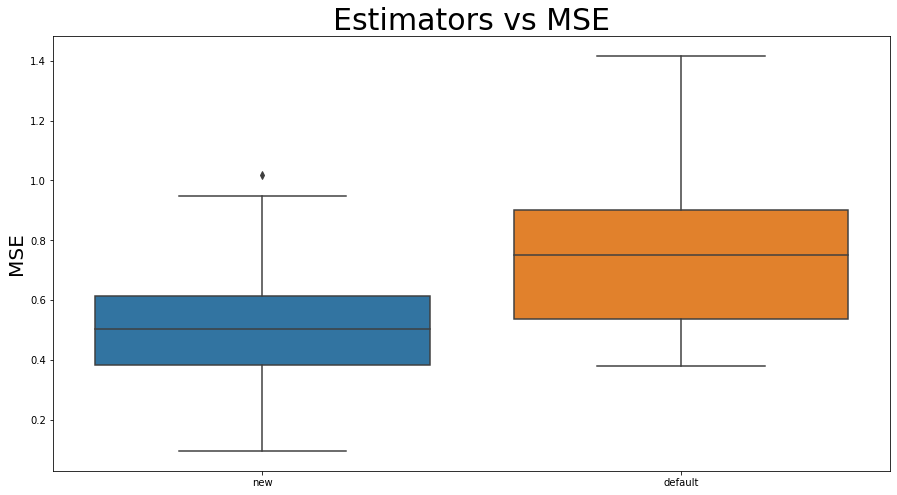

In [ ]:
XGB_params = XGB_res.best_params

models_XGB = {}
'''models_XGB['old'] = xgboost.XGBRegressor(n_estimators = 500,
                                        learning_rate = 0.1,
                                        max_depth = 5,
                                        min_child_weight = 3,
                                        n_jobs=-1)
'''
models_XGB['new'] = xgboost.XGBRegressor(**XGB_params, n_estimators = 500)

models_XGB['default'] = xgboost.XGBRegressor()

print(models_XGB)
results_XGB = train_and_test_regressor(models_XGB, XS_train, YS_train, XS_test, YS_test)
plot_model_comparison(results_XGB)

In [ ]:
optuna.visualization.plot_param_importances(XGB_res)

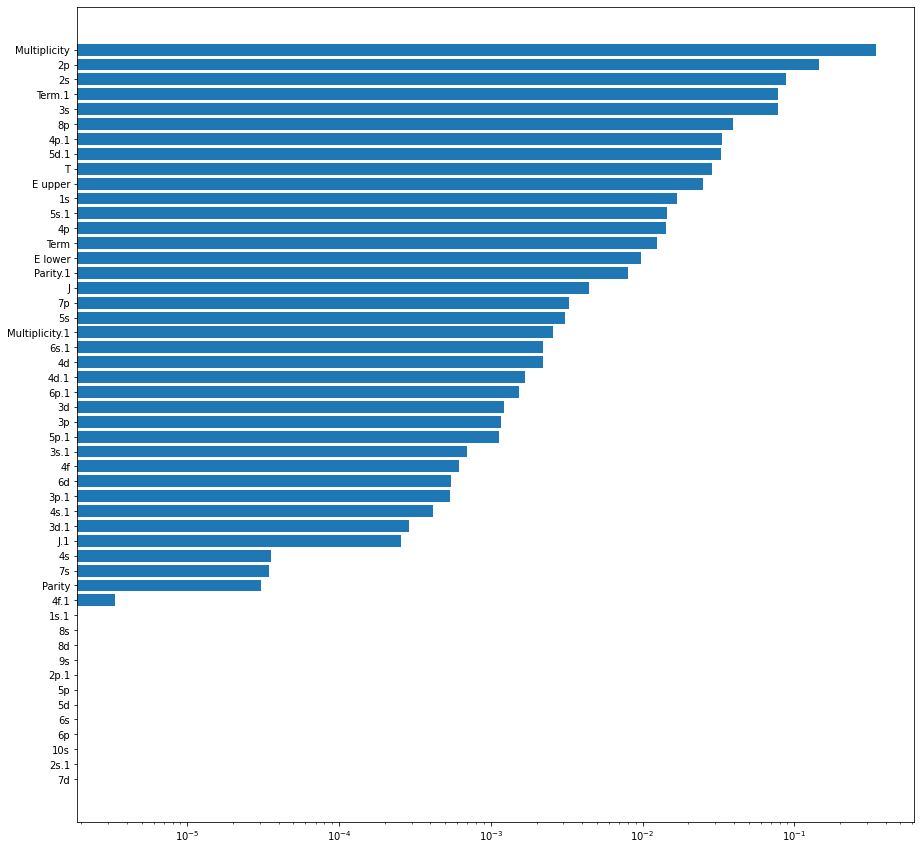

In [ ]:
'''test_score = np.zeros((500))
for i, y_pred in enumerate(models_XGB['new'].staged_predict(XW_test)):
    test_score[i] = models_XGB['new'].loss_(YW_test, y_pred)
plt.figure(figsize = (15, 7))
plt.plot(models_XGB['new'].train_score_, label = 'Train')
plt.plot(test_score, label = 'Test')
plt.semilogy()
plt.legend()
plt.show()
'''
feature_importance = models_XGB['new'].feature_importances_
sorted = np.argsort(feature_importance)
pos = np.arange(sorted.shape[0]) + 0.5

plt.figure(figsize = (15, 15))
plt.barh(pos, feature_importance[sorted])
plt.yticks(pos, np.array(XS_train.columns)[sorted])
plt.semilogx()
plt.show()

## TabNet

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
TabNet_params = {
    'n_d' : [1, 64],
    'n_steps' : [1, 25],
    'gamma' : [1., 2.],
    'n_independent' : [1, 20],
    'n_shared' : [1, 20],
    'momentum' : [1e-3, 0.4],
    'mask_type' : ['sparsemax', 'entmax'],
    'nfold' : 5,
    'squared_metrics' : False,
    'device_name' : 'cuda',
    'n_jobs' : -1
    }

model_name = TabNet

TabNet_res = main(X = XW_train, y = YW_train, model_name = model_name, params = TabNet_params, n_trials = 250)

'''with open(f'TabNet_{width_threshold}max_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)
'''
'''with open(f'TabNet_optimal_parameters_SHIFT', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)'''

with open(f'TabNet_Scaled_optimal_parameters', 'w') as fp:
    json.dump(TabNet_res.best_params, fp)

[I 2022-08-17 11:50:21,312] A new study created in memory with name: no-name-faba2f44-e967-4b7f-bb85-254666e5bbbc


Start hyperparameter optimization
{'device_name': 'cuda', 'n_d': 11, 'n_steps': 17, 'gamma': 1.8699841150179717, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.0018998828293584837, 'mask_type': 'sparsemax'}
{'device_name': 'cuda', 'n_d': 5, 'n_steps': 22, 'gamma': 1.8497949201144068, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.024469096380720468, 'mask_type': 'entmax'}


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 361.84687
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 104.56017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 162.90922
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 165.8973
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 85.89932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 56.51417
Best weights from best epoch are automatically used!


[I 2022-08-17 11:56:45,566] Trial 10 finished with value: 11.16416088644852 and parameters: {'n_d': 39, 'n_steps': 19, 'gamma': 1.8452387768913043, 'n_independent': 6, 'n_shared': 8, 'momentum': 0.010006356802010433, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 2.2295526830222685.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 1606.77165
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 160 with best_epoch = 140 and best_eval_mse = 465.32238
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 34071.88309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 45.0882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 3125.67893
Best weights from best epoch are automatically used!


[I 2022-08-17 12:02:18,896] Trial 9 finished with value: 63.663198594244385 and parameters: {'n_d': 23, 'n_steps': 13, 'gamma': 1.6355856195088303, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.0012755462092439594, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 2.2295526830222685.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 59.75666
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 38.01666
Best weights from best epoch are automatically used!


[I 2022-08-17 12:04:19,497] Trial 1 finished with value: 8.52851219712544 and parameters: {'n_d': 5, 'n_steps': 22, 'gamma': 1.8497949201144068, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.024469096380720468, 'mask_type': 'entmax'}. Best is trial 1 with value: 8.52851219712544.


{'device_name': 'cuda', 'n_d': 61, 'n_steps': 21, 'gamma': 1.1938918124277333, 'n_independent': 19, 'n_shared': 15, 'momentum': 0.001728709204044814, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 16.60171
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 19354.33555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 41.63286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 119 with best_epoch = 99 and best_eval_mse = 17603417623.14979
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 544.71848
Best weights from best epoch are automatically used!


[I 2022-08-17 12:14:02,996] Trial 0 finished with value: 42.61409865462825 and parameters: {'n_d': 11, 'n_steps': 17, 'gamma': 1.8699841150179717, 'n_independent': 6, 'n_shared': 10, 'momentum': 0.0018998828293584837, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 8.52851219712544.


{'device_name': 'cuda', 'n_d': 11, 'n_steps': 5, 'gamma': 1.7366889726791745, 'n_independent': 19, 'n_shared': 12, 'momentum': 0.0028895036515896332, 'mask_type': 'entmax'}

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 1881.39553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 298.39541
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1437.0906
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 2338301715.73695
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 988.82739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 2662.72738
Best weights from best 

[I 2022-08-17 12:22:48,596] Trial 3 finished with value: 36.3210815496406 and parameters: {'n_d': 11, 'n_steps': 5, 'gamma': 1.7366889726791745, 'n_independent': 19, 'n_shared': 12, 'momentum': 0.0028895036515896332, 'mask_type': 'entmax'}. Best is trial 1 with value: 8.52851219712544.


{'device_name': 'cuda', 'n_d': 6, 'n_steps': 16, 'gamma': 1.9915940751086856, 'n_independent': 18, 'n_shared': 3, 'momentum': 0.008474824231169659, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 38.24509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 7429801865.47376
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 14.79488
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 145895.36187
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 101302525123.83743
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 35.75783
Best weights 

[I 2022-08-17 12:36:49,388] Trial 4 finished with value: 80.93981440241059 and parameters: {'n_d': 6, 'n_steps': 16, 'gamma': 1.9915940751086856, 'n_independent': 18, 'n_shared': 3, 'momentum': 0.008474824231169659, 'mask_type': 'sparsemax'}. Best is trial 1 with value: 8.52851219712544.


{'device_name': 'cuda', 'n_d': 60, 'n_steps': 24, 'gamma': 1.6796563539364564, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.004862209587136535, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 12.99446
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 17.66878
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 10.77168
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 21.4841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 11.01284
Best weights from best epoch are automatically used!


[I 2022-08-17 12:39:26,653] Trial 5 finished with value: 3.8087768447134045 and parameters: {'n_d': 60, 'n_steps': 24, 'gamma': 1.6796563539364564, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.004862209587136535, 'mask_type': 'entmax'}. Best is trial 5 with value: 3.8087768447134045.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 5, 'gamma': 1.3852677049971809, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.00914899758087281, 'mask_type': 'entmax'}

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 83746477069.01468
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 23.71617
Best weights from best epoch are automatically used!


[I 2022-08-17 12:40:10,658] Trial 2 finished with value: 174980.11428912077 and parameters: {'n_d': 61, 'n_steps': 21, 'gamma': 1.1938918124277333, 'n_independent': 19, 'n_shared': 15, 'momentum': 0.001728709204044814, 'mask_type': 'sparsemax'}. Best is trial 5 with value: 3.8087768447134045.


{'device_name': 'cuda', 'n_d': 4, 'n_steps': 1, 'gamma': 1.8134755758502215, 'n_independent': 20, 'n_shared': 5, 'momentum': 0.03887840450941673, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.73024
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 8.62547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 1.8429
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 4.09556
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 74.86596
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 2.28566
Best weights from best epoch are automatical

[I 2022-08-17 12:42:53,980] Trial 6 finished with value: 5.54042146700038 and parameters: {'n_d': 57, 'n_steps': 5, 'gamma': 1.3852677049971809, 'n_independent': 12, 'n_shared': 3, 'momentum': 0.00914899758087281, 'mask_type': 'entmax'}. Best is trial 5 with value: 3.8087768447134045.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 24, 'gamma': 1.9004539043211879, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.005935151225686315, 'mask_type': 'entmax'}


[I 2022-08-17 12:43:06,321] Trial 7 finished with value: 1.603068483403175 and parameters: {'n_d': 4, 'n_steps': 1, 'gamma': 1.8134755758502215, 'n_independent': 20, 'n_shared': 5, 'momentum': 0.03887840450941673, 'mask_type': 'sparsemax'}. Best is trial 7 with value: 1.603068483403175.



Early stopping occurred at epoch 207 with best_epoch = 187 and best_eval_mse = 0.53061
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 20, 'gamma': 1.4602684533284762, 'n_independent': 19, 'n_shared': 20, 'momentum': 0.049008513485590266, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 1341.96133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 2644.70931
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 123.65764
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 1750.20118
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 93.19323
Best weights from best epoch 

[I 2022-08-17 12:57:21,549] Trial 8 finished with value: 41.391688125896685 and parameters: {'n_d': 48, 'n_steps': 24, 'gamma': 1.9004539043211879, 'n_independent': 13, 'n_shared': 1, 'momentum': 0.005935151225686315, 'mask_type': 'entmax'}. Best is trial 7 with value: 1.603068483403175.


{'device_name': 'cuda', 'n_d': 20, 'n_steps': 3, 'gamma': 1.9859717755815633, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.009585571722461664, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 7.82691
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 412.19804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 4.00411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 5.51562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 7.15212
Best weights from best epoch are automatically used!


[I 2022-08-17 13:00:16,405] Trial 10 finished with value: 2.4141382212387406 and parameters: {'n_d': 20, 'n_steps': 3, 'gamma': 1.9859717755815633, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.009585571722461664, 'mask_type': 'entmax'}. Best is trial 7 with value: 1.603068483403175.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 5.05855
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 9, 'gamma': 1.514708420029108, 'n_independent': 15, 'n_shared': 20, 'momentum': 0.1563970802703736, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 156.55674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 53.50066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 65.74647
Best weights from best epoch are automatically used!


[I 2022-08-17 13:05:00,422] Trial 9 finished with value: 12.33943064805694 and parameters: {'n_d': 24, 'n_steps': 20, 'gamma': 1.4602684533284762, 'n_independent': 19, 'n_shared': 20, 'momentum': 0.049008513485590266, 'mask_type': 'sparsemax'}. Best is trial 7 with value: 1.603068483403175.


{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.6365683243730325, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.3104892572514275, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 1.90748
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 4.63405
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 53.18346
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.49397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 3.27083
Best weights from best epoch are automatically used!


[I 2022-08-17 13:06:33,288] Trial 12 finished with value: 1.5252207448745112 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.6365683243730325, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.3104892572514275, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.



Early stopping occurred at epoch 245 with best_epoch = 225 and best_eval_mse = 0.17185
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 9, 'gamma': 1.62437759311888, 'n_independent': 15, 'n_shared': 7, 'momentum': 0.377489574582738, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 213.5928
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 121.0865
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 54.33735
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 4.74658
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 34.82089
Best weights from best epoch are automatic

[I 2022-08-17 13:12:17,554] Trial 11 finished with value: 8.498847595587737 and parameters: {'n_d': 33, 'n_steps': 9, 'gamma': 1.514708420029108, 'n_independent': 15, 'n_shared': 20, 'momentum': 0.1563970802703736, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.


{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.570150792695538, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.3888129645164609, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 3.30653
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.68857
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 5.5946
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 4.44592
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 4.56487
Best weights from best epoch are automatically used!


[I 2022-08-17 13:14:15,455] Trial 14 finished with value: 1.7144893591063493 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.570150792695538, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.3888129645164609, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.



Early stopping occurred at epoch 259 with best_epoch = 239 and best_eval_mse = 0.12936
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 22, 'n_steps': 9, 'gamma': 1.7051835389889556, 'n_independent': 15, 'n_shared': 6, 'momentum': 0.08487747972061155, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 198.49765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 124.00176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 63.5093
Best weights from best epoch are automatically used!


[I 2022-08-17 13:15:53,829] Trial 13 finished with value: 7.47546892789011 and parameters: {'n_d': 38, 'n_steps': 9, 'gamma': 1.62437759311888, 'n_independent': 15, 'n_shared': 7, 'momentum': 0.377489574582738, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.


{'device_name': 'cuda', 'n_d': 22, 'n_steps': 9, 'gamma': 1.031129799260914, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.06015412975151615, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 68.59299
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.77976
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 57.86045
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 5.931
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 45.28098
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 22.32759
Best weights from best epoch are automatical

[I 2022-08-17 13:20:14,034] Trial 15 finished with value: 8.100081200896808 and parameters: {'n_d': 22, 'n_steps': 9, 'gamma': 1.7051835389889556, 'n_independent': 15, 'n_shared': 6, 'momentum': 0.08487747972061155, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.


{'device_name': 'cuda', 'n_d': 15, 'n_steps': 1, 'gamma': 1.3191875800182875, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.025012731157470262, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 4.67808
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 1.40693
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.74852
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 5.88819
Best weights from best epoch are automatically used!


[I 2022-08-17 13:21:22,050] Trial 16 finished with value: 2.3312619166439417 and parameters: {'n_d': 22, 'n_steps': 9, 'gamma': 1.031129799260914, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.06015412975151615, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.


{'device_name': 'cuda', 'n_d': 2, 'n_steps': 1, 'gamma': 1.3957736793154218, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.16348582444293383, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 1.30107
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 24.53535
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 3.37792
Best weights from best epoch are automatically used!


[I 2022-08-17 13:21:49,811] Trial 17 finished with value: 2.166636348903651 and parameters: {'n_d': 15, 'n_steps': 1, 'gamma': 1.3191875800182875, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.025012731157470262, 'mask_type': 'sparsemax'}. Best is trial 12 with value: 1.5252207448745112.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.92808
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 2, 'n_steps': 13, 'gamma': 1.7413536337813555, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.15882561135620163, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 1.11099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 3.39709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 47.43522
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 0.52899
Best weights from best epoch are automatically used!


[I 2022-08-17 13:23:43,567] Trial 18 finished with value: 1.474185188573753 and parameters: {'n_d': 2, 'n_steps': 1, 'gamma': 1.3957736793154218, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.16348582444293383, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 3.64253
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 42, 'n_steps': 12, 'gamma': 1.2316976246413514, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.11378294413525152, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 55.15788
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 56.96779
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 20 with best_epoch = 0 and best_eval_mse = 44.21043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 25 with best_epoch = 5 and best_eval_mse = 50.4763
Best weights from best epoch are automatically used!


[I 2022-08-17 13:26:30,867] Trial 19 finished with value: 7.123123800672457 and parameters: {'n_d': 2, 'n_steps': 13, 'gamma': 1.7413536337813555, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.15882561135620163, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 44, 'n_steps': 6, 'gamma': 1.2347747289734257, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.17573414443629012, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 3.91166
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 164.26497
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 2.30387
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 79.16824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 6.37953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 16.953
Best weights from best epoch are automa

[I 2022-08-17 13:33:22,399] Trial 20 finished with value: 6.8524985830813305 and parameters: {'n_d': 42, 'n_steps': 12, 'gamma': 1.2316976246413514, 'n_independent': 10, 'n_shared': 10, 'momentum': 0.11378294413525152, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 1, 'n_steps': 5, 'gamma': 1.4382717840636552, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.22766051829441758, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 60.18434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 3.15741
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 3.87196
Best weights from best epoch are automatically used!


[I 2022-08-17 13:35:41,947] Trial 21 finished with value: 3.1083997306711533 and parameters: {'n_d': 44, 'n_steps': 6, 'gamma': 1.2347747289734257, 'n_independent': 9, 'n_shared': 16, 'momentum': 0.17573414443629012, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 1, 'n_steps': 3, 'gamma': 1.4435931458708837, 'n_independent': 13, 'n_shared': 8, 'momentum': 0.25194108104859203, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 4.98632
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 2.73149
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 2.89007
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 5.09523
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 4.97415
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.31743
Best weights from best epoch are automatical

[I 2022-08-17 13:39:06,799] Trial 23 finished with value: 1.9705893684272382 and parameters: {'n_d': 1, 'n_steps': 3, 'gamma': 1.4435931458708837, 'n_independent': 13, 'n_shared': 8, 'momentum': 0.25194108104859203, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 7.5494
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 3, 'gamma': 1.8038214667318928, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.055609756555506526, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 3.3091
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 94 with best_epoch = 74 and best_eval_mse = 1.62474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 1.25117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 4.32505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.73948
Best weights from best epoch are automatica

[I 2022-08-17 13:40:43,080] Trial 22 finished with value: 2.0712410997603445 and parameters: {'n_d': 1, 'n_steps': 5, 'gamma': 1.4382717840636552, 'n_independent': 13, 'n_shared': 15, 'momentum': 0.22766051829441758, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.5861292154370863, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.04074775150222321, 'mask_type': 'sparsemax'}


[I 2022-08-17 13:40:51,245] Trial 24 finished with value: 1.5438384060793862 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.8038214667318928, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.055609756555506526, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 5.69477
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 3, 'gamma': 1.5696909389709037, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.08893745415003153, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 1.84684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.34908
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 5.50067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 222 and best_eval_mse = 0.59067
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 3.6267
Best weights from best epoch are automatically

[I 2022-08-17 13:41:50,319] Trial 25 finished with value: 1.8188262194823388 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.5861292154370863, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.04074775150222321, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.45882
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 7, 'gamma': 1.3602055309160228, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.09227126990201964, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 2.09586
Best weights from best epoch are automatically used!


[I 2022-08-17 13:42:06,609] Trial 26 finished with value: 1.669316211623111 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.5696909389709037, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.08893745415003153, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.96915
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 16, 'n_steps': 7, 'gamma': 1.3179375009104215, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.1090364291865399, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 5.09978
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 4.64563
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 2.45368
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 4.86551
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 4.68192
Best weights from best epoch are automaticall

[I 2022-08-17 13:44:54,489] Trial 27 finished with value: 2.0464379152894647 and parameters: {'n_d': 29, 'n_steps': 7, 'gamma': 1.3602055309160228, 'n_independent': 2, 'n_shared': 8, 'momentum': 0.09227126990201964, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 13, 'n_steps': 3, 'gamma': 1.8011132764393158, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.015901170671232367, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 5.96573
Best weights from best epoch are automatically used!


[I 2022-08-17 13:45:06,972] Trial 28 finished with value: 2.976401487009115 and parameters: {'n_d': 16, 'n_steps': 7, 'gamma': 1.3179375009104215, 'n_independent': 3, 'n_shared': 8, 'momentum': 0.1090364291865399, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 12, 'n_steps': 3, 'gamma': 1.7916608870039479, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.26878929782649763, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 5.85122
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 3.70511
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.51146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.74776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.1833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 4.47177
Best weights from best epoch are automatically 

[I 2022-08-17 13:46:49,502] Trial 29 finished with value: 2.134268164771871 and parameters: {'n_d': 13, 'n_steps': 3, 'gamma': 1.8011132764393158, 'n_independent': 3, 'n_shared': 13, 'momentum': 0.015901170671232367, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.33056
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 11, 'gamma': 1.645969475881923, 'n_independent': 7, 'n_shared': 12, 'momentum': 0.3062336024551019, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 103 with best_epoch = 83 and best_eval_mse = 2.6568
Best weights from best epoch are automatically used!


[I 2022-08-17 13:47:26,012] Trial 30 finished with value: 1.8096247790328661 and parameters: {'n_d': 12, 'n_steps': 3, 'gamma': 1.7916608870039479, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.26878929782649763, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 2.54228
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 7, 'n_steps': 1, 'gamma': 1.9050566830804385, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.03815724788689899, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 7.38559
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 239 with best_epoch = 219 and best_eval_mse = 0.25669
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 38.61339
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 5.901
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 3.32588
Best weights from best epoch are automatically 

[I 2022-08-17 13:49:04,301] Trial 32 finished with value: 1.6440676912205359 and parameters: {'n_d': 7, 'n_steps': 1, 'gamma': 1.9050566830804385, 'n_independent': 7, 'n_shared': 6, 'momentum': 0.03815724788689899, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 0.55228
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 8, 'n_steps': 2, 'gamma': 1.636771797708915, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.060384885155052866, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 2.27942
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.5742
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 4.94701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 3.89984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 161 with best_epoch = 141 and best_eval_mse = 3.34399
Best weights from best epoch are automaticall

[I 2022-08-17 13:51:15,792] Trial 33 finished with value: 1.7675752749873208 and parameters: {'n_d': 8, 'n_steps': 2, 'gamma': 1.636771797708915, 'n_independent': 7, 'n_shared': 9, 'momentum': 0.060384885155052866, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 2.32466
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 18, 'n_steps': 4, 'gamma': 1.8514656948735593, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.0011292427455948917, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 2181.70235
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 34.23836
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 5525.73515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 11489.14322
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 114.66101
Best weights from best epoch ar

[I 2022-08-17 13:54:38,127] Trial 34 finished with value: 77.51492951683255 and parameters: {'n_d': 18, 'n_steps': 4, 'gamma': 1.8514656948735593, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.0011292427455948917, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.
[I 2022-08-17 13:54:38,257] Trial 31 finished with value: 6.152595423783561 and parameters: {'n_d': 18, 'n_steps': 11, 'gamma': 1.645969475881923, 'n_independent': 7, 'n_shared': 12, 'momentum': 0.3062336024551019, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 52, 'n_steps': 7, 'gamma': 1.7818628977697641, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.028537844891109464, 'mask_type': 'entmax'}
{'device_name': 'cuda', 'n_d': 9, 'n_steps': 15, 'gamma': 1.821256738296877, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.028938480142668796, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 5.8117
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 5.02646
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 11.60313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5.96771
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 56.5247
Best weights from 

[I 2022-08-17 13:56:43,748] Trial 35 finished with value: 2.525190053634055 and parameters: {'n_d': 52, 'n_steps': 7, 'gamma': 1.7818628977697641, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.028537844891109464, 'mask_type': 'entmax'}. Best is trial 18 with value: 1.474185188573753.



Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.51138
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 10, 'n_steps': 19, 'gamma': 1.9413523603720484, 'n_independent': 20, 'n_shared': 4, 'momentum': 0.01720643298663592, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 138.68899
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 224.0724
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 143.54333
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 98.98418
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 145.82589
Best weights from best epoch are auto

[I 2022-08-17 14:04:39,245] Trial 36 finished with value: 10.604560173652573 and parameters: {'n_d': 9, 'n_steps': 15, 'gamma': 1.821256738296877, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.028938480142668796, 'mask_type': 'entmax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 5, 'n_steps': 5, 'gamma': 1.9343524070612148, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.06181839087257831, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 122 with best_epoch = 102 and best_eval_mse = 2.99256
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 3.15493
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 2.60386
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 3.89515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 112.02354
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 6.53535
Best weights from best epoch are automatic

[I 2022-08-17 14:08:36,020] Trial 38 finished with value: 1.9299617226604802 and parameters: {'n_d': 5, 'n_steps': 5, 'gamma': 1.9343524070612148, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.06181839087257831, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 18, 'gamma': 1.5277458565581075, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.0128765210249791, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 348.2744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 52.48088
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 194.54493
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 283.31184
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 135.63286
Best weights from best epoch are automatically used!


[I 2022-08-17 14:16:21,717] Trial 37 finished with value: 10.70628697659861 and parameters: {'n_d': 10, 'n_steps': 19, 'gamma': 1.9413523603720484, 'n_independent': 20, 'n_shared': 4, 'momentum': 0.01720643298663592, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.5124281251615732, 'n_independent': 14, 'n_shared': 9, 'momentum': 0.13879473730737085, 'mask_type': 'entmax'}

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 111.74706
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 2.34561
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.64288
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 1.40668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.84366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 470.26523
Best weights from best epoch are automaticall

[I 2022-08-17 14:18:41,863] Trial 39 finished with value: 16.339713081559324 and parameters: {'n_d': 33, 'n_steps': 18, 'gamma': 1.5277458565581075, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.0128765210249791, 'mask_type': 'sparsemax'}. Best is trial 18 with value: 1.474185188573753.


{'device_name': 'cuda', 'n_d': 4, 'n_steps': 2, 'gamma': 1.7403809079195005, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.1854117333605913, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.39147
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 2.27853
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.37133
Best weights from best epoch are automatically used!


[I 2022-08-17 14:19:36,006] Trial 40 finished with value: 1.4276644091269284 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.5124281251615732, 'n_independent': 14, 'n_shared': 9, 'momentum': 0.13879473730737085, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.



Early stopping occurred at epoch 133 with best_epoch = 113 and best_eval_mse = 0.69644
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 2, 'gamma': 1.7279911824908196, 'n_independent': 14, 'n_shared': 11, 'momentum': 0.20204940653538866, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 5.0728
Best weights from best epoch are automatically used!


[I 2022-08-17 14:20:09,038] Trial 41 finished with value: 1.9711482854983458 and parameters: {'n_d': 4, 'n_steps': 2, 'gamma': 1.7403809079195005, 'n_independent': 12, 'n_shared': 2, 'momentum': 0.1854117333605913, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 2.11529
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 4, 'gamma': 1.6836475330356009, 'n_independent': 16, 'n_shared': 11, 'momentum': 0.12010551678764486, 'mask_type': 'entmax'}

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.22219
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 58.15393
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 2.95988
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 108.25721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 4.60444
Best weights from best epoch are automatically

[I 2022-08-17 14:22:30,531] Trial 42 finished with value: 1.6918591347098844 and parameters: {'n_d': 30, 'n_steps': 2, 'gamma': 1.7279911824908196, 'n_independent': 14, 'n_shared': 11, 'momentum': 0.20204940653538866, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 1.50163
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 4, 'gamma': 1.472307496854438, 'n_independent': 16, 'n_shared': 7, 'momentum': 0.13364579441338764, 'mask_type': 'entmax'}

Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 1.37123
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 113 with best_epoch = 93 and best_eval_mse = 1.39341
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 3.1827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 1.13364
Best weights from best epoch are automatically used!


[I 2022-08-17 14:25:12,071] Trial 43 finished with value: 5.819402111369536 and parameters: {'n_d': 26, 'n_steps': 4, 'gamma': 1.6836475330356009, 'n_independent': 16, 'n_shared': 11, 'momentum': 0.12010551678764486, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 4, 'gamma': 1.4859068420441555, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.13497556029035196, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 55.56488
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 2.79244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 74.9252
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 2.09255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 16.77676
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.68876
Best weights from best epoch are automatical

[I 2022-08-17 14:28:23,309] Trial 44 finished with value: 2.8242690042829084 and parameters: {'n_d': 38, 'n_steps': 4, 'gamma': 1.472307496854438, 'n_independent': 16, 'n_shared': 7, 'momentum': 0.13364579441338764, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.406632167059089, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.07264800699402539, 'mask_type': 'entmax'}

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 0.72679
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 1.12397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 134 with best_epoch = 114 and best_eval_mse = 2.06255
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 58.32465
Best weights from best epoch are automatically used!


[I 2022-08-17 14:30:02,108] Trial 45 finished with value: 4.413982529811145 and parameters: {'n_d': 39, 'n_steps': 4, 'gamma': 1.4859068420441555, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.13497556029035196, 'mask_type': 'entmax'}. Best is trial 40 with value: 1.4276644091269284.


{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.361898833772984, 'n_independent': 18, 'n_shared': 9, 'momentum': 0.07179006416125973, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.69066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 202 with best_epoch = 182 and best_eval_mse = 0.25273
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.66678
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.00487
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 3.26664
Best weights from best epoch are automatically used!


[I 2022-08-17 14:31:03,879] Trial 46 finished with value: 1.0915164700586661 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.406632167059089, 'n_independent': 20, 'n_shared': 7, 'momentum': 0.07264800699402539, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.64463
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 2, 'gamma': 1.3647839905181862, 'n_independent': 18, 'n_shared': 9, 'momentum': 0.06768527695014019, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 1.74184
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 3.88534
Best weights from best epoch are automatically used!


[I 2022-08-17 14:31:38,093] Trial 47 finished with value: 1.5808272528117002 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.361898833772984, 'n_independent': 18, 'n_shared': 9, 'momentum': 0.07179006416125973, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 2.26085
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 6, 'gamma': 1.4059345946331672, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.32746090604887723, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.98055
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 5.39076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 1.80542
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 1.87833
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 2.16112
Best weights from best epoch are automatically u

[I 2022-08-17 14:34:51,240] Trial 48 finished with value: 1.5870257490734285 and parameters: {'n_d': 35, 'n_steps': 2, 'gamma': 1.3647839905181862, 'n_independent': 18, 'n_shared': 9, 'momentum': 0.06768527695014019, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 48, 'n_steps': 6, 'gamma': 1.3998685717134793, 'n_independent': 12, 'n_shared': 12, 'momentum': 0.31473917788216466, 'mask_type': 'entmax'}

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 5.15822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 4.21053
Best weights from best epoch are automatically used!


[I 2022-08-17 14:36:01,095] Trial 49 finished with value: 2.000746283547511 and parameters: {'n_d': 36, 'n_steps': 6, 'gamma': 1.4059345946331672, 'n_independent': 8, 'n_shared': 9, 'momentum': 0.32746090604887723, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 22, 'gamma': 1.1152447173275013, 'n_independent': 12, 'n_shared': 14, 'momentum': 0.003820402034761852, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 6.72801
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 6.87941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 89.04939
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 54.69827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 273420.54402
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 4.68117
Best weights from best epoch are automa

[I 2022-08-17 14:41:16,005] Trial 50 finished with value: 4.842545876512604 and parameters: {'n_d': 48, 'n_steps': 6, 'gamma': 1.3998685717134793, 'n_independent': 12, 'n_shared': 12, 'momentum': 0.31473917788216466, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.2909954934159302, 'n_independent': 19, 'n_shared': 10, 'momentum': 0.07883437920130225, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.41684
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.30342
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 2.3649
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 1.13689
Best weights from best epoch are automatically used!


[I 2022-08-17 14:43:43,280] Trial 52 finished with value: 1.5955027353250313 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.2909954934159302, 'n_independent': 19, 'n_shared': 10, 'momentum': 0.07883437920130225, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.07689
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.550501386613889, 'n_independent': 18, 'n_shared': 6, 'momentum': 0.04899567552646516, 'mask_type': 'entmax'}

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 1.82108
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 3.92528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 103749.30562
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 218 with best_epoch = 198 and best_eval_mse = 0.41927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 0.61241
Best weights from best epoch are automati

[I 2022-08-17 14:48:43,280] Trial 53 finished with value: 1.1328234478502013 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.550501386613889, 'n_independent': 18, 'n_shared': 6, 'momentum': 0.04899567552646516, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 0.81602
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 22, 'gamma': 1.533920075390621, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.04396093903715248, 'mask_type': 'entmax'}

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 29973.71573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 217.01954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 91.90632
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 198015.58099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 292.37432
Best weights from best epoch are a

[I 2022-08-17 15:00:59,180] Trial 51 finished with value: 357.99956541057065 and parameters: {'n_d': 45, 'n_steps': 22, 'gamma': 1.1152447173275013, 'n_independent': 12, 'n_shared': 14, 'momentum': 0.003820402034761852, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 23, 'n_steps': 2, 'gamma': 1.515861198492638, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.045982986497688415, 'mask_type': 'entmax'}

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.05026
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 1.9226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 6.9768
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 2.01855
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 231.15058
Best weights from best epoch are automatically used!


[I 2022-08-17 15:03:43,252] Trial 55 finished with value: 1.6047394079488608 and parameters: {'n_d': 23, 'n_steps': 2, 'gamma': 1.515861198492638, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.045982986497688415, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 1.30674
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 25, 'gamma': 1.5513377842056455, 'n_independent': 14, 'n_shared': 7, 'momentum': 0.04859716151210483, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 184.09252
Best weights from best epoch are automatically used!


[I 2022-08-17 15:06:21,495] Trial 54 finished with value: 14.0378049756021 and parameters: {'n_d': 41, 'n_steps': 22, 'gamma': 1.533920075390621, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.04396093903715248, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 33, 'n_steps': 3, 'gamma': 1.5998230617561249, 'n_independent': 14, 'n_shared': 8, 'momentum': 0.10113918842633922, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 77.04804
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 2.77826
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 5.10338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.71056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 0.74995
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 378.7816
Best weights from best epoch are automatically

[I 2022-08-17 15:11:05,543] Trial 57 finished with value: 1.6430321725939838 and parameters: {'n_d': 33, 'n_steps': 3, 'gamma': 1.5998230617561249, 'n_independent': 14, 'n_shared': 8, 'momentum': 0.10113918842633922, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 2, 'gamma': 1.428060647852125, 'n_independent': 17, 'n_shared': 5, 'momentum': 0.1472506300897404, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.35747
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.80176
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.46375
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 772.74536
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 1.88786
Best weights from best epoch are automatically used!


[I 2022-08-17 15:13:36,848] Trial 58 finished with value: 1.7945782349323274 and parameters: {'n_d': 63, 'n_steps': 2, 'gamma': 1.428060647852125, 'n_independent': 17, 'n_shared': 5, 'momentum': 0.1472506300897404, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 5.07405
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 5, 'gamma': 1.5684223481906137, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.05443038371906284, 'mask_type': 'entmax'}

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 3.77268
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 1433.67073
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.66083
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 268.56056
Best weights from best epoch are automatically used!


[I 2022-08-17 15:19:23,126] Trial 56 finished with value: 22.057994661468236 and parameters: {'n_d': 33, 'n_steps': 25, 'gamma': 1.5513377842056455, 'n_independent': 14, 'n_shared': 7, 'momentum': 0.04859716151210483, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 21, 'n_steps': 5, 'gamma': 1.4893560721717123, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.2041613842009351, 'mask_type': 'entmax'}

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.92433
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 5.0494
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 6.85755
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 154 with best_epoch = 134 and best_eval_mse = 1.20407
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 2.4714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 2.29229
Best weights from best epoch are automatically

[I 2022-08-17 15:22:02,281] Trial 59 finished with value: 1.2656014580065433 and parameters: {'n_d': 32, 'n_steps': 5, 'gamma': 1.5684223481906137, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.05443038371906284, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 35, 'n_steps': 5, 'gamma': 1.613866727025965, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.2147166925023272, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 51.5145
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 5.66398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 4.05825
Best weights from best epoch are automatically used!


[I 2022-08-17 15:23:17,600] Trial 60 finished with value: 3.1259439942697718 and parameters: {'n_d': 21, 'n_steps': 5, 'gamma': 1.4893560721717123, 'n_independent': 16, 'n_shared': 3, 'momentum': 0.2041613842009351, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.6534379152861678, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.054011083332482675, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 2.63286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.02558
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 4.68089
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 1.22225
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 5.33489
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 173 with best_epoch = 153 and best_eval_mse = 0.29781
Best weights from best epoch are automatically

[I 2022-08-17 15:24:47,592] Trial 62 finished with value: 1.1628353576057233 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.6534379152861678, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.054011083332482675, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 2.33352
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.6664910856198203, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.03712945487935792, 'mask_type': 'entmax'}

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 1.14629
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.4841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 2.56807
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 3.52183
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.5552
Best weights from best epoch are automatically used

[I 2022-08-17 15:25:48,478] Trial 63 finished with value: 1.716275851684038 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.6664910856198203, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.03712945487935792, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.54185
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 1, 'gamma': 1.6102147123753974, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.03028249822658852, 'mask_type': 'entmax'}

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 0.82114
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 2.88561
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 4.17136
Best weights from best epoch are automatically used!


[I 2022-08-17 15:26:21,007] Trial 61 finished with value: 2.0996193551725693 and parameters: {'n_d': 35, 'n_steps': 5, 'gamma': 1.613866727025965, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.2147166925023272, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 39, 'n_steps': 2, 'gamma': 1.5714632017545898, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.022163524998028254, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.15768
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5.24607
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 1.39341
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.2543
Best weights from best epoch are automatically used!


[I 2022-08-17 15:27:28,857] Trial 64 finished with value: 1.2699151833349522 and parameters: {'n_d': 36, 'n_steps': 1, 'gamma': 1.6102147123753974, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.03028249822658852, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 1.44332
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 41, 'n_steps': 2, 'gamma': 1.566752017022886, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.020946271186761893, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 1.61238
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 2.03415
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 3.20757
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.79082
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 2.99258
Best weights from best epoch are automatically us

[I 2022-08-17 15:28:38,233] Trial 65 finished with value: 1.483321338802295 and parameters: {'n_d': 39, 'n_steps': 2, 'gamma': 1.5714632017545898, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.022163524998028254, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 0.7832
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 36, 'n_steps': 4, 'gamma': 1.4552424020861126, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.030581834019337877, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 2.56567
Best weights from best epoch are automatically used!


[I 2022-08-17 15:29:17,394] Trial 66 finished with value: 1.5689262179579804 and parameters: {'n_d': 41, 'n_steps': 2, 'gamma': 1.566752017022886, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.020946271186761893, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 2.00546
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 4, 'gamma': 1.446750304761347, 'n_independent': 8, 'n_shared': 10, 'momentum': 0.07644125235773924, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 5.53139
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 2.47811
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 3.36917
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.31316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 1.45822
Best weights from best epoch are automatically u

[I 2022-08-17 15:33:13,254] Trial 67 finished with value: 1.912222448349577 and parameters: {'n_d': 36, 'n_steps': 4, 'gamma': 1.4552424020861126, 'n_independent': 11, 'n_shared': 10, 'momentum': 0.030581834019337877, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 45, 'n_steps': 3, 'gamma': 1.498419115279143, 'n_independent': 8, 'n_shared': 19, 'momentum': 0.05335724533623351, 'mask_type': 'entmax'}

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 2.27469
Best weights from best epoch are automatically used!


[I 2022-08-17 15:33:26,508] Trial 68 finished with value: 1.3949650186805453 and parameters: {'n_d': 57, 'n_steps': 4, 'gamma': 1.446750304761347, 'n_independent': 8, 'n_shared': 10, 'momentum': 0.07644125235773924, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 58, 'n_steps': 3, 'gamma': 1.4946252150098662, 'n_independent': 8, 'n_shared': 6, 'momentum': 0.05338039709255062, 'mask_type': 'entmax'}

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.17195
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 2.40668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 1.32778
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 5.79751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 2.36953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 2.65554
Best weights from best epoch are automatically us

[I 2022-08-17 15:35:33,668] Trial 70 finished with value: 1.6690954874373294 and parameters: {'n_d': 58, 'n_steps': 3, 'gamma': 1.4946252150098662, 'n_independent': 8, 'n_shared': 6, 'momentum': 0.05338039709255062, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 3.14104
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 10, 'gamma': 1.6046976197119234, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.07571527415319951, 'mask_type': 'entmax'}

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 72.74407
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 4.78311
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 2.15059
Best weights from best epoch are automatically used!


[I 2022-08-17 15:37:21,448] Trial 69 finished with value: 3.0726932114012975 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.498419115279143, 'n_independent': 8, 'n_shared': 19, 'momentum': 0.05335724533623351, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.4286699411569375, 'n_independent': 13, 'n_shared': 10, 'momentum': 0.034909569881166516, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.18491
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 126 with best_epoch = 106 and best_eval_mse = 5.22057
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.49486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.01077
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 64.36991
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 1.83432
Best weights from best epoch are automatical

[I 2022-08-17 15:39:12,163] Trial 72 finished with value: 1.4789960660043013 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.4286699411569375, 'n_independent': 13, 'n_shared': 10, 'momentum': 0.034909569881166516, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 2.44904
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 8, 'gamma': 1.3249327715694685, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.07874052221821105, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 30.25347
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 39.16235
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 127 with best_epoch = 107 and best_eval_mse = 1.73648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 34.52192
Best weights from best epoch are automatically used!


[I 2022-08-17 15:41:28,824] Trial 71 finished with value: 5.588355546146518 and parameters: {'n_d': 55, 'n_steps': 10, 'gamma': 1.6046976197119234, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.07571527415319951, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 50, 'n_steps': 4, 'gamma': 1.3255742967224005, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.09812267877930703, 'mask_type': 'entmax'}

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 1.87581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 3.26244
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 2.54859
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 166.72909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.49828
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 3.24372
Best weights from best epoch are automatical

[I 2022-08-17 15:46:55,986] Trial 74 finished with value: 1.1020536055986936 and parameters: {'n_d': 50, 'n_steps': 4, 'gamma': 1.3255742967224005, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.09812267877930703, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 53, 'n_steps': 4, 'gamma': 1.289342203035372, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.0849008532884742, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.51911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 2.24432
Best weights from best epoch are automatically used!


[I 2022-08-17 15:47:41,669] Trial 73 finished with value: 3.867095633393543 and parameters: {'n_d': 55, 'n_steps': 8, 'gamma': 1.3249327715694685, 'n_independent': 9, 'n_shared': 9, 'momentum': 0.07874052221821105, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 4, 'gamma': 1.54447258877121, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.09638418347810469, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.53066
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 2.57656
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.98412
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 6.26908
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 6.38853
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.07721
Best weights from best epoch are automatically use

[I 2022-08-17 15:49:34,118] Trial 75 finished with value: 1.8764609834894834 and parameters: {'n_d': 53, 'n_steps': 4, 'gamma': 1.289342203035372, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.0849008532884742, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 6, 'gamma': 1.662393745098059, 'n_independent': 11, 'n_shared': 7, 'momentum': 0.100418752865272, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.57574
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.93977
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 3.78077
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 6.24395
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 27 with best_epoch = 7 and best_eval_mse = 120.15262
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 142 with best_epoch = 122 and best_eval_mse = 1.57892
Best weights from best epoch are automatically u

[I 2022-08-17 15:52:10,041] Trial 76 finished with value: 1.8449308094995245 and parameters: {'n_d': 26, 'n_steps': 4, 'gamma': 1.54447258877121, 'n_independent': 11, 'n_shared': 8, 'momentum': 0.09638418347810469, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 49, 'n_steps': 15, 'gamma': 1.6962833776514912, 'n_independent': 20, 'n_shared': 5, 'momentum': 0.0644646710273849, 'mask_type': 'entmax'}

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 5.57316
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 5.09165
Best weights from best epoch are automatically used!


[I 2022-08-17 15:53:40,869] Trial 77 finished with value: 3.958400614107809 and parameters: {'n_d': 49, 'n_steps': 6, 'gamma': 1.662393745098059, 'n_independent': 11, 'n_shared': 7, 'momentum': 0.100418752865272, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 63, 'n_steps': 14, 'gamma': 1.2337634063710528, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.03303329378009905, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 106.64583
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 97.17728
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 22.98351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 30.66889
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 232.35434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 19.79074
Best weights from best epoch are automati

[I 2022-08-17 15:59:29,532] Trial 79 finished with value: 6.360555001809088 and parameters: {'n_d': 63, 'n_steps': 14, 'gamma': 1.2337634063710528, 'n_independent': 6, 'n_shared': 5, 'momentum': 0.03303329378009905, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 3, 'gamma': 1.1678209791339884, 'n_independent': 10, 'n_shared': 6, 'momentum': 0.02574002520247391, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 4.92813
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 5.17001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5.72043
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 3.3814
Best weights from best epoch are automatically used!


[I 2022-08-17 16:01:11,351] Trial 80 finished with value: 2.0936047707129624 and parameters: {'n_d': 28, 'n_steps': 3, 'gamma': 1.1678209791339884, 'n_independent': 10, 'n_shared': 6, 'momentum': 0.02574002520247391, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 3.04055
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.705134122145164, 'n_independent': 6, 'n_shared': 11, 'momentum': 0.06351585738352897, 'mask_type': 'entmax'}

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 175.15926
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 267 with best_epoch = 247 and best_eval_mse = 0.3526
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 1.89519
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 3.01359
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.14532
Best weights from best epoch are automatically 

[I 2022-08-17 16:03:30,710] Trial 81 finished with value: 1.205552005205306 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.705134122145164, 'n_independent': 6, 'n_shared': 11, 'momentum': 0.06351585738352897, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.30012
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.693274020937445, 'n_independent': 5, 'n_shared': 13, 'momentum': 0.061004364863290424, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 2.90796
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 3.70444
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 1.37056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 94.66671
Best weights from best epoch are automatically used!


[I 2022-08-17 16:04:16,964] Trial 78 finished with value: 17.781193485332903 and parameters: {'n_d': 49, 'n_steps': 15, 'gamma': 1.6962833776514912, 'n_independent': 20, 'n_shared': 5, 'momentum': 0.0644646710273849, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 59, 'n_steps': 1, 'gamma': 1.6285180280395426, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.043541250721032064, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.30181
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.09832
Best weights from best epoch are automatically used!


[I 2022-08-17 16:04:34,178] Trial 82 finished with value: 1.6204706536112685 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.693274020937445, 'n_independent': 5, 'n_shared': 13, 'momentum': 0.061004364863290424, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 3.18446
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 2, 'gamma': 1.6304238745279596, 'n_independent': 7, 'n_shared': 11, 'momentum': 0.12232137391157251, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 5.52108
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.05593
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 0.80587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.41698
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 2.95692
Best weights from best epoch are automatically 

[I 2022-08-17 16:06:02,630] Trial 84 finished with value: 1.5403594206586033 and parameters: {'n_d': 61, 'n_steps': 2, 'gamma': 1.6304238745279596, 'n_independent': 7, 'n_shared': 11, 'momentum': 0.12232137391157251, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.05275
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.5861579168722946, 'n_independent': 6, 'n_shared': 12, 'momentum': 0.05225209975532392, 'mask_type': 'entmax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 0.90605
Best weights from best epoch are automatically used!


[I 2022-08-17 16:06:32,672] Trial 83 finished with value: 1.402480180268237 and parameters: {'n_d': 59, 'n_steps': 1, 'gamma': 1.6285180280395426, 'n_independent': 5, 'n_shared': 11, 'momentum': 0.043541250721032064, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.20944
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.7609070522111203, 'n_independent': 4, 'n_shared': 11, 'momentum': 0.04091912623932531, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.14744
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 1.23151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 5.09962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.40767
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 1.03006
Best weights from best epoch are automatica

[I 2022-08-17 16:07:52,099] Trial 86 finished with value: 1.7540122896916628 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.7609070522111203, 'n_independent': 4, 'n_shared': 11, 'momentum': 0.04091912623932531, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 2.83232
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 5, 'gamma': 1.7099112202410172, 'n_independent': 6, 'n_shared': 12, 'momentum': 0.052891405636400796, 'mask_type': 'entmax'}


[I 2022-08-17 16:07:59,050] Trial 85 finished with value: 1.122776794009698 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.5861579168722946, 'n_independent': 6, 'n_shared': 12, 'momentum': 0.05225209975532392, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.06023
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 5, 'gamma': 1.654136601219715, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.07103349231245062, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 3.47861
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 3.33796
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 5.72239
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 3.78099
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 3.35884
Best weights from best epoch are automatically use

[I 2022-08-17 16:12:16,813] Trial 87 finished with value: 2.2414276412933325 and parameters: {'n_d': 60, 'n_steps': 5, 'gamma': 1.7099112202410172, 'n_independent': 6, 'n_shared': 12, 'momentum': 0.052891405636400796, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 3, 'gamma': 1.6642746033400835, 'n_independent': 8, 'n_shared': 14, 'momentum': 0.0704085330274215, 'mask_type': 'entmax'}

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.62919
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 3.3974
Best weights from best epoch are automatically used!


[I 2022-08-17 16:13:11,337] Trial 88 finished with value: 1.7452774741559296 and parameters: {'n_d': 52, 'n_steps': 5, 'gamma': 1.654136601219715, 'n_independent': 7, 'n_shared': 10, 'momentum': 0.07103349231245062, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 64, 'n_steps': 3, 'gamma': 1.585286455262827, 'n_independent': 4, 'n_shared': 12, 'momentum': 0.01619432425153583, 'mask_type': 'entmax'}

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 1.1829
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 2.98397
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 5.45971
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 1.94793
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.58793
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 7.88841
Best weights from best epoch are automatically

[I 2022-08-17 16:15:56,741] Trial 89 finished with value: 1.851551030056903 and parameters: {'n_d': 64, 'n_steps': 3, 'gamma': 1.6642746033400835, 'n_independent': 8, 'n_shared': 14, 'momentum': 0.0704085330274215, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 2, 'gamma': 1.4638540574867493, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.01748019145789381, 'mask_type': 'entmax'}

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 2.10233
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 1.46849
Best weights from best epoch are automatically used!


[I 2022-08-17 16:16:31,661] Trial 90 finished with value: 1.5658065152153113 and parameters: {'n_d': 64, 'n_steps': 3, 'gamma': 1.585286455262827, 'n_independent': 4, 'n_shared': 12, 'momentum': 0.01619432425153583, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 5.6359
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.6296763242576329, 'n_independent': 5, 'n_shared': 13, 'momentum': 0.046982333713172196, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.23332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 1.09841
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 121 with best_epoch = 101 and best_eval_mse = 0.80133
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 2.52953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 285 with best_epoch = 265 and best_eval_mse = 0.13807
Best weights from best epoch are automatical

[I 2022-08-17 16:18:51,314] Trial 92 finished with value: 1.1667230252382563 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.6296763242576329, 'n_independent': 5, 'n_shared': 13, 'momentum': 0.046982333713172196, 'mask_type': 'entmax'}. Best is trial 46 with value: 1.0915164700586661.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.68885
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.600069097481169, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.03792972514311935, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 1.63121
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 6.19676
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.87633
Best weights from best epoch are automatically used!


[I 2022-08-17 16:19:30,653] Trial 91 finished with value: 1.0828839544109203 and parameters: {'n_d': 57, 'n_steps': 2, 'gamma': 1.4638540574867493, 'n_independent': 4, 'n_shared': 13, 'momentum': 0.01748019145789381, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 1.12235
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.5920308528810214, 'n_independent': 2, 'n_shared': 13, 'momentum': 0.011336147139691092, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.02933
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 2.58996
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1.75224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 9.68382
Best weights from best epoch are automatically used!


[I 2022-08-17 16:20:36,036] Trial 93 finished with value: 1.6180105670855802 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.600069097481169, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.03792972514311935, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.33745
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 1, 'gamma': 1.5515839879388564, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.02522200864677598, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.43932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 3.43265
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 266 with best_epoch = 246 and best_eval_mse = 0.35932
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 4.22066
Best weights from best epoch are automatically used!


[I 2022-08-17 16:21:43,996] Trial 94 finished with value: 1.8323626236645154 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.5920308528810214, 'n_independent': 2, 'n_shared': 13, 'momentum': 0.011336147139691092, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.53775
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 61, 'n_steps': 1, 'gamma': 1.549719338083695, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.008167859802071959, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 3.88116
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 273 with best_epoch = 253 and best_eval_mse = 0.2694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.45292
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 1.09556
Best weights from best epoch are automatically used!


[I 2022-08-17 16:23:08,903] Trial 95 finished with value: 1.3104646629228174 and parameters: {'n_d': 61, 'n_steps': 1, 'gamma': 1.5515839879388564, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.02522200864677598, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 5.44164
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.4717432175702885, 'n_independent': 4, 'n_shared': 15, 'momentum': 0.049617988351246506, 'mask_type': 'entmax'}

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 2.47765
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 3.98294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 3.51998
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 0.94727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.80438
Best weights from best epoch are automatically 

[I 2022-08-17 16:24:03,549] Trial 96 finished with value: 1.5798075809914987 and parameters: {'n_d': 61, 'n_steps': 1, 'gamma': 1.549719338083695, 'n_independent': 4, 'n_shared': 16, 'momentum': 0.008167859802071959, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.26078
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 2, 'gamma': 1.4737748755314501, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.04825441152980949, 'mask_type': 'entmax'}

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 1.62659
Best weights from best epoch are automatically used!


[I 2022-08-17 16:24:29,332] Trial 97 finished with value: 1.47980311956622 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.4717432175702885, 'n_independent': 4, 'n_shared': 15, 'momentum': 0.049617988351246506, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.19041
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.3348628210507179, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.03162670543980278, 'mask_type': 'entmax'}

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 1.75031
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 3.61961
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 125 with best_epoch = 105 and best_eval_mse = 0.57294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.19931
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 136 with best_epoch = 116 and best_eval_mse = 1.11161
Best weights from best epoch are automaticall

[I 2022-08-17 16:26:40,459] Trial 98 finished with value: 1.399208556813266 and parameters: {'n_d': 34, 'n_steps': 2, 'gamma': 1.4737748755314501, 'n_independent': 6, 'n_shared': 15, 'momentum': 0.04825441152980949, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 1.65114
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 2, 'gamma': 1.3365553940159607, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.01943689955292643, 'mask_type': 'entmax'}


[I 2022-08-17 16:26:47,160] Trial 99 finished with value: 1.3376024700935791 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.3348628210507179, 'n_independent': 5, 'n_shared': 12, 'momentum': 0.03162670543980278, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 157 with best_epoch = 137 and best_eval_mse = 0.29992
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 38, 'n_steps': 3, 'gamma': 1.3813298359139254, 'n_independent': 18, 'n_shared': 14, 'momentum': 0.013551558667017183, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 4.35524
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 4.36366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 152.68193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.33992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 1.14778
Best weights from best epoch are automatic

[I 2022-08-17 16:28:17,676] Trial 100 finished with value: 1.7740036294497994 and parameters: {'n_d': 38, 'n_steps': 2, 'gamma': 1.3365553940159607, 'n_independent': 2, 'n_shared': 12, 'momentum': 0.01943689955292643, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 3.223
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.520541491889575, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.018493197634892707, 'mask_type': 'entmax'}

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 1.25455
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.60335
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 6.59383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.78129
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 22.12112
Best weights from best epoch are automatically 

[I 2022-08-17 16:30:42,835] Trial 102 finished with value: 1.2737598322324417 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.520541491889575, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.018493197634892707, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.95164
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.519999456497777, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.01917822152291658, 'mask_type': 'entmax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 9.62435
Best weights from best epoch are automatically used!


[I 2022-08-17 16:30:50,692] Trial 101 finished with value: 5.9139848091566645 and parameters: {'n_d': 38, 'n_steps': 3, 'gamma': 1.3813298359139254, 'n_independent': 18, 'n_shared': 14, 'momentum': 0.013551558667017183, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.


{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.6216331934320911, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.018523770036017975, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.80589
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 3.24871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 2.79499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 117 with best_epoch = 97 and best_eval_mse = 0.96214
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.90827
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.59494
Best weights from best epoch are automaticall

[I 2022-08-17 16:32:48,032] Trial 104 finished with value: 1.2940989216702072 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.6216331934320911, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.018523770036017975, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 0.76212
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 3, 'gamma': 1.519698122465158, 'n_independent': 1, 'n_shared': 16, 'momentum': 0.026988888911912857, 'mask_type': 'entmax'}


[I 2022-08-17 16:32:50,667] Trial 103 finished with value: 1.1681135617564666 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.519999456497777, 'n_independent': 3, 'n_shared': 14, 'momentum': 0.01917822152291658, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 143 with best_epoch = 123 and best_eval_mse = 0.46996
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.5720009513972675, 'n_independent': 1, 'n_shared': 13, 'momentum': 0.02758012659028923, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 3.31214
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.20001
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.94748
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.24131
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 17.08773
Best weights from best epoch are automatically

[I 2022-08-17 16:34:38,483] Trial 106 finished with value: 1.99625926913079 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.5720009513972675, 'n_independent': 1, 'n_shared': 13, 'momentum': 0.02758012659028923, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.45659
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 59, 'n_steps': 2, 'gamma': 1.2738547998456373, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.023436535872118705, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.15855
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 172 with best_epoch = 152 and best_eval_mse = 0.65822
Best weights from best epoch are automatically used!


[I 2022-08-17 16:35:35,340] Trial 105 finished with value: 2.021689490646535 and parameters: {'n_d': 58, 'n_steps': 3, 'gamma': 1.519698122465158, 'n_independent': 1, 'n_shared': 16, 'momentum': 0.026988888911912857, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.2584
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 2, 'gamma': 1.72864361604677, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.05890240175641134, 'mask_type': 'entmax'}

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 0.72016
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 5.05866
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.25565
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.35632
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.06608
Best weights from best epoch are automatically 

[I 2022-08-17 16:36:43,130] Trial 107 finished with value: 1.3534485299695953 and parameters: {'n_d': 59, 'n_steps': 2, 'gamma': 1.2738547998456373, 'n_independent': 4, 'n_shared': 7, 'momentum': 0.023436535872118705, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 3.85991
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.4136427386187616, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.05539532451488885, 'mask_type': 'entmax'}


[I 2022-08-17 16:36:48,429] Trial 108 finished with value: 1.8083680274986489 and parameters: {'n_d': 29, 'n_steps': 2, 'gamma': 1.72864361604677, 'n_independent': 5, 'n_shared': 7, 'momentum': 0.05890240175641134, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.28973
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.6459651609753296, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.014188800501811958, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 5.96352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 15.69448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 132 with best_epoch = 112 and best_eval_mse = 1.02021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.40056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 208 with best_epoch = 188 and best_eval_mse = 0.23967
Best weights from best epoch are automatic

[I 2022-08-17 16:37:52,751] Trial 110 finished with value: 3.233213688276412 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.6459651609753296, 'n_independent': 2, 'n_shared': 6, 'momentum': 0.014188800501811958, 'mask_type': 'entmax'}. Best is trial 91 with value: 1.0828839544109203.



Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 74.6487
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 4, 'gamma': 1.4056411179744916, 'n_independent': 5, 'n_shared': 8, 'momentum': 0.03484803962344942, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 3.4617
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.44688
Best weights from best epoch are automatically used!


[I 2022-08-17 16:39:09,060] Trial 109 finished with value: 1.0486752412514935 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.4136427386187616, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.05539532451488885, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 0.77888
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 1, 'gamma': 1.406526134587187, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.04103092866306936, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 5.72186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 259 with best_epoch = 239 and best_eval_mse = 0.37505
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 6.00564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.36476
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.59651
Best weights from best epoch are automatical

[I 2022-08-17 16:41:02,945] Trial 112 finished with value: 1.6259228559149128 and parameters: {'n_d': 32, 'n_steps': 1, 'gamma': 1.406526134587187, 'n_independent': 12, 'n_shared': 6, 'momentum': 0.04103092866306936, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.91541
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.426989839662538, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.0573711350495583, 'mask_type': 'entmax'}

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 1.36396
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 1.7175
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 4.51528
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.75486
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.99903
Best weights from best epoch are automatically used

[I 2022-08-17 16:42:00,526] Trial 111 finished with value: 1.2795537649578836 and parameters: {'n_d': 32, 'n_steps': 4, 'gamma': 1.4056411179744916, 'n_independent': 5, 'n_shared': 8, 'momentum': 0.03484803962344942, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 4.46629
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.6762188147132244, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.08911571308133566, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 3.49871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 166 with best_epoch = 146 and best_eval_mse = 0.41671
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 3.5024
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 4.35137
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 4.38176
Best weights from best epoch are automatically u

[I 2022-08-17 16:43:08,693] Trial 113 finished with value: 1.2449232386447213 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.426989839662538, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.0573711350495583, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.23412
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.4183294252133567, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.08808098426400157, 'mask_type': 'entmax'}


[I 2022-08-17 16:43:09,541] Trial 114 finished with value: 1.7839018807556026 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.6762188147132244, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.08911571308133566, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 0.9966
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.4230071264922717, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.06446259874392656, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 3.45223
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 5.1374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 0.95499
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 108 with best_epoch = 88 and best_eval_mse = 0.6727
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 1.79945
Best weights from best epoch are automatically us

[I 2022-08-17 16:45:34,287] Trial 115 finished with value: 1.4862329738738342 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.4183294252133567, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.08808098426400157, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 193 with best_epoch = 173 and best_eval_mse = 0.20436
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 3, 'gamma': 1.3719470350155432, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.05840294864538552, 'mask_type': 'entmax'}


[I 2022-08-17 16:45:45,687] Trial 116 finished with value: 1.4917663758261557 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.4230071264922717, 'n_independent': 10, 'n_shared': 15, 'momentum': 0.06446259874392656, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.02982
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.4564605454694524, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.05790085192310995, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.85859
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 6.16006
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 2.81257
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.73626
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 1.1494
Best weights from best epoch are automatically use

[I 2022-08-17 16:47:00,343] Trial 117 finished with value: 1.9102439875026724 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.3719470350155432, 'n_independent': 6, 'n_shared': 6, 'momentum': 0.05840294864538552, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.99005
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.4524976880985871, 'n_independent': 20, 'n_shared': 4, 'momentum': 0.04824097749968213, 'mask_type': 'entmax'}


[I 2022-08-17 16:47:09,115] Trial 118 finished with value: 1.523624084700151 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.4564605454694524, 'n_independent': 6, 'n_shared': 13, 'momentum': 0.05790085192310995, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.64602
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.3471818621041523, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11057321484956638, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 3.13324
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 1.54021
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 7.31734
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.42312
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 238 with best_epoch = 218 and best_eval_mse = 0.2449
Best weights from best epoch are automatically 

[I 2022-08-17 16:48:34,902] Trial 119 finished with value: 1.6745772958863796 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.4524976880985871, 'n_independent': 20, 'n_shared': 4, 'momentum': 0.04824097749968213, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 2.72589
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 4, 'gamma': 1.3894068260291141, 'n_independent': 7, 'n_shared': 7, 'momentum': 0.11533893271887471, 'mask_type': 'entmax'}

Early stopping occurred at epoch 263 with best_epoch = 243 and best_eval_mse = 0.35096
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.47974
Best weights from best epoch are automatically used!


[I 2022-08-17 16:49:05,840] Trial 120 finished with value: 1.1285216723651696 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.3471818621041523, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11057321484956638, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 1.46531
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.3424705913225528, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11184845436142705, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 2.84063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 1.68515
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.49286
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.34995
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.23832
Best weights from best epoch are automatically use

[I 2022-08-17 16:50:52,667] Trial 122 finished with value: 1.1326631796544073 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.3424705913225528, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11184845436142705, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.17038
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 1, 'gamma': 1.259249069576853, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11569955834971266, 'mask_type': 'entmax'}

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 2.60309
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 3.21049
Best weights from best epoch are automatically used!


[I 2022-08-17 16:51:36,380] Trial 121 finished with value: 1.6544590981593927 and parameters: {'n_d': 29, 'n_steps': 4, 'gamma': 1.3894068260291141, 'n_independent': 7, 'n_shared': 7, 'momentum': 0.11533893271887471, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 2.40894
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.3001356335562944, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.16923705074654294, 'mask_type': 'entmax'}

Early stopping occurred at epoch 254 with best_epoch = 234 and best_eval_mse = 0.36895
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.46454
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.38882
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 222 with best_epoch = 202 and best_eval_mse = 0.41879
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 7.66856
Best weights from best epoch are automatical

[I 2022-08-17 16:52:37,204] Trial 123 finished with value: 1.536323967066107 and parameters: {'n_d': 24, 'n_steps': 1, 'gamma': 1.259249069576853, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.11569955834971266, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 4.27674
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.3540317720590354, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.15932062624386895, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 3.82529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 4.70648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.1552
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 1.89909
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 283 with best_epoch = 263 and best_eval_mse = 0.29212
Best weights from best epoch are automatically us

[I 2022-08-17 16:53:25,547] Trial 125 finished with value: 1.9610403823118692 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.3540317720590354, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.15932062624386895, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 6.37847
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.3830945009320395, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.07991266504250928, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.14297
Best weights from best epoch are automatically used!


[I 2022-08-17 16:53:40,195] Trial 124 finished with value: 1.3159939049351883 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.3001356335562944, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.16923705074654294, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.27304
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 19, 'n_steps': 2, 'gamma': 1.3574497756064114, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.10320043175869183, 'mask_type': 'entmax'}

Early stopping occurred at epoch 118 with best_epoch = 98 and best_eval_mse = 1.45517
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.58456
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.49282
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 6.09546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.21952
Best weights from best epoch are automatically us

[I 2022-08-17 16:55:26,235] Trial 127 finished with value: 1.7628605753372952 and parameters: {'n_d': 19, 'n_steps': 2, 'gamma': 1.3574497756064114, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.10320043175869183, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.30096
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 22, 'n_steps': 3, 'gamma': 1.31104288918142, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.06860618336847658, 'mask_type': 'entmax'}


[I 2022-08-17 16:55:30,340] Trial 126 finished with value: 1.484080400334237 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.3830945009320395, 'n_independent': 8, 'n_shared': 4, 'momentum': 0.07991266504250928, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 284 with best_epoch = 264 and best_eval_mse = 0.13841
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.3494601280452774, 'n_independent': 15, 'n_shared': 3, 'momentum': 0.010745679595758182, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 3.47338
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.39895
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 86 with best_epoch = 66 and best_eval_mse = 2.21869
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 3.67004
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 4.83792
Best weights from best epoch are automatically

[I 2022-08-17 16:57:17,708] Trial 129 finished with value: 1.9496729209483221 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.3494601280452774, 'n_independent': 15, 'n_shared': 3, 'momentum': 0.010745679595758182, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 3.70861
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 3, 'gamma': 1.3099593446338433, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.13001132937607915, 'mask_type': 'entmax'}

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 1.0535
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.83136
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 3.06546
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 2.22824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 245 with best_epoch = 225 and best_eval_mse = 0.26275
Best weights from best epoch are automatical

[I 2022-08-17 16:59:38,965] Trial 130 finished with value: 1.5112221707404996 and parameters: {'n_d': 30, 'n_steps': 3, 'gamma': 1.3099593446338433, 'n_independent': 4, 'n_shared': 6, 'momentum': 0.13001132937607915, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 6.26711
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 22, 'n_steps': 1, 'gamma': 1.442539448451339, 'n_independent': 19, 'n_shared': 12, 'momentum': 0.09240106455820495, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 3.41782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 6.21637
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 2.33603
Best weights from best epoch are automatically used!


[I 2022-08-17 17:00:36,299] Trial 128 finished with value: 1.5779783711378126 and parameters: {'n_d': 22, 'n_steps': 3, 'gamma': 1.31104288918142, 'n_independent': 19, 'n_shared': 6, 'momentum': 0.06860618336847658, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.5046097170991748, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.044097654801292456, 'mask_type': 'entmax'}

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 5.7326
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 148 with best_epoch = 128 and best_eval_mse = 0.46402
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 233 with best_epoch = 213 and best_eval_mse = 0.24812
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 2.06529
Best weights from best epoch are automatically used!


[I 2022-08-17 17:02:03,563] Trial 131 finished with value: 1.7229326706567794 and parameters: {'n_d': 22, 'n_steps': 1, 'gamma': 1.442539448451339, 'n_independent': 19, 'n_shared': 12, 'momentum': 0.09240106455820495, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 5.4636
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 62, 'n_steps': 1, 'gamma': 1.499001619122933, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.054765892717581824, 'mask_type': 'entmax'}

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.52506
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.82351
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.04634
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 137 with best_epoch = 117 and best_eval_mse = 0.98448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 3.28719
Best weights from best epoch are automatically

[I 2022-08-17 17:03:13,298] Trial 132 finished with value: 1.136950235626869 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.5046097170991748, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.044097654801292456, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.20626
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.5042869929863996, 'n_independent': 10, 'n_shared': 6, 'momentum': 0.04435339866673658, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 1.42038
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.25337
Best weights from best epoch are automatically used!


[I 2022-08-17 17:03:53,180] Trial 133 finished with value: 1.3084435492916746 and parameters: {'n_d': 62, 'n_steps': 1, 'gamma': 1.499001619122933, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.054765892717581824, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 1.63382
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 2, 'gamma': 1.4718726548094878, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.044887481245103236, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.06714
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 269 with best_epoch = 249 and best_eval_mse = 0.29339
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 1.4694
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 5.46519
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 8.00938
Best weights from best epoch are automatically

[I 2022-08-17 17:05:08,410] Trial 134 finished with value: 1.5634143880003013 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.5042869929863996, 'n_independent': 10, 'n_shared': 6, 'momentum': 0.04435339866673658, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 3.84399
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 12, 'gamma': 1.000635814464045, 'n_independent': 11, 'n_shared': 13, 'momentum': 0.06565788329625565, 'mask_type': 'entmax'}


[I 2022-08-17 17:05:50,198] Trial 135 finished with value: 1.6625717317519126 and parameters: {'n_d': 55, 'n_steps': 2, 'gamma': 1.4718726548094878, 'n_independent': 11, 'n_shared': 6, 'momentum': 0.044887481245103236, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 0.30065
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.5397893479989684, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.03738485763730973, 'mask_type': 'entmax'}

Early stopping occurred at epoch 80 with best_epoch = 60 and best_eval_mse = 1.3526
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 1.46892
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 2.61408
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 48.32649
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 0.43288
Best weights from best epoch are automatically

[I 2022-08-17 17:07:40,418] Trial 137 finished with value: 1.146332386356713 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.5397893479989684, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.03738485763730973, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 1.17054
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.5607874711051943, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.03926947676870323, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.8112
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 4.94862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 55.27129
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.83445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 1.34933
Best weights from best epoch are automatically u

[I 2022-08-17 17:09:29,335] Trial 138 finished with value: 1.706122646344673 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.5607874711051943, 'n_independent': 9, 'n_shared': 13, 'momentum': 0.03926947676870323, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 0.98702
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 17, 'gamma': 1.5344670732353214, 'n_independent': 8, 'n_shared': 12, 'momentum': 0.002677552632127066, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 88.77132
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 52.45417
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 99 with best_epoch = 79 and best_eval_mse = 126463.8148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 45.90201
Best weights from best epoch are automatically used!


[I 2022-08-17 17:14:49,803] Trial 136 finished with value: 7.565134601890473 and parameters: {'n_d': 52, 'n_steps': 12, 'gamma': 1.000635814464045, 'n_independent': 11, 'n_shared': 13, 'momentum': 0.06565788329625565, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.5371866137675847, 'n_independent': 8, 'n_shared': 12, 'momentum': 0.07378373378734882, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 4.04547
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 4.35475
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 703626.34686
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 3.68861
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 2.10221
Best weights from best epoch are automatically used!


[I 2022-08-17 17:17:08,505] Trial 140 finished with value: 1.988756697096612 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.5371866137675847, 'n_independent': 8, 'n_shared': 12, 'momentum': 0.07378373378734882, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 6.12647
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.7109872551071936, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.05113171219795245, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.41228
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.46319
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 1.56108
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 530150.97863
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.2604
Best weights from best epoch are automaticall

[I 2022-08-17 17:18:44,538] Trial 141 finished with value: 1.626245119975526 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.7109872551071936, 'n_independent': 9, 'n_shared': 14, 'momentum': 0.05113171219795245, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.9184
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 1, 'gamma': 1.478071580123672, 'n_independent': 12, 'n_shared': 5, 'momentum': 0.1045017383527007, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.25897
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 199 with best_epoch = 179 and best_eval_mse = 0.57953
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 2.09414
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 91 with best_epoch = 71 and best_eval_mse = 205634.14423
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 313 with best_epoch = 293 and best_eval_mse = 0.15634
Best weights from best epoch are automatica

[I 2022-08-17 17:21:42,646] Trial 142 finished with value: 1.1618029076896257 and parameters: {'n_d': 52, 'n_steps': 1, 'gamma': 1.478071580123672, 'n_independent': 12, 'n_shared': 5, 'momentum': 0.1045017383527007, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 2.89764
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.484818815814906, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.0022309829036074136, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 3180256.14725
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 90 with best_epoch = 70 and best_eval_mse = 125.91226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 140 with best_epoch = 120 and best_eval_mse = 20.07543
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 102 with best_epoch = 82 and best_eval_mse = 152400.91104
Best weights from best epoch are automatically used!


[I 2022-08-17 17:24:26,871] Trial 139 finished with value: 553.2822347857169 and parameters: {'n_d': 58, 'n_steps': 17, 'gamma': 1.5344670732353214, 'n_independent': 8, 'n_shared': 12, 'momentum': 0.002677552632127066, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.


{'device_name': 'cuda', 'n_d': 60, 'n_steps': 1, 'gamma': 1.4954061403724148, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.10113629398260363, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 1.63587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.61091
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 2.52876
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 3.84814
Best weights from best epoch are automatically used!


[I 2022-08-17 17:25:19,398] Trial 143 finished with value: 1669.5024724235222 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.484818815814906, 'n_independent': 13, 'n_shared': 13, 'momentum': 0.0022309829036074136, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 42872399.70073
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 3, 'gamma': 1.3339877828837845, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.10239672951155866, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.98643
Best weights from best epoch are automatically used!


[I 2022-08-17 17:25:47,524] Trial 144 finished with value: 1.6422110641245262 and parameters: {'n_d': 60, 'n_steps': 1, 'gamma': 1.4954061403724148, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.10113629398260363, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 2.72923
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 3, 'gamma': 1.3348778478419658, 'n_independent': 12, 'n_shared': 7, 'momentum': 0.02173430732285925, 'mask_type': 'entmax'}

Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 3.04427
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.39887
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 3.11271
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.92904
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 28.50209
Best weights from best epoch are automatically u

[I 2022-08-17 17:28:24,959] Trial 146 finished with value: 1.9808258742506333 and parameters: {'n_d': 52, 'n_steps': 3, 'gamma': 1.3348778478419658, 'n_independent': 12, 'n_shared': 7, 'momentum': 0.02173430732285925, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 3.28904
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 2, 'gamma': 1.5783499594965422, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.13955319085796825, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.22976
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.93653
Best weights from best epoch are automatically used!


[I 2022-08-17 17:28:37,179] Trial 145 finished with value: 2.4313406665892927 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.3339877828837845, 'n_independent': 13, 'n_shared': 11, 'momentum': 0.10239672951155866, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.


{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.5834778310522497, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.035209758391931315, 'mask_type': 'entmax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 3.31806
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.33653
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 115 with best_epoch = 95 and best_eval_mse = 1.70616
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 3.33419
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.37383
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.6746
Best weights from best epoch are automatically

[I 2022-08-17 17:30:27,414] Trial 147 finished with value: 1.3586749923833616 and parameters: {'n_d': 56, 'n_steps': 2, 'gamma': 1.5783499594965422, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.13955319085796825, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 263 with best_epoch = 243 and best_eval_mse = 0.11254
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.46699586316798, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.08337333904677872, 'mask_type': 'entmax'}

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 3.77873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.42911
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 2.7996
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 239 with best_epoch = 219 and best_eval_mse = 0.22984
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 290 with best_epoch = 270 and best_eval_mse = 0.16648
Best weights from best epoch are automaticall

[I 2022-08-17 17:31:34,723] Trial 148 finished with value: 1.1165027960013834 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.5834778310522497, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.035209758391931315, 'mask_type': 'entmax'}. Best is trial 109 with value: 1.0486752412514935.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.41802
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 2, 'gamma': 1.6104909001104706, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.0352745496385641, 'mask_type': 'entmax'}


[I 2022-08-17 17:32:07,548] Trial 149 finished with value: 1.0141724083196457 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.46699586316798, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.08337333904677872, 'mask_type': 'entmax'}. Best is trial 149 with value: 1.0141724083196457.



Early stopping occurred at epoch 326 with best_epoch = 306 and best_eval_mse = 0.15263
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 2, 'gamma': 1.6106250415061556, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08400101692990221, 'mask_type': 'entmax'}

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 0.60683
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 2.27586
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 312 with best_epoch = 292 and best_eval_mse = 0.28342
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.58822
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 186 with best_epoch = 166 and best_eval_mse = 0.45139
Best weights from best epoch are automati

[I 2022-08-17 17:34:15,192] Trial 151 finished with value: 1.140985815015402 and parameters: {'n_d': 26, 'n_steps': 2, 'gamma': 1.6106250415061556, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08400101692990221, 'mask_type': 'entmax'}. Best is trial 149 with value: 1.0141724083196457.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 3.6118
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.5994946871281557, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.03425222132485121, 'mask_type': 'entmax'}


[I 2022-08-17 17:34:18,629] Trial 150 finished with value: 1.265282150891657 and parameters: {'n_d': 54, 'n_steps': 2, 'gamma': 1.6104909001104706, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.0352745496385641, 'mask_type': 'entmax'}. Best is trial 149 with value: 1.0141724083196457.



Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.30961
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.588550524466149, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.08486561927809896, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 3.85948
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 3.53709
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 0.48606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.36434
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 252 with best_epoch = 232 and best_eval_mse = 0.28782
Best weights from best epoch are automatica

[I 2022-08-17 17:36:52,813] Trial 152 finished with value: 0.7669292773041364 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.5994946871281557, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.03425222132485121, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 299 with best_epoch = 279 and best_eval_mse = 0.11201
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.5532289673335362, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.11497015237426723, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 5.15766
Best weights from best epoch are automatically used!


[I 2022-08-17 17:37:05,976] Trial 153 finished with value: 1.0486245550740265 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.588550524466149, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.08486561927809896, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 254 with best_epoch = 234 and best_eval_mse = 0.1165
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 3, 'gamma': 1.5929060387997716, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.07946173012992729, 'mask_type': 'entmax'}

Early stopping occurred at epoch 141 with best_epoch = 121 and best_eval_mse = 0.61995
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.75254
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 1.60607
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 6.25623
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 1.1626
Best weights from best epoch are automatically 

[I 2022-08-17 17:37:56,454] Trial 154 finished with value: 1.6659951500208972 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.5532289673335362, 'n_independent': 4, 'n_shared': 1, 'momentum': 0.11497015237426723, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 241 with best_epoch = 221 and best_eval_mse = 0.13829
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 3, 'gamma': 1.5898584726188785, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08117605916091489, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.98722
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 2.71985
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 214 with best_epoch = 194 and best_eval_mse = 0.27958
Best weights from best epoch are automatically used!


[I 2022-08-17 17:38:52,667] Trial 155 finished with value: 1.2922103274565118 and parameters: {'n_d': 25, 'n_steps': 3, 'gamma': 1.5929060387997716, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.07946173012992729, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 4.73961
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.5787351614188414, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.09032480539402364, 'mask_type': 'entmax'}

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 7.86719
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 279 with best_epoch = 259 and best_eval_mse = 0.28898
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.56643
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.33659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 3.49543
Best weights from best epoch are automatical

[I 2022-08-17 17:40:44,733] Trial 156 finished with value: 1.0890336156069942 and parameters: {'n_d': 25, 'n_steps': 3, 'gamma': 1.5898584726188785, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08117605916091489, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 4.24336
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 3, 'gamma': 1.5835140812478639, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08727842659119138, 'mask_type': 'entmax'}

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 2.80373
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.55797
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 24 with best_epoch = 4 and best_eval_mse = 25.09928
Best weights from best epoch are automatically used!


[I 2022-08-17 17:41:25,269] Trial 157 finished with value: 1.25752086738639 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.5787351614188414, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.09032480539402364, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 245 with best_epoch = 225 and best_eval_mse = 0.16806
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 4, 'gamma': 1.5934941409553598, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08309350201427868, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.69255
Best weights from best epoch are automatically used!


[I 2022-08-17 17:41:35,970] Trial 158 finished with value: 2.487802246810189 and parameters: {'n_d': 24, 'n_steps': 3, 'gamma': 1.5835140812478639, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08727842659119138, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.88361
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 4, 'gamma': 1.5349455468147857, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.07361130207866376, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.66802
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 1.31894
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.61046
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 135 with best_epoch = 115 and best_eval_mse = 1.21896
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 6.13916
Best weights from best epoch are automatically

[I 2022-08-17 17:43:13,314] Trial 160 finished with value: 1.618331116465367 and parameters: {'n_d': 27, 'n_steps': 4, 'gamma': 1.5349455468147857, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.07361130207866376, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.08984
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 20, 'n_steps': 2, 'gamma': 1.6117279936492042, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.03297598199433939, 'mask_type': 'entmax'}


[I 2022-08-17 17:43:17,420] Trial 159 finished with value: 1.4362723599295522 and parameters: {'n_d': 28, 'n_steps': 4, 'gamma': 1.5934941409553598, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.08309350201427868, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 106 with best_epoch = 86 and best_eval_mse = 1.00443
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 2, 'gamma': 1.613026744950762, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.12267776440974049, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.2659
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 4.08315
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 6.00766
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 5.32412
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 120 with best_epoch = 100 and best_eval_mse = 0.99988
Best weights from best epoch are automatically us

[I 2022-08-17 17:44:19,412] Trial 162 finished with value: 1.651562600630195 and parameters: {'n_d': 26, 'n_steps': 2, 'gamma': 1.613026744950762, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.12267776440974049, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 1.97277
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 20, 'gamma': 1.5591449451520276, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.03128851915887886, 'mask_type': 'entmax'}

Early stopping occurred at epoch 328 with best_epoch = 308 and best_eval_mse = 0.13642
Best weights from best epoch are automatically used!


[I 2022-08-17 17:44:29,417] Trial 161 finished with value: 1.9327478341257667 and parameters: {'n_d': 20, 'n_steps': 2, 'gamma': 1.6117279936492042, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.03297598199433939, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 5.02285
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.5592132689615503, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.10800350953131381, 'mask_type': 'entmax'}

Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.71963
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 3.94739
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 236 with best_epoch = 216 and best_eval_mse = 0.42625
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 2.95982
Best weights from best epoch are automatically used!


[I 2022-08-17 17:45:34,670] Trial 164 finished with value: 1.509435516900502 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.5592132689615503, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.10800350953131381, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 5.46985
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 20, 'gamma': 1.4631739118835214, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.0989082281851137, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 13.20005
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 31.55888
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 55.41644
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 26 with best_epoch = 6 and best_eval_mse = 113.38069
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 27.86725
Best weights from best epoch are automaticall

[I 2022-08-17 17:49:23,440] Trial 165 finished with value: 6.247448015635423 and parameters: {'n_d': 30, 'n_steps': 20, 'gamma': 1.4631739118835214, 'n_independent': 5, 'n_shared': 1, 'momentum': 0.0989082281851137, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.


{'device_name': 'cuda', 'n_d': 29, 'n_steps': 3, 'gamma': 1.5154917072264416, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.06809551969209748, 'mask_type': 'entmax'}

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 2.69109
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.95059
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 323.97247
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.36173
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 22 with best_epoch = 2 and best_eval_mse = 41.86564
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.41937
Best weights from best epoch are automatical

[I 2022-08-17 17:51:11,996] Trial 166 finished with value: 2.353004126173196 and parameters: {'n_d': 29, 'n_steps': 3, 'gamma': 1.5154917072264416, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.06809551969209748, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.13395
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 2, 'gamma': 1.4404242395905227, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.1413921865514906, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.41448
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 12.3053
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 2.23071
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.6509
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.17848
Best weights from best epoch are automatically us

[I 2022-08-17 17:52:57,370] Trial 163 finished with value: 6.207563678140685 and parameters: {'n_d': 29, 'n_steps': 20, 'gamma': 1.5591449451520276, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.03128851915887886, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.


{'device_name': 'cuda', 'n_d': 26, 'n_steps': 2, 'gamma': 1.3890534888737973, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.14594776924771302, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.81227
Best weights from best epoch are automatically used!


[I 2022-08-17 17:53:11,055] Trial 167 finished with value: 1.5496340256834276 and parameters: {'n_d': 27, 'n_steps': 2, 'gamma': 1.4404242395905227, 'n_independent': 17, 'n_shared': 4, 'momentum': 0.1413921865514906, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.73673
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 3, 'gamma': 1.3994138189432552, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.04066136571646587, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 6.76903
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.66835
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 6.2916
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 0.33366
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.15088
Best weights from best epoch are automatically 

[I 2022-08-17 17:54:16,755] Trial 168 finished with value: 1.8589676938859465 and parameters: {'n_d': 26, 'n_steps': 2, 'gamma': 1.3890534888737973, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.14594776924771302, 'mask_type': 'sparsemax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 152 with best_epoch = 132 and best_eval_mse = 0.53422
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 3, 'gamma': 1.6453788765104524, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.08150637212554165, 'mask_type': 'entmax'}

Early stopping occurred at epoch 36 with best_epoch = 16 and best_eval_mse = 4.53612
Best weights from best epoch are automatically used!


[I 2022-08-17 17:54:46,851] Trial 169 finished with value: 1.9226112389286087 and parameters: {'n_d': 26, 'n_steps': 3, 'gamma': 1.3994138189432552, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.04066136571646587, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.18933
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 23, 'n_steps': 1, 'gamma': 1.640245332915153, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.0791753709743567, 'mask_type': 'entmax'}

Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 1.66521
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 5.54224
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.7325
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 1.69023
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 343 with best_epoch = 323 and best_eval_mse = 0.2315
Best weights from best epoch are automatically u

[I 2022-08-17 17:56:19,795] Trial 171 finished with value: 1.3260025129347413 and parameters: {'n_d': 23, 'n_steps': 1, 'gamma': 1.640245332915153, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.0791753709743567, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.36045
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.4821229460220118, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.0628320677486559, 'mask_type': 'entmax'}

Early stopping occurred at epoch 177 with best_epoch = 157 and best_eval_mse = 1.12496
Best weights from best epoch are automatically used!


[I 2022-08-17 17:56:59,501] Trial 170 finished with value: 1.307938535904792 and parameters: {'n_d': 23, 'n_steps': 3, 'gamma': 1.6453788765104524, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.08150637212554165, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.58559
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 31, 'n_steps': 1, 'gamma': 1.4821220623847762, 'n_independent': 18, 'n_shared': 5, 'momentum': 0.054789368564377466, 'mask_type': 'entmax'}

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 1.52665
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.38192
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.86437
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 93 with best_epoch = 73 and best_eval_mse = 1.29411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 4.44432
Best weights from best epoch are automatical

[I 2022-08-17 17:57:56,497] Trial 172 finished with value: 1.362397179122913 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.4821229460220118, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.0628320677486559, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.56305
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 34, 'n_steps': 1, 'gamma': 1.2672352771598119, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.05411226489836398, 'mask_type': 'entmax'}

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.8865
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.98688
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.16925
Best weights from best epoch are automatically used!


[I 2022-08-17 17:58:22,142] Trial 173 finished with value: 1.6151655226733812 and parameters: {'n_d': 31, 'n_steps': 1, 'gamma': 1.4821220623847762, 'n_independent': 18, 'n_shared': 5, 'momentum': 0.054789368564377466, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 2.42279
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.5378928685223763, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.09514961370238831, 'mask_type': 'entmax'}

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 6.45151
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 98 with best_epoch = 78 and best_eval_mse = 1.50382
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 1.20226
Best weights from best epoch are automatically used!


[I 2022-08-17 17:58:53,331] Trial 174 finished with value: 1.844729449943849 and parameters: {'n_d': 34, 'n_steps': 1, 'gamma': 1.2672352771598119, 'n_independent': 10, 'n_shared': 4, 'momentum': 0.05411226489836398, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 5.14181
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 2, 'gamma': 1.5367313142455614, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.09066268489802021, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 4.31115
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.21954
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 7.41194
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.87534
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 4.63564
Best weights from best epoch are automatically use

[I 2022-08-17 17:59:35,393] Trial 175 finished with value: 1.6422303184587554 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.5378928685223763, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.09514961370238831, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.02535
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.6236161170708676, 'n_independent': 9, 'n_shared': 6, 'momentum': 0.038137311980796146, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 3.57027
Best weights from best epoch are automatically used!


[I 2022-08-17 17:59:46,562] Trial 176 finished with value: 2.0590628860404485 and parameters: {'n_d': 28, 'n_steps': 2, 'gamma': 1.5367313142455614, 'n_independent': 5, 'n_shared': 6, 'momentum': 0.09066268489802021, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 3.47942
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.623526998520896, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.04516238540734491, 'mask_type': 'entmax'}

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 2.19747
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.93677
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 181 with best_epoch = 161 and best_eval_mse = 0.26158
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.54719
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 4.30866
Best weights from best epoch are automaticall

[I 2022-08-17 18:01:06,743] Trial 177 finished with value: 1.6062863907916125 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.6236161170708676, 'n_independent': 9, 'n_shared': 6, 'momentum': 0.038137311980796146, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_eval_mse = 4.29465
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 1, 'gamma': 1.507581536817579, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.04537920361929475, 'mask_type': 'entmax'}

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.28129
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 112 with best_epoch = 92 and best_eval_mse = 1.5218
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 4.15186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 316 with best_epoch = 296 and best_eval_mse = 0.14192
Best weights from best epoch are automatically used!


[I 2022-08-17 18:02:03,165] Trial 178 finished with value: 0.826945070375799 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.623526998520896, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.04516238540734491, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 78 with best_epoch = 58 and best_eval_mse = 2.31052
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 43, 'n_steps': 2, 'gamma': 1.5072172630548422, 'n_independent': 20, 'n_shared': 1, 'momentum': 0.044140019515715466, 'mask_type': 'entmax'}

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 2.41112
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.45398
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 6.04749
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.18852
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 4.54102
Best weights from best epoch are automatically

[I 2022-08-17 18:03:13,982] Trial 179 finished with value: 1.4028971585954373 and parameters: {'n_d': 50, 'n_steps': 1, 'gamma': 1.507581536817579, 'n_independent': 11, 'n_shared': 4, 'momentum': 0.04537920361929475, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.37249
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 2, 'gamma': 1.5953963097948356, 'n_independent': 12, 'n_shared': 1, 'momentum': 0.07208869878320504, 'mask_type': 'entmax'}

Early stopping occurred at epoch 82 with best_epoch = 62 and best_eval_mse = 1.42377
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 3.49248
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.35575
Best weights from best epoch are automatically used!


[I 2022-08-17 18:03:48,984] Trial 180 finished with value: 1.639985027410431 and parameters: {'n_d': 43, 'n_steps': 2, 'gamma': 1.5072172630548422, 'n_independent': 20, 'n_shared': 1, 'momentum': 0.044140019515715466, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.39885
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.6684936160111392, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.04931058895568857, 'mask_type': 'entmax'}

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 7.42553
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 2.56713
Best weights from best epoch are automatically used!


[I 2022-08-17 18:04:20,116] Trial 181 finished with value: 2.0208003391344582 and parameters: {'n_d': 53, 'n_steps': 2, 'gamma': 1.5953963097948356, 'n_independent': 12, 'n_shared': 1, 'momentum': 0.07208869878320504, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 3.31578
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.5795876156231838, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.04903908120907314, 'mask_type': 'entmax'}

Early stopping occurred at epoch 280 with best_epoch = 260 and best_eval_mse = 0.50614
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 4.43581
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 242 with best_epoch = 222 and best_eval_mse = 0.55148
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 3.28962
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.21219
Best weights from best epoch are automatical

[I 2022-08-17 18:05:33,329] Trial 182 finished with value: 1.2406384721612005 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.6684936160111392, 'n_independent': 9, 'n_shared': 1, 'momentum': 0.04931058895568857, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_eval_mse = 1.17098
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 33, 'n_steps': 1, 'gamma': 1.5796305014556378, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.0013777127653077108, 'mask_type': 'entmax'}

Early stopping occurred at epoch 204 with best_epoch = 184 and best_eval_mse = 0.42432
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 363 with best_epoch = 343 and best_eval_mse = 0.73276
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 7.13881
Best weights from best epoch are automatically used!


[I 2022-08-17 18:06:46,295] Trial 183 finished with value: 0.8510542214312113 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.5795876156231838, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.04903908120907314, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 280 with best_epoch = 260 and best_eval_mse = 0.1661
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.576005170396482, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.062317047993586144, 'mask_type': 'entmax'}

Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 7.75511
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 2.68422
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 2.74458
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 8.67533
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 3.11557
Best weights from best epoch are automatically 

[I 2022-08-17 18:07:28,481] Trial 184 finished with value: 2.2306226679954126 and parameters: {'n_d': 33, 'n_steps': 1, 'gamma': 1.5796305014556378, 'n_independent': 8, 'n_shared': 2, 'momentum': 0.0013777127653077108, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 138 with best_epoch = 118 and best_eval_mse = 3.59123
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 2, 'gamma': 1.5689427130567937, 'n_independent': 8, 'n_shared': 1, 'momentum': 0.108110326443534, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 3.93295
Best weights from best epoch are automatically used!


[I 2022-08-17 18:07:45,576] Trial 185 finished with value: 1.6400687360595572 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.576005170396482, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.062317047993586144, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 116 with best_epoch = 96 and best_eval_mse = 1.23189
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.6061848715079978, 'n_independent': 8, 'n_shared': 3, 'momentum': 0.03489566342159216, 'mask_type': 'entmax'}

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 4.77058
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 3.61143
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 3.6394
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 3.22555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 95 with best_epoch = 75 and best_eval_mse = 0.95585
Best weights from best epoch are automatically use

[I 2022-08-17 18:08:28,995] Trial 186 finished with value: 1.7197266323227887 and parameters: {'n_d': 25, 'n_steps': 2, 'gamma': 1.5689427130567937, 'n_independent': 8, 'n_shared': 1, 'momentum': 0.108110326443534, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 2.38982
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 32, 'n_steps': 2, 'gamma': 1.6029969777857103, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.03456735282510596, 'mask_type': 'entmax'}

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 4.19291
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 9.03246
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 140 with best_epoch = 120 and best_eval_mse = 0.38871
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.5792
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 2.50139
Best weights from best epoch are automatically 

[I 2022-08-17 18:09:27,507] Trial 188 finished with value: 1.8853317865603945 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.6029969777857103, 'n_independent': 6, 'n_shared': 2, 'momentum': 0.03456735282510596, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 4.12481
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.3679266466783229, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.03886696515118256, 'mask_type': 'entmax'}

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 2.94573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 31 with best_epoch = 11 and best_eval_mse = 20.33523
Best weights from best epoch are automatically used!


[I 2022-08-17 18:09:46,232] Trial 187 finished with value: 1.3995668202665512 and parameters: {'n_d': 32, 'n_steps': 2, 'gamma': 1.6061848715079978, 'n_independent': 8, 'n_shared': 3, 'momentum': 0.03489566342159216, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 220 with best_epoch = 200 and best_eval_mse = 0.20948
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 27, 'n_steps': 1, 'gamma': 1.3645961161491258, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.03910643161313598, 'mask_type': 'entmax'}

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 6.25455
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 3.28842
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.41975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 237 with best_epoch = 217 and best_eval_mse = 0.39356
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 89 with best_epoch = 69 and best_eval_mse = 1.22155
Best weights from best epoch are automatically

[I 2022-08-17 18:10:44,862] Trial 190 finished with value: 1.589434616879673 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.3645961161491258, 'n_independent': 7, 'n_shared': 5, 'momentum': 0.03910643161313598, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 1.78514
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 3, 'gamma': 1.41347407596357, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.1261371483430478, 'mask_type': 'entmax'}

Early stopping occurred at epoch 334 with best_epoch = 314 and best_eval_mse = 0.12927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 1.9757
Best weights from best epoch are automatically used!


[I 2022-08-17 18:11:29,408] Trial 189 finished with value: 1.6630081511314478 and parameters: {'n_d': 27, 'n_steps': 1, 'gamma': 1.3679266466783229, 'n_independent': 9, 'n_shared': 5, 'momentum': 0.03886696515118256, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 1.21527
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 30, 'n_steps': 1, 'gamma': 1.6291486337444978, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.04732856729885602, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 1.28846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.37056
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 0.99587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 1.81751
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 66 with best_epoch = 46 and best_eval_mse = 2.84982
Best weights from best epoch are automatically us

[I 2022-08-17 18:12:34,235] Trial 192 finished with value: 1.2763193576231042 and parameters: {'n_d': 30, 'n_steps': 1, 'gamma': 1.6291486337444978, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.04732856729885602, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 76 with best_epoch = 56 and best_eval_mse = 0.99332
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 1, 'gamma': 1.6519292947455524, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.05825936786953699, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 3.59036
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 48 with best_epoch = 28 and best_eval_mse = 1.6685
Best weights from best epoch are automatically used!


[I 2022-08-17 18:13:13,105] Trial 191 finished with value: 1.5993476101198145 and parameters: {'n_d': 30, 'n_steps': 3, 'gamma': 1.41347407596357, 'n_independent': 10, 'n_shared': 5, 'momentum': 0.1261371483430478, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.15653
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 35, 'n_steps': 1, 'gamma': 1.6517104221819554, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.051372040140617845, 'mask_type': 'entmax'}

Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 2.49341
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.37937
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 2.96445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 1.46284
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 77 with best_epoch = 57 and best_eval_mse = 1.29085
Best weights from best epoch are automatically

[I 2022-08-17 18:14:28,217] Trial 194 finished with value: 1.3689906675289292 and parameters: {'n_d': 35, 'n_steps': 1, 'gamma': 1.6517104221819554, 'n_independent': 9, 'n_shared': 7, 'momentum': 0.051372040140617845, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 1.61092
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 52, 'n_steps': 2, 'gamma': 1.5528255129598463, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.06018205705474551, 'mask_type': 'entmax'}

Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.15554
Best weights from best epoch are automatically used!


[I 2022-08-17 18:15:07,627] Trial 193 finished with value: 0.9460380746110839 and parameters: {'n_d': 51, 'n_steps': 1, 'gamma': 1.6519292947455524, 'n_independent': 10, 'n_shared': 7, 'momentum': 0.05825936786953699, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 258 with best_epoch = 238 and best_eval_mse = 0.16283
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 51, 'n_steps': 2, 'gamma': 1.549239762797434, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.06863242071441768, 'mask_type': 'entmax'}

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 2.63226
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 8.04691
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 130 with best_epoch = 110 and best_eval_mse = 1.02076
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 3.0539
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 3.54211
Best weights from best epoch are automatically u

[I 2022-08-17 18:16:55,301] Trial 195 finished with value: 1.6466781163489628 and parameters: {'n_d': 52, 'n_steps': 2, 'gamma': 1.5528255129598463, 'n_independent': 10, 'n_shared': 8, 'momentum': 0.06018205705474551, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.31197
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.444698979599371, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.06802804788398574, 'mask_type': 'entmax'}


[I 2022-08-17 18:17:02,726] Trial 196 finished with value: 1.6250518242120637 and parameters: {'n_d': 51, 'n_steps': 2, 'gamma': 1.549239762797434, 'n_independent': 9, 'n_shared': 8, 'momentum': 0.06863242071441768, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 60 with best_epoch = 40 and best_eval_mse = 2.53361
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 1, 'gamma': 1.4509529988484051, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.0776793068634993, 'mask_type': 'entmax'}

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.56294
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 5.16457
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 191 with best_epoch = 171 and best_eval_mse = 0.53295
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.50606
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 267 with best_epoch = 247 and best_eval_mse = 0.36371
Best weights from best epoch are automatical

[I 2022-08-17 18:19:16,752] Trial 197 finished with value: 1.0715497775052778 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.444698979599371, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.06802804788398574, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 244 with best_epoch = 224 and best_eval_mse = 0.16393
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 47, 'n_steps': 2, 'gamma': 1.4617874463170173, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.07229501975332381, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.37626
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 393 with best_epoch = 373 and best_eval_mse = 0.12885
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 65 with best_epoch = 45 and best_eval_mse = 2.23296
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 2.70851
Best weights from best epoch are automatically used!


[I 2022-08-17 18:20:01,276] Trial 198 finished with value: 0.8325605625860781 and parameters: {'n_d': 47, 'n_steps': 1, 'gamma': 1.4509529988484051, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.0776793068634993, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 182 with best_epoch = 162 and best_eval_mse = 0.24968
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 1, 'gamma': 1.4416677738238661, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.07853861173722163, 'mask_type': 'sparsemax'}

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 3.48729
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.58812
Best weights from best epoch are automatically used!


[I 2022-08-17 18:20:17,393] Trial 199 finished with value: 1.86937989791218 and parameters: {'n_d': 47, 'n_steps': 2, 'gamma': 1.4617874463170173, 'n_independent': 9, 'n_shared': 2, 'momentum': 0.07229501975332381, 'mask_type': 'sparsemax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.05107
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 3, 'gamma': 1.4293028793841018, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.0853923835018106, 'mask_type': 'entmax'}

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 6.30661
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 5.01776
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 1.59635
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 2.36197
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.31455
Best weights from best epoch are automatically use

[I 2022-08-17 18:21:11,532] Trial 200 finished with value: 1.6535947567737783 and parameters: {'n_d': 48, 'n_steps': 1, 'gamma': 1.4416677738238661, 'n_independent': 11, 'n_shared': 2, 'momentum': 0.07853861173722163, 'mask_type': 'sparsemax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 0.41526
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.4273052160819175, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.06381224814175576, 'mask_type': 'entmax'}

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 4.90472
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.16146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 3.87458
Best weights from best epoch are automatically used!


[I 2022-08-17 18:21:42,139] Trial 201 finished with value: 1.922191953290437 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.4293028793841018, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.0853923835018106, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 4.28673
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 44, 'n_steps': 1, 'gamma': 1.6270656172625695, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.06267694973463374, 'mask_type': 'entmax'}

Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 4.44445
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 318 with best_epoch = 298 and best_eval_mse = 0.20721
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 0.37433
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 0.94811
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 253 with best_epoch = 233 and best_eval_mse = 0.37334
Best weights from best epoch are automatic

[I 2022-08-17 18:23:36,270] Trial 203 finished with value: 1.164666218119327 and parameters: {'n_d': 44, 'n_steps': 1, 'gamma': 1.6270656172625695, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.06267694973463374, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.2166
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 50, 'n_steps': 2, 'gamma': 1.581143580126273, 'n_independent': 8, 'n_shared': 3, 'momentum': 0.05404377622948117, 'mask_type': 'entmax'}

Early stopping occurred at epoch 73 with best_epoch = 53 and best_eval_mse = 2.0521
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 8.51861
Best weights from best epoch are automatically used!


[I 2022-08-17 18:24:25,146] Trial 202 finished with value: 0.7811880136910303 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.4273052160819175, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.06381224814175576, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 298 with best_epoch = 278 and best_eval_mse = 0.15132
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 45, 'n_steps': 2, 'gamma': 1.4113068681619065, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.058709613956138405, 'mask_type': 'entmax'}

Early stopping occurred at epoch 100 with best_epoch = 80 and best_eval_mse = 1.52664
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 2.79313
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 45 with best_epoch = 25 and best_eval_mse = 3.72146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 3.77214
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.44088
Best weights from best epoch are automatica

[I 2022-08-17 18:25:27,567] Trial 204 finished with value: 1.611619691833265 and parameters: {'n_d': 50, 'n_steps': 2, 'gamma': 1.581143580126273, 'n_independent': 8, 'n_shared': 3, 'momentum': 0.05404377622948117, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 187 with best_epoch = 167 and best_eval_mse = 0.29402
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 48, 'n_steps': 10, 'gamma': 1.4255990737550441, 'n_independent': 10, 'n_shared': 2, 'momentum': 0.07030322095584042, 'mask_type': 'entmax'}

Early stopping occurred at epoch 62 with best_epoch = 42 and best_eval_mse = 2.44482
Best weights from best epoch are automatically used!


[I 2022-08-17 18:25:48,954] Trial 205 finished with value: 1.5560467501322433 and parameters: {'n_d': 45, 'n_steps': 2, 'gamma': 1.4113068681619065, 'n_independent': 10, 'n_shared': 3, 'momentum': 0.058709613956138405, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 3.76045
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 46, 'n_steps': 1, 'gamma': 1.4527284806627216, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.06753028502706272, 'mask_type': 'entmax'}

Early stopping occurred at epoch 74 with best_epoch = 54 and best_eval_mse = 3.44193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 92 with best_epoch = 72 and best_eval_mse = 3.72474
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 54.48555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 0.54749
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 279 with best_epoch = 259 and best_eval_mse = 0.16514
Best weights from best epoch are automaticall

[I 2022-08-17 18:26:54,250] Trial 207 finished with value: 1.3497186618044055 and parameters: {'n_d': 46, 'n_steps': 1, 'gamma': 1.4527284806627216, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.06753028502706272, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.30181
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 2, 'gamma': 1.4273078708875848, 'n_independent': 10, 'n_shared': 1, 'momentum': 0.07845064249943631, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 2.41459
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 3.318
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 16.31992
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 4.58824
Best weights from best epoch are automatically used!


[I 2022-08-17 18:27:39,575] Trial 208 finished with value: 2.241835300504607 and parameters: {'n_d': 49, 'n_steps': 2, 'gamma': 1.4273078708875848, 'n_independent': 10, 'n_shared': 1, 'momentum': 0.07845064249943631, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 2.72888
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 109 with best_epoch = 89 and best_eval_mse = 4.93402
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 25, 'n_steps': 1, 'gamma': 1.3932848379836926, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.09218009859592997, 'mask_type': 'entmax'}

Early stopping occurred at epoch 41 with best_epoch = 21 and best_eval_mse = 4.35451
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 237 with best_epoch = 217 and best_eval_mse = 0.39651
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.29272
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 58 with best_epoch = 38 and best_eval_mse = 2.38903
Best weights from best epoch are automatically

[I 2022-08-17 18:29:11,670] Trial 209 finished with value: 1.5726679399578838 and parameters: {'n_d': 25, 'n_steps': 1, 'gamma': 1.3932848379836926, 'n_independent': 15, 'n_shared': 2, 'momentum': 0.09218009859592997, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 4.35591
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 49, 'n_steps': 1, 'gamma': 1.3456182286845149, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.04996352325961767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 50 with best_epoch = 30 and best_eval_mse = 2.40303
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 129 with best_epoch = 109 and best_eval_mse = 3.21331
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 6.10172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 63 with best_epoch = 43 and best_eval_mse = 1.86263
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 42 with best_epoch = 22 and best_eval_mse = 1.94073
Best weights from best epoch are automatically 

[I 2022-08-17 18:30:16,381] Trial 210 finished with value: 1.6630519656681984 and parameters: {'n_d': 49, 'n_steps': 1, 'gamma': 1.3456182286845149, 'n_independent': 18, 'n_shared': 4, 'momentum': 0.04996352325961767, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 2.36249
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.4476294522813407, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.06899505550352049, 'mask_type': 'entmax'}

Early stopping occurred at epoch 153 with best_epoch = 133 and best_eval_mse = 0.54348
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 248 with best_epoch = 228 and best_eval_mse = 0.28956
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 4.62428
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 288 with best_epoch = 268 and best_eval_mse = 0.17613
Best weights from best epoch are automatically used!


[I 2022-08-17 18:32:11,565] Trial 211 finished with value: 0.8575441681734756 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.4476294522813407, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.06899505550352049, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 0.19563
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 1, 'gamma': 1.4472766283763574, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.06800583532738767, 'mask_type': 'entmax'}

Early stopping occurred at epoch 87 with best_epoch = 67 and best_eval_mse = 2.81817
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 7.3555
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.28733
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 43 with best_epoch = 23 and best_eval_mse = 6.91374
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 257 with best_epoch = 237 and best_eval_mse = 0.63967
Best weights from best epoch are automaticall

[I 2022-08-17 18:33:33,391] Trial 212 finished with value: 1.5917927379767067 and parameters: {'n_d': 26, 'n_steps': 1, 'gamma': 1.4472766283763574, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.06800583532738767, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 313 with best_epoch = 293 and best_eval_mse = 0.16216
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 28, 'n_steps': 1, 'gamma': 1.4686544460980473, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.060716973297886265, 'mask_type': 'entmax'}

Early stopping occurred at epoch 149 with best_epoch = 129 and best_eval_mse = 0.94877
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 327 with best_epoch = 307 and best_eval_mse = 0.14949
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 13.48587
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 8.68006
Best weights from best epoch are automatically used!


[I 2022-08-17 18:34:28,200] Trial 206 finished with value: 3.0282513934450144 and parameters: {'n_d': 48, 'n_steps': 10, 'gamma': 1.4255990737550441, 'n_independent': 10, 'n_shared': 2, 'momentum': 0.07030322095584042, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.


{'device_name': 'cuda', 'n_d': 28, 'n_steps': 1, 'gamma': 1.4618023562789606, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.059745287616445666, 'mask_type': 'entmax'}

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 3.31769
Best weights from best epoch are automatically used!


[I 2022-08-17 18:34:37,207] Trial 213 finished with value: 1.889023289543567 and parameters: {'n_d': 28, 'n_steps': 1, 'gamma': 1.4686544460980473, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.060716973297886265, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 6.71154
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.4546470514031, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.014658591960013682, 'mask_type': 'entmax'}

Early stopping occurred at epoch 295 with best_epoch = 275 and best_eval_mse = 0.33889
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 0.41823
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 84 with best_epoch = 64 and best_eval_mse = 1.93808
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 227 with best_epoch = 207 and best_eval_mse = 0.46951
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 3.16609
Best weights from best epoch are automatically

[I 2022-08-17 18:36:06,038] Trial 214 finished with value: 1.343939958676327 and parameters: {'n_d': 28, 'n_steps': 1, 'gamma': 1.4618023562789606, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.059745287616445666, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_eval_mse = 5.20228
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 24, 'n_steps': 2, 'gamma': 1.404530973502301, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.016181467869130932, 'mask_type': 'entmax'}

Early stopping occurred at epoch 104 with best_epoch = 84 and best_eval_mse = 2.49062
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 85 with best_epoch = 65 and best_eval_mse = 3.36722
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 96 with best_epoch = 76 and best_eval_mse = 1.71717
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 3.48195
Best weights from best epoch are automatically used!


[I 2022-08-17 18:36:47,530] Trial 215 finished with value: 1.3021142586277137 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.4546470514031, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.014658591960013682, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_eval_mse = 5.38492
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 26, 'n_steps': 2, 'gamma': 1.5996616691779693, 'n_independent': 7, 'n_shared': 3, 'momentum': 0.08392324213581112, 'mask_type': 'entmax'}

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 1.74874
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 3.62862
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 3.44504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 1.75172
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 0.20206
Best weights from best epoch are automatically u

[I 2022-08-17 18:38:04,908] Trial 217 finished with value: 1.416865276799071 and parameters: {'n_d': 26, 'n_steps': 2, 'gamma': 1.5996616691779693, 'n_independent': 7, 'n_shared': 3, 'momentum': 0.08392324213581112, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 105 with best_epoch = 85 and best_eval_mse = 0.88379
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 3, 'gamma': 1.2866695545721767, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04348836765368269, 'mask_type': 'entmax'}


[I 2022-08-17 18:38:06,401] Trial 216 finished with value: 1.2269905957837364 and parameters: {'n_d': 24, 'n_steps': 2, 'gamma': 1.404530973502301, 'n_independent': 6, 'n_shared': 3, 'momentum': 0.016181467869130932, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 147 with best_epoch = 127 and best_eval_mse = 0.4383
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.618616068029771, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.043318180772835384, 'mask_type': 'entmax'}

Early stopping occurred at epoch 164 with best_epoch = 144 and best_eval_mse = 0.41798
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.4685
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 5.88782
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 178 with best_epoch = 158 and best_eval_mse = 0.70378
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 7.38897
Best weights from best epoch are automatical

[I 2022-08-17 18:39:19,633] Trial 218 finished with value: 1.9302727816173593 and parameters: {'n_d': 54, 'n_steps': 3, 'gamma': 1.2866695545721767, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04348836765368269, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.52245
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 29, 'n_steps': 1, 'gamma': 1.3757084624473912, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.09520402676289214, 'mask_type': 'entmax'}

Early stopping occurred at epoch 47 with best_epoch = 27 and best_eval_mse = 4.55035
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.18974
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 88 with best_epoch = 68 and best_eval_mse = 2.02739
Best weights from best epoch are automatically used!


[I 2022-08-17 18:39:48,225] Trial 219 finished with value: 0.9148872460562558 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.618616068029771, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.043318180772835384, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 75 with best_epoch = 55 and best_eval_mse = 2.46081
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.4248689834209862, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05003228147899791, 'mask_type': 'entmax'}

Early stopping occurred at epoch 51 with best_epoch = 31 and best_eval_mse = 5.8507
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 35 with best_epoch = 15 and best_eval_mse = 2.31588
Best weights from best epoch are automatically used!


[I 2022-08-17 18:40:00,888] Trial 220 finished with value: 1.9892928472006741 and parameters: {'n_d': 29, 'n_steps': 1, 'gamma': 1.3757084624473912, 'n_independent': 11, 'n_shared': 1, 'momentum': 0.09520402676289214, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 5.99672
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.619828943115202, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.047384611306435676, 'mask_type': 'entmax'}

Early stopping occurred at epoch 174 with best_epoch = 154 and best_eval_mse = 0.65816
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 226 with best_epoch = 206 and best_eval_mse = 0.61079
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 261 with best_epoch = 241 and best_eval_mse = 0.42107
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 2.71401
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 246 with best_epoch = 226 and best_eval_mse = 0.44043
Best weights from best epoch are automatic

[I 2022-08-17 18:41:46,925] Trial 221 finished with value: 0.8043217701267593 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.4248689834209862, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05003228147899791, 'mask_type': 'entmax'}. Best is trial 152 with value: 0.7669292773041364.



Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.19874
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 54, 'n_steps': 1, 'gamma': 1.4355000274893714, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04686245302201562, 'mask_type': 'entmax'}

Early stopping occurred at epoch 40 with best_epoch = 20 and best_eval_mse = 7.49885
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 49 with best_epoch = 29 and best_eval_mse = 4.83293
Best weights from best epoch are automatically used!


[I 2022-08-17 18:42:07,063] Trial 222 finished with value: 0.6625191958812613 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.619828943115202, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.047384611306435676, 'mask_type': 'entmax'}. Best is trial 222 with value: 0.6625191958812613.



Early stopping occurred at epoch 252 with best_epoch = 232 and best_eval_mse = 0.17947
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6317095896572402, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05074826152484497, 'mask_type': 'entmax'}

Early stopping occurred at epoch 289 with best_epoch = 269 and best_eval_mse = 0.26682
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 260 with best_epoch = 240 and best_eval_mse = 0.48461
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 265 with best_epoch = 245 and best_eval_mse = 0.18429
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 344 with best_epoch = 324 and best_eval_mse = 0.13394
Best weights from best epoch are automatically used!


[I 2022-08-17 18:43:24,867] Trial 223 finished with value: 1.6395952199288497 and parameters: {'n_d': 54, 'n_steps': 1, 'gamma': 1.4355000274893714, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04686245302201562, 'mask_type': 'entmax'}. Best is trial 222 with value: 0.6625191958812613.



Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 5.658
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.6355546097768763, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.050054968545238256, 'mask_type': 'entmax'}

Early stopping occurred at epoch 124 with best_epoch = 104 and best_eval_mse = 0.6975
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.40259
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.22953
Best weights from best epoch are automatically used!


[I 2022-08-17 18:44:07,254] Trial 224 finished with value: 0.9272779350418855 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6317095896572402, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05074826152484497, 'mask_type': 'entmax'}. Best is trial 222 with value: 0.6625191958812613.



Early stopping occurred at epoch 69 with best_epoch = 49 and best_eval_mse = 4.82553
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.6741382006859653, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.052811435138756524, 'mask_type': 'entmax'}

Early stopping occurred at epoch 221 with best_epoch = 201 and best_eval_mse = 0.40732
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 171 with best_epoch = 151 and best_eval_mse = 0.68873
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 101 with best_epoch = 81 and best_eval_mse = 1.70332
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 2.573
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 3.31099
Best weights from best epoch are automatically

[I 2022-08-17 18:44:59,678] Trial 225 finished with value: 2.0063592464207636 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.6355546097768763, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.050054968545238256, 'mask_type': 'entmax'}. Best is trial 222 with value: 0.6625191958812613.



Early stopping occurred at epoch 30 with best_epoch = 10 and best_eval_mse = 48.43986
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6878533684190105, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.054107722589836475, 'mask_type': 'entmax'}

Early stopping occurred at epoch 230 with best_epoch = 210 and best_eval_mse = 0.15395
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 150 with best_epoch = 130 and best_eval_mse = 0.49317
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.56639
Best weights from best epoch are automatically used!


[I 2022-08-17 18:45:44,417] Trial 226 finished with value: 1.0041095481384816 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.6741382006859653, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.052811435138756524, 'mask_type': 'entmax'}. Best is trial 222 with value: 0.6625191958812613.



Early stopping occurred at epoch 237 with best_epoch = 217 and best_eval_mse = 0.14034
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.683781372472585, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05411433960510015, 'mask_type': 'entmax'}

Early stopping occurred at epoch 250 with best_epoch = 230 and best_eval_mse = 0.36456
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 368 with best_epoch = 348 and best_eval_mse = 0.12668
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.42266
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 194 with best_epoch = 174 and best_eval_mse = 0.21412
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 131 with best_epoch = 111 and best_eval_mse = 1.05239
Best weights from best epoch are automa

[I 2022-08-17 18:47:19,453] Trial 227 finished with value: 0.546585426382163 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6878533684190105, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.054107722589836475, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 228 with best_epoch = 208 and best_eval_mse = 0.21107
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6767984582388682, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.055209209541490355, 'mask_type': 'entmax'}

Early stopping occurred at epoch 212 with best_epoch = 192 and best_eval_mse = 0.20289
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 249 with best_epoch = 229 and best_eval_mse = 0.43942
Best weights from best epoch are automatically used!


[I 2022-08-17 18:47:55,688] Trial 228 finished with value: 0.6223410482143674 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.683781372472585, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05411433960510015, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 256 with best_epoch = 236 and best_eval_mse = 0.14555
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6662768924903837, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.055303158502209133, 'mask_type': 'entmax'}

Early stopping occurred at epoch 156 with best_epoch = 136 and best_eval_mse = 0.70536
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 38 with best_epoch = 18 and best_eval_mse = 306.18681
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 158 with best_epoch = 138 and best_eval_mse = 0.86497
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 223 with best_epoch = 203 and best_eval_mse = 0.33169
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 308 with best_epoch = 288 and best_eval_mse = 0.12429
Best weights from best epoch are auto

[I 2022-08-17 18:49:25,100] Trial 229 finished with value: 3.952588670159117 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6767984582388682, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.055209209541490355, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 255 with best_epoch = 235 and best_eval_mse = 0.16765
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.685328216831863, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.056083658957750436, 'mask_type': 'entmax'}


[I 2022-08-17 18:49:31,815] Trial 230 finished with value: 1.0226244726073166 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6662768924903837, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.055303158502209133, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 197 with best_epoch = 177 and best_eval_mse = 0.17471
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6925049776862835, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05669935226807566, 'mask_type': 'entmax'}

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.44425
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 395 with best_epoch = 375 and best_eval_mse = 0.30674
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 4.33618
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 266 with best_epoch = 246 and best_eval_mse = 0.32182
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 203 with best_epoch = 183 and best_eval_mse = 0.24221
Best weights from best epoch are automat

[I 2022-08-17 18:51:22,485] Trial 231 finished with value: 1.100948551961306 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.685328216831863, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.056083658957750436, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 251 with best_epoch = 231 and best_eval_mse = 0.19798
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.6870451168556457, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.056151435910057806, 'mask_type': 'entmax'}


[I 2022-08-17 18:51:34,528] Trial 232 finished with value: 0.8291818227693322 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6925049776862835, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.05669935226807566, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 272 with best_epoch = 252 and best_eval_mse = 0.1558
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 58, 'n_steps': 1, 'gamma': 1.7028677034794621, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.0563631059991941, 'mask_type': 'entmax'}

Early stopping occurred at epoch 198 with best_epoch = 178 and best_eval_mse = 0.57927
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 241 with best_epoch = 221 and best_eval_mse = 0.44969
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 7.07471
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 0.31807
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 3.85464
Best weights from best epoch are automatical

[I 2022-08-17 18:52:53,434] Trial 233 finished with value: 1.205924112254413 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.6870451168556457, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.056151435910057806, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 59 with best_epoch = 39 and best_eval_mse = 2.91661
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.7107385652269482, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.06312236880178343, 'mask_type': 'entmax'}

Early stopping occurred at epoch 29 with best_epoch = 9 and best_eval_mse = 25.86102
Best weights from best epoch are automatically used!


[I 2022-08-17 18:53:07,172] Trial 234 finished with value: 1.2535417635498227 and parameters: {'n_d': 58, 'n_steps': 1, 'gamma': 1.7028677034794621, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.0563631059991941, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 240 with best_epoch = 220 and best_eval_mse = 0.34308
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.729508412445337, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.050066668576295395, 'mask_type': 'entmax'}

Early stopping occurred at epoch 239 with best_epoch = 219 and best_eval_mse = 0.33701
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 236 with best_epoch = 216 and best_eval_mse = 0.35761
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 110 with best_epoch = 90 and best_eval_mse = 0.91435
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 196 with best_epoch = 176 and best_eval_mse = 0.45588
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 37 with best_epoch = 17 and best_eval_mse = 8.20654
Best weights from best epoch are automati

[I 2022-08-17 18:54:16,978] Trial 235 finished with value: 2.0409656624144548 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.7107385652269482, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.06312236880178343, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 144 with best_epoch = 124 and best_eval_mse = 0.99806
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.6633381762024828, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.05096401421278759, 'mask_type': 'entmax'}

Early stopping occurred at epoch 287 with best_epoch = 267 and best_eval_mse = 0.2063
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 205 with best_epoch = 185 and best_eval_mse = 0.57469
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 225 with best_epoch = 205 and best_eval_mse = 0.17227
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 281 with best_epoch = 261 and best_eval_mse = 0.39078
Best weights from best epoch are automatically used!


[I 2022-08-17 18:55:18,659] Trial 236 finished with value: 0.5765332789238987 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.729508412445337, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.050066668576295395, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 236 with best_epoch = 216 and best_eval_mse = 0.21085
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.654624227355784, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04489263564026313, 'mask_type': 'entmax'}

Early stopping occurred at epoch 68 with best_epoch = 48 and best_eval_mse = 4.84846
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 32 with best_epoch = 12 and best_eval_mse = 4.45554
Best weights from best epoch are automatically used!


[I 2022-08-17 18:55:31,595] Trial 237 finished with value: 1.503706472049855 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6633381762024828, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.05096401421278759, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_eval_mse = 3.32184
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7260813253695897, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.0420785635211759, 'mask_type': 'entmax'}

Early stopping occurred at epoch 200 with best_epoch = 180 and best_eval_mse = 0.36732
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 215 with best_epoch = 195 and best_eval_mse = 0.44315
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 258 with best_epoch = 238 and best_eval_mse = 0.387
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.32867
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 39 with best_epoch = 19 and best_eval_mse = 2.75058
Best weights from best epoch are automaticall

[I 2022-08-17 18:57:03,942] Trial 239 finished with value: 1.0574877589096467 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7260813253695897, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.0420785635211759, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_eval_mse = 3.38485
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7314325399144144, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.04238098249462954, 'mask_type': 'entmax'}

Early stopping occurred at epoch 217 with best_epoch = 197 and best_eval_mse = 0.29824
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 44 with best_epoch = 24 and best_eval_mse = 4.97793
Best weights from best epoch are automatically used!


[I 2022-08-17 18:57:22,939] Trial 238 finished with value: 0.7563710826324239 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.654624227355784, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04489263564026313, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 123 with best_epoch = 103 and best_eval_mse = 1.87009
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.7562129529885235, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.045454604515879446, 'mask_type': 'entmax'}

Early stopping occurred at epoch 231 with best_epoch = 211 and best_eval_mse = 0.33307
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 71 with best_epoch = 51 and best_eval_mse = 1.61186
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 234 with best_epoch = 214 and best_eval_mse = 0.39891
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 57 with best_epoch = 37 and best_eval_mse = 5.38249
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 226 with best_epoch = 206 and best_eval_mse = 0.5736
Best weights from best epoch are automatic

[I 2022-08-17 18:58:25,015] Trial 240 finished with value: 1.3768018494337513 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7314325399144144, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.04238098249462954, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 275 with best_epoch = 255 and best_eval_mse = 0.23635
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 57, 'n_steps': 1, 'gamma': 1.7816000420344056, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.04703748987969101, 'mask_type': 'entmax'}

Early stopping occurred at epoch 53 with best_epoch = 33 and best_eval_mse = 2.11411
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 201 with best_epoch = 181 and best_eval_mse = 0.36763
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 72 with best_epoch = 52 and best_eval_mse = 1.50217
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 206 with best_epoch = 186 and best_eval_mse = 0.22146
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 46 with best_epoch = 26 and best_eval_mse = 3.82571
Best weights from best epoch are automatica

[I 2022-08-17 18:59:32,940] Trial 241 finished with value: 0.5867333200425712 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.7562129529885235, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.045454604515879446, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.21882
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 56, 'n_steps': 1, 'gamma': 1.7531938012856798, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04488287673477318, 'mask_type': 'entmax'}

Early stopping occurred at epoch 70 with best_epoch = 50 and best_eval_mse = 2.87279
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 34 with best_epoch = 14 and best_eval_mse = 1.37546
Best weights from best epoch are automatically used!


[I 2022-08-17 18:59:52,928] Trial 242 finished with value: 1.5249639345547403 and parameters: {'n_d': 57, 'n_steps': 1, 'gamma': 1.7816000420344056, 'n_independent': 4, 'n_shared': 18, 'momentum': 0.04703748987969101, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 1.67525
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7397423899165942, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04085688821890626, 'mask_type': 'entmax'}

Early stopping occurred at epoch 139 with best_epoch = 119 and best_eval_mse = 0.53042
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 145 with best_epoch = 125 and best_eval_mse = 0.504
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 28 with best_epoch = 8 and best_eval_mse = 6.89293
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 213 with best_epoch = 193 and best_eval_mse = 0.66871
Best weights from best epoch are automatically used!


[I 2022-08-17 19:00:40,700] Trial 243 finished with value: 1.178186190243021 and parameters: {'n_d': 56, 'n_steps': 1, 'gamma': 1.7531938012856798, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04488287673477318, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 195 with best_epoch = 175 and best_eval_mse = 0.42832
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7282581303810969, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04295399528775785, 'mask_type': 'entmax'}

Early stopping occurred at epoch 210 with best_epoch = 190 and best_eval_mse = 0.36101
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 0.48017
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 346 with best_epoch = 326 and best_eval_mse = 0.13329
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 6.13277
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 265 with best_epoch = 245 and best_eval_mse = 0.30983
Best weights from best epoch are automat

[I 2022-08-17 19:02:03,818] Trial 244 finished with value: 0.9355354016178434 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7397423899165942, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04085688821890626, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 248 with best_epoch = 228 and best_eval_mse = 0.17436
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 55, 'n_steps': 1, 'gamma': 1.745301020835707, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.040850485108193946, 'mask_type': 'entmax'}

Early stopping occurred at epoch 240 with best_epoch = 220 and best_eval_mse = 0.24675
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 83 with best_epoch = 63 and best_eval_mse = 6.07193
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 224 with best_epoch = 204 and best_eval_mse = 0.55404
Best weights from best epoch are automatically used!


[I 2022-08-17 19:02:55,744] Trial 245 finished with value: 0.9127230307873393 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7282581303810969, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04295399528775785, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 288 with best_epoch = 268 and best_eval_mse = 0.12474
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7357782456610826, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04187736321980707, 'mask_type': 'entmax'}

Early stopping occurred at epoch 236 with best_epoch = 216 and best_eval_mse = 0.29402
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 165 with best_epoch = 145 and best_eval_mse = 0.60648
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 305 with best_epoch = 285 and best_eval_mse = 0.19062
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 185 with best_epoch = 165 and best_eval_mse = 0.40715
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 97 with best_epoch = 77 and best_eval_mse = 1.22859
Best weights from best epoch are automat

[I 2022-08-17 19:04:01,042] Trial 246 finished with value: 0.794530260503502 and parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.745301020835707, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.040850485108193946, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_eval_mse = 1.30201
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7681075250852478, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04040550035283403, 'mask_type': 'entmax'}

Early stopping occurred at epoch 229 with best_epoch = 209 and best_eval_mse = 0.41618
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 175 with best_epoch = 155 and best_eval_mse = 0.64529
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 390 with best_epoch = 370 and best_eval_mse = 0.14928
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 259 with best_epoch = 239 and best_eval_mse = 0.32532
Best weights from best epoch are automatically used!


[I 2022-08-17 19:05:25,161] Trial 247 finished with value: 0.5751912534824652 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7357782456610826, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04187736321980707, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 252 with best_epoch = 232 and best_eval_mse = 0.18285
Best weights from best epoch are automatically used!
{'device_name': 'cuda', 'n_d': 53, 'n_steps': 1, 'gamma': 1.7521901209004749, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04131818182061544, 'mask_type': 'entmax'}

Early stopping occurred at epoch 286 with best_epoch = 266 and best_eval_mse = 0.21441
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 33 with best_epoch = 13 and best_eval_mse = 6.17352
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 107 with best_epoch = 87 and best_eval_mse = 0.88568
Best weights from best epoch are automatically used!


[I 2022-08-17 19:06:08,023] Trial 248 finished with value: 0.9467665911030382 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7681075250852478, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04040550035283403, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 262 with best_epoch = 242 and best_eval_mse = 0.17013
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 291 with best_epoch = 271 and best_eval_mse = 0.33208
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 111 with best_epoch = 91 and best_eval_mse = 1.2941
Best weights from best epoch are automatically used!

Early stopping occurred at epoch 209 with best_epoch = 189 and best_eval_mse = 0.21427
Best weights from best epoch are automatically used!


[I 2022-08-17 19:06:31,177] Trial 249 finished with value: 0.8248875792511947 and parameters: {'n_d': 53, 'n_steps': 1, 'gamma': 1.7521901209004749, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.04131818182061544, 'mask_type': 'entmax'}. Best is trial 227 with value: 0.546585426382163.



Early stopping occurred at epoch 114 with best_epoch = 94 and best_eval_mse = 1.01323
Best weights from best epoch are automatically used!
Best parameters: {'n_d': 55, 'n_steps': 1, 'gamma': 1.6878533684190105, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.054107722589836475, 'mask_type': 'entmax'}


In [ ]:
TabNet_params = TabNet_res.best_params

models_TabNet = {}
'''models_TabNet['old'] = TabNetRegressor(n_d = 32,
                                    n_a = 32,
                                    n_steps = 7,
                                    gamma = 1.5,
                                    n_independent = 20,
                                    verbose = False,
                                    device_name = 'cuda')
'''
models_TabNet['new'] = TabNetRegressor(**TabNet_params,
                                       n_a = TabNet_params['n_d'],
                                       verbose = False, 
                                       device_name = 'cuda')

models_TabNet['default'] = TabNetRegressor(verbose = False,
                                           device_name = 'cuda')

print(models_TabNet)
results_TabNet = train_and_test_regressor(models_TabNet, XS_train, YS_train, XS_test, YS_test, max_epochs = 100)
plot_model_comparison(results_TabNet)

{'new': TabNetRegressor(n_d=44, n_a=44, n_steps=4, gamma=1.0386032124309215, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=16, epsilon=1e-15, momentum=0.19409081883462262, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=None, output_dim=None, device_name='cuda'), 'default': TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=False, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='cuda')}
Fitting new


ValueError: ignored

In [ ]:
optuna.visualization.plot_param_importances(TabNet_res)

In [ ]:
optuna.visualization.plot_contour(TabNet_res)

# Comparison

## Width

Getting KNN predictions
Getting RF predictions
Getting GB predictions
Getting XGB predictions
[13:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet predictions

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Plotting KNN predictions
Plotting RF predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB predictions
Plotting XGB predictions
Plotting TabNet predictions


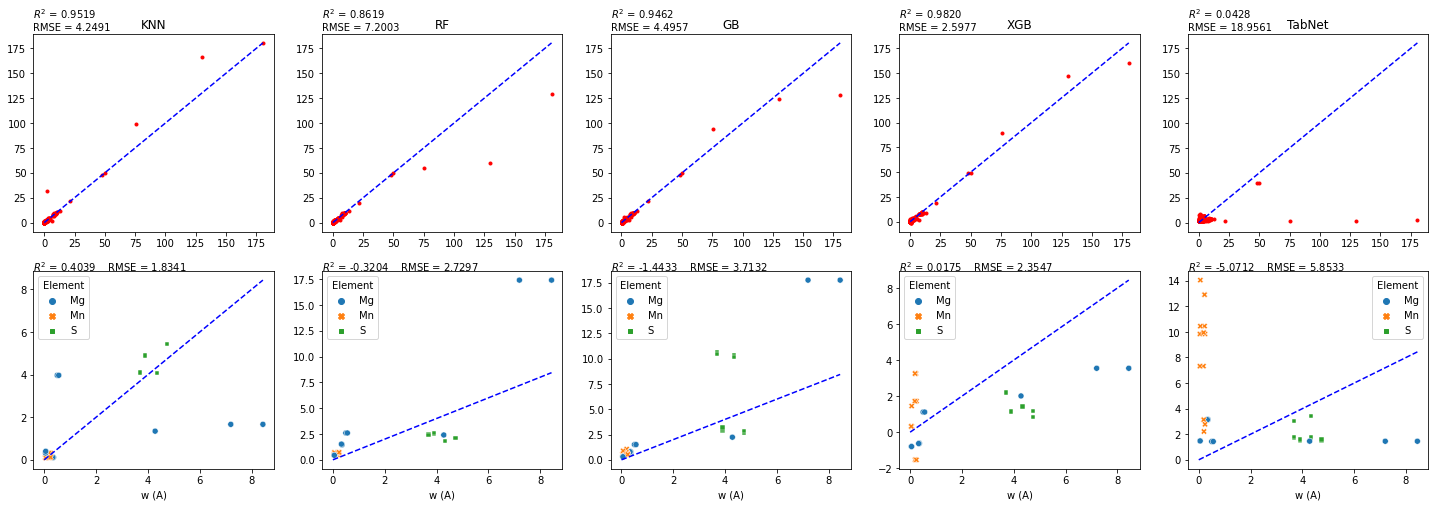

({'KNN': array([3.67868103e-02, 4.08068019e-02, 3.99337040e-02, 1.13916788e-01,
         6.80000000e-02, 7.83396520e-02, 1.51461483e+00, 1.37000000e-01,
         1.14496067e-01, 3.50000000e-02, 1.68074812e-01, 1.38350992e-01,
         7.81127322e-02, 2.69494766e-02, 6.46322026e-02, 3.67868112e-02,
         8.02871354e-01, 2.92527069e-02, 1.77744998e-02, 9.38872678e-02,
         7.83397679e-02, 7.80141870e-02, 7.80000000e-02, 2.63998371e-02,
         7.81127322e-02, 1.85304508e-01, 8.34955379e-03, 3.02411470e-02,
         8.64182604e-02, 1.65000000e+00, 7.80000000e-02, 1.36405436e-01,
         1.17162695e-01, 1.51803582e-01, 4.87878119e-03, 1.37000000e-01,
         8.31067011e-02, 3.80000000e-02, 3.72126113e-01, 6.32703303e-01,
         3.19809646e-01, 4.10000000e-01, 4.85695367e-01, 1.72332456e+00,
         2.50896854e-01, 1.28945062e+00, 7.01195472e-01, 1.57000000e+00,
         6.92207095e-01, 1.73724199e+00, 4.60000000e-01, 2.12000000e+00,
         3.79990290e-01, 3.66223979e-01, 4.0

In [32]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

## In case on scaled *targets*

In [ ]:
if scaled_target:
    

Getting KNN_Scaled predictions
Getting RF_Scaled predictions
Getting GB_Scaled predictions
Getting XGB_Scaled predictions
[19:47:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_Scaled predictions

Early stopping occurred at epoch 247 with best_epoch = 227 and best_eval_mse = 0.33175
Best weights from best epoch are automatically used!
Plotting KNN_Scaled predictions
Plotting RF_Scaled predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB_Scaled predictions
Plotting XGB_Scaled predictions
Plotting TabNet_Scaled predictions


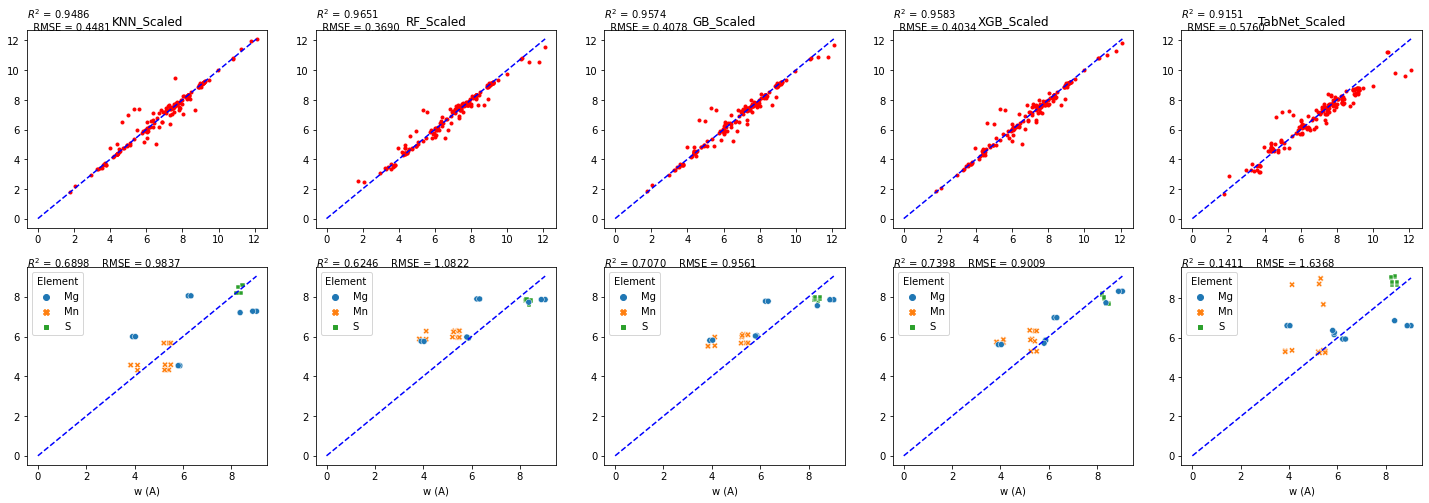

In [ ]:
models = ['KNN_Scaled', 'RF_Scaled', 'GB_Scaled', 'XGB_Scaled', 'TabNet_Scaled']

models_d = create_models_dict(models)

preds, preds_elem, fix, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

In [ ]:
YW_train.describe()

count    743.000000
mean       6.827546
std        2.064939
min        0.916291
25%        5.293254
50%        7.280867
75%        8.298389
max       12.103492
Name: w (A), dtype: float64

In [ ]:
YW_train = (np.exp(YW_train) - 1) * epsilon
YW_test = (np.exp(YW_test) - 1) * epsilon
YW_elem = (np.exp(YW_elem) - 1) * epsilon
for name, values in preds.items():
    preds[name] = (np.exp(preds[name]) - 1) * epsilon
    preds_elem[name] = (np.exp(preds_elem[name]) -1) * epsilon

In [ ]:
YW_train.describe()

count    743.000000
mean       4.339704
std       10.911161
min        0.001500
25%        0.198000
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64

Plotting KNN_Scaled predictions
Plotting RF_Scaled predictions
Plotting GB_Scaled predictions
Plotting XGB_Scaled predictions
Plotting TabNet_Scaled predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

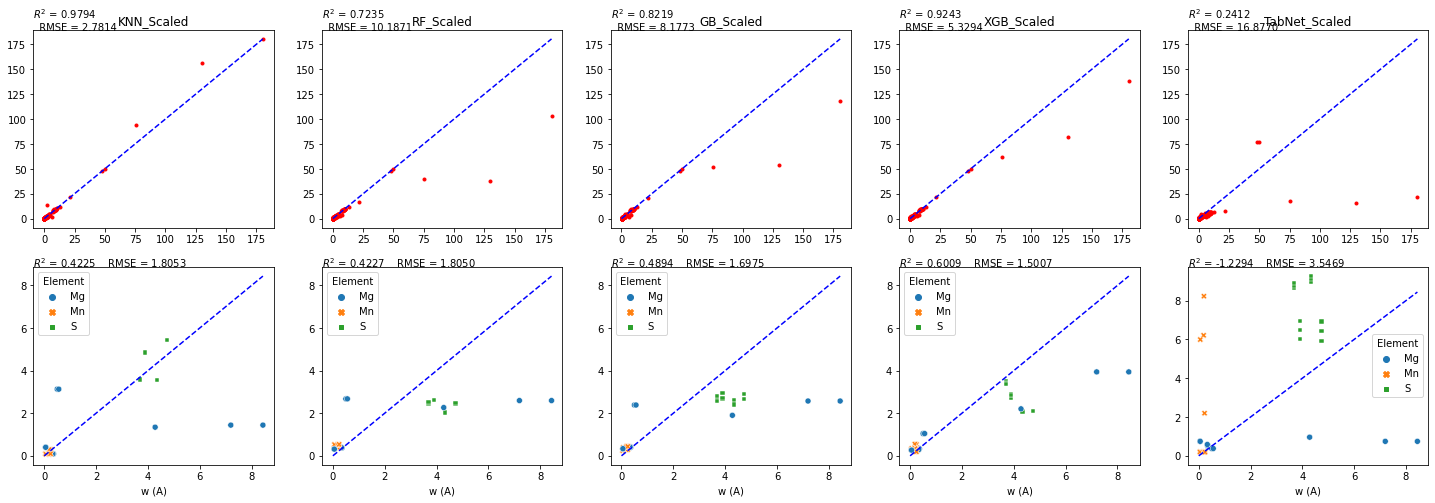

In [ ]:
predictions_elem = {}
R2 = {}
R2_elem = {}
RMSE = {}
RMSE_elem = {}
for name, model in models_d.items():
    y_pred = preds[name]
    R2[name] = r2_score(YW_test, y_pred)
    RMSE[name] = mean_squared_error(YW_test, y_pred, squared = False)

    y_pred = preds_elem[name]
    R2_elem[name] = r2_score(YW_elem, y_pred)
    RMSE_elem[name] = mean_squared_error(YW_elem, y_pred, squared = False)

    
i = 0
fig, ax = plt.subplots(2, len(models_d), figsize = (5*len(models_d), 4*2))
for name, model in models_d.items():
    print(f'Plotting {name} predictions')
    ax[0, i].plot(YW_test, preds[name], 'r.')
    ax[0, i].plot([0, np.amax(YW_test)], [0, np.amax(YW_test)], color = 'b', ls = '--')
    ax[0, i].set_title(f'{name}')
    #ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}', transform = ax[0, i].transAxes)
    ax[0, i].text(x = 0, y = 1, s = f'$R^2$ = {R2[name]:.4f}  \n  RMSE = {RMSE[name]:.4f}',  transform = ax[0, i].transAxes)
    
    #ax[1, i].plot(y_elem, predictions_elem[name], 'r.')
    sns.scatterplot(YW_elem, preds_elem[name], ax = ax[1, i], style = LW_elem['Element'], hue = LW_elem['Element'])
    ax[1, i].plot([0, np.amax(YW_elem)], [0, np.amax(YW_elem)], color = 'b', ls = '--')
    ax[1, i].text(x = 0, y = 1, s = f'$R^2$ = {R2_elem[name]:.4f}    RMSE = {RMSE_elem[name]:.4f}',  transform = ax[1, i].transAxes)
    i += 1
plt.show()

## Shift

In [ ]:
print(XS_train.shape, XS_test.shape, XS_elem.shape)
print(XW_train.shape, XW_test.shape, XW_elem.shape)
#print(XS_elem)

(275, 50) (58, 50) (20, 50)
(743, 50) (154, 50) (34, 50)


In [ ]:
print(YS_elem)

2      0.350000
3      0.353000
4      0.330000
587    4.342105
588    3.687708
589    4.342105
590    3.687708
591    4.342105
592    3.687708
593    4.736842
594    3.903226
595    4.736842
596    3.903226
597    4.736842
598    3.903226
730    4.280000
731    8.440000
732    7.200000
733    0.500000
734    0.560000
Name: w (A), dtype: float64


Getting KNN_SHIFT predictions
Getting GB_SHIFT predictions
Getting XGB_SHIFT predictions
[10:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Getting TabNet_SHIFT predictions

Early stopping occurred at epoch 52 with best_epoch = 32 and best_eval_mse = 21.197
Best weights from best epoch are automatically used!
Plotting KNN_SHIFT predictions


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Plotting GB_SHIFT predictions
Plotting XGB_SHIFT predictions
Plotting TabNet_SHIFT predictions


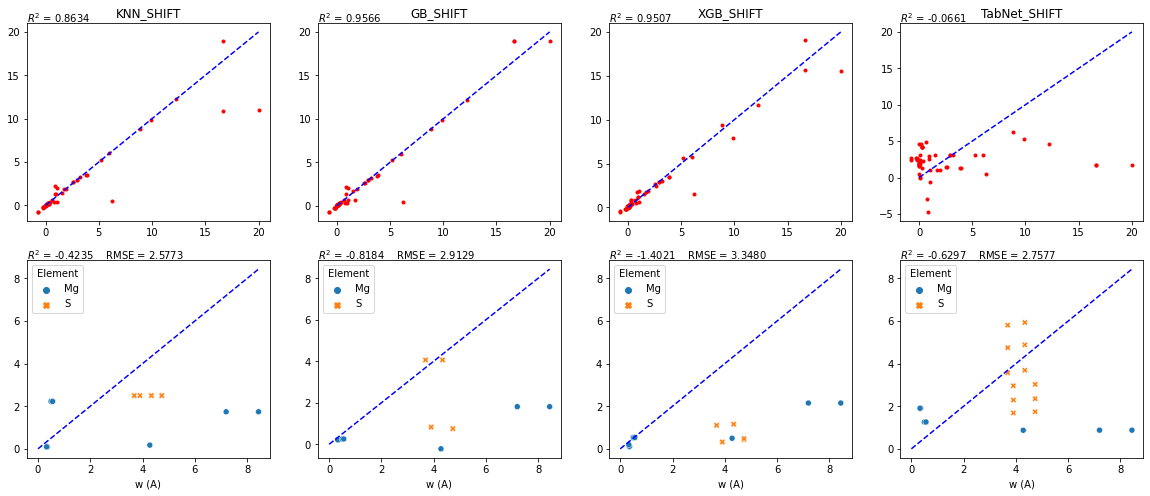

({'GB_SHIFT': array([-2.59310346e-01,  3.91666204e-02, -2.35672990e-01, -6.65330643e-01,
         -1.97868738e-01,  4.12027283e-02, -2.35810597e-01,  4.26402963e-02,
         -1.06844387e-02,  8.81676419e-02, -1.97868738e-01, -2.03051373e-02,
         -6.65468250e-01,  4.33106305e-02,  4.26402963e-02,  1.07328810e-01,
          1.59113465e-01,  1.59903665e-01,  4.36632002e-02,  3.01826828e-01,
          6.55451760e-02,  1.05224689e-01,  1.05224689e-01,  9.98871562e-02,
          4.01470207e-02,  1.94114458e-01,  1.46755968e-01,  2.47311336e-01,
          3.01826828e-01,  6.23425829e-01,  6.45440574e-01,  3.34044165e-01,
          1.92704852e+00,  2.02773660e+00,  2.88451743e-01,  1.32040544e+00,
          3.70799218e-01,  2.15029230e+00,  6.55432110e-01,  2.67965532e+00,
          4.32047723e-01,  2.67965532e+00,  1.70248872e+00,  3.01826828e-01,
          1.89490980e+01,  3.54710071e+00,  5.21354720e+00,  5.98792639e+00,
          1.89490980e+01,  3.21656767e+00,  4.51844911e-01,  2.9

In [ ]:
models = ['KNN_SHIFT', 'GB_SHIFT', 'XGB_SHIFT', 'TabNet_SHIFT']

models_d = create_models_dict(models)

plot_model_prediction(models_d, XS_train, YS_train, XS_test, YS_test, XS_elem, YS_elem, LS_elem)

## Comparing old (handmade/handtuned) and auto new TabNet

In [ ]:
models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results)



models = ['TabNet', 'TabNet_handmade']
models_d = create_models_dict(models)

pr, elem, fig, ax = plot_model_prediction(models_d, XW_train, YW_train, XW_test, YW_test, XW_elem, YW_elem, LW_elem)

KeyError: ignored

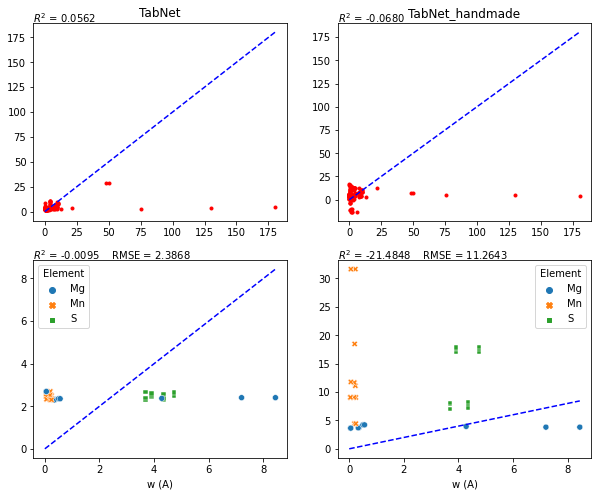

In [ ]:
#ax[0, 0].set_xlim(0, 15)
#ax[0, 0].set_ylim(0, 15)
#ax[0, 1].set_xlim(0, 15)
#ax[0, 1].set_ylim(0, 15)
fig

# Temperature dependence

In [191]:
data.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T,w (A),d (A)
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,9.830000e+02,983.000000,931.000000,351.000000
mean,444.085424,15.198372,1.782299,1.636826,3.608342,0.904374,2.009156,2.452696,0.368260,0.754832,...,0.001017,0.001017,2.937945,1.511699,0.580875,1.826551,1.990865e+05,16955.922686,4.477035,2.002865
std,212.363227,15.896826,0.412893,0.717363,2.199845,0.905410,2.714695,3.973378,0.706883,1.700579,...,0.031895,0.031895,1.295934,1.273902,0.493667,1.397436,3.176684e+06,10464.266698,12.561398,3.605064
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000,0.001500,-7.485437
25%,303.412000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.384062e+04,10000.000000,0.200000,0.049500
50%,471.315614,8.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.613735e+04,12500.000000,1.451247,0.302267
75%,543.517800,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.175074e+05,20900.000000,4.016393,2.515585
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,8.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000,180.500000,20.000000


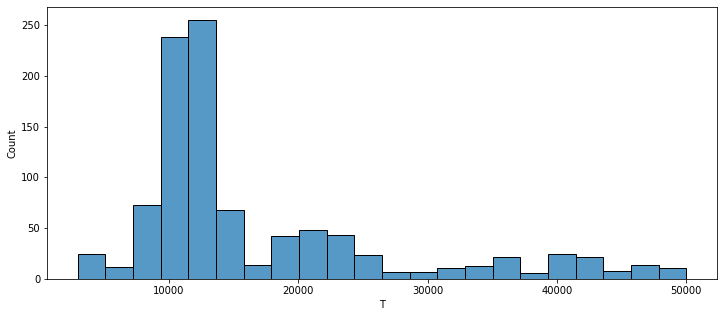

In [190]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.histplot(data = data, x = 'T')
plt.show()

In [192]:
temp_data = data.drop(columns = ['d (A)', 'w (A)', 'T'])
temp_data.duplicated().value_counts()

True     513
False    470
dtype: int64

In [193]:
temp_data['Wavelength'].value_counts()

538.337000    38
667.815000    27
501.568000    24
471.313916    18
471.315614    18
              ..
342.686000     1
288.158000     1
252.850000     1
252.412000     1
448.035000     1
Name: Wavelength, Length: 455, dtype: int64

In [194]:
data.loc[data['Wavelength'] == 448.0350]

,Element,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,...,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T,w (A),d (A)
446,Cu,448.035,29,2,2,6,2,6,10,0,...,0,0,2,0,1,0.5,52848.751,10000,2.4,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


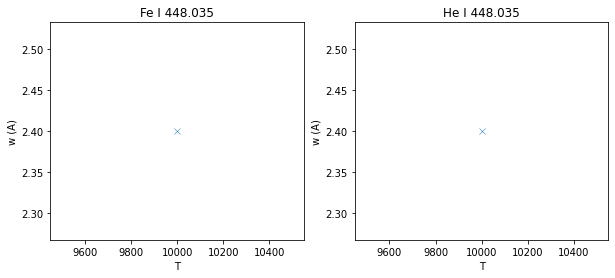

In [195]:
Fe_wavelength = 448.0350
He_wavelength = 448.0350

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
sns.scatterplot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], ax = ax[0], marker = 'x')
sns.scatterplot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], ax = ax[1], marker = 'x')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

plt.show()

In [196]:
#Define temperature range in each case

Fe_low, Fe_high = data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == Fe_wavelength]['T'].describe()['max']
He_low, He_high = data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['min'], data.loc[data['Wavelength'] == He_wavelength]['T'].describe()['max']

npoints = 1000
#Fe_temperatures = np.linspace(Fe_low, Fe_high, npoints)
#He_temperatures = np.linspace(He_low, He_high, npoints)

Fe_temperatures = np.linspace(2950, 50000, npoints)
He_temperatures = np.linspace(2950, 50000, npoints)

Fe_unit = data_width.loc[data_width['Wavelength'] == Fe_wavelength][data_width['Wavelength'].duplicated() == False]
He_unit = data_width.loc[data_width['Wavelength'] == He_wavelength][data_width['Wavelength'].duplicated() == False]

for i in range(npoints):
    Fe_unit['T'] = Fe_temperatures[i]
    if i == 0:
        temperature_test_data = Fe_unit
    else:
        temperature_test_data = pd.concat([temperature_test_data, Fe_unit])

for i in range(npoints):
    He_unit['T'] = He_temperatures[i]
    temperature_test_data = pd.concat([temperature_test_data, He_unit])

temperature_test_data = temperature_test_data.drop(columns=['Element', 'Wavelength', 'Z number'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [197]:
models = ['KNN_Scaled', 'XGB_Scaled']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']), np.log(1 + target_width / epsilon))

temperature_test_predictions = {}
for name, model in models_d.items():
    temperature_test_predictions[name] = model.predict(temperature_test_data)

Training KNN_Scaled model
Training XGB_Scaled model
[15:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [198]:
models = ['KNN_Scaled', 'XGB_Scaled']
models_d = create_models_dict(models)

for name, model in models_d.items():
    print(f"Training {name} model")
    model.fit(data_width.drop(columns=['Element', 'Wavelength', 'Z number']).drop([446]), np.log(1 + target_width / epsilon).drop([446]))

temperature_test_predictions_2 = {}
for name, model in models_d.items():
    temperature_test_predictions_2[name] = model.predict(temperature_test_data)

Training KNN_Scaled model
Training XGB_Scaled model
[15:34:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


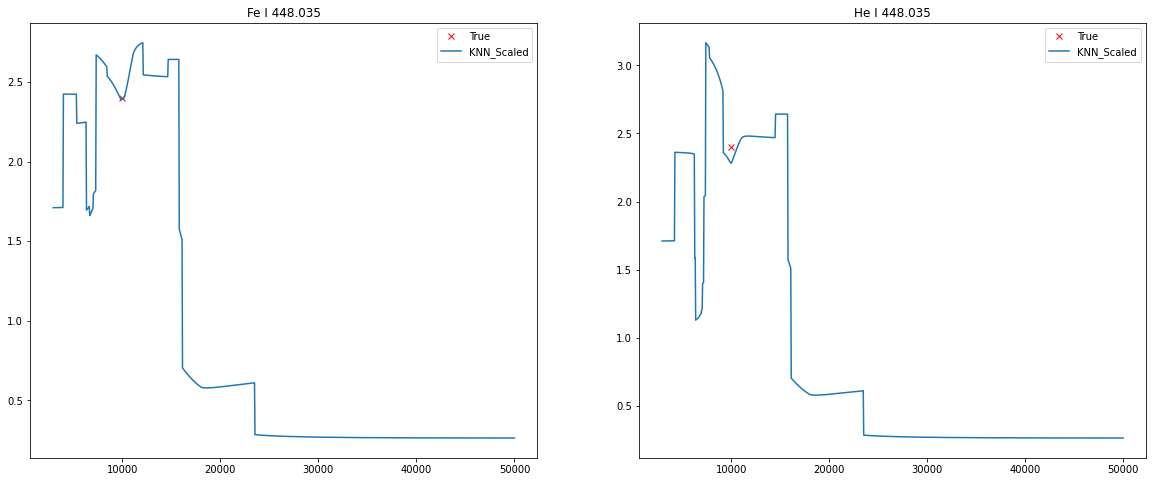

In [200]:

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(data.loc[data['Wavelength'] == Fe_wavelength]['T'], data.loc[data['Wavelength'] == Fe_wavelength]['w (A)'], 'rx', label = 'True')
ax[1].plot(data.loc[data['Wavelength'] == He_wavelength]['T'], data.loc[data['Wavelength'] == He_wavelength]['w (A)'], 'rx', label = 'True')

ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions['KNN_Scaled'][:1000]) - 1) * epsilon, label = 'KNN_Scaled')
ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions_2['KNN_Scaled'][1000:]) - 1) * epsilon, label = 'KNN_Scaled')

#ax[0].plot(Fe_temperatures, (np.exp(temperature_test_predictions['XGB_Scaled'][:1000]) - 1) * epsilon, label = 'XGB_Scaled')
#ax[1].plot(He_temperatures, (np.exp(temperature_test_predictions_2['XGB_Scaled'][1000:]) - 1) * epsilon, label = 'XGB_Scaled')

ax[0].set_title(f'Fe I {Fe_wavelength}')
ax[1].set_title(f'He I {He_wavelength}')

ax[0].legend()
ax[1].legend()

plt.show()

In [ ]:
data_width.drop(columns=['Element', 'Wavelength', 'Z number'])

In [89]:
models_d['KNN_Scaled']

# Debugging

In [ ]:
target_width.quantile(0.9)

9.113725490196074

In [ ]:
LW_elem

,Element,Wavelength
2,Mg,518.36043
3,Mg,517.26844
4,Mg,516.73213
5,Mn,403.07530
6,Mn,403.30620
7,Mn,403.44830
8,Mn,279.48170
9,Mn,279.82690
10,Mn,280.10810
11,Mn,404.13550


Fitting KNN
Fitting RF
Fitting GB
Fitting XGB
[15:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting TabNet

Early stopping occurred at epoch 55 with best_epoch = 35 and best_eval_mse = 359.33225
Best weights from best epoch are automatically used!
Calculating bootstrap score for KNN
Calculating bootstrap score for RF
Calculating bootstrap score for GB
Calculating bootstrap score for XGB
Calculating bootstrap score for TabNet


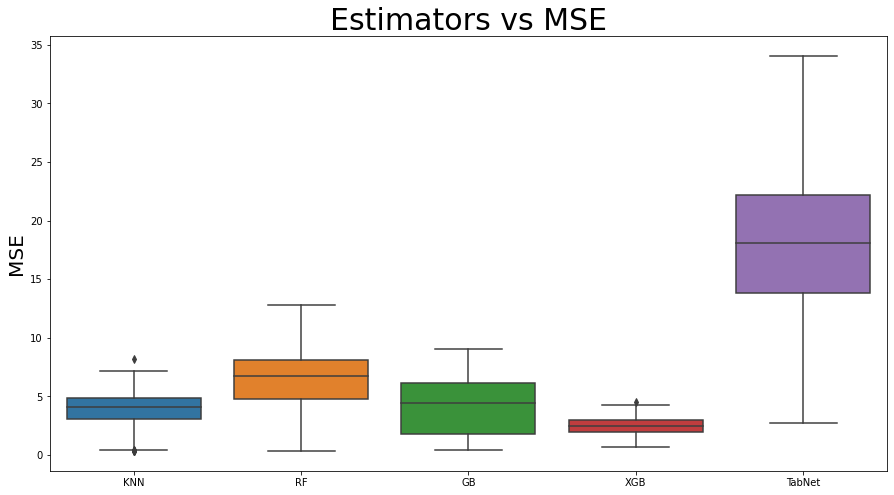

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

tuned_results = train_and_test_regressor(models_d, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(tuned_results)

[16:19:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 7.652456533356582
GB model 11.978170490764201
[16:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 85.67093351905685
GB model 67.74644926737481
[16:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.871245347868278
GB model 48.14135844210374
[16:19:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 2.3040662820980895
GB model 2.5558378882546395
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 XGB model: 1.6383731338990246
GB model 2.1933960069613687

 XGB score 19.827414963255766
GB score 26.52304241909175
{'GB': Gradi

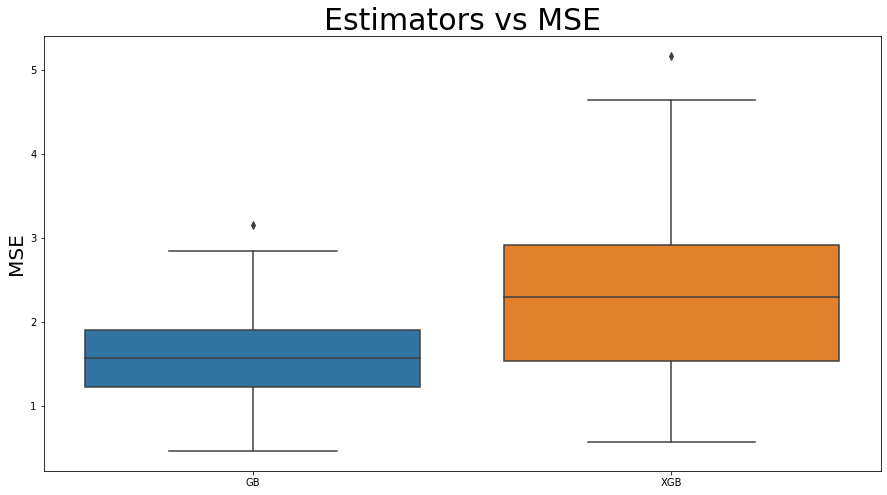

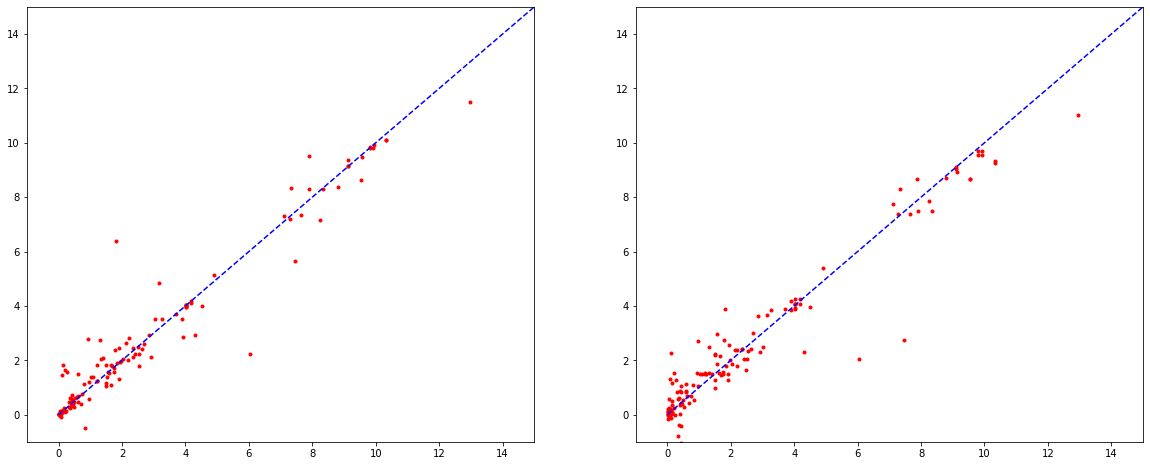

GB MSE: 2.699773000606855
XGB MSE: 5.888925800005179


In [ ]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score_XGB = 0
score_GB = 0

with open(path + f'/GB' + '_optimal_parameters', 'r') as fp:
    GB_params = json.load(fp)
with open(path + f'/XGB' + '_optimal_parameters', 'r') as fp:
    XGB_params = json.load(fp)

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model_XGB = xgboost.XGBRegressor(**XGB_params, n_estimators = 500, n_jobs = -1)
    model_GB = GradientBoostingRegressor(**GB_params, n_estimators = 500)
    
    model_XGB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_GB.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score_XGB += mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_GB += mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'XGB model:', mean_squared_error(YW_train.iloc[test], model_XGB.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('GB model', mean_squared_error(YW_train.iloc[test], model_GB.predict(XW_train.iloc[test, :]),
                                squared = True))
score_XGB /= nfolds
score_GB /= nfolds

print(f"\n XGB score {score_XGB}")
print(f"GB score {score_GB}")

models = {
    'GB' : model_GB,
    'XGB' : model_XGB
}
print(models)
rrr = train_and_test_regressor(models,
                               XW_train,
                               YW_train,
                               XW_test.sample(frac = 1, random_state = 777),
                               YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()


print(f'GB MSE: {mean_squared_error(YW_test, model_GB.predict(XW_test))}')
print(f'XGB MSE: {mean_squared_error(YW_test, model_XGB.predict(XW_test))}')


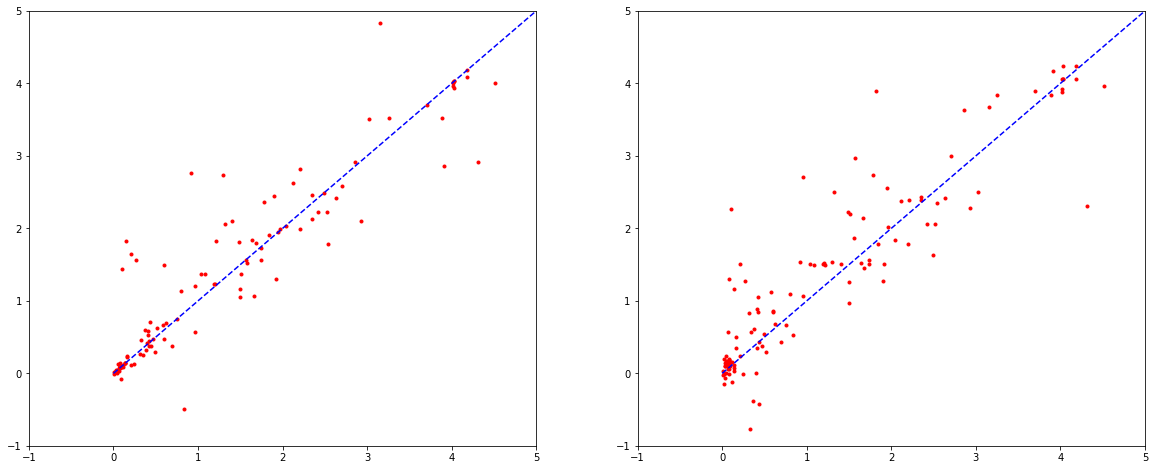

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_GB.predict(XW_test), 'r.')
ax[1].plot(YW_test, model_XGB.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 5)
    i.set_ylim(-1, 5)
plt.show()

In [ ]:
models = ['KNN', 'RF', 'GB', 'XGB', 'TabNet']

models_d = create_models_dict(models)

In [ ]:
print(models_d.items())

TypeError: ignored

In [ ]:
abc = np.array([2, 3, 4])
abc = abc.flatten()
abc.shape

(3,)